<a id="top"></a>
# Interpreting Convolutional Neural Networks

***

## Learning Goals


**In this tutorial, you will practice analyzing and interpreting a convolutional neural network.**
 This tutorial assumes a basic knowledge of convolutional neural networks. We will utilize the model described in `Classifying_JWST-HST_galaxy_mergers_with_CNNs`, so it is recommended to complete that notebook before reading this one.

## Introduction
Machine learning techniques can be powerful tools for categorizing data and performing data analysis questions. However, machine learning techniques often involve a lot of hidden computation that is not immediately meaningful. The black-box nature of intermediary processes, especially in layered neural networks, can make it difficult to interpret and understand. The goal of this notebook is to familiarize you with some of the various techniques used to make sense of machine learning and convolutional neural networks (CNNs) in particular. CNNs in particular can be very difficult to interpret due to their multi-layered structure and convolutional layers. In this notebook, we will examine two methods of visualizing CNN results (Backpropagation and Grad-CAM) and another method for testing model architecture.

1. Load the data
2. Split the data into training, validation, and testing sets
3. Build and train a model
4. Apply some interpretation technique to understand your results from a physical perspective.


### Dependencies

This notebook uses the following packages:
- `numpy` to handle array functions
- `astropy` for downloading and accessing FITS files
- `matplotlib.pyplot` for plotting data
- `keras` and `tensorflow` for building the CNN
- `sklearn` for some utility functions

If you do not have these packages installed, you can install them using [`pip`](https://pip.pypa.io/en/stable/) or [`conda`](https://docs.conda.io/en/latest/).

Further information about the original model can be found at the [Hello Universe codebase](https://spacetelescope.github.io/hellouniverse/notebooks/hello-universe/Classifying_JWST-HST_galaxy_mergers_with_CNNs/Classifying_JWST-HST_galaxy_mergers_with_CNNs.html).


**Author:**  
Oliver Lin, oliverlin2004@gmail.com

**Additional Contributors:**  
Daisuke Nagai, daisuke.nagai@yale.edu.

Michelle Ntampaka, mntampaka@stsci.edu.

**Published:** 2024-05-08

In [1]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

# keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Convolution2D, MaxPooling2D
# from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2

# sklearn
from sklearn.model_selection import train_test_split

# tensorflow for saliency
import tensorflow as tf
import cv2

2025-07-03 14:41:44.106021: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-03 14:41:44.137571: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-03 14:41:44.137596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-03 14:41:44.138606: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-03 14:41:44.143958: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-03 14:41:44.144520: I tensorflow/core/platform/cpu_feature_guard.cc:1

2025-07-03 14:41:44.898842: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Reloading our Model
To start, we need to reload our model from the previous galaxy classification notebook from the Mikulski Archive for Space Telescopes (MAST). The following code is directly copied over from that notebook. For a quick refresher, the model intakes a FITS file from a high level science product hosted by MAST. There are 15,426 observations in total, each taken with three filters (F814W from the Advanced Camera for Surveys and F160W from the Wide Field Camera 3 on the Hubble Space Telescope (HST), and F160W and F356W from Near Infrared Camera on the James Webb Space Telescope (JWST)). The model then applies a Convolutional Neural Network to classify whether a galaxy has undergone a merger.

In [2]:
version = 'pristine'
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

## Build and Compile the Convolutional Model
For the sake of transparency, we will rebuild the model using the same architecture as the original notebook. The model can also be loaded directly by using `save_model` and `load_model` from the [Keras](https://www.tensorflow.org/guide/keras/serialization_and_saving) package. 

In [3]:
X = hdu[0].data
y = hdu[1].data

Following the authors, we will split the data into 70:10:20 ratio of train:validate:test. As above, set the random seed to randomly split the images in a repeatable way. Feel free to try different values!



In [4]:
random_state = 42

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=random_state, shuffle=True)

In [5]:
imsize = np.shape(X_train)[2]

X_train = np.array([np.stack(x, axis=2) for x in X_train])
X_valid = np.array([np.stack(x, axis=2) for x in X_valid])
X_test = np.array([np.stack(x, axis=2) for x in X_test])

### Generate the model architecture (written for Keras 2)

In [6]:
# Define architecture for model
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation='sigmoid')(z1)

cnn = Model(inputs=x_in, outputs=y_out)

### Compile Model

In [7]:
optimizer = 'adam'
fit_metrics = ['accuracy']
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)

### Load pretrained weights


In [8]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_interpretability_best_weights.hdf5'
cnn.load_weights(download_file(file_url, cache=True, show_progress=True))

2025-07-03 14:41:47.254546: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open /home/runner/.astropy/cache/download/url/75479cba1a5e1313befcce7b9c2f3f36/contents: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


## 1. Saliency Maps
We will start by introducing the most popular and well known method of interpreting CNNs. A saliency map can help us identify which pixels are significant to the models final prediction. There are many methods of calculating saliency maps, but the most popular method utilizes gradient backpropagation to determine the significance of pixels at each layer of the model. To calculate the saliency map, the error gradient at each layer is calculated and then fed into the previous layer, repeating until we reach the original image. Then the pixels with the highest gradient values will also have the most effect on the model's activation. This methodology is described in detail by <a href='https://arxiv.org/abs/1312.6034'>Simonyan et al. 2013</a>. 

### Dependencies

`tensorflow.GradientTape()` is used to track the gradient of the function.


In [9]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [10]:
images = tf.Variable(img, dtype=float)

# Make a prediction and track gradients
with tf.GradientTape() as tape:
    pred = cnn(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
    loss = pred[class_idxs_sorted[0]]

grads = tape.gradient(loss, images)

### Plot the original image and the saliency map

Saliency maps provide an intuitive understanding of how the model works. The hot pixels represent higher activation and more importance. In the below model, the saliency maps demonstrates that the model focuses on the area around the center of the galaxy for the majority of galaxies. Our results are in line with a corroborating result by [Ntampaka et al. 2018](https://arxiv.org/abs/1810.07703), suggesting that the key features of a galaxy are found the ring around the galaxy rather than in the center of the galaxy.

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 92ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

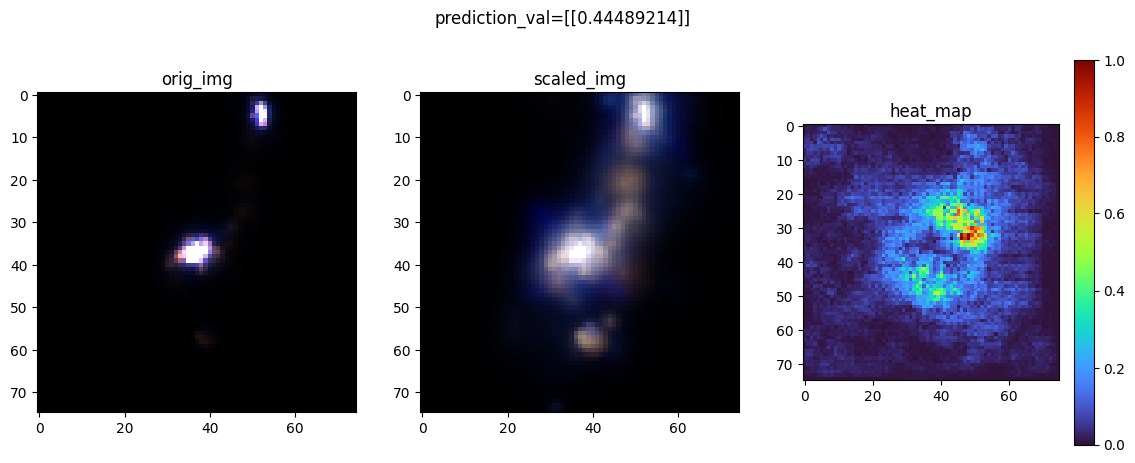

In [11]:
y_pred = cnn.predict(img)

dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

# normalize to range between 0 and 1
arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(grad_eval, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the saliency map.

### Create a stack of saliency images

To understand the overall behavior of our algorithm, we can stack some or all of the saliency maps in the test set to generate an overarching estimate of important pixels. For the sake of simplicity, we will stack the saliency maps for the first 100 images in the test set. Our results once again indicate that the region around a galaxy is particularly important to the model.

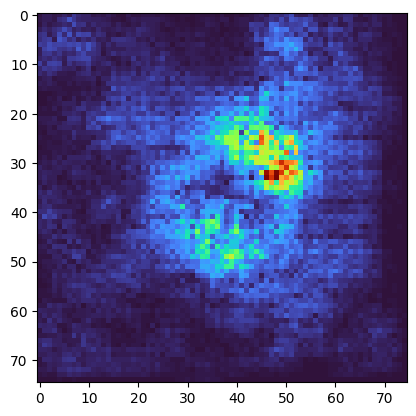

In [12]:
sum_map = np.zeros((75, 75))
# Summing the first 100 saliencies. We can change
# the range to sum more or less saliencies or pick 
# specific ones
for i in range(100):
    img = X_test[img_idx]
    img = img.reshape((1, *img.shape))
    images = tf.Variable(img, dtype=float)

    # Make a prediction and track gradients
    with tf.GradientTape() as tape:
        pred = cnn(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
        loss = pred[class_idxs_sorted[0]]

    grads = tape.gradient(loss, images)

    y_pred = cnn.predict(images, verbose=0)

    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

    # normalize to range between 0 and 1
    arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min)
    sum_map += grad_eval
plt.imshow(sum_map, cmap='turbo')

**Image caption**: The above image contains a single panel, and shows a stacked version of the saliency maps from 100 images.

## 2. Grad-CAM
While gradient backpropagation has historically been the most popular type of saliency map, the highly connected nature of backtracking has been shown to produce high variance under small changes to inputs. As such, gradient backpropagation is extremely sensitive to data manipulation (preprocessing, sensitivity analysis, GANs), raising questions about its reliability and validity. Gradient Class Activation Mapping (Grad-CAM) is an alternative method for generating saliency models that only examines the gradient of the final convolutional layer when producing the map. As a consequence, Grad-CAM maps have lower (coarser) resolution than backpropagation but are far more resilient to small changes and therefore more reliable when tuning a model. A full description of the technique can be found in <a href='https://arxiv.org/abs/1610.02391'>Selveraju et al. 2016</a>.

The code for Grad-CAM comes from a useful tutorial on the subject by Daniel Reiff. For more information, please visit the  <a href='https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353'>full tutorial</a>.

### Dependencies

`Open_CV` and `astropy.simple_norm` are used to do manipulate the image for display. Alternatively, we could allow Python to automatically clip the image when the heatmap is out of range.

In [13]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [14]:
# Note: recompiling the model will change the layer
# name. In that case, you can either restart the 
# kernel or change the layer_name.
# We can also change the layer selected here to pull out any layer of our model
gradModel = Model(inputs=[cnn.inputs], outputs=[cnn.get_layer("conv2d_2").output, cnn.output])

with tf.GradientTape() as tape:
    # get the loss with associated with the prediction
    inputs = tf.cast(X_test, tf.float32)
    (convOutputs, predictions) = gradModel(inputs)
    loss = predictions[:, 0]
    
# use automatic differentiation to compute the gradients
grads = tape.gradient(loss, convOutputs)

# compute the guided gradients by removing all nonpositive
# gradients
castConvOutputs = tf.cast(convOutputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads

# pick out the convolution and gradient of the chosen image
convOutputs = convOutputs[img_idx]
guidedGrads = guidedGrads[img_idx]

# compute the average of the gradient values, and using them
# as weights, compute the importance of the pieces
weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (X_test.shape[2], X_test.shape[1])
heatmap = cv2.resize(cam.numpy(), (w, h))

# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer

2025-07-03 14:41:50.307208: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-03 14:41:51.144093: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-03 14:41:51.223916: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-03 14:41:51.263033: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-03 14:41:52.751070: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

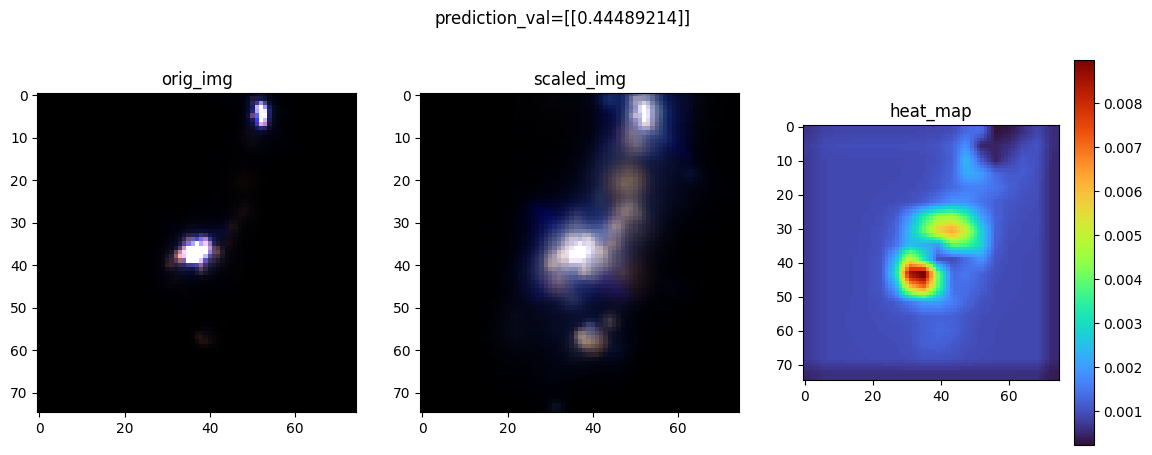

In [15]:
y_pred = cnn.predict(img)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the grad-cam map.

**The result is very similar** to our saliency map from backpropagation, although the image is coarser and also shows both the top and bottom of the galaxy. We can also play around with the selected layer to calculate the output at different steps in the model and see how activation changes throughout the model.

## 3. RISE Algorithm
The RISE (Randomized Input Sampling for Explanation) Algorithm is another interpretation technique for calculating saliency maps. Instead of calculating gradients from within the model, the RISE implementation works by covering up pieces of the input image, running it through the model, and calculating the average activation in order to determine what parts of the image are most important. As such, this method does not require any access to the inner workings of the model. The algorithm first generates a random sequence of binary grids (called masks), which are placed onto the image. Everything not covered by the mask is removed by multiplying the images together, and the resultant activations are averaged to get our final heatmap. A full description of the algorithm and its variations is provided by <a href='https://arxiv.org/abs/1806.07421'>Petsiuk et al. 2018</a>. 



In [16]:
# Choose the image to analyze
img_idx = 6

# We can change the index to any number in range of the test set
image = X_test[img_idx]

N = 1000  # Number of masks
s = 8     # Size of the grid
p1 = 0.5  # Probability of the cell being set to 1

cell_size = np.ceil(np.array(input_shape[:2]) / s).astype(int)
up_size = (s * cell_size).astype(int)

grid = np.random.rand(N, s, s) < p1
masks = np.empty((N, *input_shape[:2]))

for i in range(N):
    # Randomly place the grid on the image
    x = np.random.randint(0, input_shape[0]-s)
    y = np.random.randint(0, input_shape[1]-s)
    mask = np.pad(grid[i], ((x, input_shape[0]-x-s), (y, input_shape[0]-y-s)), 'constant', constant_values=(0, 0))
    mask = mask[:input_shape[0], :input_shape[1]]
    masks[i] = mask

masks = masks.reshape(-1, *input_shape[:2], 1)

N = len(masks)
pred_masks = cnn.predict(image * masks)
pred_masks = np.expand_dims(pred_masks, axis=-1)
pred_masks = np.expand_dims(pred_masks, axis=-1) # Reshape pred_masks for broadcasting
heatmap = (pred_masks * masks).sum(axis=0)
heatmap = heatmap / N / p1

 1/32 [..............................] - ETA: 0s

 5/32 [===>..........................] - ETA: 0s

 9/32 [=======>......................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 1s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00022207294..674.50696].


Text(0.5, 1.0, 'heat_map')

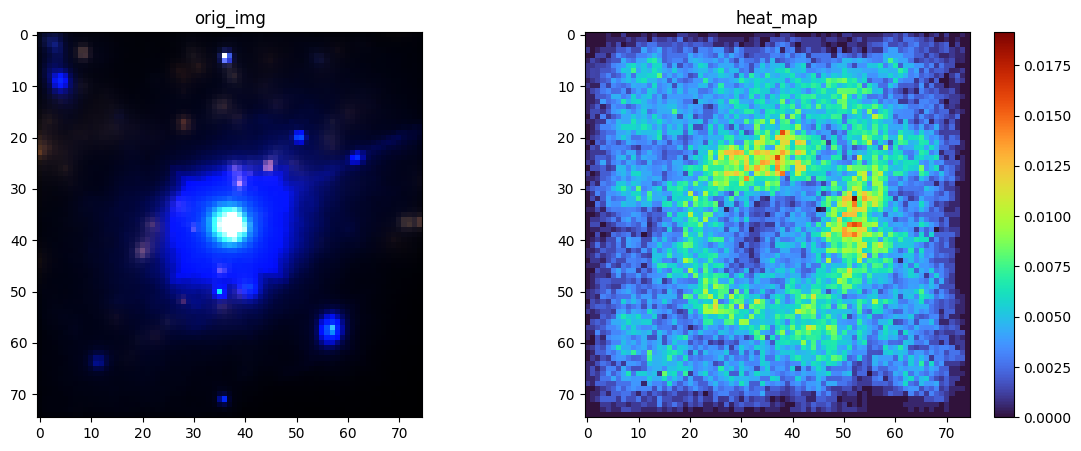

In [17]:
# Plot the results next to the original image
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(image)
axes[0].set_title("orig_img")
i = axes[1].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[1].set_title("heat_map")

**Image caption**: The above image contains two panels in a horizontal row. The first panel shows the original image of a merginig galaxy candidate, and the second panel shows a heat map of the RISE map.

**When examining the selected image**, we see a ring around the galactic center. Note that this is not the case for all astronomical images, or even all images in this dataset. Try playing around with the selected image to generate different saliency maps. For images where the central feature is relatively small, RISE's occlusion-based methodology can be unreliable.

## 4. Ablation Analysis
Saliency maps provide an intuitive visual understanding of our model's focus and can be useful for understanding the physical relevance of our classification scheme. In order to understand the efficacy of our model's architecture, we can instead use ablation analysis to determine the most important layers of our model. Ablation analysis works by rebuilding our model without a specified layer of interest and testing and comparing the performance of a partial model. Since we are focusing on our model's internal architecture rather than the features of the dataset we are looking at, we want to use this technique when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our mode

In the exercise below, we will build and train four mini-models on the same data set as before. As this is an educational notebook, we will limit the training time of each model to five epochs. Results with these models may vary considerably due to these training constraints, but we highly encourage you to try modifying this section of the notebook for different results (see [Exercises](#Exercises/Extensions))

Note that performing an ablation analysis will require training multiple models with the same architecture. This can be quite compute intensive on personal computers, so if you are running this notebook locally it is recommended that your device be plugged in before running the analysis.

### Dependencies

`Tensorflow` is used build our model and train it.

In [18]:
def create_model(ablate=None):
    x_in = Input(shape=input_shape)
    
    if ablate != 'c0':
        c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
    else:
        c0 = x_in
    b0 = BatchNormalization()(c0)
    d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
    e0 = Dropout(0.5)(d0)

    if ablate != 'c1':
        c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
    else:
        c1 = e0
    b1 = BatchNormalization()(c1)
    d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
    e1 = Dropout(0.5)(d1)

    if ablate != 'c2':
        c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
    else:
        c2 = e1
    b2 = BatchNormalization()(c2)
    d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
    e2 = Dropout(0.5)(d2)

    f = Flatten()(e2)
    z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
    z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
    y_out = Dense(1, activation='sigmoid')(z1)

    cnn = Model(inputs=x_in, outputs=y_out)
    return cnn

**Since ablation analysis requires training multiple models**, it can often be more resource intensive than other methods. However, it can also provide useful information on the way features are organized during training. The following cell can be edited to change how much we want to train our mini-models.

In [19]:
# You can change how much to train each model
# 5 epochs is chosen due to time and computation constraints
num_epochs = 5

# Train the original model
model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Get baseline performance
baseline_score = model.evaluate(X_test, y_test)

# Ablate each layer and compare performance
layers_to_ablate = ['c0', 'c1', 'c2']
for layer in layers_to_ablate:
    model_ablated = create_model(ablate=layer)
    model_ablated.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_ablated.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))
    ablated_score = model_ablated.evaluate(X_test, y_test)
    
    print(f"Performance drop after ablating {layer}: {baseline_score[1] - ablated_score[1]}")

Epoch 1/5


  1/338 [..............................] - ETA: 6:14 - loss: 0.7151 - accuracy: 0.4062

  2/338 [..............................] - ETA: 19s - loss: 0.7116 - accuracy: 0.4688 

  3/338 [..............................] - ETA: 19s - loss: 0.7107 - accuracy: 0.4792

  4/338 [..............................] - ETA: 19s - loss: 0.7091 - accuracy: 0.5078

  5/338 [..............................] - ETA: 18s - loss: 0.7100 - accuracy: 0.4812

  6/338 [..............................] - ETA: 18s - loss: 0.7086 - accuracy: 0.5052

  7/338 [..............................] - ETA: 18s - loss: 0.7093 - accuracy: 0.4821

  8/338 [..............................] - ETA: 18s - loss: 0.7085 - accuracy: 0.4922

  9/338 [..............................] - ETA: 18s - loss: 0.7072 - accuracy: 0.5139

 10/338 [..............................] - ETA: 18s - loss: 0.7072 - accuracy: 0.5094

 11/338 [..............................] - ETA: 18s - loss: 0.7072 - accuracy: 0.5028

 12/338 [>.............................] - ETA: 18s - loss: 0.7070 - accuracy: 0.5026

 13/338 [>.............................] - ETA: 18s - loss: 0.7064 - accuracy: 0.5096

 14/338 [>.............................] - ETA: 18s - loss: 0.7062 - accuracy: 0.5089

 15/338 [>.............................] - ETA: 18s - loss: 0.7063 - accuracy: 0.5000

 16/338 [>.............................] - ETA: 17s - loss: 0.7062 - accuracy: 0.4980

 17/338 [>.............................] - ETA: 17s - loss: 0.7061 - accuracy: 0.4945

 18/338 [>.............................] - ETA: 17s - loss: 0.7063 - accuracy: 0.4861

 19/338 [>.............................] - ETA: 17s - loss: 0.7061 - accuracy: 0.4852

 20/338 [>.............................] - ETA: 17s - loss: 0.7057 - accuracy: 0.4891

 21/338 [>.............................] - ETA: 17s - loss: 0.7057 - accuracy: 0.4851

 22/338 [>.............................] - ETA: 17s - loss: 0.7054 - accuracy: 0.4872

 23/338 [=>............................] - ETA: 17s - loss: 0.7055 - accuracy: 0.4796

 24/338 [=>............................] - ETA: 17s - loss: 0.7052 - accuracy: 0.4818

 25/338 [=>............................] - ETA: 17s - loss: 0.7050 - accuracy: 0.4837

 26/338 [=>............................] - ETA: 17s - loss: 0.7049 - accuracy: 0.4796

 27/338 [=>............................] - ETA: 17s - loss: 0.7048 - accuracy: 0.4780

 28/338 [=>............................] - ETA: 17s - loss: 0.7046 - accuracy: 0.4777

 29/338 [=>............................] - ETA: 17s - loss: 0.7045 - accuracy: 0.4774

 30/338 [=>............................] - ETA: 17s - loss: 0.7043 - accuracy: 0.4781

 31/338 [=>............................] - ETA: 17s - loss: 0.7041 - accuracy: 0.4778

 32/338 [=>............................] - ETA: 17s - loss: 0.7039 - accuracy: 0.4785

 33/338 [=>............................] - ETA: 17s - loss: 0.7037 - accuracy: 0.4811

 34/338 [==>...........................] - ETA: 17s - loss: 0.7035 - accuracy: 0.4825

 35/338 [==>...........................] - ETA: 16s - loss: 0.7033 - accuracy: 0.4839

 36/338 [==>...........................] - ETA: 16s - loss: 0.7033 - accuracy: 0.4800

 37/338 [==>...........................] - ETA: 16s - loss: 0.7032 - accuracy: 0.4755

 38/338 [==>...........................] - ETA: 16s - loss: 0.7031 - accuracy: 0.4762

 39/338 [==>...........................] - ETA: 16s - loss: 0.7029 - accuracy: 0.4760

 40/338 [==>...........................] - ETA: 16s - loss: 0.7028 - accuracy: 0.4742

 41/338 [==>...........................] - ETA: 16s - loss: 0.7027 - accuracy: 0.4726

 42/338 [==>...........................] - ETA: 16s - loss: 0.7026 - accuracy: 0.4725

 43/338 [==>...........................] - ETA: 16s - loss: 0.7024 - accuracy: 0.4767

 44/338 [==>...........................] - ETA: 16s - loss: 0.7024 - accuracy: 0.4751

 45/338 [==>...........................] - ETA: 16s - loss: 0.7023 - accuracy: 0.4736

 46/338 [===>..........................] - ETA: 16s - loss: 0.7021 - accuracy: 0.4742

 47/338 [===>..........................] - ETA: 16s - loss: 0.7020 - accuracy: 0.4754

 48/338 [===>..........................] - ETA: 16s - loss: 0.7019 - accuracy: 0.4753

 49/338 [===>..........................] - ETA: 16s - loss: 0.7018 - accuracy: 0.4751

 50/338 [===>..........................] - ETA: 16s - loss: 0.7017 - accuracy: 0.4769

 51/338 [===>..........................] - ETA: 16s - loss: 0.7015 - accuracy: 0.4798

 52/338 [===>..........................] - ETA: 16s - loss: 0.7015 - accuracy: 0.4766

 53/338 [===>..........................] - ETA: 16s - loss: 0.7014 - accuracy: 0.4741

 54/338 [===>..........................] - ETA: 15s - loss: 0.7013 - accuracy: 0.4763

 55/338 [===>..........................] - ETA: 15s - loss: 0.7012 - accuracy: 0.4761

 56/338 [===>..........................] - ETA: 15s - loss: 0.7011 - accuracy: 0.4760

 57/338 [====>.........................] - ETA: 15s - loss: 0.7010 - accuracy: 0.4731

 58/338 [====>.........................] - ETA: 15s - loss: 0.7010 - accuracy: 0.4741

 59/338 [====>.........................] - ETA: 15s - loss: 0.7009 - accuracy: 0.4778

 60/338 [====>.........................] - ETA: 15s - loss: 0.7008 - accuracy: 0.4802

 61/338 [====>.........................] - ETA: 15s - loss: 0.7007 - accuracy: 0.4831

 62/338 [====>.........................] - ETA: 15s - loss: 0.7006 - accuracy: 0.4844

 63/338 [====>.........................] - ETA: 15s - loss: 0.7005 - accuracy: 0.4856

 64/338 [====>.........................] - ETA: 15s - loss: 0.7004 - accuracy: 0.4854

 65/338 [====>.........................] - ETA: 15s - loss: 0.7004 - accuracy: 0.4856

 66/338 [====>.........................] - ETA: 15s - loss: 0.7003 - accuracy: 0.4839

 67/338 [====>.........................] - ETA: 15s - loss: 0.7002 - accuracy: 0.4841

 68/338 [=====>........................] - ETA: 15s - loss: 0.7002 - accuracy: 0.4848

 69/338 [=====>........................] - ETA: 15s - loss: 0.7001 - accuracy: 0.4864

 70/338 [=====>........................] - ETA: 15s - loss: 0.7000 - accuracy: 0.4862

 71/338 [=====>........................] - ETA: 15s - loss: 0.6999 - accuracy: 0.4855

 72/338 [=====>........................] - ETA: 15s - loss: 0.6999 - accuracy: 0.4852

 73/338 [=====>........................] - ETA: 14s - loss: 0.6998 - accuracy: 0.4859

 74/338 [=====>........................] - ETA: 14s - loss: 0.6997 - accuracy: 0.4882

 75/338 [=====>........................] - ETA: 14s - loss: 0.6997 - accuracy: 0.4883

 76/338 [=====>........................] - ETA: 14s - loss: 0.6996 - accuracy: 0.4910

 77/338 [=====>........................] - ETA: 14s - loss: 0.6995 - accuracy: 0.4919

 78/338 [=====>........................] - ETA: 14s - loss: 0.6995 - accuracy: 0.4912

 79/338 [======>.......................] - ETA: 14s - loss: 0.6994 - accuracy: 0.4917

 80/338 [======>.......................] - ETA: 14s - loss: 0.6993 - accuracy: 0.4922

 81/338 [======>.......................] - ETA: 14s - loss: 0.6993 - accuracy: 0.4907

 82/338 [======>.......................] - ETA: 14s - loss: 0.6993 - accuracy: 0.4897

 83/338 [======>.......................] - ETA: 14s - loss: 0.6993 - accuracy: 0.4895

 84/338 [======>.......................] - ETA: 14s - loss: 0.6992 - accuracy: 0.4885

 85/338 [======>.......................] - ETA: 14s - loss: 0.6992 - accuracy: 0.4893

 86/338 [======>.......................] - ETA: 14s - loss: 0.6991 - accuracy: 0.4902

 87/338 [======>.......................] - ETA: 14s - loss: 0.6991 - accuracy: 0.4892

 88/338 [======>.......................] - ETA: 14s - loss: 0.6990 - accuracy: 0.4908

 89/338 [======>.......................] - ETA: 14s - loss: 0.6989 - accuracy: 0.4909

 90/338 [======>.......................] - ETA: 14s - loss: 0.6988 - accuracy: 0.4924

 91/338 [=======>......................] - ETA: 13s - loss: 0.6988 - accuracy: 0.4928

 92/338 [=======>......................] - ETA: 13s - loss: 0.6987 - accuracy: 0.4929

 93/338 [=======>......................] - ETA: 13s - loss: 0.6987 - accuracy: 0.4913

 94/338 [=======>......................] - ETA: 13s - loss: 0.6987 - accuracy: 0.4910

 95/338 [=======>......................] - ETA: 13s - loss: 0.6986 - accuracy: 0.4928

 96/338 [=======>......................] - ETA: 13s - loss: 0.6986 - accuracy: 0.4925

 97/338 [=======>......................] - ETA: 13s - loss: 0.6985 - accuracy: 0.4932

 98/338 [=======>......................] - ETA: 13s - loss: 0.6984 - accuracy: 0.4943

 99/338 [=======>......................] - ETA: 13s - loss: 0.6984 - accuracy: 0.4959

100/338 [=======>......................] - ETA: 13s - loss: 0.6984 - accuracy: 0.4938

101/338 [=======>......................] - ETA: 13s - loss: 0.6983 - accuracy: 0.4944

102/338 [========>.....................] - ETA: 13s - loss: 0.6983 - accuracy: 0.4951

103/338 [========>.....................] - ETA: 13s - loss: 0.6982 - accuracy: 0.4951

104/338 [========>.....................] - ETA: 13s - loss: 0.6981 - accuracy: 0.4970

105/338 [========>.....................] - ETA: 13s - loss: 0.6981 - accuracy: 0.4955

106/338 [========>.....................] - ETA: 13s - loss: 0.6981 - accuracy: 0.4965

107/338 [========>.....................] - ETA: 13s - loss: 0.6980 - accuracy: 0.4968

108/338 [========>.....................] - ETA: 13s - loss: 0.6980 - accuracy: 0.4968

109/338 [========>.....................] - ETA: 12s - loss: 0.6980 - accuracy: 0.4966

110/338 [========>.....................] - ETA: 12s - loss: 0.6979 - accuracy: 0.4977

111/338 [========>.....................] - ETA: 12s - loss: 0.6979 - accuracy: 0.4977

112/338 [========>.....................] - ETA: 12s - loss: 0.6978 - accuracy: 0.4972

113/338 [=========>....................] - ETA: 12s - loss: 0.6978 - accuracy: 0.4981

114/338 [=========>....................] - ETA: 12s - loss: 0.6978 - accuracy: 0.4978

115/338 [=========>....................] - ETA: 12s - loss: 0.6977 - accuracy: 0.4981

116/338 [=========>....................] - ETA: 12s - loss: 0.6977 - accuracy: 0.4984

117/338 [=========>....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.4995

118/338 [=========>....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.4995

119/338 [=========>....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.4995

120/338 [=========>....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.4997

121/338 [=========>....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5000

122/338 [=========>....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.4997

123/338 [=========>....................] - ETA: 12s - loss: 0.6974 - accuracy: 0.4997

124/338 [==========>...................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5003

125/338 [==========>...................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5002

126/338 [==========>...................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5010

127/338 [==========>...................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5015

128/338 [==========>...................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5020

129/338 [==========>...................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5022

130/338 [==========>...................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5022

131/338 [==========>...................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5014

132/338 [==========>...................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5017

133/338 [==========>...................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5005

134/338 [==========>...................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5012

135/338 [==========>...................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5012

136/338 [===========>..................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5000

137/338 [===========>..................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5007

138/338 [===========>..................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5014

139/338 [===========>..................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5027

140/338 [===========>..................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5022

141/338 [===========>..................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5038

142/338 [===========>..................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5044

143/338 [===========>..................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5050

144/338 [===========>..................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5052

145/338 [===========>..................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5041

146/338 [===========>..................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5045

147/338 [============>.................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5045

148/338 [============>.................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5040

149/338 [============>.................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5046

150/338 [============>.................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5046

151/338 [============>.................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5054

152/338 [============>.................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5060

153/338 [============>.................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5047

154/338 [============>.................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5047

155/338 [============>.................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5050

156/338 [============>.................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5046

157/338 [============>.................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5050

158/338 [=============>................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5053

159/338 [=============>................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5053

160/338 [=============>................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5043

161/338 [=============>................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5054

162/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5052 

163/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5050

164/338 [=============>................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5038

165/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5044

166/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5036

167/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5039

168/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5047

169/338 [==============>...............] - ETA: 9s - loss: 0.6962 - accuracy: 0.5046

170/338 [==============>...............] - ETA: 9s - loss: 0.6962 - accuracy: 0.5046

171/338 [==============>...............] - ETA: 9s - loss: 0.6962 - accuracy: 0.5051

172/338 [==============>...............] - ETA: 9s - loss: 0.6962 - accuracy: 0.5051

173/338 [==============>...............] - ETA: 9s - loss: 0.6962 - accuracy: 0.5049

174/338 [==============>...............] - ETA: 9s - loss: 0.6961 - accuracy: 0.5052

175/338 [==============>...............] - ETA: 9s - loss: 0.6961 - accuracy: 0.5054

176/338 [==============>...............] - ETA: 9s - loss: 0.6960 - accuracy: 0.5060

177/338 [==============>...............] - ETA: 9s - loss: 0.6960 - accuracy: 0.5058

178/338 [==============>...............] - ETA: 9s - loss: 0.6960 - accuracy: 0.5067

179/338 [==============>...............] - ETA: 9s - loss: 0.6959 - accuracy: 0.5070

180/338 [==============>...............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5069

181/338 [===============>..............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5069

182/338 [===============>..............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5076

183/338 [===============>..............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5073

184/338 [===============>..............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5070

185/338 [===============>..............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5073

186/338 [===============>..............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5079

187/338 [===============>..............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5079

188/338 [===============>..............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5083

189/338 [===============>..............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5081

190/338 [===============>..............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5081

191/338 [===============>..............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5079

192/338 [================>.............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5083

193/338 [================>.............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5083

194/338 [================>.............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5081

195/338 [================>.............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5087

196/338 [================>.............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5080

197/338 [================>.............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5079

198/338 [================>.............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5085

199/338 [================>.............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5093

200/338 [================>.............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5094

201/338 [================>.............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5090

202/338 [================>.............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5087

203/338 [=================>............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5085

204/338 [=================>............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5084

205/338 [=================>............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5079

206/338 [=================>............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5070

207/338 [=================>............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5072

208/338 [=================>............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5069

209/338 [=================>............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5066

210/338 [=================>............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5067

211/338 [=================>............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5071

212/338 [=================>............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5077

213/338 [=================>............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5084

214/338 [=================>............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5088

215/338 [==================>...........] - ETA: 6s - loss: 0.6954 - accuracy: 0.5087

216/338 [==================>...........] - ETA: 6s - loss: 0.6954 - accuracy: 0.5085

217/338 [==================>...........] - ETA: 6s - loss: 0.6953 - accuracy: 0.5091

218/338 [==================>...........] - ETA: 6s - loss: 0.6953 - accuracy: 0.5092

219/338 [==================>...........] - ETA: 6s - loss: 0.6953 - accuracy: 0.5098

220/338 [==================>...........] - ETA: 6s - loss: 0.6953 - accuracy: 0.5095

221/338 [==================>...........] - ETA: 6s - loss: 0.6952 - accuracy: 0.5098

222/338 [==================>...........] - ETA: 6s - loss: 0.6952 - accuracy: 0.5097

223/338 [==================>...........] - ETA: 6s - loss: 0.6953 - accuracy: 0.5092

224/338 [==================>...........] - ETA: 6s - loss: 0.6952 - accuracy: 0.5100

225/338 [==================>...........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5103

226/338 [===================>..........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5105

227/338 [===================>..........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5103

228/338 [===================>..........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5100

229/338 [===================>..........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5098

230/338 [===================>..........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5095

231/338 [===================>..........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5097

232/338 [===================>..........] - ETA: 6s - loss: 0.6950 - accuracy: 0.5104

233/338 [===================>..........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5106

234/338 [===================>..........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5106

235/338 [===================>..........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5109

236/338 [===================>..........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5109

237/338 [====================>.........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5107

238/338 [====================>.........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5110

239/338 [====================>.........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5109

240/338 [====================>.........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5113

241/338 [====================>.........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5113

242/338 [====================>.........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5112

243/338 [====================>.........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5113

244/338 [====================>.........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5115

245/338 [====================>.........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5112

246/338 [====================>.........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5119

247/338 [====================>.........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5121

248/338 [=====================>........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5126

249/338 [=====================>........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5134

250/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5138

251/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5136

252/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5135

253/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5138

254/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5137

255/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5138

256/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5144

257/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5143

258/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5148

259/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5152

260/338 [======================>.......] - ETA: 4s - loss: 0.6944 - accuracy: 0.5156

261/338 [======================>.......] - ETA: 4s - loss: 0.6944 - accuracy: 0.5156

262/338 [======================>.......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5161

263/338 [======================>.......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5162

264/338 [======================>.......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5157

265/338 [======================>.......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5156

266/338 [======================>.......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5162

267/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5163

268/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5164

269/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5171

270/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5174

271/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5175

272/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5169

273/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5172

274/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5174

275/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5170

276/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5172

277/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5171

278/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5165

279/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5168

280/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5170

281/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5167

282/338 [========================>.....] - ETA: 3s - loss: 0.6941 - accuracy: 0.5168

283/338 [========================>.....] - ETA: 3s - loss: 0.6941 - accuracy: 0.5163

284/338 [========================>.....] - ETA: 3s - loss: 0.6941 - accuracy: 0.5167

285/338 [========================>.....] - ETA: 3s - loss: 0.6941 - accuracy: 0.5164

286/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5167

287/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5168

288/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5173

289/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5175

290/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5176

291/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5179

292/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5177

293/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5176

294/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5173

295/338 [=========================>....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5168

296/338 [=========================>....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5167

297/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5170

298/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5170

299/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5175

300/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5174

301/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5171

302/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5174

303/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5171

304/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5171

305/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5170

306/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5171

307/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5176

308/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5175

309/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5176

310/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5174

311/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5176

312/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5175

313/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5176

314/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5174

315/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5175

316/338 [===========================>..] - ETA: 1s - loss: 0.6937 - accuracy: 0.5174

317/338 [===========================>..] - ETA: 1s - loss: 0.6937 - accuracy: 0.5177

318/338 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.5172

319/338 [===========================>..] - ETA: 1s - loss: 0.6937 - accuracy: 0.5177

320/338 [===========================>..] - ETA: 1s - loss: 0.6937 - accuracy: 0.5178

321/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5180

322/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5180

323/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5175

324/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5180

325/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5175

326/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5174

327/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5172

328/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5174

329/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5178

330/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5179

331/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5182

332/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5181

333/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5180

334/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5181

335/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5183

336/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5182

337/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5178

338/338 [==============================] - 22s 62ms/step - loss: 0.6935 - accuracy: 0.5180 - val_loss: 0.6912 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 20s - loss: 0.6904 - accuracy: 0.5312

  2/338 [..............................] - ETA: 25s - loss: 0.6899 - accuracy: 0.5312

  3/338 [..............................] - ETA: 22s - loss: 0.6940 - accuracy: 0.4792

  4/338 [..............................] - ETA: 21s - loss: 0.6939 - accuracy: 0.4766

  5/338 [..............................] - ETA: 20s - loss: 0.6943 - accuracy: 0.4875

  6/338 [..............................] - ETA: 20s - loss: 0.6919 - accuracy: 0.5104

  7/338 [..............................] - ETA: 19s - loss: 0.6911 - accuracy: 0.5179

  8/338 [..............................] - ETA: 19s - loss: 0.6908 - accuracy: 0.5195

  9/338 [..............................] - ETA: 19s - loss: 0.6889 - accuracy: 0.5382

 10/338 [..............................] - ETA: 18s - loss: 0.6902 - accuracy: 0.5281

 11/338 [..............................] - ETA: 18s - loss: 0.6906 - accuracy: 0.5256

 12/338 [>.............................] - ETA: 18s - loss: 0.6908 - accuracy: 0.5234

 13/338 [>.............................] - ETA: 18s - loss: 0.6901 - accuracy: 0.5337

 14/338 [>.............................] - ETA: 18s - loss: 0.6902 - accuracy: 0.5312

 15/338 [>.............................] - ETA: 18s - loss: 0.6918 - accuracy: 0.5188

 16/338 [>.............................] - ETA: 18s - loss: 0.6909 - accuracy: 0.5254

 17/338 [>.............................] - ETA: 18s - loss: 0.6913 - accuracy: 0.5184

 18/338 [>.............................] - ETA: 18s - loss: 0.6900 - accuracy: 0.5295

 19/338 [>.............................] - ETA: 18s - loss: 0.6903 - accuracy: 0.5263

 20/338 [>.............................] - ETA: 18s - loss: 0.6899 - accuracy: 0.5312

 21/338 [>.............................] - ETA: 18s - loss: 0.6894 - accuracy: 0.5357

 22/338 [>.............................] - ETA: 17s - loss: 0.6900 - accuracy: 0.5298

 23/338 [=>............................] - ETA: 17s - loss: 0.6904 - accuracy: 0.5245

 24/338 [=>............................] - ETA: 17s - loss: 0.6898 - accuracy: 0.5312

 25/338 [=>............................] - ETA: 17s - loss: 0.6897 - accuracy: 0.5312

 26/338 [=>............................] - ETA: 17s - loss: 0.6899 - accuracy: 0.5288

 27/338 [=>............................] - ETA: 17s - loss: 0.6898 - accuracy: 0.5289

 28/338 [=>............................] - ETA: 17s - loss: 0.6896 - accuracy: 0.5301

 29/338 [=>............................] - ETA: 17s - loss: 0.6893 - accuracy: 0.5323

 30/338 [=>............................] - ETA: 17s - loss: 0.6890 - accuracy: 0.5333

 31/338 [=>............................] - ETA: 17s - loss: 0.6898 - accuracy: 0.5272

 32/338 [=>............................] - ETA: 17s - loss: 0.6902 - accuracy: 0.5244

 33/338 [=>............................] - ETA: 17s - loss: 0.6907 - accuracy: 0.5189

 34/338 [==>...........................] - ETA: 17s - loss: 0.6910 - accuracy: 0.5165

 35/338 [==>...........................] - ETA: 17s - loss: 0.6905 - accuracy: 0.5205

 36/338 [==>...........................] - ETA: 17s - loss: 0.6904 - accuracy: 0.5208

 37/338 [==>...........................] - ETA: 16s - loss: 0.6902 - accuracy: 0.5228

 38/338 [==>...........................] - ETA: 16s - loss: 0.6898 - accuracy: 0.5263

 39/338 [==>...........................] - ETA: 17s - loss: 0.6898 - accuracy: 0.5272

 40/338 [==>...........................] - ETA: 16s - loss: 0.6899 - accuracy: 0.5258

 41/338 [==>...........................] - ETA: 16s - loss: 0.6899 - accuracy: 0.5252

 42/338 [==>...........................] - ETA: 16s - loss: 0.6899 - accuracy: 0.5246

 43/338 [==>...........................] - ETA: 16s - loss: 0.6900 - accuracy: 0.5240

 44/338 [==>...........................] - ETA: 16s - loss: 0.6899 - accuracy: 0.5241

 45/338 [==>...........................] - ETA: 16s - loss: 0.6899 - accuracy: 0.5236

 46/338 [===>..........................] - ETA: 16s - loss: 0.6903 - accuracy: 0.5211

 47/338 [===>..........................] - ETA: 16s - loss: 0.6906 - accuracy: 0.5180

 48/338 [===>..........................] - ETA: 16s - loss: 0.6905 - accuracy: 0.5182

 49/338 [===>..........................] - ETA: 16s - loss: 0.6907 - accuracy: 0.5166

 50/338 [===>..........................] - ETA: 16s - loss: 0.6906 - accuracy: 0.5175

 51/338 [===>..........................] - ETA: 16s - loss: 0.6906 - accuracy: 0.5178

 52/338 [===>..........................] - ETA: 16s - loss: 0.6907 - accuracy: 0.5174

 53/338 [===>..........................] - ETA: 16s - loss: 0.6905 - accuracy: 0.5195

 54/338 [===>..........................] - ETA: 16s - loss: 0.6907 - accuracy: 0.5174

 55/338 [===>..........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5182

 56/338 [===>..........................] - ETA: 15s - loss: 0.6907 - accuracy: 0.5162

 57/338 [====>.........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5175

 58/338 [====>.........................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5205

 59/338 [====>.........................] - ETA: 15s - loss: 0.6902 - accuracy: 0.5201

 60/338 [====>.........................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5203

 61/338 [====>.........................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5205

 62/338 [====>.........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5202

 63/338 [====>.........................] - ETA: 15s - loss: 0.6901 - accuracy: 0.5218

 64/338 [====>.........................] - ETA: 15s - loss: 0.6902 - accuracy: 0.5210

 65/338 [====>.........................] - ETA: 15s - loss: 0.6901 - accuracy: 0.5216

 66/338 [====>.........................] - ETA: 15s - loss: 0.6902 - accuracy: 0.5213

 67/338 [====>.........................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5182

 68/338 [=====>........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5175

 69/338 [=====>........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5186

 70/338 [=====>........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5192

 71/338 [=====>........................] - ETA: 15s - loss: 0.6901 - accuracy: 0.5211

 72/338 [=====>........................] - ETA: 15s - loss: 0.6899 - accuracy: 0.5221

 73/338 [=====>........................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5235

 74/338 [=====>........................] - ETA: 14s - loss: 0.6900 - accuracy: 0.5215

 75/338 [=====>........................] - ETA: 14s - loss: 0.6900 - accuracy: 0.5208

 76/338 [=====>........................] - ETA: 14s - loss: 0.6900 - accuracy: 0.5201

 77/338 [=====>........................] - ETA: 14s - loss: 0.6900 - accuracy: 0.5207

 78/338 [=====>........................] - ETA: 14s - loss: 0.6900 - accuracy: 0.5208

 79/338 [======>.......................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5237

 80/338 [======>.......................] - ETA: 14s - loss: 0.6895 - accuracy: 0.5254

 81/338 [======>.......................] - ETA: 14s - loss: 0.6896 - accuracy: 0.5239

 82/338 [======>.......................] - ETA: 14s - loss: 0.6896 - accuracy: 0.5240

 83/338 [======>.......................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5237

 84/338 [======>.......................] - ETA: 14s - loss: 0.6899 - accuracy: 0.5223

 85/338 [======>.......................] - ETA: 14s - loss: 0.6898 - accuracy: 0.5228

 86/338 [======>.......................] - ETA: 14s - loss: 0.6899 - accuracy: 0.5218

 87/338 [======>.......................] - ETA: 14s - loss: 0.6898 - accuracy: 0.5219

 88/338 [======>.......................] - ETA: 14s - loss: 0.6899 - accuracy: 0.5217

 89/338 [======>.......................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5232

 90/338 [======>.......................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5233

 91/338 [=======>......................] - ETA: 13s - loss: 0.6894 - accuracy: 0.5247

 92/338 [=======>......................] - ETA: 13s - loss: 0.6892 - accuracy: 0.5262

 93/338 [=======>......................] - ETA: 13s - loss: 0.6890 - accuracy: 0.5276

 94/338 [=======>......................] - ETA: 13s - loss: 0.6891 - accuracy: 0.5259

 95/338 [=======>......................] - ETA: 13s - loss: 0.6891 - accuracy: 0.5260

 96/338 [=======>......................] - ETA: 13s - loss: 0.6891 - accuracy: 0.5257

 97/338 [=======>......................] - ETA: 13s - loss: 0.6889 - accuracy: 0.5261

 98/338 [=======>......................] - ETA: 13s - loss: 0.6888 - accuracy: 0.5271

 99/338 [=======>......................] - ETA: 13s - loss: 0.6886 - accuracy: 0.5287

100/338 [=======>......................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5294

101/338 [=======>......................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5297

102/338 [========>.....................] - ETA: 13s - loss: 0.6886 - accuracy: 0.5279

103/338 [========>.....................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5291

104/338 [========>.....................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5288

105/338 [========>.....................] - ETA: 13s - loss: 0.6885 - accuracy: 0.5277

106/338 [========>.....................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5286

107/338 [========>.....................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5301

108/338 [========>.....................] - ETA: 12s - loss: 0.6883 - accuracy: 0.5298

109/338 [========>.....................] - ETA: 12s - loss: 0.6882 - accuracy: 0.5304

110/338 [========>.....................] - ETA: 12s - loss: 0.6883 - accuracy: 0.5295

111/338 [========>.....................] - ETA: 12s - loss: 0.6885 - accuracy: 0.5279

112/338 [========>.....................] - ETA: 12s - loss: 0.6885 - accuracy: 0.5285

113/338 [=========>....................] - ETA: 12s - loss: 0.6884 - accuracy: 0.5293

114/338 [=========>....................] - ETA: 12s - loss: 0.6884 - accuracy: 0.5291

115/338 [=========>....................] - ETA: 12s - loss: 0.6883 - accuracy: 0.5296

116/338 [=========>....................] - ETA: 12s - loss: 0.6884 - accuracy: 0.5280

117/338 [=========>....................] - ETA: 12s - loss: 0.6883 - accuracy: 0.5286

118/338 [=========>....................] - ETA: 12s - loss: 0.6886 - accuracy: 0.5270

119/338 [=========>....................] - ETA: 12s - loss: 0.6886 - accuracy: 0.5263

120/338 [=========>....................] - ETA: 12s - loss: 0.6885 - accuracy: 0.5266

121/338 [=========>....................] - ETA: 12s - loss: 0.6884 - accuracy: 0.5271

122/338 [=========>....................] - ETA: 12s - loss: 0.6883 - accuracy: 0.5277

123/338 [=========>....................] - ETA: 12s - loss: 0.6884 - accuracy: 0.5267

124/338 [==========>...................] - ETA: 12s - loss: 0.6884 - accuracy: 0.5265

125/338 [==========>...................] - ETA: 12s - loss: 0.6885 - accuracy: 0.5257

126/338 [==========>...................] - ETA: 11s - loss: 0.6885 - accuracy: 0.5260

127/338 [==========>...................] - ETA: 11s - loss: 0.6885 - accuracy: 0.5258

128/338 [==========>...................] - ETA: 11s - loss: 0.6885 - accuracy: 0.5251

129/338 [==========>...................] - ETA: 11s - loss: 0.6885 - accuracy: 0.5257

130/338 [==========>...................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5260

131/338 [==========>...................] - ETA: 11s - loss: 0.6883 - accuracy: 0.5260

132/338 [==========>...................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5256

133/338 [==========>...................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5256

134/338 [==========>...................] - ETA: 11s - loss: 0.6883 - accuracy: 0.5261

135/338 [==========>...................] - ETA: 11s - loss: 0.6882 - accuracy: 0.5262

136/338 [===========>..................] - ETA: 11s - loss: 0.6881 - accuracy: 0.5269

137/338 [===========>..................] - ETA: 11s - loss: 0.6880 - accuracy: 0.5274

138/338 [===========>..................] - ETA: 11s - loss: 0.6879 - accuracy: 0.5274

139/338 [===========>..................] - ETA: 11s - loss: 0.6879 - accuracy: 0.5272

140/338 [===========>..................] - ETA: 11s - loss: 0.6879 - accuracy: 0.5268

141/338 [===========>..................] - ETA: 11s - loss: 0.6878 - accuracy: 0.5284

142/338 [===========>..................] - ETA: 11s - loss: 0.6876 - accuracy: 0.5290

143/338 [===========>..................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5288

144/338 [===========>..................] - ETA: 10s - loss: 0.6876 - accuracy: 0.5295

145/338 [===========>..................] - ETA: 10s - loss: 0.6878 - accuracy: 0.5282

146/338 [===========>..................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5287

147/338 [============>.................] - ETA: 10s - loss: 0.6876 - accuracy: 0.5295

148/338 [============>.................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5289

149/338 [============>.................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5300

150/338 [============>.................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5298

151/338 [============>.................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5298

152/338 [============>.................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5296

153/338 [============>.................] - ETA: 10s - loss: 0.6874 - accuracy: 0.5298

154/338 [============>.................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5290

155/338 [============>.................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5290

156/338 [============>.................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5294

157/338 [============>.................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5305

158/338 [=============>................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5295

159/338 [=============>................] - ETA: 10s - loss: 0.6874 - accuracy: 0.5293

160/338 [=============>................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5289

161/338 [=============>................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5293 

162/338 [=============>................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5293

163/338 [=============>................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5295

164/338 [=============>................] - ETA: 9s - loss: 0.6874 - accuracy: 0.5301

165/338 [=============>................] - ETA: 9s - loss: 0.6873 - accuracy: 0.5307

166/338 [=============>................] - ETA: 9s - loss: 0.6872 - accuracy: 0.5314

167/338 [=============>................] - ETA: 9s - loss: 0.6872 - accuracy: 0.5311

168/338 [=============>................] - ETA: 9s - loss: 0.6871 - accuracy: 0.5318

169/338 [==============>...............] - ETA: 9s - loss: 0.6871 - accuracy: 0.5320

170/338 [==============>...............] - ETA: 9s - loss: 0.6871 - accuracy: 0.5320

171/338 [==============>...............] - ETA: 9s - loss: 0.6871 - accuracy: 0.5318

172/338 [==============>...............] - ETA: 9s - loss: 0.6870 - accuracy: 0.5322

173/338 [==============>...............] - ETA: 9s - loss: 0.6871 - accuracy: 0.5314

174/338 [==============>...............] - ETA: 9s - loss: 0.6870 - accuracy: 0.5318

175/338 [==============>...............] - ETA: 9s - loss: 0.6871 - accuracy: 0.5316

176/338 [==============>...............] - ETA: 9s - loss: 0.6870 - accuracy: 0.5318

177/338 [==============>...............] - ETA: 9s - loss: 0.6870 - accuracy: 0.5314

178/338 [==============>...............] - ETA: 9s - loss: 0.6870 - accuracy: 0.5316

179/338 [==============>...............] - ETA: 8s - loss: 0.6871 - accuracy: 0.5311

180/338 [==============>...............] - ETA: 8s - loss: 0.6871 - accuracy: 0.5311

181/338 [===============>..............] - ETA: 8s - loss: 0.6871 - accuracy: 0.5311

182/338 [===============>..............] - ETA: 8s - loss: 0.6871 - accuracy: 0.5309

183/338 [===============>..............] - ETA: 8s - loss: 0.6870 - accuracy: 0.5316

184/338 [===============>..............] - ETA: 8s - loss: 0.6872 - accuracy: 0.5304

185/338 [===============>..............] - ETA: 8s - loss: 0.6872 - accuracy: 0.5299

186/338 [===============>..............] - ETA: 8s - loss: 0.6873 - accuracy: 0.5292

187/338 [===============>..............] - ETA: 8s - loss: 0.6872 - accuracy: 0.5291

188/338 [===============>..............] - ETA: 8s - loss: 0.6872 - accuracy: 0.5293

189/338 [===============>..............] - ETA: 8s - loss: 0.6872 - accuracy: 0.5294

190/338 [===============>..............] - ETA: 8s - loss: 0.6873 - accuracy: 0.5291

191/338 [===============>..............] - ETA: 8s - loss: 0.6873 - accuracy: 0.5283

192/338 [================>.............] - ETA: 8s - loss: 0.6872 - accuracy: 0.5293

193/338 [================>.............] - ETA: 8s - loss: 0.6871 - accuracy: 0.5296

194/338 [================>.............] - ETA: 8s - loss: 0.6871 - accuracy: 0.5290

195/338 [================>.............] - ETA: 8s - loss: 0.6870 - accuracy: 0.5292

196/338 [================>.............] - ETA: 8s - loss: 0.6870 - accuracy: 0.5289

197/338 [================>.............] - ETA: 7s - loss: 0.6870 - accuracy: 0.5287

198/338 [================>.............] - ETA: 7s - loss: 0.6869 - accuracy: 0.5292

199/338 [================>.............] - ETA: 7s - loss: 0.6870 - accuracy: 0.5291

200/338 [================>.............] - ETA: 7s - loss: 0.6870 - accuracy: 0.5289

201/338 [================>.............] - ETA: 7s - loss: 0.6869 - accuracy: 0.5292

202/338 [================>.............] - ETA: 7s - loss: 0.6870 - accuracy: 0.5292

203/338 [=================>............] - ETA: 7s - loss: 0.6870 - accuracy: 0.5288

204/338 [=================>............] - ETA: 7s - loss: 0.6870 - accuracy: 0.5291

205/338 [=================>............] - ETA: 7s - loss: 0.6869 - accuracy: 0.5294

206/338 [=================>............] - ETA: 7s - loss: 0.6869 - accuracy: 0.5302

207/338 [=================>............] - ETA: 7s - loss: 0.6868 - accuracy: 0.5314

208/338 [=================>............] - ETA: 7s - loss: 0.6869 - accuracy: 0.5309

209/338 [=================>............] - ETA: 7s - loss: 0.6868 - accuracy: 0.5317

210/338 [=================>............] - ETA: 7s - loss: 0.6868 - accuracy: 0.5317

211/338 [=================>............] - ETA: 7s - loss: 0.6866 - accuracy: 0.5320

212/338 [=================>............] - ETA: 7s - loss: 0.6866 - accuracy: 0.5324

213/338 [=================>............] - ETA: 7s - loss: 0.6867 - accuracy: 0.5321

214/338 [=================>............] - ETA: 6s - loss: 0.6866 - accuracy: 0.5329

215/338 [==================>...........] - ETA: 6s - loss: 0.6866 - accuracy: 0.5327

216/338 [==================>...........] - ETA: 6s - loss: 0.6866 - accuracy: 0.5333

217/338 [==================>...........] - ETA: 6s - loss: 0.6865 - accuracy: 0.5333

218/338 [==================>...........] - ETA: 6s - loss: 0.6865 - accuracy: 0.5335

219/338 [==================>...........] - ETA: 6s - loss: 0.6865 - accuracy: 0.5337

220/338 [==================>...........] - ETA: 6s - loss: 0.6865 - accuracy: 0.5335

221/338 [==================>...........] - ETA: 6s - loss: 0.6866 - accuracy: 0.5334

222/338 [==================>...........] - ETA: 6s - loss: 0.6866 - accuracy: 0.5339

223/338 [==================>...........] - ETA: 6s - loss: 0.6866 - accuracy: 0.5342

224/338 [==================>...........] - ETA: 6s - loss: 0.6866 - accuracy: 0.5345

225/338 [==================>...........] - ETA: 6s - loss: 0.6865 - accuracy: 0.5350

226/338 [===================>..........] - ETA: 6s - loss: 0.6865 - accuracy: 0.5355

227/338 [===================>..........] - ETA: 6s - loss: 0.6865 - accuracy: 0.5359

228/338 [===================>..........] - ETA: 6s - loss: 0.6865 - accuracy: 0.5359

229/338 [===================>..........] - ETA: 6s - loss: 0.6865 - accuracy: 0.5364

230/338 [===================>..........] - ETA: 6s - loss: 0.6865 - accuracy: 0.5364

231/338 [===================>..........] - ETA: 6s - loss: 0.6866 - accuracy: 0.5361

232/338 [===================>..........] - ETA: 5s - loss: 0.6866 - accuracy: 0.5368

233/338 [===================>..........] - ETA: 5s - loss: 0.6865 - accuracy: 0.5373

234/338 [===================>..........] - ETA: 5s - loss: 0.6865 - accuracy: 0.5375

235/338 [===================>..........] - ETA: 5s - loss: 0.6865 - accuracy: 0.5382

236/338 [===================>..........] - ETA: 5s - loss: 0.6864 - accuracy: 0.5384

237/338 [====================>.........] - ETA: 5s - loss: 0.6864 - accuracy: 0.5386

238/338 [====================>.........] - ETA: 5s - loss: 0.6864 - accuracy: 0.5387

239/338 [====================>.........] - ETA: 5s - loss: 0.6863 - accuracy: 0.5387

240/338 [====================>.........] - ETA: 5s - loss: 0.6863 - accuracy: 0.5391

241/338 [====================>.........] - ETA: 5s - loss: 0.6863 - accuracy: 0.5393

242/338 [====================>.........] - ETA: 5s - loss: 0.6863 - accuracy: 0.5399

243/338 [====================>.........] - ETA: 5s - loss: 0.6862 - accuracy: 0.5409

244/338 [====================>.........] - ETA: 5s - loss: 0.6862 - accuracy: 0.5415

245/338 [====================>.........] - ETA: 5s - loss: 0.6862 - accuracy: 0.5417

246/338 [====================>.........] - ETA: 5s - loss: 0.6861 - accuracy: 0.5418

247/338 [====================>.........] - ETA: 5s - loss: 0.6861 - accuracy: 0.5424

248/338 [=====================>........] - ETA: 5s - loss: 0.6861 - accuracy: 0.5427

249/338 [=====================>........] - ETA: 5s - loss: 0.6860 - accuracy: 0.5434

250/338 [=====================>........] - ETA: 4s - loss: 0.6860 - accuracy: 0.5441

251/338 [=====================>........] - ETA: 4s - loss: 0.6860 - accuracy: 0.5442

252/338 [=====================>........] - ETA: 4s - loss: 0.6861 - accuracy: 0.5443

253/338 [=====================>........] - ETA: 4s - loss: 0.6861 - accuracy: 0.5447

254/338 [=====================>........] - ETA: 4s - loss: 0.6861 - accuracy: 0.5449

255/338 [=====================>........] - ETA: 4s - loss: 0.6862 - accuracy: 0.5455

256/338 [=====================>........] - ETA: 4s - loss: 0.6861 - accuracy: 0.5460

257/338 [=====================>........] - ETA: 4s - loss: 0.6861 - accuracy: 0.5462

258/338 [=====================>........] - ETA: 4s - loss: 0.6861 - accuracy: 0.5461

259/338 [=====================>........] - ETA: 4s - loss: 0.6860 - accuracy: 0.5467

260/338 [======================>.......] - ETA: 4s - loss: 0.6860 - accuracy: 0.5474

261/338 [======================>.......] - ETA: 4s - loss: 0.6860 - accuracy: 0.5472

262/338 [======================>.......] - ETA: 4s - loss: 0.6859 - accuracy: 0.5478

263/338 [======================>.......] - ETA: 4s - loss: 0.6859 - accuracy: 0.5481

264/338 [======================>.......] - ETA: 4s - loss: 0.6859 - accuracy: 0.5483

265/338 [======================>.......] - ETA: 4s - loss: 0.6858 - accuracy: 0.5483

266/338 [======================>.......] - ETA: 4s - loss: 0.6858 - accuracy: 0.5490

267/338 [======================>.......] - ETA: 4s - loss: 0.6858 - accuracy: 0.5490

268/338 [======================>.......] - ETA: 3s - loss: 0.6857 - accuracy: 0.5496

269/338 [======================>.......] - ETA: 3s - loss: 0.6857 - accuracy: 0.5501

270/338 [======================>.......] - ETA: 3s - loss: 0.6856 - accuracy: 0.5507

271/338 [=======================>......] - ETA: 3s - loss: 0.6856 - accuracy: 0.5514

272/338 [=======================>......] - ETA: 3s - loss: 0.6856 - accuracy: 0.5517

273/338 [=======================>......] - ETA: 3s - loss: 0.6856 - accuracy: 0.5520

274/338 [=======================>......] - ETA: 3s - loss: 0.6856 - accuracy: 0.5520

275/338 [=======================>......] - ETA: 3s - loss: 0.6856 - accuracy: 0.5525

276/338 [=======================>......] - ETA: 3s - loss: 0.6856 - accuracy: 0.5525

277/338 [=======================>......] - ETA: 3s - loss: 0.6856 - accuracy: 0.5527

278/338 [=======================>......] - ETA: 3s - loss: 0.6856 - accuracy: 0.5531

279/338 [=======================>......] - ETA: 3s - loss: 0.6856 - accuracy: 0.5532

280/338 [=======================>......] - ETA: 3s - loss: 0.6856 - accuracy: 0.5536

281/338 [=======================>......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5537

282/338 [========================>.....] - ETA: 3s - loss: 0.6855 - accuracy: 0.5540

283/338 [========================>.....] - ETA: 3s - loss: 0.6855 - accuracy: 0.5538

284/338 [========================>.....] - ETA: 3s - loss: 0.6856 - accuracy: 0.5536

285/338 [========================>.....] - ETA: 2s - loss: 0.6856 - accuracy: 0.5536

286/338 [========================>.....] - ETA: 2s - loss: 0.6856 - accuracy: 0.5543

287/338 [========================>.....] - ETA: 2s - loss: 0.6856 - accuracy: 0.5542

288/338 [========================>.....] - ETA: 2s - loss: 0.6856 - accuracy: 0.5547

289/338 [========================>.....] - ETA: 2s - loss: 0.6856 - accuracy: 0.5549

290/338 [========================>.....] - ETA: 2s - loss: 0.6856 - accuracy: 0.5555

291/338 [========================>.....] - ETA: 2s - loss: 0.6855 - accuracy: 0.5563

292/338 [========================>.....] - ETA: 2s - loss: 0.6855 - accuracy: 0.5567

293/338 [=========================>....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5568

294/338 [=========================>....] - ETA: 2s - loss: 0.6855 - accuracy: 0.5568

295/338 [=========================>....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5571

296/338 [=========================>....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5574

297/338 [=========================>....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5576

298/338 [=========================>....] - ETA: 2s - loss: 0.6853 - accuracy: 0.5582

299/338 [=========================>....] - ETA: 2s - loss: 0.6853 - accuracy: 0.5585

300/338 [=========================>....] - ETA: 2s - loss: 0.6853 - accuracy: 0.5589

301/338 [=========================>....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5596

302/338 [=========================>....] - ETA: 2s - loss: 0.6853 - accuracy: 0.5592

303/338 [=========================>....] - ETA: 1s - loss: 0.6852 - accuracy: 0.5594

304/338 [=========================>....] - ETA: 1s - loss: 0.6853 - accuracy: 0.5595

305/338 [==========================>...] - ETA: 1s - loss: 0.6853 - accuracy: 0.5593

306/338 [==========================>...] - ETA: 1s - loss: 0.6853 - accuracy: 0.5594

307/338 [==========================>...] - ETA: 1s - loss: 0.6853 - accuracy: 0.5596

308/338 [==========================>...] - ETA: 1s - loss: 0.6852 - accuracy: 0.5600

309/338 [==========================>...] - ETA: 1s - loss: 0.6851 - accuracy: 0.5605

310/338 [==========================>...] - ETA: 1s - loss: 0.6851 - accuracy: 0.5610

311/338 [==========================>...] - ETA: 1s - loss: 0.6852 - accuracy: 0.5606

312/338 [==========================>...] - ETA: 1s - loss: 0.6851 - accuracy: 0.5612

313/338 [==========================>...] - ETA: 1s - loss: 0.6850 - accuracy: 0.5619

314/338 [==========================>...] - ETA: 1s - loss: 0.6849 - accuracy: 0.5625

315/338 [==========================>...] - ETA: 1s - loss: 0.6849 - accuracy: 0.5626

316/338 [===========================>..] - ETA: 1s - loss: 0.6848 - accuracy: 0.5629

317/338 [===========================>..] - ETA: 1s - loss: 0.6848 - accuracy: 0.5636

318/338 [===========================>..] - ETA: 1s - loss: 0.6847 - accuracy: 0.5640

319/338 [===========================>..] - ETA: 1s - loss: 0.6847 - accuracy: 0.5642

320/338 [===========================>..] - ETA: 1s - loss: 0.6847 - accuracy: 0.5644

321/338 [===========================>..] - ETA: 0s - loss: 0.6847 - accuracy: 0.5645

322/338 [===========================>..] - ETA: 0s - loss: 0.6846 - accuracy: 0.5651

323/338 [===========================>..] - ETA: 0s - loss: 0.6846 - accuracy: 0.5655

324/338 [===========================>..] - ETA: 0s - loss: 0.6845 - accuracy: 0.5661

325/338 [===========================>..] - ETA: 0s - loss: 0.6846 - accuracy: 0.5659

326/338 [===========================>..] - ETA: 0s - loss: 0.6845 - accuracy: 0.5660

327/338 [============================>.] - ETA: 0s - loss: 0.6845 - accuracy: 0.5661

328/338 [============================>.] - ETA: 0s - loss: 0.6845 - accuracy: 0.5662

329/338 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5669

330/338 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5673

331/338 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5672

332/338 [============================>.] - ETA: 0s - loss: 0.6845 - accuracy: 0.5668

333/338 [============================>.] - ETA: 0s - loss: 0.6845 - accuracy: 0.5671

334/338 [============================>.] - ETA: 0s - loss: 0.6845 - accuracy: 0.5671

335/338 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5676

336/338 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5679

337/338 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5682

338/338 [==============================] - 21s 61ms/step - loss: 0.6843 - accuracy: 0.5684 - val_loss: 0.6895 - val_accuracy: 0.5368


Epoch 3/5


  1/338 [..............................] - ETA: 18s - loss: 0.6847 - accuracy: 0.5938

  2/338 [..............................] - ETA: 19s - loss: 0.6968 - accuracy: 0.5625

  3/338 [..............................] - ETA: 18s - loss: 0.6893 - accuracy: 0.5833

  4/338 [..............................] - ETA: 18s - loss: 0.6833 - accuracy: 0.6172

  5/338 [..............................] - ETA: 18s - loss: 0.6821 - accuracy: 0.6187

  6/338 [..............................] - ETA: 18s - loss: 0.6825 - accuracy: 0.6094

  7/338 [..............................] - ETA: 18s - loss: 0.6812 - accuracy: 0.6161

  8/338 [..............................] - ETA: 18s - loss: 0.6838 - accuracy: 0.6055

  9/338 [..............................] - ETA: 18s - loss: 0.6836 - accuracy: 0.6111

 10/338 [..............................] - ETA: 18s - loss: 0.6824 - accuracy: 0.6187

 11/338 [..............................] - ETA: 18s - loss: 0.6814 - accuracy: 0.6278

 12/338 [>.............................] - ETA: 18s - loss: 0.6807 - accuracy: 0.6328

 13/338 [>.............................] - ETA: 18s - loss: 0.6792 - accuracy: 0.6442

 14/338 [>.............................] - ETA: 18s - loss: 0.6790 - accuracy: 0.6429

 15/338 [>.............................] - ETA: 18s - loss: 0.6770 - accuracy: 0.6521

 16/338 [>.............................] - ETA: 18s - loss: 0.6770 - accuracy: 0.6484

 17/338 [>.............................] - ETA: 18s - loss: 0.6766 - accuracy: 0.6507

 18/338 [>.............................] - ETA: 17s - loss: 0.6767 - accuracy: 0.6510

 19/338 [>.............................] - ETA: 17s - loss: 0.6761 - accuracy: 0.6530

 20/338 [>.............................] - ETA: 17s - loss: 0.6762 - accuracy: 0.6484

 21/338 [>.............................] - ETA: 17s - loss: 0.6774 - accuracy: 0.6429

 22/338 [>.............................] - ETA: 17s - loss: 0.6770 - accuracy: 0.6420

 23/338 [=>............................] - ETA: 17s - loss: 0.6771 - accuracy: 0.6386

 24/338 [=>............................] - ETA: 17s - loss: 0.6773 - accuracy: 0.6367

 25/338 [=>............................] - ETA: 17s - loss: 0.6774 - accuracy: 0.6363

 26/338 [=>............................] - ETA: 17s - loss: 0.6773 - accuracy: 0.6382

 27/338 [=>............................] - ETA: 17s - loss: 0.6771 - accuracy: 0.6412

 28/338 [=>............................] - ETA: 17s - loss: 0.6767 - accuracy: 0.6440

 29/338 [=>............................] - ETA: 17s - loss: 0.6767 - accuracy: 0.6433

 30/338 [=>............................] - ETA: 17s - loss: 0.6765 - accuracy: 0.6438

 31/338 [=>............................] - ETA: 17s - loss: 0.6767 - accuracy: 0.6421

 32/338 [=>............................] - ETA: 17s - loss: 0.6757 - accuracy: 0.6465

 33/338 [=>............................] - ETA: 17s - loss: 0.6761 - accuracy: 0.6458

 34/338 [==>...........................] - ETA: 17s - loss: 0.6744 - accuracy: 0.6535

 35/338 [==>...........................] - ETA: 16s - loss: 0.6743 - accuracy: 0.6536

 36/338 [==>...........................] - ETA: 16s - loss: 0.6732 - accuracy: 0.6580

 37/338 [==>...........................] - ETA: 16s - loss: 0.6734 - accuracy: 0.6554

 38/338 [==>...........................] - ETA: 16s - loss: 0.6732 - accuracy: 0.6546

 39/338 [==>...........................] - ETA: 16s - loss: 0.6733 - accuracy: 0.6538

 40/338 [==>...........................] - ETA: 16s - loss: 0.6731 - accuracy: 0.6547

 41/338 [==>...........................] - ETA: 16s - loss: 0.6730 - accuracy: 0.6547

 42/338 [==>...........................] - ETA: 16s - loss: 0.6729 - accuracy: 0.6555

 43/338 [==>...........................] - ETA: 16s - loss: 0.6732 - accuracy: 0.6541

 44/338 [==>...........................] - ETA: 16s - loss: 0.6730 - accuracy: 0.6548

 45/338 [==>...........................] - ETA: 16s - loss: 0.6732 - accuracy: 0.6542

 46/338 [===>..........................] - ETA: 16s - loss: 0.6734 - accuracy: 0.6515

 47/338 [===>..........................] - ETA: 16s - loss: 0.6732 - accuracy: 0.6529

 48/338 [===>..........................] - ETA: 16s - loss: 0.6731 - accuracy: 0.6543

 49/338 [===>..........................] - ETA: 16s - loss: 0.6732 - accuracy: 0.6543

 50/338 [===>..........................] - ETA: 16s - loss: 0.6736 - accuracy: 0.6525

 51/338 [===>..........................] - ETA: 16s - loss: 0.6739 - accuracy: 0.6520

 52/338 [===>..........................] - ETA: 16s - loss: 0.6734 - accuracy: 0.6556

 53/338 [===>..........................] - ETA: 15s - loss: 0.6734 - accuracy: 0.6551

 54/338 [===>..........................] - ETA: 15s - loss: 0.6739 - accuracy: 0.6528

 55/338 [===>..........................] - ETA: 15s - loss: 0.6740 - accuracy: 0.6523

 56/338 [===>..........................] - ETA: 15s - loss: 0.6737 - accuracy: 0.6529

 57/338 [====>.........................] - ETA: 15s - loss: 0.6734 - accuracy: 0.6535

 58/338 [====>.........................] - ETA: 15s - loss: 0.6737 - accuracy: 0.6519

 59/338 [====>.........................] - ETA: 15s - loss: 0.6738 - accuracy: 0.6515

 60/338 [====>.........................] - ETA: 15s - loss: 0.6736 - accuracy: 0.6516

 61/338 [====>.........................] - ETA: 15s - loss: 0.6736 - accuracy: 0.6516

 62/338 [====>.........................] - ETA: 15s - loss: 0.6738 - accuracy: 0.6497

 63/338 [====>.........................] - ETA: 15s - loss: 0.6737 - accuracy: 0.6498

 64/338 [====>.........................] - ETA: 15s - loss: 0.6742 - accuracy: 0.6479

 65/338 [====>.........................] - ETA: 15s - loss: 0.6741 - accuracy: 0.6471

 66/338 [====>.........................] - ETA: 15s - loss: 0.6741 - accuracy: 0.6473

 67/338 [====>.........................] - ETA: 15s - loss: 0.6742 - accuracy: 0.6465

 68/338 [=====>........................] - ETA: 15s - loss: 0.6743 - accuracy: 0.6466

 69/338 [=====>........................] - ETA: 15s - loss: 0.6746 - accuracy: 0.6445

 70/338 [=====>........................] - ETA: 14s - loss: 0.6746 - accuracy: 0.6433

 71/338 [=====>........................] - ETA: 14s - loss: 0.6746 - accuracy: 0.6435

 72/338 [=====>........................] - ETA: 14s - loss: 0.6746 - accuracy: 0.6428

 73/338 [=====>........................] - ETA: 14s - loss: 0.6747 - accuracy: 0.6426

 74/338 [=====>........................] - ETA: 14s - loss: 0.6750 - accuracy: 0.6402

 75/338 [=====>........................] - ETA: 14s - loss: 0.6750 - accuracy: 0.6400

 76/338 [=====>........................] - ETA: 14s - loss: 0.6753 - accuracy: 0.6382

 77/338 [=====>........................] - ETA: 14s - loss: 0.6757 - accuracy: 0.6360

 78/338 [=====>........................] - ETA: 14s - loss: 0.6756 - accuracy: 0.6366

 79/338 [======>.......................] - ETA: 14s - loss: 0.6755 - accuracy: 0.6369

 80/338 [======>.......................] - ETA: 14s - loss: 0.6758 - accuracy: 0.6348

 81/338 [======>.......................] - ETA: 14s - loss: 0.6758 - accuracy: 0.6343

 82/338 [======>.......................] - ETA: 14s - loss: 0.6755 - accuracy: 0.6357

 83/338 [======>.......................] - ETA: 14s - loss: 0.6753 - accuracy: 0.6355

 84/338 [======>.......................] - ETA: 14s - loss: 0.6751 - accuracy: 0.6369

 85/338 [======>.......................] - ETA: 14s - loss: 0.6751 - accuracy: 0.6368

 86/338 [======>.......................] - ETA: 14s - loss: 0.6751 - accuracy: 0.6363

 87/338 [======>.......................] - ETA: 14s - loss: 0.6750 - accuracy: 0.6369

 88/338 [======>.......................] - ETA: 14s - loss: 0.6750 - accuracy: 0.6371

 89/338 [======>.......................] - ETA: 13s - loss: 0.6749 - accuracy: 0.6373

 90/338 [======>.......................] - ETA: 13s - loss: 0.6750 - accuracy: 0.6368

 91/338 [=======>......................] - ETA: 13s - loss: 0.6747 - accuracy: 0.6377

 92/338 [=======>......................] - ETA: 13s - loss: 0.6743 - accuracy: 0.6396

 93/338 [=======>......................] - ETA: 13s - loss: 0.6742 - accuracy: 0.6398

 94/338 [=======>......................] - ETA: 13s - loss: 0.6742 - accuracy: 0.6400

 95/338 [=======>......................] - ETA: 13s - loss: 0.6739 - accuracy: 0.6408

 96/338 [=======>......................] - ETA: 13s - loss: 0.6739 - accuracy: 0.6403

 97/338 [=======>......................] - ETA: 13s - loss: 0.6742 - accuracy: 0.6392

 98/338 [=======>......................] - ETA: 13s - loss: 0.6737 - accuracy: 0.6409

 99/338 [=======>......................] - ETA: 13s - loss: 0.6735 - accuracy: 0.6424

100/338 [=======>......................] - ETA: 13s - loss: 0.6737 - accuracy: 0.6413

101/338 [=======>......................] - ETA: 13s - loss: 0.6738 - accuracy: 0.6405

102/338 [========>.....................] - ETA: 13s - loss: 0.6738 - accuracy: 0.6403

103/338 [========>.....................] - ETA: 13s - loss: 0.6739 - accuracy: 0.6396

104/338 [========>.....................] - ETA: 13s - loss: 0.6739 - accuracy: 0.6397

105/338 [========>.....................] - ETA: 13s - loss: 0.6740 - accuracy: 0.6396

106/338 [========>.....................] - ETA: 13s - loss: 0.6739 - accuracy: 0.6400

107/338 [========>.....................] - ETA: 12s - loss: 0.6736 - accuracy: 0.6411

108/338 [========>.....................] - ETA: 12s - loss: 0.6736 - accuracy: 0.6412

109/338 [========>.....................] - ETA: 12s - loss: 0.6739 - accuracy: 0.6399

110/338 [========>.....................] - ETA: 12s - loss: 0.6740 - accuracy: 0.6398

111/338 [========>.....................] - ETA: 12s - loss: 0.6734 - accuracy: 0.6416

112/338 [========>.....................] - ETA: 12s - loss: 0.6733 - accuracy: 0.6420

113/338 [=========>....................] - ETA: 12s - loss: 0.6734 - accuracy: 0.6413

114/338 [=========>....................] - ETA: 12s - loss: 0.6734 - accuracy: 0.6412

115/338 [=========>....................] - ETA: 12s - loss: 0.6736 - accuracy: 0.6405

116/338 [=========>....................] - ETA: 12s - loss: 0.6737 - accuracy: 0.6395

117/338 [=========>....................] - ETA: 12s - loss: 0.6737 - accuracy: 0.6394

118/338 [=========>....................] - ETA: 12s - loss: 0.6736 - accuracy: 0.6393

119/338 [=========>....................] - ETA: 12s - loss: 0.6736 - accuracy: 0.6394

120/338 [=========>....................] - ETA: 12s - loss: 0.6735 - accuracy: 0.6393

121/338 [=========>....................] - ETA: 12s - loss: 0.6737 - accuracy: 0.6384

122/338 [=========>....................] - ETA: 12s - loss: 0.6737 - accuracy: 0.6386

123/338 [=========>....................] - ETA: 12s - loss: 0.6737 - accuracy: 0.6385

124/338 [==========>...................] - ETA: 12s - loss: 0.6737 - accuracy: 0.6384

125/338 [==========>...................] - ETA: 11s - loss: 0.6736 - accuracy: 0.6390

126/338 [==========>...................] - ETA: 11s - loss: 0.6736 - accuracy: 0.6381

127/338 [==========>...................] - ETA: 11s - loss: 0.6737 - accuracy: 0.6380

128/338 [==========>...................] - ETA: 11s - loss: 0.6735 - accuracy: 0.6384

129/338 [==========>...................] - ETA: 11s - loss: 0.6734 - accuracy: 0.6388

130/338 [==========>...................] - ETA: 11s - loss: 0.6734 - accuracy: 0.6387

131/338 [==========>...................] - ETA: 11s - loss: 0.6736 - accuracy: 0.6379

132/338 [==========>...................] - ETA: 11s - loss: 0.6738 - accuracy: 0.6371

133/338 [==========>...................] - ETA: 11s - loss: 0.6737 - accuracy: 0.6370

134/338 [==========>...................] - ETA: 11s - loss: 0.6735 - accuracy: 0.6378

135/338 [==========>...................] - ETA: 11s - loss: 0.6733 - accuracy: 0.6389

136/338 [===========>..................] - ETA: 11s - loss: 0.6733 - accuracy: 0.6388

137/338 [===========>..................] - ETA: 11s - loss: 0.6734 - accuracy: 0.6385

138/338 [===========>..................] - ETA: 11s - loss: 0.6734 - accuracy: 0.6386

139/338 [===========>..................] - ETA: 11s - loss: 0.6734 - accuracy: 0.6383

140/338 [===========>..................] - ETA: 11s - loss: 0.6735 - accuracy: 0.6382

141/338 [===========>..................] - ETA: 11s - loss: 0.6733 - accuracy: 0.6385

142/338 [===========>..................] - ETA: 11s - loss: 0.6735 - accuracy: 0.6375

143/338 [===========>..................] - ETA: 10s - loss: 0.6736 - accuracy: 0.6372

144/338 [===========>..................] - ETA: 10s - loss: 0.6738 - accuracy: 0.6367

145/338 [===========>..................] - ETA: 10s - loss: 0.6734 - accuracy: 0.6379

146/338 [===========>..................] - ETA: 10s - loss: 0.6734 - accuracy: 0.6381

147/338 [============>.................] - ETA: 10s - loss: 0.6735 - accuracy: 0.6378

148/338 [============>.................] - ETA: 10s - loss: 0.6734 - accuracy: 0.6377

149/338 [============>.................] - ETA: 10s - loss: 0.6735 - accuracy: 0.6374

150/338 [============>.................] - ETA: 10s - loss: 0.6736 - accuracy: 0.6371

151/338 [============>.................] - ETA: 10s - loss: 0.6736 - accuracy: 0.6366

152/338 [============>.................] - ETA: 10s - loss: 0.6735 - accuracy: 0.6369

153/338 [============>.................] - ETA: 10s - loss: 0.6735 - accuracy: 0.6368

154/338 [============>.................] - ETA: 10s - loss: 0.6736 - accuracy: 0.6364

155/338 [============>.................] - ETA: 10s - loss: 0.6737 - accuracy: 0.6357

156/338 [============>.................] - ETA: 10s - loss: 0.6733 - accuracy: 0.6372

157/338 [============>.................] - ETA: 10s - loss: 0.6733 - accuracy: 0.6375

158/338 [=============>................] - ETA: 10s - loss: 0.6732 - accuracy: 0.6381

159/338 [=============>................] - ETA: 10s - loss: 0.6732 - accuracy: 0.6378

160/338 [=============>................] - ETA: 10s - loss: 0.6733 - accuracy: 0.6375

161/338 [=============>................] - ETA: 9s - loss: 0.6733 - accuracy: 0.6372 

162/338 [=============>................] - ETA: 9s - loss: 0.6733 - accuracy: 0.6373

163/338 [=============>................] - ETA: 9s - loss: 0.6733 - accuracy: 0.6367

164/338 [=============>................] - ETA: 9s - loss: 0.6733 - accuracy: 0.6366

165/338 [=============>................] - ETA: 9s - loss: 0.6732 - accuracy: 0.6375

166/338 [=============>................] - ETA: 9s - loss: 0.6732 - accuracy: 0.6370

167/338 [=============>................] - ETA: 9s - loss: 0.6732 - accuracy: 0.6372

168/338 [=============>................] - ETA: 9s - loss: 0.6734 - accuracy: 0.6362

169/338 [==============>...............] - ETA: 9s - loss: 0.6736 - accuracy: 0.6357

170/338 [==============>...............] - ETA: 9s - loss: 0.6736 - accuracy: 0.6353

171/338 [==============>...............] - ETA: 9s - loss: 0.6738 - accuracy: 0.6345

172/338 [==============>...............] - ETA: 9s - loss: 0.6738 - accuracy: 0.6343

173/338 [==============>...............] - ETA: 9s - loss: 0.6737 - accuracy: 0.6346

174/338 [==============>...............] - ETA: 9s - loss: 0.6737 - accuracy: 0.6343

175/338 [==============>...............] - ETA: 9s - loss: 0.6737 - accuracy: 0.6343

176/338 [==============>...............] - ETA: 9s - loss: 0.6735 - accuracy: 0.6349

177/338 [==============>...............] - ETA: 9s - loss: 0.6735 - accuracy: 0.6351

178/338 [==============>...............] - ETA: 8s - loss: 0.6733 - accuracy: 0.6357

179/338 [==============>...............] - ETA: 8s - loss: 0.6734 - accuracy: 0.6351

180/338 [==============>...............] - ETA: 8s - loss: 0.6734 - accuracy: 0.6352

181/338 [===============>..............] - ETA: 8s - loss: 0.6733 - accuracy: 0.6354

182/338 [===============>..............] - ETA: 8s - loss: 0.6734 - accuracy: 0.6346

183/338 [===============>..............] - ETA: 8s - loss: 0.6736 - accuracy: 0.6335

184/338 [===============>..............] - ETA: 8s - loss: 0.6735 - accuracy: 0.6338

185/338 [===============>..............] - ETA: 8s - loss: 0.6736 - accuracy: 0.6333

186/338 [===============>..............] - ETA: 8s - loss: 0.6736 - accuracy: 0.6329

187/338 [===============>..............] - ETA: 8s - loss: 0.6735 - accuracy: 0.6334

188/338 [===============>..............] - ETA: 8s - loss: 0.6735 - accuracy: 0.6331

189/338 [===============>..............] - ETA: 8s - loss: 0.6737 - accuracy: 0.6324

190/338 [===============>..............] - ETA: 8s - loss: 0.6736 - accuracy: 0.6322

191/338 [===============>..............] - ETA: 8s - loss: 0.6738 - accuracy: 0.6319

192/338 [================>.............] - ETA: 8s - loss: 0.6739 - accuracy: 0.6313

193/338 [================>.............] - ETA: 8s - loss: 0.6738 - accuracy: 0.6315

194/338 [================>.............] - ETA: 8s - loss: 0.6739 - accuracy: 0.6311

195/338 [================>.............] - ETA: 8s - loss: 0.6737 - accuracy: 0.6316

196/338 [================>.............] - ETA: 7s - loss: 0.6737 - accuracy: 0.6317

197/338 [================>.............] - ETA: 7s - loss: 0.6736 - accuracy: 0.6323

198/338 [================>.............] - ETA: 7s - loss: 0.6736 - accuracy: 0.6324

199/338 [================>.............] - ETA: 7s - loss: 0.6737 - accuracy: 0.6319

200/338 [================>.............] - ETA: 7s - loss: 0.6738 - accuracy: 0.6314

201/338 [================>.............] - ETA: 7s - loss: 0.6738 - accuracy: 0.6312

202/338 [================>.............] - ETA: 7s - loss: 0.6738 - accuracy: 0.6313

203/338 [=================>............] - ETA: 7s - loss: 0.6737 - accuracy: 0.6315

204/338 [=================>............] - ETA: 7s - loss: 0.6737 - accuracy: 0.6317

205/338 [=================>............] - ETA: 7s - loss: 0.6736 - accuracy: 0.6320

206/338 [=================>............] - ETA: 7s - loss: 0.6734 - accuracy: 0.6326

207/338 [=================>............] - ETA: 7s - loss: 0.6735 - accuracy: 0.6322

208/338 [=================>............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6328

209/338 [=================>............] - ETA: 7s - loss: 0.6734 - accuracy: 0.6325

210/338 [=================>............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6326

211/338 [=================>............] - ETA: 7s - loss: 0.6734 - accuracy: 0.6323

212/338 [=================>............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6325

213/338 [=================>............] - ETA: 7s - loss: 0.6734 - accuracy: 0.6319

214/338 [=================>............] - ETA: 6s - loss: 0.6733 - accuracy: 0.6324

215/338 [==================>...........] - ETA: 6s - loss: 0.6733 - accuracy: 0.6323

216/338 [==================>...........] - ETA: 6s - loss: 0.6732 - accuracy: 0.6327

217/338 [==================>...........] - ETA: 6s - loss: 0.6731 - accuracy: 0.6328

218/338 [==================>...........] - ETA: 6s - loss: 0.6731 - accuracy: 0.6326

219/338 [==================>...........] - ETA: 6s - loss: 0.6733 - accuracy: 0.6318

220/338 [==================>...........] - ETA: 6s - loss: 0.6730 - accuracy: 0.6328

221/338 [==================>...........] - ETA: 6s - loss: 0.6730 - accuracy: 0.6329

222/338 [==================>...........] - ETA: 6s - loss: 0.6731 - accuracy: 0.6323

223/338 [==================>...........] - ETA: 6s - loss: 0.6732 - accuracy: 0.6320

224/338 [==================>...........] - ETA: 6s - loss: 0.6733 - accuracy: 0.6320

225/338 [==================>...........] - ETA: 6s - loss: 0.6733 - accuracy: 0.6317

226/338 [===================>..........] - ETA: 6s - loss: 0.6731 - accuracy: 0.6322

227/338 [===================>..........] - ETA: 6s - loss: 0.6730 - accuracy: 0.6326

228/338 [===================>..........] - ETA: 6s - loss: 0.6731 - accuracy: 0.6324

229/338 [===================>..........] - ETA: 6s - loss: 0.6730 - accuracy: 0.6326

230/338 [===================>..........] - ETA: 6s - loss: 0.6729 - accuracy: 0.6327

231/338 [===================>..........] - ETA: 6s - loss: 0.6731 - accuracy: 0.6319

232/338 [===================>..........] - ETA: 5s - loss: 0.6731 - accuracy: 0.6317

233/338 [===================>..........] - ETA: 5s - loss: 0.6730 - accuracy: 0.6320

234/338 [===================>..........] - ETA: 5s - loss: 0.6730 - accuracy: 0.6321

235/338 [===================>..........] - ETA: 5s - loss: 0.6729 - accuracy: 0.6320

236/338 [===================>..........] - ETA: 5s - loss: 0.6728 - accuracy: 0.6324

237/338 [====================>.........] - ETA: 5s - loss: 0.6729 - accuracy: 0.6323

238/338 [====================>.........] - ETA: 5s - loss: 0.6728 - accuracy: 0.6324

239/338 [====================>.........] - ETA: 5s - loss: 0.6729 - accuracy: 0.6321

240/338 [====================>.........] - ETA: 5s - loss: 0.6728 - accuracy: 0.6323

241/338 [====================>.........] - ETA: 5s - loss: 0.6727 - accuracy: 0.6325

242/338 [====================>.........] - ETA: 5s - loss: 0.6727 - accuracy: 0.6324

243/338 [====================>.........] - ETA: 5s - loss: 0.6727 - accuracy: 0.6326

244/338 [====================>.........] - ETA: 5s - loss: 0.6726 - accuracy: 0.6328

245/338 [====================>.........] - ETA: 5s - loss: 0.6725 - accuracy: 0.6329

246/338 [====================>.........] - ETA: 5s - loss: 0.6724 - accuracy: 0.6333

247/338 [====================>.........] - ETA: 5s - loss: 0.6725 - accuracy: 0.6330

248/338 [=====================>........] - ETA: 5s - loss: 0.6723 - accuracy: 0.6334

249/338 [=====================>........] - ETA: 5s - loss: 0.6722 - accuracy: 0.6339

250/338 [=====================>........] - ETA: 4s - loss: 0.6720 - accuracy: 0.6344

251/338 [=====================>........] - ETA: 4s - loss: 0.6718 - accuracy: 0.6353

252/338 [=====================>........] - ETA: 4s - loss: 0.6717 - accuracy: 0.6355

253/338 [=====================>........] - ETA: 4s - loss: 0.6716 - accuracy: 0.6361

254/338 [=====================>........] - ETA: 4s - loss: 0.6715 - accuracy: 0.6363

255/338 [=====================>........] - ETA: 4s - loss: 0.6716 - accuracy: 0.6359

256/338 [=====================>........] - ETA: 4s - loss: 0.6716 - accuracy: 0.6361

257/338 [=====================>........] - ETA: 4s - loss: 0.6715 - accuracy: 0.6364

258/338 [=====================>........] - ETA: 4s - loss: 0.6716 - accuracy: 0.6360

259/338 [=====================>........] - ETA: 4s - loss: 0.6715 - accuracy: 0.6362

260/338 [======================>.......] - ETA: 4s - loss: 0.6714 - accuracy: 0.6368

261/338 [======================>.......] - ETA: 4s - loss: 0.6715 - accuracy: 0.6365

262/338 [======================>.......] - ETA: 4s - loss: 0.6715 - accuracy: 0.6365

263/338 [======================>.......] - ETA: 4s - loss: 0.6715 - accuracy: 0.6363

264/338 [======================>.......] - ETA: 4s - loss: 0.6716 - accuracy: 0.6358

265/338 [======================>.......] - ETA: 4s - loss: 0.6717 - accuracy: 0.6354

266/338 [======================>.......] - ETA: 4s - loss: 0.6716 - accuracy: 0.6356

267/338 [======================>.......] - ETA: 3s - loss: 0.6715 - accuracy: 0.6361

268/338 [======================>.......] - ETA: 3s - loss: 0.6714 - accuracy: 0.6363

269/338 [======================>.......] - ETA: 3s - loss: 0.6714 - accuracy: 0.6365

270/338 [======================>.......] - ETA: 3s - loss: 0.6715 - accuracy: 0.6360

271/338 [=======================>......] - ETA: 3s - loss: 0.6714 - accuracy: 0.6363

272/338 [=======================>......] - ETA: 3s - loss: 0.6713 - accuracy: 0.6364

273/338 [=======================>......] - ETA: 3s - loss: 0.6715 - accuracy: 0.6356

274/338 [=======================>......] - ETA: 3s - loss: 0.6716 - accuracy: 0.6354

275/338 [=======================>......] - ETA: 3s - loss: 0.6716 - accuracy: 0.6353

276/338 [=======================>......] - ETA: 3s - loss: 0.6717 - accuracy: 0.6350

277/338 [=======================>......] - ETA: 3s - loss: 0.6716 - accuracy: 0.6350

278/338 [=======================>......] - ETA: 3s - loss: 0.6716 - accuracy: 0.6351

279/338 [=======================>......] - ETA: 3s - loss: 0.6715 - accuracy: 0.6353

280/338 [=======================>......] - ETA: 3s - loss: 0.6714 - accuracy: 0.6356

281/338 [=======================>......] - ETA: 3s - loss: 0.6714 - accuracy: 0.6355

282/338 [========================>.....] - ETA: 3s - loss: 0.6714 - accuracy: 0.6356

283/338 [========================>.....] - ETA: 3s - loss: 0.6714 - accuracy: 0.6356

284/338 [========================>.....] - ETA: 3s - loss: 0.6714 - accuracy: 0.6358

285/338 [========================>.....] - ETA: 2s - loss: 0.6714 - accuracy: 0.6357

286/338 [========================>.....] - ETA: 2s - loss: 0.6714 - accuracy: 0.6356

287/338 [========================>.....] - ETA: 2s - loss: 0.6713 - accuracy: 0.6358

288/338 [========================>.....] - ETA: 2s - loss: 0.6713 - accuracy: 0.6357

289/338 [========================>.....] - ETA: 2s - loss: 0.6713 - accuracy: 0.6355

290/338 [========================>.....] - ETA: 2s - loss: 0.6714 - accuracy: 0.6352

291/338 [========================>.....] - ETA: 2s - loss: 0.6714 - accuracy: 0.6353

292/338 [========================>.....] - ETA: 2s - loss: 0.6714 - accuracy: 0.6352

293/338 [=========================>....] - ETA: 2s - loss: 0.6714 - accuracy: 0.6351

294/338 [=========================>....] - ETA: 2s - loss: 0.6713 - accuracy: 0.6353

295/338 [=========================>....] - ETA: 2s - loss: 0.6712 - accuracy: 0.6357

296/338 [=========================>....] - ETA: 2s - loss: 0.6712 - accuracy: 0.6355

297/338 [=========================>....] - ETA: 2s - loss: 0.6712 - accuracy: 0.6355

298/338 [=========================>....] - ETA: 2s - loss: 0.6710 - accuracy: 0.6359

299/338 [=========================>....] - ETA: 2s - loss: 0.6709 - accuracy: 0.6363

300/338 [=========================>....] - ETA: 2s - loss: 0.6709 - accuracy: 0.6363

301/338 [=========================>....] - ETA: 2s - loss: 0.6708 - accuracy: 0.6363

302/338 [=========================>....] - ETA: 2s - loss: 0.6708 - accuracy: 0.6362

303/338 [=========================>....] - ETA: 1s - loss: 0.6707 - accuracy: 0.6364

304/338 [=========================>....] - ETA: 1s - loss: 0.6708 - accuracy: 0.6365

305/338 [==========================>...] - ETA: 1s - loss: 0.6707 - accuracy: 0.6367

306/338 [==========================>...] - ETA: 1s - loss: 0.6708 - accuracy: 0.6364

307/338 [==========================>...] - ETA: 1s - loss: 0.6708 - accuracy: 0.6363

308/338 [==========================>...] - ETA: 1s - loss: 0.6710 - accuracy: 0.6359

309/338 [==========================>...] - ETA: 1s - loss: 0.6709 - accuracy: 0.6360

310/338 [==========================>...] - ETA: 1s - loss: 0.6708 - accuracy: 0.6363

311/338 [==========================>...] - ETA: 1s - loss: 0.6706 - accuracy: 0.6367

312/338 [==========================>...] - ETA: 1s - loss: 0.6707 - accuracy: 0.6365

313/338 [==========================>...] - ETA: 1s - loss: 0.6707 - accuracy: 0.6365

314/338 [==========================>...] - ETA: 1s - loss: 0.6707 - accuracy: 0.6363

315/338 [==========================>...] - ETA: 1s - loss: 0.6706 - accuracy: 0.6364

316/338 [===========================>..] - ETA: 1s - loss: 0.6708 - accuracy: 0.6359

317/338 [===========================>..] - ETA: 1s - loss: 0.6706 - accuracy: 0.6364

318/338 [===========================>..] - ETA: 1s - loss: 0.6706 - accuracy: 0.6364

319/338 [===========================>..] - ETA: 1s - loss: 0.6705 - accuracy: 0.6369

320/338 [===========================>..] - ETA: 1s - loss: 0.6704 - accuracy: 0.6367

321/338 [===========================>..] - ETA: 0s - loss: 0.6704 - accuracy: 0.6369

322/338 [===========================>..] - ETA: 0s - loss: 0.6703 - accuracy: 0.6373

323/338 [===========================>..] - ETA: 0s - loss: 0.6703 - accuracy: 0.6372

324/338 [===========================>..] - ETA: 0s - loss: 0.6702 - accuracy: 0.6373

325/338 [===========================>..] - ETA: 0s - loss: 0.6701 - accuracy: 0.6376

326/338 [===========================>..] - ETA: 0s - loss: 0.6701 - accuracy: 0.6375

327/338 [============================>.] - ETA: 0s - loss: 0.6701 - accuracy: 0.6376

328/338 [============================>.] - ETA: 0s - loss: 0.6701 - accuracy: 0.6374

329/338 [============================>.] - ETA: 0s - loss: 0.6700 - accuracy: 0.6376

330/338 [============================>.] - ETA: 0s - loss: 0.6700 - accuracy: 0.6378

331/338 [============================>.] - ETA: 0s - loss: 0.6700 - accuracy: 0.6377

332/338 [============================>.] - ETA: 0s - loss: 0.6699 - accuracy: 0.6379

333/338 [============================>.] - ETA: 0s - loss: 0.6699 - accuracy: 0.6379

334/338 [============================>.] - ETA: 0s - loss: 0.6700 - accuracy: 0.6375

335/338 [============================>.] - ETA: 0s - loss: 0.6700 - accuracy: 0.6373

336/338 [============================>.] - ETA: 0s - loss: 0.6700 - accuracy: 0.6374

337/338 [============================>.] - ETA: 0s - loss: 0.6701 - accuracy: 0.6369

338/338 [==============================] - 21s 61ms/step - loss: 0.6701 - accuracy: 0.6368 - val_loss: 0.6792 - val_accuracy: 0.5874


Epoch 4/5


  1/338 [..............................] - ETA: 20s - loss: 0.6842 - accuracy: 0.5625

  2/338 [..............................] - ETA: 20s - loss: 0.6837 - accuracy: 0.5781

  3/338 [..............................] - ETA: 19s - loss: 0.6881 - accuracy: 0.5625

  4/338 [..............................] - ETA: 19s - loss: 0.6721 - accuracy: 0.6016

  5/338 [..............................] - ETA: 19s - loss: 0.6728 - accuracy: 0.6000

  6/338 [..............................] - ETA: 18s - loss: 0.6691 - accuracy: 0.6094

  7/338 [..............................] - ETA: 18s - loss: 0.6638 - accuracy: 0.6250

  8/338 [..............................] - ETA: 18s - loss: 0.6664 - accuracy: 0.6133

  9/338 [..............................] - ETA: 18s - loss: 0.6660 - accuracy: 0.6181

 10/338 [..............................] - ETA: 18s - loss: 0.6636 - accuracy: 0.6250

 11/338 [..............................] - ETA: 18s - loss: 0.6637 - accuracy: 0.6250

 12/338 [>.............................] - ETA: 18s - loss: 0.6612 - accuracy: 0.6328

 13/338 [>.............................] - ETA: 18s - loss: 0.6618 - accuracy: 0.6322

 14/338 [>.............................] - ETA: 18s - loss: 0.6639 - accuracy: 0.6250

 15/338 [>.............................] - ETA: 18s - loss: 0.6612 - accuracy: 0.6313

 16/338 [>.............................] - ETA: 18s - loss: 0.6622 - accuracy: 0.6270

 17/338 [>.............................] - ETA: 18s - loss: 0.6615 - accuracy: 0.6287

 18/338 [>.............................] - ETA: 18s - loss: 0.6618 - accuracy: 0.6285

 19/338 [>.............................] - ETA: 17s - loss: 0.6649 - accuracy: 0.6201

 20/338 [>.............................] - ETA: 18s - loss: 0.6634 - accuracy: 0.6234

 21/338 [>.............................] - ETA: 18s - loss: 0.6633 - accuracy: 0.6250

 22/338 [>.............................] - ETA: 18s - loss: 0.6627 - accuracy: 0.6264

 23/338 [=>............................] - ETA: 17s - loss: 0.6614 - accuracy: 0.6291

 24/338 [=>............................] - ETA: 17s - loss: 0.6621 - accuracy: 0.6289

 25/338 [=>............................] - ETA: 17s - loss: 0.6605 - accuracy: 0.6338

 26/338 [=>............................] - ETA: 17s - loss: 0.6593 - accuracy: 0.6382

 27/338 [=>............................] - ETA: 17s - loss: 0.6579 - accuracy: 0.6424

 28/338 [=>............................] - ETA: 17s - loss: 0.6574 - accuracy: 0.6462

 29/338 [=>............................] - ETA: 17s - loss: 0.6569 - accuracy: 0.6476

 30/338 [=>............................] - ETA: 17s - loss: 0.6575 - accuracy: 0.6469

 31/338 [=>............................] - ETA: 17s - loss: 0.6573 - accuracy: 0.6472

 32/338 [=>............................] - ETA: 17s - loss: 0.6582 - accuracy: 0.6455

 33/338 [=>............................] - ETA: 17s - loss: 0.6581 - accuracy: 0.6468

 34/338 [==>...........................] - ETA: 17s - loss: 0.6575 - accuracy: 0.6480

 35/338 [==>...........................] - ETA: 17s - loss: 0.6572 - accuracy: 0.6491

 36/338 [==>...........................] - ETA: 17s - loss: 0.6562 - accuracy: 0.6519

 37/338 [==>...........................] - ETA: 17s - loss: 0.6560 - accuracy: 0.6529

 38/338 [==>...........................] - ETA: 17s - loss: 0.6559 - accuracy: 0.6538

 39/338 [==>...........................] - ETA: 17s - loss: 0.6565 - accuracy: 0.6522

 40/338 [==>...........................] - ETA: 17s - loss: 0.6572 - accuracy: 0.6516

 41/338 [==>...........................] - ETA: 16s - loss: 0.6567 - accuracy: 0.6524

 42/338 [==>...........................] - ETA: 16s - loss: 0.6559 - accuracy: 0.6548

 43/338 [==>...........................] - ETA: 16s - loss: 0.6564 - accuracy: 0.6533

 44/338 [==>...........................] - ETA: 16s - loss: 0.6565 - accuracy: 0.6527

 45/338 [==>...........................] - ETA: 16s - loss: 0.6553 - accuracy: 0.6562

 46/338 [===>..........................] - ETA: 16s - loss: 0.6557 - accuracy: 0.6556

 47/338 [===>..........................] - ETA: 16s - loss: 0.6546 - accuracy: 0.6589

 48/338 [===>..........................] - ETA: 16s - loss: 0.6539 - accuracy: 0.6615

 49/338 [===>..........................] - ETA: 16s - loss: 0.6536 - accuracy: 0.6626

 50/338 [===>..........................] - ETA: 16s - loss: 0.6536 - accuracy: 0.6625

 51/338 [===>..........................] - ETA: 16s - loss: 0.6541 - accuracy: 0.6618

 52/338 [===>..........................] - ETA: 16s - loss: 0.6543 - accuracy: 0.6617

 53/338 [===>..........................] - ETA: 16s - loss: 0.6544 - accuracy: 0.6610

 54/338 [===>..........................] - ETA: 16s - loss: 0.6547 - accuracy: 0.6609

 55/338 [===>..........................] - ETA: 16s - loss: 0.6553 - accuracy: 0.6585

 56/338 [===>..........................] - ETA: 15s - loss: 0.6551 - accuracy: 0.6590

 57/338 [====>.........................] - ETA: 15s - loss: 0.6556 - accuracy: 0.6579

 58/338 [====>.........................] - ETA: 15s - loss: 0.6555 - accuracy: 0.6589

 59/338 [====>.........................] - ETA: 15s - loss: 0.6554 - accuracy: 0.6589

 60/338 [====>.........................] - ETA: 15s - loss: 0.6545 - accuracy: 0.6615

 61/338 [====>.........................] - ETA: 15s - loss: 0.6539 - accuracy: 0.6629

 62/338 [====>.........................] - ETA: 15s - loss: 0.6541 - accuracy: 0.6623

 63/338 [====>.........................] - ETA: 15s - loss: 0.6548 - accuracy: 0.6607

 64/338 [====>.........................] - ETA: 15s - loss: 0.6555 - accuracy: 0.6587

 65/338 [====>.........................] - ETA: 15s - loss: 0.6555 - accuracy: 0.6591

 66/338 [====>.........................] - ETA: 15s - loss: 0.6557 - accuracy: 0.6586

 67/338 [====>.........................] - ETA: 15s - loss: 0.6552 - accuracy: 0.6600

 68/338 [=====>........................] - ETA: 15s - loss: 0.6544 - accuracy: 0.6627

 69/338 [=====>........................] - ETA: 15s - loss: 0.6546 - accuracy: 0.6626

 70/338 [=====>........................] - ETA: 15s - loss: 0.6543 - accuracy: 0.6638

 71/338 [=====>........................] - ETA: 15s - loss: 0.6547 - accuracy: 0.6629

 72/338 [=====>........................] - ETA: 15s - loss: 0.6551 - accuracy: 0.6623

 73/338 [=====>........................] - ETA: 15s - loss: 0.6542 - accuracy: 0.6644

 74/338 [=====>........................] - ETA: 14s - loss: 0.6541 - accuracy: 0.6643

 75/338 [=====>........................] - ETA: 14s - loss: 0.6541 - accuracy: 0.6646

 76/338 [=====>........................] - ETA: 14s - loss: 0.6546 - accuracy: 0.6628

 77/338 [=====>........................] - ETA: 14s - loss: 0.6539 - accuracy: 0.6644

 78/338 [=====>........................] - ETA: 14s - loss: 0.6546 - accuracy: 0.6631

 79/338 [======>.......................] - ETA: 14s - loss: 0.6549 - accuracy: 0.6618

 80/338 [======>.......................] - ETA: 14s - loss: 0.6548 - accuracy: 0.6617

 81/338 [======>.......................] - ETA: 14s - loss: 0.6550 - accuracy: 0.6613

 82/338 [======>.......................] - ETA: 14s - loss: 0.6550 - accuracy: 0.6620

 83/338 [======>.......................] - ETA: 14s - loss: 0.6552 - accuracy: 0.6619

 84/338 [======>.......................] - ETA: 14s - loss: 0.6552 - accuracy: 0.6618

 85/338 [======>.......................] - ETA: 14s - loss: 0.6552 - accuracy: 0.6621

 86/338 [======>.......................] - ETA: 14s - loss: 0.6555 - accuracy: 0.6617

 87/338 [======>.......................] - ETA: 14s - loss: 0.6555 - accuracy: 0.6616

 88/338 [======>.......................] - ETA: 14s - loss: 0.6556 - accuracy: 0.6612

 89/338 [======>.......................] - ETA: 14s - loss: 0.6556 - accuracy: 0.6615

 90/338 [======>.......................] - ETA: 14s - loss: 0.6556 - accuracy: 0.6618

 91/338 [=======>......................] - ETA: 13s - loss: 0.6558 - accuracy: 0.6611

 92/338 [=======>......................] - ETA: 13s - loss: 0.6558 - accuracy: 0.6613

 93/338 [=======>......................] - ETA: 13s - loss: 0.6552 - accuracy: 0.6630

 94/338 [=======>......................] - ETA: 13s - loss: 0.6550 - accuracy: 0.6636

 95/338 [=======>......................] - ETA: 13s - loss: 0.6552 - accuracy: 0.6628

 96/338 [=======>......................] - ETA: 13s - loss: 0.6554 - accuracy: 0.6621

 97/338 [=======>......................] - ETA: 13s - loss: 0.6553 - accuracy: 0.6624

 98/338 [=======>......................] - ETA: 13s - loss: 0.6553 - accuracy: 0.6623

 99/338 [=======>......................] - ETA: 13s - loss: 0.6552 - accuracy: 0.6626

100/338 [=======>......................] - ETA: 13s - loss: 0.6555 - accuracy: 0.6619

101/338 [=======>......................] - ETA: 13s - loss: 0.6553 - accuracy: 0.6624

102/338 [========>.....................] - ETA: 13s - loss: 0.6559 - accuracy: 0.6612

103/338 [========>.....................] - ETA: 13s - loss: 0.6564 - accuracy: 0.6596

104/338 [========>.....................] - ETA: 13s - loss: 0.6569 - accuracy: 0.6581

105/338 [========>.....................] - ETA: 13s - loss: 0.6569 - accuracy: 0.6580

106/338 [========>.....................] - ETA: 13s - loss: 0.6571 - accuracy: 0.6571

107/338 [========>.....................] - ETA: 13s - loss: 0.6576 - accuracy: 0.6560

108/338 [========>.....................] - ETA: 13s - loss: 0.6576 - accuracy: 0.6560

109/338 [========>.....................] - ETA: 12s - loss: 0.6573 - accuracy: 0.6565

110/338 [========>.....................] - ETA: 12s - loss: 0.6572 - accuracy: 0.6565

111/338 [========>.....................] - ETA: 12s - loss: 0.6571 - accuracy: 0.6568

112/338 [========>.....................] - ETA: 12s - loss: 0.6567 - accuracy: 0.6579

113/338 [=========>....................] - ETA: 12s - loss: 0.6565 - accuracy: 0.6585

114/338 [=========>....................] - ETA: 12s - loss: 0.6564 - accuracy: 0.6584

115/338 [=========>....................] - ETA: 12s - loss: 0.6560 - accuracy: 0.6598

116/338 [=========>....................] - ETA: 12s - loss: 0.6561 - accuracy: 0.6595

117/338 [=========>....................] - ETA: 12s - loss: 0.6565 - accuracy: 0.6581

118/338 [=========>....................] - ETA: 12s - loss: 0.6564 - accuracy: 0.6581

119/338 [=========>....................] - ETA: 12s - loss: 0.6569 - accuracy: 0.6570

120/338 [=========>....................] - ETA: 12s - loss: 0.6568 - accuracy: 0.6576

121/338 [=========>....................] - ETA: 12s - loss: 0.6563 - accuracy: 0.6586

122/338 [=========>....................] - ETA: 12s - loss: 0.6560 - accuracy: 0.6593

123/338 [=========>....................] - ETA: 12s - loss: 0.6558 - accuracy: 0.6596

124/338 [==========>...................] - ETA: 12s - loss: 0.6562 - accuracy: 0.6585

125/338 [==========>...................] - ETA: 12s - loss: 0.6565 - accuracy: 0.6578

126/338 [==========>...................] - ETA: 11s - loss: 0.6561 - accuracy: 0.6587

127/338 [==========>...................] - ETA: 11s - loss: 0.6560 - accuracy: 0.6590

128/338 [==========>...................] - ETA: 11s - loss: 0.6563 - accuracy: 0.6582

129/338 [==========>...................] - ETA: 11s - loss: 0.6559 - accuracy: 0.6592

130/338 [==========>...................] - ETA: 11s - loss: 0.6561 - accuracy: 0.6584

131/338 [==========>...................] - ETA: 11s - loss: 0.6564 - accuracy: 0.6577

132/338 [==========>...................] - ETA: 11s - loss: 0.6561 - accuracy: 0.6584

133/338 [==========>...................] - ETA: 11s - loss: 0.6561 - accuracy: 0.6584

134/338 [==========>...................] - ETA: 11s - loss: 0.6561 - accuracy: 0.6581

135/338 [==========>...................] - ETA: 11s - loss: 0.6560 - accuracy: 0.6586

136/338 [===========>..................] - ETA: 11s - loss: 0.6558 - accuracy: 0.6588

137/338 [===========>..................] - ETA: 11s - loss: 0.6561 - accuracy: 0.6578

138/338 [===========>..................] - ETA: 11s - loss: 0.6563 - accuracy: 0.6574

139/338 [===========>..................] - ETA: 11s - loss: 0.6562 - accuracy: 0.6574

140/338 [===========>..................] - ETA: 11s - loss: 0.6563 - accuracy: 0.6571

141/338 [===========>..................] - ETA: 11s - loss: 0.6560 - accuracy: 0.6580

142/338 [===========>..................] - ETA: 11s - loss: 0.6562 - accuracy: 0.6574

143/338 [===========>..................] - ETA: 11s - loss: 0.6565 - accuracy: 0.6567

144/338 [===========>..................] - ETA: 11s - loss: 0.6566 - accuracy: 0.6565

145/338 [===========>..................] - ETA: 10s - loss: 0.6566 - accuracy: 0.6565

146/338 [===========>..................] - ETA: 10s - loss: 0.6569 - accuracy: 0.6558

147/338 [============>.................] - ETA: 10s - loss: 0.6567 - accuracy: 0.6560

148/338 [============>.................] - ETA: 10s - loss: 0.6570 - accuracy: 0.6552

149/338 [============>.................] - ETA: 10s - loss: 0.6577 - accuracy: 0.6537

150/338 [============>.................] - ETA: 10s - loss: 0.6576 - accuracy: 0.6540

151/338 [============>.................] - ETA: 10s - loss: 0.6577 - accuracy: 0.6536

152/338 [============>.................] - ETA: 10s - loss: 0.6575 - accuracy: 0.6542

153/338 [============>.................] - ETA: 10s - loss: 0.6576 - accuracy: 0.6540

154/338 [============>.................] - ETA: 10s - loss: 0.6576 - accuracy: 0.6538

155/338 [============>.................] - ETA: 10s - loss: 0.6576 - accuracy: 0.6540

156/338 [============>.................] - ETA: 10s - loss: 0.6576 - accuracy: 0.6538

157/338 [============>.................] - ETA: 10s - loss: 0.6575 - accuracy: 0.6543

158/338 [=============>................] - ETA: 10s - loss: 0.6576 - accuracy: 0.6541

159/338 [=============>................] - ETA: 10s - loss: 0.6576 - accuracy: 0.6541

160/338 [=============>................] - ETA: 10s - loss: 0.6573 - accuracy: 0.6547

161/338 [=============>................] - ETA: 10s - loss: 0.6569 - accuracy: 0.6555

162/338 [=============>................] - ETA: 9s - loss: 0.6568 - accuracy: 0.6555 

163/338 [=============>................] - ETA: 9s - loss: 0.6569 - accuracy: 0.6551

164/338 [=============>................] - ETA: 9s - loss: 0.6572 - accuracy: 0.6543

165/338 [=============>................] - ETA: 9s - loss: 0.6572 - accuracy: 0.6544

166/338 [=============>................] - ETA: 9s - loss: 0.6570 - accuracy: 0.6547

167/338 [=============>................] - ETA: 9s - loss: 0.6567 - accuracy: 0.6553

168/338 [=============>................] - ETA: 9s - loss: 0.6567 - accuracy: 0.6551

169/338 [==============>...............] - ETA: 9s - loss: 0.6566 - accuracy: 0.6555

170/338 [==============>...............] - ETA: 9s - loss: 0.6567 - accuracy: 0.6553

171/338 [==============>...............] - ETA: 9s - loss: 0.6566 - accuracy: 0.6557

172/338 [==============>...............] - ETA: 9s - loss: 0.6567 - accuracy: 0.6555

173/338 [==============>...............] - ETA: 9s - loss: 0.6567 - accuracy: 0.6552

174/338 [==============>...............] - ETA: 9s - loss: 0.6566 - accuracy: 0.6554

175/338 [==============>...............] - ETA: 9s - loss: 0.6568 - accuracy: 0.6548

176/338 [==============>...............] - ETA: 9s - loss: 0.6567 - accuracy: 0.6552

177/338 [==============>...............] - ETA: 9s - loss: 0.6565 - accuracy: 0.6557

178/338 [==============>...............] - ETA: 9s - loss: 0.6564 - accuracy: 0.6559

179/338 [==============>...............] - ETA: 9s - loss: 0.6564 - accuracy: 0.6559

180/338 [==============>...............] - ETA: 8s - loss: 0.6564 - accuracy: 0.6559

181/338 [===============>..............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6556

182/338 [===============>..............] - ETA: 8s - loss: 0.6562 - accuracy: 0.6561

183/338 [===============>..............] - ETA: 8s - loss: 0.6561 - accuracy: 0.6564

184/338 [===============>..............] - ETA: 8s - loss: 0.6560 - accuracy: 0.6564

185/338 [===============>..............] - ETA: 8s - loss: 0.6558 - accuracy: 0.6571

186/338 [===============>..............] - ETA: 8s - loss: 0.6562 - accuracy: 0.6562

187/338 [===============>..............] - ETA: 8s - loss: 0.6564 - accuracy: 0.6557

188/338 [===============>..............] - ETA: 8s - loss: 0.6563 - accuracy: 0.6559

189/338 [===============>..............] - ETA: 8s - loss: 0.6564 - accuracy: 0.6556

190/338 [===============>..............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6551

191/338 [===============>..............] - ETA: 8s - loss: 0.6563 - accuracy: 0.6558

192/338 [================>.............] - ETA: 8s - loss: 0.6564 - accuracy: 0.6554

193/338 [================>.............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6551

194/338 [================>.............] - ETA: 8s - loss: 0.6568 - accuracy: 0.6545

195/338 [================>.............] - ETA: 8s - loss: 0.6568 - accuracy: 0.6546

196/338 [================>.............] - ETA: 8s - loss: 0.6566 - accuracy: 0.6550

197/338 [================>.............] - ETA: 7s - loss: 0.6565 - accuracy: 0.6553

198/338 [================>.............] - ETA: 7s - loss: 0.6563 - accuracy: 0.6556

199/338 [================>.............] - ETA: 7s - loss: 0.6563 - accuracy: 0.6556

200/338 [================>.............] - ETA: 7s - loss: 0.6565 - accuracy: 0.6552

201/338 [================>.............] - ETA: 7s - loss: 0.6565 - accuracy: 0.6552

202/338 [================>.............] - ETA: 7s - loss: 0.6567 - accuracy: 0.6547

203/338 [=================>............] - ETA: 7s - loss: 0.6569 - accuracy: 0.6541

204/338 [=================>............] - ETA: 7s - loss: 0.6569 - accuracy: 0.6540

205/338 [=================>............] - ETA: 7s - loss: 0.6569 - accuracy: 0.6538

206/338 [=================>............] - ETA: 7s - loss: 0.6570 - accuracy: 0.6535

207/338 [=================>............] - ETA: 7s - loss: 0.6571 - accuracy: 0.6532

208/338 [=================>............] - ETA: 7s - loss: 0.6572 - accuracy: 0.6529

209/338 [=================>............] - ETA: 7s - loss: 0.6575 - accuracy: 0.6522

210/338 [=================>............] - ETA: 7s - loss: 0.6576 - accuracy: 0.6519

211/338 [=================>............] - ETA: 7s - loss: 0.6577 - accuracy: 0.6517

212/338 [=================>............] - ETA: 7s - loss: 0.6577 - accuracy: 0.6517

213/338 [=================>............] - ETA: 7s - loss: 0.6574 - accuracy: 0.6524

214/338 [=================>............] - ETA: 7s - loss: 0.6575 - accuracy: 0.6522

215/338 [==================>...........] - ETA: 6s - loss: 0.6575 - accuracy: 0.6520

216/338 [==================>...........] - ETA: 6s - loss: 0.6575 - accuracy: 0.6522

217/338 [==================>...........] - ETA: 6s - loss: 0.6571 - accuracy: 0.6529

218/338 [==================>...........] - ETA: 6s - loss: 0.6572 - accuracy: 0.6527

219/338 [==================>...........] - ETA: 6s - loss: 0.6573 - accuracy: 0.6524

220/338 [==================>...........] - ETA: 6s - loss: 0.6571 - accuracy: 0.6528

221/338 [==================>...........] - ETA: 6s - loss: 0.6570 - accuracy: 0.6533

222/338 [==================>...........] - ETA: 6s - loss: 0.6569 - accuracy: 0.6533

223/338 [==================>...........] - ETA: 6s - loss: 0.6571 - accuracy: 0.6529

224/338 [==================>...........] - ETA: 6s - loss: 0.6573 - accuracy: 0.6525

225/338 [==================>...........] - ETA: 6s - loss: 0.6572 - accuracy: 0.6525

226/338 [===================>..........] - ETA: 6s - loss: 0.6575 - accuracy: 0.6518

227/338 [===================>..........] - ETA: 6s - loss: 0.6574 - accuracy: 0.6520

228/338 [===================>..........] - ETA: 6s - loss: 0.6574 - accuracy: 0.6521

229/338 [===================>..........] - ETA: 6s - loss: 0.6572 - accuracy: 0.6524

230/338 [===================>..........] - ETA: 6s - loss: 0.6573 - accuracy: 0.6523

231/338 [===================>..........] - ETA: 6s - loss: 0.6575 - accuracy: 0.6518

232/338 [===================>..........] - ETA: 6s - loss: 0.6573 - accuracy: 0.6522

233/338 [===================>..........] - ETA: 5s - loss: 0.6572 - accuracy: 0.6525

234/338 [===================>..........] - ETA: 5s - loss: 0.6571 - accuracy: 0.6528

235/338 [===================>..........] - ETA: 5s - loss: 0.6571 - accuracy: 0.6528

236/338 [===================>..........] - ETA: 5s - loss: 0.6569 - accuracy: 0.6531

237/338 [====================>.........] - ETA: 5s - loss: 0.6571 - accuracy: 0.6527

238/338 [====================>.........] - ETA: 5s - loss: 0.6573 - accuracy: 0.6522

239/338 [====================>.........] - ETA: 5s - loss: 0.6574 - accuracy: 0.6518

240/338 [====================>.........] - ETA: 5s - loss: 0.6575 - accuracy: 0.6516

241/338 [====================>.........] - ETA: 5s - loss: 0.6574 - accuracy: 0.6517

242/338 [====================>.........] - ETA: 5s - loss: 0.6575 - accuracy: 0.6516

243/338 [====================>.........] - ETA: 5s - loss: 0.6575 - accuracy: 0.6516

244/338 [====================>.........] - ETA: 5s - loss: 0.6574 - accuracy: 0.6519

245/338 [====================>.........] - ETA: 5s - loss: 0.6575 - accuracy: 0.6517

246/338 [====================>.........] - ETA: 5s - loss: 0.6578 - accuracy: 0.6510

247/338 [====================>.........] - ETA: 5s - loss: 0.6579 - accuracy: 0.6508

248/338 [=====================>........] - ETA: 5s - loss: 0.6578 - accuracy: 0.6508

249/338 [=====================>........] - ETA: 5s - loss: 0.6580 - accuracy: 0.6506

250/338 [=====================>........] - ETA: 4s - loss: 0.6578 - accuracy: 0.6511

251/338 [=====================>........] - ETA: 4s - loss: 0.6579 - accuracy: 0.6508

252/338 [=====================>........] - ETA: 4s - loss: 0.6580 - accuracy: 0.6507

253/338 [=====================>........] - ETA: 4s - loss: 0.6580 - accuracy: 0.6508

254/338 [=====================>........] - ETA: 4s - loss: 0.6581 - accuracy: 0.6505

255/338 [=====================>........] - ETA: 4s - loss: 0.6580 - accuracy: 0.6506

256/338 [=====================>........] - ETA: 4s - loss: 0.6581 - accuracy: 0.6505

257/338 [=====================>........] - ETA: 4s - loss: 0.6582 - accuracy: 0.6502

258/338 [=====================>........] - ETA: 4s - loss: 0.6580 - accuracy: 0.6508

259/338 [=====================>........] - ETA: 4s - loss: 0.6578 - accuracy: 0.6509

260/338 [======================>.......] - ETA: 4s - loss: 0.6579 - accuracy: 0.6507

261/338 [======================>.......] - ETA: 4s - loss: 0.6580 - accuracy: 0.6504

262/338 [======================>.......] - ETA: 4s - loss: 0.6577 - accuracy: 0.6509

263/338 [======================>.......] - ETA: 4s - loss: 0.6577 - accuracy: 0.6509

264/338 [======================>.......] - ETA: 4s - loss: 0.6575 - accuracy: 0.6514

265/338 [======================>.......] - ETA: 4s - loss: 0.6575 - accuracy: 0.6513

266/338 [======================>.......] - ETA: 4s - loss: 0.6577 - accuracy: 0.6508

267/338 [======================>.......] - ETA: 4s - loss: 0.6576 - accuracy: 0.6512

268/338 [======================>.......] - ETA: 3s - loss: 0.6576 - accuracy: 0.6512

269/338 [======================>.......] - ETA: 3s - loss: 0.6574 - accuracy: 0.6515

270/338 [======================>.......] - ETA: 3s - loss: 0.6575 - accuracy: 0.6513

271/338 [=======================>......] - ETA: 3s - loss: 0.6572 - accuracy: 0.6519

272/338 [=======================>......] - ETA: 3s - loss: 0.6574 - accuracy: 0.6514

273/338 [=======================>......] - ETA: 3s - loss: 0.6575 - accuracy: 0.6513

274/338 [=======================>......] - ETA: 3s - loss: 0.6575 - accuracy: 0.6512

275/338 [=======================>......] - ETA: 3s - loss: 0.6575 - accuracy: 0.6511

276/338 [=======================>......] - ETA: 3s - loss: 0.6574 - accuracy: 0.6514

277/338 [=======================>......] - ETA: 3s - loss: 0.6574 - accuracy: 0.6513

278/338 [=======================>......] - ETA: 3s - loss: 0.6572 - accuracy: 0.6519

279/338 [=======================>......] - ETA: 3s - loss: 0.6572 - accuracy: 0.6520

280/338 [=======================>......] - ETA: 3s - loss: 0.6572 - accuracy: 0.6518

281/338 [=======================>......] - ETA: 3s - loss: 0.6571 - accuracy: 0.6520

282/338 [========================>.....] - ETA: 3s - loss: 0.6574 - accuracy: 0.6514

283/338 [========================>.....] - ETA: 3s - loss: 0.6574 - accuracy: 0.6514

284/338 [========================>.....] - ETA: 3s - loss: 0.6572 - accuracy: 0.6518

285/338 [========================>.....] - ETA: 3s - loss: 0.6569 - accuracy: 0.6523

286/338 [========================>.....] - ETA: 2s - loss: 0.6570 - accuracy: 0.6522

287/338 [========================>.....] - ETA: 2s - loss: 0.6569 - accuracy: 0.6523

288/338 [========================>.....] - ETA: 2s - loss: 0.6569 - accuracy: 0.6522

289/338 [========================>.....] - ETA: 2s - loss: 0.6569 - accuracy: 0.6524

290/338 [========================>.....] - ETA: 2s - loss: 0.6569 - accuracy: 0.6524

291/338 [========================>.....] - ETA: 2s - loss: 0.6568 - accuracy: 0.6524

292/338 [========================>.....] - ETA: 2s - loss: 0.6570 - accuracy: 0.6519

293/338 [=========================>....] - ETA: 2s - loss: 0.6570 - accuracy: 0.6521

294/338 [=========================>....] - ETA: 2s - loss: 0.6568 - accuracy: 0.6524

295/338 [=========================>....] - ETA: 2s - loss: 0.6569 - accuracy: 0.6523

296/338 [=========================>....] - ETA: 2s - loss: 0.6567 - accuracy: 0.6528

297/338 [=========================>....] - ETA: 2s - loss: 0.6565 - accuracy: 0.6530

298/338 [=========================>....] - ETA: 2s - loss: 0.6568 - accuracy: 0.6525

299/338 [=========================>....] - ETA: 2s - loss: 0.6569 - accuracy: 0.6522

300/338 [=========================>....] - ETA: 2s - loss: 0.6567 - accuracy: 0.6525

301/338 [=========================>....] - ETA: 2s - loss: 0.6568 - accuracy: 0.6523

302/338 [=========================>....] - ETA: 2s - loss: 0.6568 - accuracy: 0.6521

303/338 [=========================>....] - ETA: 1s - loss: 0.6569 - accuracy: 0.6518

304/338 [=========================>....] - ETA: 1s - loss: 0.6571 - accuracy: 0.6514

305/338 [==========================>...] - ETA: 1s - loss: 0.6571 - accuracy: 0.6514

306/338 [==========================>...] - ETA: 1s - loss: 0.6571 - accuracy: 0.6513

307/338 [==========================>...] - ETA: 1s - loss: 0.6572 - accuracy: 0.6513

308/338 [==========================>...] - ETA: 1s - loss: 0.6574 - accuracy: 0.6509

309/338 [==========================>...] - ETA: 1s - loss: 0.6572 - accuracy: 0.6512

310/338 [==========================>...] - ETA: 1s - loss: 0.6573 - accuracy: 0.6511

311/338 [==========================>...] - ETA: 1s - loss: 0.6573 - accuracy: 0.6510

312/338 [==========================>...] - ETA: 1s - loss: 0.6572 - accuracy: 0.6511

313/338 [==========================>...] - ETA: 1s - loss: 0.6574 - accuracy: 0.6507

314/338 [==========================>...] - ETA: 1s - loss: 0.6575 - accuracy: 0.6504

315/338 [==========================>...] - ETA: 1s - loss: 0.6577 - accuracy: 0.6501

316/338 [===========================>..] - ETA: 1s - loss: 0.6578 - accuracy: 0.6497

317/338 [===========================>..] - ETA: 1s - loss: 0.6579 - accuracy: 0.6496

318/338 [===========================>..] - ETA: 1s - loss: 0.6578 - accuracy: 0.6498

319/338 [===========================>..] - ETA: 1s - loss: 0.6578 - accuracy: 0.6498

320/338 [===========================>..] - ETA: 1s - loss: 0.6578 - accuracy: 0.6499

321/338 [===========================>..] - ETA: 0s - loss: 0.6577 - accuracy: 0.6501

322/338 [===========================>..] - ETA: 0s - loss: 0.6577 - accuracy: 0.6500

323/338 [===========================>..] - ETA: 0s - loss: 0.6579 - accuracy: 0.6497

324/338 [===========================>..] - ETA: 0s - loss: 0.6580 - accuracy: 0.6493

325/338 [===========================>..] - ETA: 0s - loss: 0.6580 - accuracy: 0.6492

326/338 [===========================>..] - ETA: 0s - loss: 0.6580 - accuracy: 0.6492

327/338 [============================>.] - ETA: 0s - loss: 0.6580 - accuracy: 0.6492

328/338 [============================>.] - ETA: 0s - loss: 0.6580 - accuracy: 0.6491

329/338 [============================>.] - ETA: 0s - loss: 0.6582 - accuracy: 0.6487

330/338 [============================>.] - ETA: 0s - loss: 0.6580 - accuracy: 0.6492

331/338 [============================>.] - ETA: 0s - loss: 0.6580 - accuracy: 0.6491

332/338 [============================>.] - ETA: 0s - loss: 0.6582 - accuracy: 0.6487

333/338 [============================>.] - ETA: 0s - loss: 0.6583 - accuracy: 0.6484

334/338 [============================>.] - ETA: 0s - loss: 0.6583 - accuracy: 0.6483

335/338 [============================>.] - ETA: 0s - loss: 0.6582 - accuracy: 0.6484

336/338 [============================>.] - ETA: 0s - loss: 0.6582 - accuracy: 0.6485

337/338 [============================>.] - ETA: 0s - loss: 0.6581 - accuracy: 0.6487

338/338 [==============================] - 21s 61ms/step - loss: 0.6581 - accuracy: 0.6487 - val_loss: 0.6775 - val_accuracy: 0.6004


Epoch 5/5


  1/338 [..............................] - ETA: 19s - loss: 0.6279 - accuracy: 0.7188

  2/338 [..............................] - ETA: 19s - loss: 0.6056 - accuracy: 0.7656

  3/338 [..............................] - ETA: 19s - loss: 0.6096 - accuracy: 0.7500

  4/338 [..............................] - ETA: 18s - loss: 0.6290 - accuracy: 0.7109

  5/338 [..............................] - ETA: 18s - loss: 0.6359 - accuracy: 0.6938

  6/338 [..............................] - ETA: 18s - loss: 0.6380 - accuracy: 0.6875

  7/338 [..............................] - ETA: 18s - loss: 0.6451 - accuracy: 0.6741

  8/338 [..............................] - ETA: 18s - loss: 0.6388 - accuracy: 0.6875

  9/338 [..............................] - ETA: 18s - loss: 0.6342 - accuracy: 0.6979

 10/338 [..............................] - ETA: 18s - loss: 0.6415 - accuracy: 0.6812

 11/338 [..............................] - ETA: 18s - loss: 0.6457 - accuracy: 0.6705

 12/338 [>.............................] - ETA: 18s - loss: 0.6486 - accuracy: 0.6641

 13/338 [>.............................] - ETA: 18s - loss: 0.6451 - accuracy: 0.6707

 14/338 [>.............................] - ETA: 18s - loss: 0.6407 - accuracy: 0.6808

 15/338 [>.............................] - ETA: 18s - loss: 0.6473 - accuracy: 0.6667

 16/338 [>.............................] - ETA: 18s - loss: 0.6455 - accuracy: 0.6699

 17/338 [>.............................] - ETA: 18s - loss: 0.6465 - accuracy: 0.6654

 18/338 [>.............................] - ETA: 17s - loss: 0.6423 - accuracy: 0.6753

 19/338 [>.............................] - ETA: 17s - loss: 0.6426 - accuracy: 0.6743

 20/338 [>.............................] - ETA: 17s - loss: 0.6440 - accuracy: 0.6703

 21/338 [>.............................] - ETA: 17s - loss: 0.6438 - accuracy: 0.6711

 22/338 [>.............................] - ETA: 17s - loss: 0.6423 - accuracy: 0.6719

 23/338 [=>............................] - ETA: 17s - loss: 0.6424 - accuracy: 0.6712

 24/338 [=>............................] - ETA: 17s - loss: 0.6406 - accuracy: 0.6745

 25/338 [=>............................] - ETA: 17s - loss: 0.6402 - accuracy: 0.6750

 26/338 [=>............................] - ETA: 17s - loss: 0.6387 - accuracy: 0.6779

 27/338 [=>............................] - ETA: 17s - loss: 0.6403 - accuracy: 0.6748

 28/338 [=>............................] - ETA: 17s - loss: 0.6406 - accuracy: 0.6719

 29/338 [=>............................] - ETA: 17s - loss: 0.6398 - accuracy: 0.6735

 30/338 [=>............................] - ETA: 17s - loss: 0.6377 - accuracy: 0.6792

 31/338 [=>............................] - ETA: 17s - loss: 0.6355 - accuracy: 0.6835

 32/338 [=>............................] - ETA: 17s - loss: 0.6367 - accuracy: 0.6816

 33/338 [=>............................] - ETA: 17s - loss: 0.6369 - accuracy: 0.6799

 34/338 [==>...........................] - ETA: 17s - loss: 0.6384 - accuracy: 0.6774

 35/338 [==>...........................] - ETA: 17s - loss: 0.6377 - accuracy: 0.6786

 36/338 [==>...........................] - ETA: 17s - loss: 0.6376 - accuracy: 0.6780

 37/338 [==>...........................] - ETA: 16s - loss: 0.6384 - accuracy: 0.6765

 38/338 [==>...........................] - ETA: 16s - loss: 0.6387 - accuracy: 0.6760

 39/338 [==>...........................] - ETA: 16s - loss: 0.6412 - accuracy: 0.6707

 40/338 [==>...........................] - ETA: 16s - loss: 0.6413 - accuracy: 0.6703

 41/338 [==>...........................] - ETA: 16s - loss: 0.6416 - accuracy: 0.6700

 42/338 [==>...........................] - ETA: 16s - loss: 0.6423 - accuracy: 0.6696

 43/338 [==>...........................] - ETA: 16s - loss: 0.6421 - accuracy: 0.6708

 44/338 [==>...........................] - ETA: 16s - loss: 0.6415 - accuracy: 0.6726

 45/338 [==>...........................] - ETA: 16s - loss: 0.6418 - accuracy: 0.6729

 46/338 [===>..........................] - ETA: 16s - loss: 0.6400 - accuracy: 0.6766

 47/338 [===>..........................] - ETA: 16s - loss: 0.6418 - accuracy: 0.6729

 48/338 [===>..........................] - ETA: 16s - loss: 0.6421 - accuracy: 0.6719

 49/338 [===>..........................] - ETA: 16s - loss: 0.6425 - accuracy: 0.6696

 50/338 [===>..........................] - ETA: 16s - loss: 0.6414 - accuracy: 0.6706

 51/338 [===>..........................] - ETA: 16s - loss: 0.6427 - accuracy: 0.6679

 52/338 [===>..........................] - ETA: 16s - loss: 0.6440 - accuracy: 0.6653

 53/338 [===>..........................] - ETA: 16s - loss: 0.6445 - accuracy: 0.6639

 54/338 [===>..........................] - ETA: 16s - loss: 0.6449 - accuracy: 0.6632

 55/338 [===>..........................] - ETA: 16s - loss: 0.6448 - accuracy: 0.6631

 56/338 [===>..........................] - ETA: 15s - loss: 0.6447 - accuracy: 0.6629

 57/338 [====>.........................] - ETA: 15s - loss: 0.6445 - accuracy: 0.6634

 58/338 [====>.........................] - ETA: 15s - loss: 0.6445 - accuracy: 0.6633

 59/338 [====>.........................] - ETA: 15s - loss: 0.6433 - accuracy: 0.6658

 60/338 [====>.........................] - ETA: 15s - loss: 0.6426 - accuracy: 0.6677

 61/338 [====>.........................] - ETA: 15s - loss: 0.6417 - accuracy: 0.6696

 62/338 [====>.........................] - ETA: 15s - loss: 0.6417 - accuracy: 0.6694

 63/338 [====>.........................] - ETA: 15s - loss: 0.6408 - accuracy: 0.6711

 64/338 [====>.........................] - ETA: 15s - loss: 0.6408 - accuracy: 0.6704

 65/338 [====>.........................] - ETA: 15s - loss: 0.6408 - accuracy: 0.6712

 66/338 [====>.........................] - ETA: 15s - loss: 0.6404 - accuracy: 0.6719

 67/338 [====>.........................] - ETA: 15s - loss: 0.6409 - accuracy: 0.6702

 68/338 [=====>........................] - ETA: 15s - loss: 0.6407 - accuracy: 0.6705

 69/338 [=====>........................] - ETA: 15s - loss: 0.6415 - accuracy: 0.6689

 70/338 [=====>........................] - ETA: 15s - loss: 0.6412 - accuracy: 0.6701

 71/338 [=====>........................] - ETA: 15s - loss: 0.6412 - accuracy: 0.6703

 72/338 [=====>........................] - ETA: 15s - loss: 0.6418 - accuracy: 0.6697

 73/338 [=====>........................] - ETA: 15s - loss: 0.6413 - accuracy: 0.6708

 74/338 [=====>........................] - ETA: 14s - loss: 0.6409 - accuracy: 0.6719

 75/338 [=====>........................] - ETA: 14s - loss: 0.6409 - accuracy: 0.6725

 76/338 [=====>........................] - ETA: 14s - loss: 0.6411 - accuracy: 0.6715

 77/338 [=====>........................] - ETA: 14s - loss: 0.6414 - accuracy: 0.6709

 78/338 [=====>........................] - ETA: 14s - loss: 0.6418 - accuracy: 0.6703

 79/338 [======>.......................] - ETA: 14s - loss: 0.6418 - accuracy: 0.6705

 80/338 [======>.......................] - ETA: 14s - loss: 0.6421 - accuracy: 0.6703

 81/338 [======>.......................] - ETA: 14s - loss: 0.6419 - accuracy: 0.6705

 82/338 [======>.......................] - ETA: 14s - loss: 0.6429 - accuracy: 0.6684

 83/338 [======>.......................] - ETA: 14s - loss: 0.6424 - accuracy: 0.6698

 84/338 [======>.......................] - ETA: 14s - loss: 0.6423 - accuracy: 0.6700

 85/338 [======>.......................] - ETA: 14s - loss: 0.6430 - accuracy: 0.6684

 86/338 [======>.......................] - ETA: 14s - loss: 0.6420 - accuracy: 0.6704

 87/338 [======>.......................] - ETA: 14s - loss: 0.6421 - accuracy: 0.6703

 88/338 [======>.......................] - ETA: 14s - loss: 0.6423 - accuracy: 0.6705

 89/338 [======>.......................] - ETA: 14s - loss: 0.6422 - accuracy: 0.6706

 90/338 [======>.......................] - ETA: 14s - loss: 0.6425 - accuracy: 0.6701

 91/338 [=======>......................] - ETA: 14s - loss: 0.6425 - accuracy: 0.6703

 92/338 [=======>......................] - ETA: 13s - loss: 0.6423 - accuracy: 0.6702

 93/338 [=======>......................] - ETA: 13s - loss: 0.6424 - accuracy: 0.6697

 94/338 [=======>......................] - ETA: 13s - loss: 0.6432 - accuracy: 0.6682

 95/338 [=======>......................] - ETA: 13s - loss: 0.6437 - accuracy: 0.6674

 96/338 [=======>......................] - ETA: 13s - loss: 0.6438 - accuracy: 0.6670

 97/338 [=======>......................] - ETA: 13s - loss: 0.6444 - accuracy: 0.6659

 98/338 [=======>......................] - ETA: 13s - loss: 0.6442 - accuracy: 0.6661

 99/338 [=======>......................] - ETA: 13s - loss: 0.6444 - accuracy: 0.6657

100/338 [=======>......................] - ETA: 13s - loss: 0.6447 - accuracy: 0.6647

101/338 [=======>......................] - ETA: 13s - loss: 0.6453 - accuracy: 0.6637

102/338 [========>.....................] - ETA: 13s - loss: 0.6454 - accuracy: 0.6636

103/338 [========>.....................] - ETA: 13s - loss: 0.6459 - accuracy: 0.6626

104/338 [========>.....................] - ETA: 13s - loss: 0.6458 - accuracy: 0.6626

105/338 [========>.....................] - ETA: 13s - loss: 0.6466 - accuracy: 0.6610

106/338 [========>.....................] - ETA: 13s - loss: 0.6470 - accuracy: 0.6604

107/338 [========>.....................] - ETA: 13s - loss: 0.6472 - accuracy: 0.6600

108/338 [========>.....................] - ETA: 13s - loss: 0.6471 - accuracy: 0.6603

109/338 [========>.....................] - ETA: 13s - loss: 0.6471 - accuracy: 0.6608

110/338 [========>.....................] - ETA: 12s - loss: 0.6475 - accuracy: 0.6599

111/338 [========>.....................] - ETA: 12s - loss: 0.6475 - accuracy: 0.6605

112/338 [========>.....................] - ETA: 12s - loss: 0.6472 - accuracy: 0.6610

113/338 [=========>....................] - ETA: 12s - loss: 0.6474 - accuracy: 0.6604

114/338 [=========>....................] - ETA: 12s - loss: 0.6476 - accuracy: 0.6601

115/338 [=========>....................] - ETA: 12s - loss: 0.6474 - accuracy: 0.6603

116/338 [=========>....................] - ETA: 12s - loss: 0.6468 - accuracy: 0.6616

117/338 [=========>....................] - ETA: 12s - loss: 0.6468 - accuracy: 0.6616

118/338 [=========>....................] - ETA: 12s - loss: 0.6470 - accuracy: 0.6610

119/338 [=========>....................] - ETA: 12s - loss: 0.6474 - accuracy: 0.6602

120/338 [=========>....................] - ETA: 12s - loss: 0.6469 - accuracy: 0.6612

121/338 [=========>....................] - ETA: 12s - loss: 0.6474 - accuracy: 0.6601

122/338 [=========>....................] - ETA: 12s - loss: 0.6471 - accuracy: 0.6606

123/338 [=========>....................] - ETA: 12s - loss: 0.6471 - accuracy: 0.6608

124/338 [==========>...................] - ETA: 12s - loss: 0.6468 - accuracy: 0.6610

125/338 [==========>...................] - ETA: 12s - loss: 0.6470 - accuracy: 0.6605

126/338 [==========>...................] - ETA: 12s - loss: 0.6469 - accuracy: 0.6610

127/338 [==========>...................] - ETA: 12s - loss: 0.6468 - accuracy: 0.6612

128/338 [==========>...................] - ETA: 11s - loss: 0.6474 - accuracy: 0.6599

129/338 [==========>...................] - ETA: 11s - loss: 0.6479 - accuracy: 0.6589

130/338 [==========>...................] - ETA: 11s - loss: 0.6479 - accuracy: 0.6589

131/338 [==========>...................] - ETA: 11s - loss: 0.6479 - accuracy: 0.6589

132/338 [==========>...................] - ETA: 11s - loss: 0.6485 - accuracy: 0.6579

133/338 [==========>...................] - ETA: 11s - loss: 0.6487 - accuracy: 0.6574

134/338 [==========>...................] - ETA: 11s - loss: 0.6486 - accuracy: 0.6576

135/338 [==========>...................] - ETA: 11s - loss: 0.6482 - accuracy: 0.6583

136/338 [===========>..................] - ETA: 11s - loss: 0.6485 - accuracy: 0.6576

137/338 [===========>..................] - ETA: 11s - loss: 0.6485 - accuracy: 0.6574

138/338 [===========>..................] - ETA: 11s - loss: 0.6488 - accuracy: 0.6567

139/338 [===========>..................] - ETA: 11s - loss: 0.6489 - accuracy: 0.6565

140/338 [===========>..................] - ETA: 11s - loss: 0.6489 - accuracy: 0.6562

141/338 [===========>..................] - ETA: 11s - loss: 0.6488 - accuracy: 0.6565

142/338 [===========>..................] - ETA: 11s - loss: 0.6486 - accuracy: 0.6567

143/338 [===========>..................] - ETA: 11s - loss: 0.6487 - accuracy: 0.6569

144/338 [===========>..................] - ETA: 11s - loss: 0.6483 - accuracy: 0.6578

145/338 [===========>..................] - ETA: 10s - loss: 0.6480 - accuracy: 0.6582

146/338 [===========>..................] - ETA: 10s - loss: 0.6477 - accuracy: 0.6590

147/338 [============>.................] - ETA: 10s - loss: 0.6481 - accuracy: 0.6582

148/338 [============>.................] - ETA: 10s - loss: 0.6480 - accuracy: 0.6586

149/338 [============>.................] - ETA: 10s - loss: 0.6484 - accuracy: 0.6577

150/338 [============>.................] - ETA: 10s - loss: 0.6482 - accuracy: 0.6581

151/338 [============>.................] - ETA: 10s - loss: 0.6483 - accuracy: 0.6579

152/338 [============>.................] - ETA: 10s - loss: 0.6479 - accuracy: 0.6585

153/338 [============>.................] - ETA: 10s - loss: 0.6478 - accuracy: 0.6587

154/338 [============>.................] - ETA: 10s - loss: 0.6479 - accuracy: 0.6585

155/338 [============>.................] - ETA: 10s - loss: 0.6479 - accuracy: 0.6585

156/338 [============>.................] - ETA: 10s - loss: 0.6480 - accuracy: 0.6585

157/338 [============>.................] - ETA: 10s - loss: 0.6484 - accuracy: 0.6574

158/338 [=============>................] - ETA: 10s - loss: 0.6486 - accuracy: 0.6570

159/338 [=============>................] - ETA: 10s - loss: 0.6484 - accuracy: 0.6572

160/338 [=============>................] - ETA: 10s - loss: 0.6492 - accuracy: 0.6557

161/338 [=============>................] - ETA: 10s - loss: 0.6493 - accuracy: 0.6555

162/338 [=============>................] - ETA: 10s - loss: 0.6493 - accuracy: 0.6555

163/338 [=============>................] - ETA: 9s - loss: 0.6491 - accuracy: 0.6561 

164/338 [=============>................] - ETA: 9s - loss: 0.6494 - accuracy: 0.6557

165/338 [=============>................] - ETA: 9s - loss: 0.6495 - accuracy: 0.6555

166/338 [=============>................] - ETA: 9s - loss: 0.6497 - accuracy: 0.6555

167/338 [=============>................] - ETA: 9s - loss: 0.6498 - accuracy: 0.6553

168/338 [=============>................] - ETA: 9s - loss: 0.6499 - accuracy: 0.6551

169/338 [==============>...............] - ETA: 9s - loss: 0.6498 - accuracy: 0.6555

170/338 [==============>...............] - ETA: 9s - loss: 0.6494 - accuracy: 0.6562

171/338 [==============>...............] - ETA: 9s - loss: 0.6499 - accuracy: 0.6552

172/338 [==============>...............] - ETA: 9s - loss: 0.6499 - accuracy: 0.6550

173/338 [==============>...............] - ETA: 9s - loss: 0.6498 - accuracy: 0.6552

174/338 [==============>...............] - ETA: 9s - loss: 0.6501 - accuracy: 0.6545

175/338 [==============>...............] - ETA: 9s - loss: 0.6502 - accuracy: 0.6543

176/338 [==============>...............] - ETA: 9s - loss: 0.6506 - accuracy: 0.6534

177/338 [==============>...............] - ETA: 9s - loss: 0.6503 - accuracy: 0.6540

178/338 [==============>...............] - ETA: 9s - loss: 0.6500 - accuracy: 0.6547

179/338 [==============>...............] - ETA: 9s - loss: 0.6500 - accuracy: 0.6545

180/338 [==============>...............] - ETA: 8s - loss: 0.6499 - accuracy: 0.6547

181/338 [===============>..............] - ETA: 8s - loss: 0.6498 - accuracy: 0.6552

182/338 [===============>..............] - ETA: 8s - loss: 0.6497 - accuracy: 0.6552

183/338 [===============>..............] - ETA: 8s - loss: 0.6498 - accuracy: 0.6551

184/338 [===============>..............] - ETA: 8s - loss: 0.6497 - accuracy: 0.6552

185/338 [===============>..............] - ETA: 8s - loss: 0.6494 - accuracy: 0.6557

186/338 [===============>..............] - ETA: 8s - loss: 0.6492 - accuracy: 0.6562

187/338 [===============>..............] - ETA: 8s - loss: 0.6493 - accuracy: 0.6561

188/338 [===============>..............] - ETA: 8s - loss: 0.6489 - accuracy: 0.6567

189/338 [===============>..............] - ETA: 8s - loss: 0.6489 - accuracy: 0.6567

190/338 [===============>..............] - ETA: 8s - loss: 0.6487 - accuracy: 0.6572

191/338 [===============>..............] - ETA: 8s - loss: 0.6488 - accuracy: 0.6572

192/338 [================>.............] - ETA: 8s - loss: 0.6487 - accuracy: 0.6574

193/338 [================>.............] - ETA: 8s - loss: 0.6485 - accuracy: 0.6579

194/338 [================>.............] - ETA: 8s - loss: 0.6486 - accuracy: 0.6577

195/338 [================>.............] - ETA: 8s - loss: 0.6484 - accuracy: 0.6580

196/338 [================>.............] - ETA: 8s - loss: 0.6484 - accuracy: 0.6582

197/338 [================>.............] - ETA: 8s - loss: 0.6485 - accuracy: 0.6578

198/338 [================>.............] - ETA: 7s - loss: 0.6486 - accuracy: 0.6577

199/338 [================>.............] - ETA: 7s - loss: 0.6486 - accuracy: 0.6577

200/338 [================>.............] - ETA: 7s - loss: 0.6485 - accuracy: 0.6580

201/338 [================>.............] - ETA: 7s - loss: 0.6488 - accuracy: 0.6572

202/338 [================>.............] - ETA: 7s - loss: 0.6488 - accuracy: 0.6573

203/338 [=================>............] - ETA: 7s - loss: 0.6489 - accuracy: 0.6570

204/338 [=================>............] - ETA: 7s - loss: 0.6489 - accuracy: 0.6572

205/338 [=================>............] - ETA: 7s - loss: 0.6485 - accuracy: 0.6579

206/338 [=================>............] - ETA: 7s - loss: 0.6485 - accuracy: 0.6581

207/338 [=================>............] - ETA: 7s - loss: 0.6481 - accuracy: 0.6588

208/338 [=================>............] - ETA: 7s - loss: 0.6485 - accuracy: 0.6579

209/338 [=================>............] - ETA: 7s - loss: 0.6481 - accuracy: 0.6585

210/338 [=================>............] - ETA: 7s - loss: 0.6481 - accuracy: 0.6588

211/338 [=================>............] - ETA: 7s - loss: 0.6480 - accuracy: 0.6588

212/338 [=================>............] - ETA: 7s - loss: 0.6482 - accuracy: 0.6583

213/338 [=================>............] - ETA: 7s - loss: 0.6482 - accuracy: 0.6583

214/338 [=================>............] - ETA: 7s - loss: 0.6480 - accuracy: 0.6583

215/338 [==================>...........] - ETA: 7s - loss: 0.6480 - accuracy: 0.6583

216/338 [==================>...........] - ETA: 6s - loss: 0.6479 - accuracy: 0.6586

217/338 [==================>...........] - ETA: 6s - loss: 0.6479 - accuracy: 0.6584

218/338 [==================>...........] - ETA: 6s - loss: 0.6481 - accuracy: 0.6578

219/338 [==================>...........] - ETA: 6s - loss: 0.6480 - accuracy: 0.6581

220/338 [==================>...........] - ETA: 6s - loss: 0.6478 - accuracy: 0.6585

221/338 [==================>...........] - ETA: 6s - loss: 0.6477 - accuracy: 0.6587

222/338 [==================>...........] - ETA: 6s - loss: 0.6476 - accuracy: 0.6589

223/338 [==================>...........] - ETA: 6s - loss: 0.6480 - accuracy: 0.6581

224/338 [==================>...........] - ETA: 6s - loss: 0.6480 - accuracy: 0.6581

225/338 [==================>...........] - ETA: 6s - loss: 0.6478 - accuracy: 0.6585

226/338 [===================>..........] - ETA: 6s - loss: 0.6479 - accuracy: 0.6583

227/338 [===================>..........] - ETA: 6s - loss: 0.6481 - accuracy: 0.6578

228/338 [===================>..........] - ETA: 6s - loss: 0.6479 - accuracy: 0.6582

229/338 [===================>..........] - ETA: 6s - loss: 0.6480 - accuracy: 0.6579

230/338 [===================>..........] - ETA: 6s - loss: 0.6482 - accuracy: 0.6573

231/338 [===================>..........] - ETA: 6s - loss: 0.6481 - accuracy: 0.6576

232/338 [===================>..........] - ETA: 6s - loss: 0.6480 - accuracy: 0.6577

233/338 [===================>..........] - ETA: 5s - loss: 0.6484 - accuracy: 0.6572

234/338 [===================>..........] - ETA: 5s - loss: 0.6485 - accuracy: 0.6568

235/338 [===================>..........] - ETA: 5s - loss: 0.6485 - accuracy: 0.6568

236/338 [===================>..........] - ETA: 5s - loss: 0.6488 - accuracy: 0.6564

237/338 [====================>.........] - ETA: 5s - loss: 0.6487 - accuracy: 0.6565

238/338 [====================>.........] - ETA: 5s - loss: 0.6491 - accuracy: 0.6556

239/338 [====================>.........] - ETA: 5s - loss: 0.6492 - accuracy: 0.6551

240/338 [====================>.........] - ETA: 5s - loss: 0.6491 - accuracy: 0.6553

241/338 [====================>.........] - ETA: 5s - loss: 0.6490 - accuracy: 0.6555

242/338 [====================>.........] - ETA: 5s - loss: 0.6487 - accuracy: 0.6560

243/338 [====================>.........] - ETA: 5s - loss: 0.6487 - accuracy: 0.6561

244/338 [====================>.........] - ETA: 5s - loss: 0.6486 - accuracy: 0.6562

245/338 [====================>.........] - ETA: 5s - loss: 0.6484 - accuracy: 0.6566

246/338 [====================>.........] - ETA: 5s - loss: 0.6483 - accuracy: 0.6570

247/338 [====================>.........] - ETA: 5s - loss: 0.6481 - accuracy: 0.6571

248/338 [=====================>........] - ETA: 5s - loss: 0.6480 - accuracy: 0.6574

249/338 [=====================>........] - ETA: 5s - loss: 0.6478 - accuracy: 0.6578

250/338 [=====================>........] - ETA: 5s - loss: 0.6478 - accuracy: 0.6579

251/338 [=====================>........] - ETA: 4s - loss: 0.6475 - accuracy: 0.6587

252/338 [=====================>........] - ETA: 4s - loss: 0.6474 - accuracy: 0.6590

253/338 [=====================>........] - ETA: 4s - loss: 0.6471 - accuracy: 0.6595

254/338 [=====================>........] - ETA: 4s - loss: 0.6469 - accuracy: 0.6598

255/338 [=====================>........] - ETA: 4s - loss: 0.6470 - accuracy: 0.6596

256/338 [=====================>........] - ETA: 4s - loss: 0.6472 - accuracy: 0.6593

257/338 [=====================>........] - ETA: 4s - loss: 0.6470 - accuracy: 0.6595

258/338 [=====================>........] - ETA: 4s - loss: 0.6471 - accuracy: 0.6593

259/338 [=====================>........] - ETA: 4s - loss: 0.6470 - accuracy: 0.6595

260/338 [======================>.......] - ETA: 4s - loss: 0.6470 - accuracy: 0.6594

261/338 [======================>.......] - ETA: 4s - loss: 0.6471 - accuracy: 0.6592

262/338 [======================>.......] - ETA: 4s - loss: 0.6476 - accuracy: 0.6583

263/338 [======================>.......] - ETA: 4s - loss: 0.6475 - accuracy: 0.6583

264/338 [======================>.......] - ETA: 4s - loss: 0.6477 - accuracy: 0.6581

265/338 [======================>.......] - ETA: 4s - loss: 0.6478 - accuracy: 0.6577

266/338 [======================>.......] - ETA: 4s - loss: 0.6478 - accuracy: 0.6574

267/338 [======================>.......] - ETA: 4s - loss: 0.6479 - accuracy: 0.6571

268/338 [======================>.......] - ETA: 3s - loss: 0.6479 - accuracy: 0.6568

269/338 [======================>.......] - ETA: 3s - loss: 0.6476 - accuracy: 0.6574

270/338 [======================>.......] - ETA: 3s - loss: 0.6477 - accuracy: 0.6574

271/338 [=======================>......] - ETA: 3s - loss: 0.6480 - accuracy: 0.6568

272/338 [=======================>......] - ETA: 3s - loss: 0.6477 - accuracy: 0.6574

273/338 [=======================>......] - ETA: 3s - loss: 0.6479 - accuracy: 0.6571

274/338 [=======================>......] - ETA: 3s - loss: 0.6479 - accuracy: 0.6573

275/338 [=======================>......] - ETA: 3s - loss: 0.6479 - accuracy: 0.6572

276/338 [=======================>......] - ETA: 3s - loss: 0.6480 - accuracy: 0.6570

277/338 [=======================>......] - ETA: 3s - loss: 0.6478 - accuracy: 0.6575

278/338 [=======================>......] - ETA: 3s - loss: 0.6478 - accuracy: 0.6576

279/338 [=======================>......] - ETA: 3s - loss: 0.6476 - accuracy: 0.6582

280/338 [=======================>......] - ETA: 3s - loss: 0.6477 - accuracy: 0.6579

281/338 [=======================>......] - ETA: 3s - loss: 0.6478 - accuracy: 0.6579

282/338 [========================>.....] - ETA: 3s - loss: 0.6477 - accuracy: 0.6582

283/338 [========================>.....] - ETA: 3s - loss: 0.6478 - accuracy: 0.6581

284/338 [========================>.....] - ETA: 3s - loss: 0.6482 - accuracy: 0.6572

285/338 [========================>.....] - ETA: 3s - loss: 0.6482 - accuracy: 0.6571

286/338 [========================>.....] - ETA: 2s - loss: 0.6482 - accuracy: 0.6571

287/338 [========================>.....] - ETA: 2s - loss: 0.6481 - accuracy: 0.6572

288/338 [========================>.....] - ETA: 2s - loss: 0.6482 - accuracy: 0.6572

289/338 [========================>.....] - ETA: 2s - loss: 0.6484 - accuracy: 0.6570

290/338 [========================>.....] - ETA: 2s - loss: 0.6481 - accuracy: 0.6575

291/338 [========================>.....] - ETA: 2s - loss: 0.6480 - accuracy: 0.6580

292/338 [========================>.....] - ETA: 2s - loss: 0.6479 - accuracy: 0.6581

293/338 [=========================>....] - ETA: 2s - loss: 0.6479 - accuracy: 0.6582

294/338 [=========================>....] - ETA: 2s - loss: 0.6478 - accuracy: 0.6584

295/338 [=========================>....] - ETA: 2s - loss: 0.6479 - accuracy: 0.6582

296/338 [=========================>....] - ETA: 2s - loss: 0.6477 - accuracy: 0.6583

297/338 [=========================>....] - ETA: 2s - loss: 0.6475 - accuracy: 0.6588

298/338 [=========================>....] - ETA: 2s - loss: 0.6475 - accuracy: 0.6589

299/338 [=========================>....] - ETA: 2s - loss: 0.6475 - accuracy: 0.6590

300/338 [=========================>....] - ETA: 2s - loss: 0.6475 - accuracy: 0.6589

301/338 [=========================>....] - ETA: 2s - loss: 0.6476 - accuracy: 0.6586

302/338 [=========================>....] - ETA: 2s - loss: 0.6473 - accuracy: 0.6593

303/338 [=========================>....] - ETA: 1s - loss: 0.6473 - accuracy: 0.6590

304/338 [=========================>....] - ETA: 1s - loss: 0.6474 - accuracy: 0.6589

305/338 [==========================>...] - ETA: 1s - loss: 0.6473 - accuracy: 0.6590

306/338 [==========================>...] - ETA: 1s - loss: 0.6475 - accuracy: 0.6586

307/338 [==========================>...] - ETA: 1s - loss: 0.6476 - accuracy: 0.6582

308/338 [==========================>...] - ETA: 1s - loss: 0.6477 - accuracy: 0.6579

309/338 [==========================>...] - ETA: 1s - loss: 0.6477 - accuracy: 0.6578

310/338 [==========================>...] - ETA: 1s - loss: 0.6477 - accuracy: 0.6577

311/338 [==========================>...] - ETA: 1s - loss: 0.6474 - accuracy: 0.6582

312/338 [==========================>...] - ETA: 1s - loss: 0.6473 - accuracy: 0.6583

313/338 [==========================>...] - ETA: 1s - loss: 0.6474 - accuracy: 0.6579

314/338 [==========================>...] - ETA: 1s - loss: 0.6472 - accuracy: 0.6582

315/338 [==========================>...] - ETA: 1s - loss: 0.6474 - accuracy: 0.6580

316/338 [===========================>..] - ETA: 1s - loss: 0.6474 - accuracy: 0.6580

317/338 [===========================>..] - ETA: 1s - loss: 0.6474 - accuracy: 0.6581

318/338 [===========================>..] - ETA: 1s - loss: 0.6473 - accuracy: 0.6581

319/338 [===========================>..] - ETA: 1s - loss: 0.6473 - accuracy: 0.6581

320/338 [===========================>..] - ETA: 1s - loss: 0.6474 - accuracy: 0.6579

321/338 [===========================>..] - ETA: 0s - loss: 0.6472 - accuracy: 0.6584

322/338 [===========================>..] - ETA: 0s - loss: 0.6472 - accuracy: 0.6583

323/338 [===========================>..] - ETA: 0s - loss: 0.6474 - accuracy: 0.6580

324/338 [===========================>..] - ETA: 0s - loss: 0.6474 - accuracy: 0.6580

325/338 [===========================>..] - ETA: 0s - loss: 0.6472 - accuracy: 0.6583

326/338 [===========================>..] - ETA: 0s - loss: 0.6471 - accuracy: 0.6586

327/338 [============================>.] - ETA: 0s - loss: 0.6470 - accuracy: 0.6587

328/338 [============================>.] - ETA: 0s - loss: 0.6471 - accuracy: 0.6587

329/338 [============================>.] - ETA: 0s - loss: 0.6472 - accuracy: 0.6585

330/338 [============================>.] - ETA: 0s - loss: 0.6472 - accuracy: 0.6583

331/338 [============================>.] - ETA: 0s - loss: 0.6471 - accuracy: 0.6587

332/338 [============================>.] - ETA: 0s - loss: 0.6473 - accuracy: 0.6582

333/338 [============================>.] - ETA: 0s - loss: 0.6472 - accuracy: 0.6585

334/338 [============================>.] - ETA: 0s - loss: 0.6473 - accuracy: 0.6582

335/338 [============================>.] - ETA: 0s - loss: 0.6474 - accuracy: 0.6577

336/338 [============================>.] - ETA: 0s - loss: 0.6476 - accuracy: 0.6576

337/338 [============================>.] - ETA: 0s - loss: 0.6473 - accuracy: 0.6582

338/338 [==============================] - 21s 62ms/step - loss: 0.6473 - accuracy: 0.6582 - val_loss: 0.6973 - val_accuracy: 0.5647


 1/97 [..............................] - ETA: 2s - loss: 0.6231 - accuracy: 0.7188

 5/97 [>.............................] - ETA: 1s - loss: 0.6863 - accuracy: 0.5875

 9/97 [=>............................] - ETA: 1s - loss: 0.7039 - accuracy: 0.5590

13/97 [===>..........................] - ETA: 1s - loss: 0.6989 - accuracy: 0.5721

17/97 [====>.........................] - ETA: 1s - loss: 0.7018 - accuracy: 0.5625

21/97 [=====>........................] - ETA: 1s - loss: 0.7018 - accuracy: 0.5625

25/97 [======>.......................] - ETA: 1s - loss: 0.7057 - accuracy: 0.5512

29/97 [=======>......................] - ETA: 1s - loss: 0.7074 - accuracy: 0.5474

32/97 [========>.....................] - ETA: 1s - loss: 0.7066 - accuracy: 0.5498

34/97 [=========>....................] - ETA: 1s - loss: 0.7053 - accuracy: 0.5515

38/97 [==========>...................] - ETA: 0s - loss: 0.7037 - accuracy: 0.5543

42/97 [===========>..................] - ETA: 0s - loss: 0.7026 - accuracy: 0.5558

46/97 [=============>................] - ETA: 0s - loss: 0.7058 - accuracy: 0.5496

50/97 [==============>...............] - ETA: 0s - loss: 0.7042 - accuracy: 0.5519

54/97 [===============>..............] - ETA: 0s - loss: 0.7013 - accuracy: 0.5573

58/97 [================>.............] - ETA: 0s - loss: 0.6992 - accuracy: 0.5609

62/97 [==================>...........] - ETA: 0s - loss: 0.7015 - accuracy: 0.5570

66/97 [===================>..........] - ETA: 0s - loss: 0.7017 - accuracy: 0.5578

70/97 [====================>.........] - ETA: 0s - loss: 0.7012 - accuracy: 0.5589

74/97 [=====================>........] - ETA: 0s - loss: 0.6997 - accuracy: 0.5600

78/97 [=======================>......] - ETA: 0s - loss: 0.6993 - accuracy: 0.5609

82/97 [========================>.....] - ETA: 0s - loss: 0.6986 - accuracy: 0.5614

86/97 [=========================>....] - ETA: 0s - loss: 0.6980 - accuracy: 0.5632

90/97 [==========================>...] - ETA: 0s - loss: 0.6982 - accuracy: 0.5628

94/97 [============================>.] - ETA: 0s - loss: 0.6981 - accuracy: 0.5642

96/97 [============================>.] - ETA: 0s - loss: 0.6971 - accuracy: 0.5654

97/97 [==============================] - 2s 17ms/step - loss: 0.6973 - accuracy: 0.5647


Epoch 1/5


  1/338 [..............................] - ETA: 5:57 - loss: 0.7162 - accuracy: 0.4062

  3/338 [..............................] - ETA: 11s - loss: 0.7096 - accuracy: 0.5104 

  5/338 [..............................] - ETA: 11s - loss: 0.7091 - accuracy: 0.5063

  7/338 [..............................] - ETA: 11s - loss: 0.7097 - accuracy: 0.4866

  9/338 [..............................] - ETA: 11s - loss: 0.7090 - accuracy: 0.4896

 11/338 [..............................] - ETA: 11s - loss: 0.7084 - accuracy: 0.4915

 13/338 [>.............................] - ETA: 11s - loss: 0.7080 - accuracy: 0.4880

 15/338 [>.............................] - ETA: 11s - loss: 0.7071 - accuracy: 0.4958

 17/338 [>.............................] - ETA: 11s - loss: 0.7070 - accuracy: 0.4890

 19/338 [>.............................] - ETA: 11s - loss: 0.7058 - accuracy: 0.5033

 21/338 [>.............................] - ETA: 11s - loss: 0.7051 - accuracy: 0.5074

 23/338 [=>............................] - ETA: 10s - loss: 0.7042 - accuracy: 0.5177

 25/338 [=>............................] - ETA: 10s - loss: 0.7040 - accuracy: 0.5138

 27/338 [=>............................] - ETA: 10s - loss: 0.7028 - accuracy: 0.5289

 29/338 [=>............................] - ETA: 10s - loss: 0.7022 - accuracy: 0.5345

 31/338 [=>............................] - ETA: 10s - loss: 0.7022 - accuracy: 0.5282

 33/338 [=>............................] - ETA: 10s - loss: 0.7020 - accuracy: 0.5275

 35/338 [==>...........................] - ETA: 10s - loss: 0.7016 - accuracy: 0.5286

 37/338 [==>...........................] - ETA: 10s - loss: 0.7015 - accuracy: 0.5253

 39/338 [==>...........................] - ETA: 10s - loss: 0.7012 - accuracy: 0.5256

 41/338 [==>...........................] - ETA: 10s - loss: 0.7008 - accuracy: 0.5290

 43/338 [==>...........................] - ETA: 10s - loss: 0.7005 - accuracy: 0.5305

 45/338 [==>...........................] - ETA: 10s - loss: 0.7002 - accuracy: 0.5306

 47/338 [===>..........................] - ETA: 10s - loss: 0.7002 - accuracy: 0.5273

 49/338 [===>..........................] - ETA: 9s - loss: 0.6998 - accuracy: 0.5306 

 51/338 [===>..........................] - ETA: 9s - loss: 0.6998 - accuracy: 0.5282

 53/338 [===>..........................] - ETA: 9s - loss: 0.6996 - accuracy: 0.5277

 55/338 [===>..........................] - ETA: 9s - loss: 0.6994 - accuracy: 0.5290

 57/338 [====>.........................] - ETA: 9s - loss: 0.6995 - accuracy: 0.5252

 59/338 [====>.........................] - ETA: 9s - loss: 0.6994 - accuracy: 0.5244

 61/338 [====>.........................] - ETA: 9s - loss: 0.6993 - accuracy: 0.5231

 63/338 [====>.........................] - ETA: 9s - loss: 0.6990 - accuracy: 0.5253

 65/338 [====>.........................] - ETA: 9s - loss: 0.6989 - accuracy: 0.5250

 67/338 [====>.........................] - ETA: 9s - loss: 0.6986 - accuracy: 0.5271

 69/338 [=====>........................] - ETA: 9s - loss: 0.6984 - accuracy: 0.5285

 71/338 [=====>........................] - ETA: 9s - loss: 0.6983 - accuracy: 0.5286

 73/338 [=====>........................] - ETA: 9s - loss: 0.6981 - accuracy: 0.5295

 75/338 [=====>........................] - ETA: 9s - loss: 0.6978 - accuracy: 0.5312

 77/338 [=====>........................] - ETA: 8s - loss: 0.6977 - accuracy: 0.5317

 79/338 [======>.......................] - ETA: 8s - loss: 0.6978 - accuracy: 0.5289

 81/338 [======>.......................] - ETA: 8s - loss: 0.6979 - accuracy: 0.5266

 83/338 [======>.......................] - ETA: 8s - loss: 0.6979 - accuracy: 0.5256

 85/338 [======>.......................] - ETA: 8s - loss: 0.6977 - accuracy: 0.5268

 87/338 [======>.......................] - ETA: 8s - loss: 0.6974 - accuracy: 0.5291

 89/338 [======>.......................] - ETA: 8s - loss: 0.6973 - accuracy: 0.5298

 91/338 [=======>......................] - ETA: 8s - loss: 0.6972 - accuracy: 0.5288

 93/338 [=======>......................] - ETA: 8s - loss: 0.6973 - accuracy: 0.5272

 95/338 [=======>......................] - ETA: 8s - loss: 0.6971 - accuracy: 0.5293

 97/338 [=======>......................] - ETA: 8s - loss: 0.6970 - accuracy: 0.5293

 99/338 [=======>......................] - ETA: 8s - loss: 0.6969 - accuracy: 0.5287

101/338 [=======>......................] - ETA: 8s - loss: 0.6967 - accuracy: 0.5309

103/338 [========>.....................] - ETA: 8s - loss: 0.6966 - accuracy: 0.5306

105/338 [========>.....................] - ETA: 8s - loss: 0.6964 - accuracy: 0.5321

107/338 [========>.....................] - ETA: 7s - loss: 0.6965 - accuracy: 0.5307

109/338 [========>.....................] - ETA: 7s - loss: 0.6965 - accuracy: 0.5290

111/338 [========>.....................] - ETA: 7s - loss: 0.6965 - accuracy: 0.5287

113/338 [=========>....................] - ETA: 7s - loss: 0.6964 - accuracy: 0.5296

115/338 [=========>....................] - ETA: 7s - loss: 0.6963 - accuracy: 0.5291

117/338 [=========>....................] - ETA: 7s - loss: 0.6963 - accuracy: 0.5283

119/338 [=========>....................] - ETA: 7s - loss: 0.6962 - accuracy: 0.5291

121/338 [=========>....................] - ETA: 7s - loss: 0.6962 - accuracy: 0.5284

123/338 [=========>....................] - ETA: 7s - loss: 0.6960 - accuracy: 0.5297

125/338 [==========>...................] - ETA: 7s - loss: 0.6961 - accuracy: 0.5285

127/338 [==========>...................] - ETA: 7s - loss: 0.6962 - accuracy: 0.5263

129/338 [==========>...................] - ETA: 7s - loss: 0.6960 - accuracy: 0.5281

131/338 [==========>...................] - ETA: 7s - loss: 0.6959 - accuracy: 0.5286

133/338 [==========>...................] - ETA: 7s - loss: 0.6960 - accuracy: 0.5273

135/338 [==========>...................] - ETA: 7s - loss: 0.6960 - accuracy: 0.5271

137/338 [===========>..................] - ETA: 6s - loss: 0.6958 - accuracy: 0.5281

139/338 [===========>..................] - ETA: 6s - loss: 0.6957 - accuracy: 0.5290

141/338 [===========>..................] - ETA: 6s - loss: 0.6957 - accuracy: 0.5288

143/338 [===========>..................] - ETA: 6s - loss: 0.6956 - accuracy: 0.5288

145/338 [===========>..................] - ETA: 6s - loss: 0.6957 - accuracy: 0.5276

147/338 [============>.................] - ETA: 6s - loss: 0.6955 - accuracy: 0.5287

149/338 [============>.................] - ETA: 6s - loss: 0.6956 - accuracy: 0.5273

151/338 [============>.................] - ETA: 6s - loss: 0.6957 - accuracy: 0.5265

153/338 [============>.................] - ETA: 6s - loss: 0.6957 - accuracy: 0.5259

155/338 [============>.................] - ETA: 6s - loss: 0.6957 - accuracy: 0.5256

157/338 [============>.................] - ETA: 6s - loss: 0.6957 - accuracy: 0.5251

159/338 [=============>................] - ETA: 6s - loss: 0.6957 - accuracy: 0.5248

161/338 [=============>................] - ETA: 6s - loss: 0.6957 - accuracy: 0.5235

163/338 [=============>................] - ETA: 6s - loss: 0.6958 - accuracy: 0.5226

165/338 [=============>................] - ETA: 5s - loss: 0.6957 - accuracy: 0.5231

167/338 [=============>................] - ETA: 5s - loss: 0.6956 - accuracy: 0.5245

169/338 [==============>...............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5257

171/338 [==============>...............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5260

173/338 [==============>...............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5251

175/338 [==============>...............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5254

177/338 [==============>...............] - ETA: 5s - loss: 0.6952 - accuracy: 0.5268

179/338 [==============>...............] - ETA: 5s - loss: 0.6952 - accuracy: 0.5267

181/338 [===============>..............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5245

183/338 [===============>..............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5241

185/338 [===============>..............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5243

187/338 [===============>..............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5241

189/338 [===============>..............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5238

191/338 [===============>..............] - ETA: 5s - loss: 0.6952 - accuracy: 0.5244

193/338 [================>.............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5264

195/338 [================>.............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5266

197/338 [================>.............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5257

199/338 [================>.............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5254

201/338 [================>.............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5257

203/338 [=================>............] - ETA: 4s - loss: 0.6949 - accuracy: 0.5257

205/338 [=================>............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5265

207/338 [=================>............] - ETA: 4s - loss: 0.6947 - accuracy: 0.5272

209/338 [=================>............] - ETA: 4s - loss: 0.6947 - accuracy: 0.5269

211/338 [=================>............] - ETA: 4s - loss: 0.6947 - accuracy: 0.5267

213/338 [=================>............] - ETA: 4s - loss: 0.6946 - accuracy: 0.5273

215/338 [==================>...........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5283

217/338 [==================>...........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5279

219/338 [==================>...........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5284

221/338 [==================>...........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5281

223/338 [==================>...........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5270

225/338 [==================>...........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5274

227/338 [===================>..........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5262

229/338 [===================>..........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5269

231/338 [===================>..........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5280

233/338 [===================>..........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5290

235/338 [===================>..........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5287

237/338 [====================>.........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5290

239/338 [====================>.........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5285

241/338 [====================>.........] - ETA: 3s - loss: 0.6941 - accuracy: 0.5288

243/338 [====================>.........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5278

245/338 [====================>.........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5277

247/338 [====================>.........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5272

249/338 [=====================>........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5272

251/338 [=====================>........] - ETA: 2s - loss: 0.6941 - accuracy: 0.5273

253/338 [=====================>........] - ETA: 2s - loss: 0.6941 - accuracy: 0.5273

255/338 [=====================>........] - ETA: 2s - loss: 0.6941 - accuracy: 0.5278

257/338 [=====================>........] - ETA: 2s - loss: 0.6941 - accuracy: 0.5275

259/338 [=====================>........] - ETA: 2s - loss: 0.6941 - accuracy: 0.5273

261/338 [======================>.......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5271

263/338 [======================>.......] - ETA: 2s - loss: 0.6940 - accuracy: 0.5277

265/338 [======================>.......] - ETA: 2s - loss: 0.6940 - accuracy: 0.5276

267/338 [======================>.......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5265

269/338 [======================>.......] - ETA: 2s - loss: 0.6940 - accuracy: 0.5267

271/338 [=======================>......] - ETA: 2s - loss: 0.6940 - accuracy: 0.5268

273/338 [=======================>......] - ETA: 2s - loss: 0.6940 - accuracy: 0.5266

275/338 [=======================>......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5273

277/338 [=======================>......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5279

279/338 [=======================>......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5276

281/338 [=======================>......] - ETA: 1s - loss: 0.6938 - accuracy: 0.5277

283/338 [========================>.....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5276

285/338 [========================>.....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5274

287/338 [========================>.....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5271

289/338 [========================>.....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5266

291/338 [========================>.....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5270

293/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5274

295/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5279

297/338 [=========================>....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5287

299/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5280

301/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5280

303/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5279

305/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5283

307/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5284

309/338 [==========================>...] - ETA: 0s - loss: 0.6935 - accuracy: 0.5284

311/338 [==========================>...] - ETA: 0s - loss: 0.6934 - accuracy: 0.5290

313/338 [==========================>...] - ETA: 0s - loss: 0.6934 - accuracy: 0.5289

315/338 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.5288

317/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5295

319/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5291

321/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5286

323/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5283

325/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5286

327/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5286

329/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5284

331/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5283

333/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5276

335/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5276

337/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5271

338/338 [==============================] - 14s 39ms/step - loss: 0.6933 - accuracy: 0.5271 - val_loss: 0.6913 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 12s - loss: 0.6978 - accuracy: 0.4375

  3/338 [..............................] - ETA: 11s - loss: 0.6882 - accuracy: 0.5312

  5/338 [..............................] - ETA: 11s - loss: 0.6849 - accuracy: 0.5813

  7/338 [..............................] - ETA: 11s - loss: 0.6885 - accuracy: 0.5536

  9/338 [..............................] - ETA: 11s - loss: 0.6871 - accuracy: 0.5625

 11/338 [..............................] - ETA: 11s - loss: 0.6873 - accuracy: 0.5597

 13/338 [>.............................] - ETA: 11s - loss: 0.6875 - accuracy: 0.5553

 15/338 [>.............................] - ETA: 11s - loss: 0.6874 - accuracy: 0.5542

 17/338 [>.............................] - ETA: 11s - loss: 0.6879 - accuracy: 0.5515

 19/338 [>.............................] - ETA: 11s - loss: 0.6877 - accuracy: 0.5510

 21/338 [>.............................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5432

 23/338 [=>............................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5340

 25/338 [=>............................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5312

 27/338 [=>............................] - ETA: 10s - loss: 0.6907 - accuracy: 0.5220

 29/338 [=>............................] - ETA: 10s - loss: 0.6909 - accuracy: 0.5216

 31/338 [=>............................] - ETA: 10s - loss: 0.6900 - accuracy: 0.5312

 33/338 [=>............................] - ETA: 10s - loss: 0.6901 - accuracy: 0.5303

 35/338 [==>...........................] - ETA: 10s - loss: 0.6907 - accuracy: 0.5250

 37/338 [==>...........................] - ETA: 10s - loss: 0.6903 - accuracy: 0.5270

 39/338 [==>...........................] - ETA: 10s - loss: 0.6899 - accuracy: 0.5321

 41/338 [==>...........................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5312

 43/338 [==>...........................] - ETA: 10s - loss: 0.6901 - accuracy: 0.5269

 45/338 [==>...........................] - ETA: 10s - loss: 0.6902 - accuracy: 0.5264

 47/338 [===>..........................] - ETA: 9s - loss: 0.6906 - accuracy: 0.5206 

 49/338 [===>..........................] - ETA: 9s - loss: 0.6909 - accuracy: 0.5185

 51/338 [===>..........................] - ETA: 9s - loss: 0.6909 - accuracy: 0.5178

 53/338 [===>..........................] - ETA: 9s - loss: 0.6906 - accuracy: 0.5206

 55/338 [===>..........................] - ETA: 9s - loss: 0.6910 - accuracy: 0.5159

 57/338 [====>.........................] - ETA: 9s - loss: 0.6909 - accuracy: 0.5181

 59/338 [====>.........................] - ETA: 9s - loss: 0.6909 - accuracy: 0.5169

 61/338 [====>.........................] - ETA: 9s - loss: 0.6909 - accuracy: 0.5174

 63/338 [====>.........................] - ETA: 9s - loss: 0.6910 - accuracy: 0.5159

 65/338 [====>.........................] - ETA: 9s - loss: 0.6909 - accuracy: 0.5168

 67/338 [====>.........................] - ETA: 9s - loss: 0.6911 - accuracy: 0.5168

 69/338 [=====>........................] - ETA: 9s - loss: 0.6908 - accuracy: 0.5195

 71/338 [=====>........................] - ETA: 9s - loss: 0.6905 - accuracy: 0.5229

 73/338 [=====>........................] - ETA: 9s - loss: 0.6902 - accuracy: 0.5244

 75/338 [=====>........................] - ETA: 9s - loss: 0.6904 - accuracy: 0.5229

 77/338 [=====>........................] - ETA: 8s - loss: 0.6906 - accuracy: 0.5215

 79/338 [======>.......................] - ETA: 8s - loss: 0.6905 - accuracy: 0.5222

 81/338 [======>.......................] - ETA: 8s - loss: 0.6904 - accuracy: 0.5231

 83/338 [======>.......................] - ETA: 8s - loss: 0.6906 - accuracy: 0.5215

 85/338 [======>.......................] - ETA: 8s - loss: 0.6906 - accuracy: 0.5210

 87/338 [======>.......................] - ETA: 8s - loss: 0.6905 - accuracy: 0.5216

 89/338 [======>.......................] - ETA: 8s - loss: 0.6908 - accuracy: 0.5193

 91/338 [=======>......................] - ETA: 8s - loss: 0.6909 - accuracy: 0.5185

 93/338 [=======>......................] - ETA: 8s - loss: 0.6909 - accuracy: 0.5181

 95/338 [=======>......................] - ETA: 8s - loss: 0.6908 - accuracy: 0.5181

 97/338 [=======>......................] - ETA: 8s - loss: 0.6908 - accuracy: 0.5184

 99/338 [=======>......................] - ETA: 8s - loss: 0.6906 - accuracy: 0.5205

101/338 [=======>......................] - ETA: 8s - loss: 0.6906 - accuracy: 0.5210

103/338 [========>.....................] - ETA: 8s - loss: 0.6905 - accuracy: 0.5228

105/338 [========>.....................] - ETA: 8s - loss: 0.6904 - accuracy: 0.5229

107/338 [========>.....................] - ETA: 7s - loss: 0.6905 - accuracy: 0.5213

109/338 [========>.....................] - ETA: 7s - loss: 0.6904 - accuracy: 0.5221

111/338 [========>.....................] - ETA: 7s - loss: 0.6901 - accuracy: 0.5239

113/338 [=========>....................] - ETA: 7s - loss: 0.6904 - accuracy: 0.5221

115/338 [=========>....................] - ETA: 7s - loss: 0.6902 - accuracy: 0.5231

117/338 [=========>....................] - ETA: 7s - loss: 0.6900 - accuracy: 0.5246

119/338 [=========>....................] - ETA: 7s - loss: 0.6899 - accuracy: 0.5249

121/338 [=========>....................] - ETA: 7s - loss: 0.6898 - accuracy: 0.5248

123/338 [=========>....................] - ETA: 7s - loss: 0.6897 - accuracy: 0.5249

125/338 [==========>...................] - ETA: 7s - loss: 0.6898 - accuracy: 0.5242

127/338 [==========>...................] - ETA: 7s - loss: 0.6898 - accuracy: 0.5246

129/338 [==========>...................] - ETA: 7s - loss: 0.6900 - accuracy: 0.5235

131/338 [==========>...................] - ETA: 7s - loss: 0.6899 - accuracy: 0.5243

133/338 [==========>...................] - ETA: 7s - loss: 0.6900 - accuracy: 0.5226

135/338 [==========>...................] - ETA: 6s - loss: 0.6900 - accuracy: 0.5227

137/338 [===========>..................] - ETA: 6s - loss: 0.6900 - accuracy: 0.5228

139/338 [===========>..................] - ETA: 6s - loss: 0.6900 - accuracy: 0.5229

141/338 [===========>..................] - ETA: 6s - loss: 0.6900 - accuracy: 0.5224

143/338 [===========>..................] - ETA: 6s - loss: 0.6901 - accuracy: 0.5219

145/338 [===========>..................] - ETA: 6s - loss: 0.6900 - accuracy: 0.5222

147/338 [============>.................] - ETA: 6s - loss: 0.6900 - accuracy: 0.5227

149/338 [============>.................] - ETA: 6s - loss: 0.6900 - accuracy: 0.5229

151/338 [============>.................] - ETA: 6s - loss: 0.6899 - accuracy: 0.5232

153/338 [============>.................] - ETA: 6s - loss: 0.6900 - accuracy: 0.5217

155/338 [============>.................] - ETA: 6s - loss: 0.6900 - accuracy: 0.5226

157/338 [============>.................] - ETA: 6s - loss: 0.6900 - accuracy: 0.5221

159/338 [=============>................] - ETA: 6s - loss: 0.6900 - accuracy: 0.5214

161/338 [=============>................] - ETA: 6s - loss: 0.6900 - accuracy: 0.5206

163/338 [=============>................] - ETA: 6s - loss: 0.6902 - accuracy: 0.5178

165/338 [=============>................] - ETA: 5s - loss: 0.6902 - accuracy: 0.5182

167/338 [=============>................] - ETA: 5s - loss: 0.6902 - accuracy: 0.5178

169/338 [==============>...............] - ETA: 5s - loss: 0.6903 - accuracy: 0.5166

171/338 [==============>...............] - ETA: 5s - loss: 0.6903 - accuracy: 0.5166

173/338 [==============>...............] - ETA: 5s - loss: 0.6903 - accuracy: 0.5164

175/338 [==============>...............] - ETA: 5s - loss: 0.6902 - accuracy: 0.5177

177/338 [==============>...............] - ETA: 5s - loss: 0.6903 - accuracy: 0.5171

179/338 [==============>...............] - ETA: 5s - loss: 0.6903 - accuracy: 0.5175

181/338 [===============>..............] - ETA: 5s - loss: 0.6903 - accuracy: 0.5180

183/338 [===============>..............] - ETA: 5s - loss: 0.6902 - accuracy: 0.5195

185/338 [===============>..............] - ETA: 5s - loss: 0.6903 - accuracy: 0.5201

187/338 [===============>..............] - ETA: 5s - loss: 0.6903 - accuracy: 0.5211

189/338 [===============>..............] - ETA: 5s - loss: 0.6903 - accuracy: 0.5213

191/338 [===============>..............] - ETA: 5s - loss: 0.6903 - accuracy: 0.5213

193/338 [================>.............] - ETA: 4s - loss: 0.6904 - accuracy: 0.5204

195/338 [================>.............] - ETA: 4s - loss: 0.6904 - accuracy: 0.5212

197/338 [================>.............] - ETA: 4s - loss: 0.6904 - accuracy: 0.5213

199/338 [================>.............] - ETA: 4s - loss: 0.6904 - accuracy: 0.5214

201/338 [================>.............] - ETA: 4s - loss: 0.6905 - accuracy: 0.5225

203/338 [=================>............] - ETA: 4s - loss: 0.6904 - accuracy: 0.5239

205/338 [=================>............] - ETA: 4s - loss: 0.6905 - accuracy: 0.5238

207/338 [=================>............] - ETA: 4s - loss: 0.6905 - accuracy: 0.5242

209/338 [=================>............] - ETA: 4s - loss: 0.6905 - accuracy: 0.5238

211/338 [=================>............] - ETA: 4s - loss: 0.6905 - accuracy: 0.5240

213/338 [=================>............] - ETA: 4s - loss: 0.6905 - accuracy: 0.5246

215/338 [==================>...........] - ETA: 4s - loss: 0.6906 - accuracy: 0.5243

217/338 [==================>...........] - ETA: 4s - loss: 0.6906 - accuracy: 0.5238

219/338 [==================>...........] - ETA: 4s - loss: 0.6907 - accuracy: 0.5233

221/338 [==================>...........] - ETA: 4s - loss: 0.6907 - accuracy: 0.5235

223/338 [==================>...........] - ETA: 3s - loss: 0.6907 - accuracy: 0.5240

225/338 [==================>...........] - ETA: 3s - loss: 0.6907 - accuracy: 0.5238

227/338 [===================>..........] - ETA: 3s - loss: 0.6907 - accuracy: 0.5235

229/338 [===================>..........] - ETA: 3s - loss: 0.6907 - accuracy: 0.5239

231/338 [===================>..........] - ETA: 3s - loss: 0.6907 - accuracy: 0.5246

233/338 [===================>..........] - ETA: 3s - loss: 0.6906 - accuracy: 0.5253

235/338 [===================>..........] - ETA: 3s - loss: 0.6906 - accuracy: 0.5255

237/338 [====================>.........] - ETA: 3s - loss: 0.6906 - accuracy: 0.5256

239/338 [====================>.........] - ETA: 3s - loss: 0.6907 - accuracy: 0.5248

241/338 [====================>.........] - ETA: 3s - loss: 0.6907 - accuracy: 0.5248

243/338 [====================>.........] - ETA: 3s - loss: 0.6907 - accuracy: 0.5253

245/338 [====================>.........] - ETA: 3s - loss: 0.6907 - accuracy: 0.5250

247/338 [====================>.........] - ETA: 3s - loss: 0.6908 - accuracy: 0.5243

249/338 [=====================>........] - ETA: 3s - loss: 0.6907 - accuracy: 0.5246

251/338 [=====================>........] - ETA: 2s - loss: 0.6907 - accuracy: 0.5247

253/338 [=====================>........] - ETA: 2s - loss: 0.6907 - accuracy: 0.5250

255/338 [=====================>........] - ETA: 2s - loss: 0.6907 - accuracy: 0.5250

257/338 [=====================>........] - ETA: 2s - loss: 0.6907 - accuracy: 0.5249

259/338 [=====================>........] - ETA: 2s - loss: 0.6908 - accuracy: 0.5244

261/338 [======================>.......] - ETA: 2s - loss: 0.6908 - accuracy: 0.5239

263/338 [======================>.......] - ETA: 2s - loss: 0.6909 - accuracy: 0.5234

265/338 [======================>.......] - ETA: 2s - loss: 0.6908 - accuracy: 0.5241

267/338 [======================>.......] - ETA: 2s - loss: 0.6908 - accuracy: 0.5243

269/338 [======================>.......] - ETA: 2s - loss: 0.6908 - accuracy: 0.5246

271/338 [=======================>......] - ETA: 2s - loss: 0.6907 - accuracy: 0.5256

273/338 [=======================>......] - ETA: 2s - loss: 0.6907 - accuracy: 0.5255

275/338 [=======================>......] - ETA: 2s - loss: 0.6906 - accuracy: 0.5261

277/338 [=======================>......] - ETA: 2s - loss: 0.6906 - accuracy: 0.5264

279/338 [=======================>......] - ETA: 2s - loss: 0.6906 - accuracy: 0.5270

281/338 [=======================>......] - ETA: 1s - loss: 0.6906 - accuracy: 0.5272

283/338 [========================>.....] - ETA: 1s - loss: 0.6905 - accuracy: 0.5273

285/338 [========================>.....] - ETA: 1s - loss: 0.6905 - accuracy: 0.5277

287/338 [========================>.....] - ETA: 1s - loss: 0.6905 - accuracy: 0.5278

289/338 [========================>.....] - ETA: 1s - loss: 0.6905 - accuracy: 0.5275

291/338 [========================>.....] - ETA: 1s - loss: 0.6905 - accuracy: 0.5277

293/338 [=========================>....] - ETA: 1s - loss: 0.6906 - accuracy: 0.5271

295/338 [=========================>....] - ETA: 1s - loss: 0.6905 - accuracy: 0.5276

297/338 [=========================>....] - ETA: 1s - loss: 0.6905 - accuracy: 0.5278

299/338 [=========================>....] - ETA: 1s - loss: 0.6905 - accuracy: 0.5282

301/338 [=========================>....] - ETA: 1s - loss: 0.6905 - accuracy: 0.5277

303/338 [=========================>....] - ETA: 1s - loss: 0.6905 - accuracy: 0.5283

305/338 [==========================>...] - ETA: 1s - loss: 0.6905 - accuracy: 0.5279

307/338 [==========================>...] - ETA: 1s - loss: 0.6906 - accuracy: 0.5278

309/338 [==========================>...] - ETA: 0s - loss: 0.6905 - accuracy: 0.5282

311/338 [==========================>...] - ETA: 0s - loss: 0.6905 - accuracy: 0.5284

313/338 [==========================>...] - ETA: 0s - loss: 0.6905 - accuracy: 0.5284

315/338 [==========================>...] - ETA: 0s - loss: 0.6905 - accuracy: 0.5285

317/338 [===========================>..] - ETA: 0s - loss: 0.6905 - accuracy: 0.5284

319/338 [===========================>..] - ETA: 0s - loss: 0.6905 - accuracy: 0.5283

321/338 [===========================>..] - ETA: 0s - loss: 0.6904 - accuracy: 0.5290

323/338 [===========================>..] - ETA: 0s - loss: 0.6905 - accuracy: 0.5287

325/338 [===========================>..] - ETA: 0s - loss: 0.6905 - accuracy: 0.5285

327/338 [============================>.] - ETA: 0s - loss: 0.6905 - accuracy: 0.5285

329/338 [============================>.] - ETA: 0s - loss: 0.6905 - accuracy: 0.5281

331/338 [============================>.] - ETA: 0s - loss: 0.6905 - accuracy: 0.5280

333/338 [============================>.] - ETA: 0s - loss: 0.6905 - accuracy: 0.5281

335/338 [============================>.] - ETA: 0s - loss: 0.6905 - accuracy: 0.5279

337/338 [============================>.] - ETA: 0s - loss: 0.6906 - accuracy: 0.5274

338/338 [==============================] - 12s 36ms/step - loss: 0.6906 - accuracy: 0.5271 - val_loss: 0.6914 - val_accuracy: 0.5235


Epoch 3/5


  1/338 [..............................] - ETA: 11s - loss: 0.6706 - accuracy: 0.6250

  3/338 [..............................] - ETA: 11s - loss: 0.6905 - accuracy: 0.4896

  5/338 [..............................] - ETA: 11s - loss: 0.6883 - accuracy: 0.5312

  7/338 [..............................] - ETA: 11s - loss: 0.6862 - accuracy: 0.5402

  9/338 [..............................] - ETA: 11s - loss: 0.6909 - accuracy: 0.5139

 11/338 [..............................] - ETA: 11s - loss: 0.6905 - accuracy: 0.5142

 13/338 [>.............................] - ETA: 10s - loss: 0.6929 - accuracy: 0.5024

 15/338 [>.............................] - ETA: 10s - loss: 0.6905 - accuracy: 0.5146

 17/338 [>.............................] - ETA: 10s - loss: 0.6907 - accuracy: 0.5147

 19/338 [>.............................] - ETA: 10s - loss: 0.6910 - accuracy: 0.5115

 21/338 [>.............................] - ETA: 10s - loss: 0.6917 - accuracy: 0.5074

 23/338 [=>............................] - ETA: 10s - loss: 0.6904 - accuracy: 0.5136

 25/338 [=>............................] - ETA: 10s - loss: 0.6902 - accuracy: 0.5175

 27/338 [=>............................] - ETA: 10s - loss: 0.6902 - accuracy: 0.5174

 29/338 [=>............................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5172

 31/338 [=>............................] - ETA: 10s - loss: 0.6900 - accuracy: 0.5141

 33/338 [=>............................] - ETA: 10s - loss: 0.6902 - accuracy: 0.5085

 35/338 [==>...........................] - ETA: 10s - loss: 0.6900 - accuracy: 0.5089

 37/338 [==>...........................] - ETA: 10s - loss: 0.6900 - accuracy: 0.5084

 39/338 [==>...........................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5120

 41/338 [==>...........................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5168

 43/338 [==>...........................] - ETA: 10s - loss: 0.6888 - accuracy: 0.5167

 45/338 [==>...........................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5181 

 47/338 [===>..........................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5193

 49/338 [===>..........................] - ETA: 9s - loss: 0.6884 - accuracy: 0.5223

 51/338 [===>..........................] - ETA: 9s - loss: 0.6883 - accuracy: 0.5227

 53/338 [===>..........................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5206

 55/338 [===>..........................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5193

 57/338 [====>.........................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5197

 59/338 [====>.........................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5180

 61/338 [====>.........................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5195

 63/338 [====>.........................] - ETA: 9s - loss: 0.6893 - accuracy: 0.5174

 65/338 [====>.........................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5163

 67/338 [====>.........................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5154

 69/338 [=====>........................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5163

 71/338 [=====>........................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5167

 73/338 [=====>........................] - ETA: 9s - loss: 0.6899 - accuracy: 0.5150

 75/338 [=====>........................] - ETA: 8s - loss: 0.6897 - accuracy: 0.5154

 77/338 [=====>........................] - ETA: 8s - loss: 0.6900 - accuracy: 0.5134

 79/338 [======>.......................] - ETA: 8s - loss: 0.6897 - accuracy: 0.5166

 81/338 [======>.......................] - ETA: 8s - loss: 0.6895 - accuracy: 0.5181

 83/338 [======>.......................] - ETA: 8s - loss: 0.6896 - accuracy: 0.5173

 85/338 [======>.......................] - ETA: 8s - loss: 0.6893 - accuracy: 0.5184

 87/338 [======>.......................] - ETA: 8s - loss: 0.6894 - accuracy: 0.5183

 89/338 [======>.......................] - ETA: 8s - loss: 0.6894 - accuracy: 0.5179

 91/338 [=======>......................] - ETA: 8s - loss: 0.6892 - accuracy: 0.5192

 93/338 [=======>......................] - ETA: 8s - loss: 0.6890 - accuracy: 0.5205

 95/338 [=======>......................] - ETA: 8s - loss: 0.6890 - accuracy: 0.5197

 97/338 [=======>......................] - ETA: 8s - loss: 0.6891 - accuracy: 0.5203

 99/338 [=======>......................] - ETA: 8s - loss: 0.6889 - accuracy: 0.5211

101/338 [=======>......................] - ETA: 8s - loss: 0.6888 - accuracy: 0.5220

103/338 [========>.....................] - ETA: 8s - loss: 0.6886 - accuracy: 0.5228

105/338 [========>.....................] - ETA: 7s - loss: 0.6887 - accuracy: 0.5217

107/338 [========>.....................] - ETA: 7s - loss: 0.6888 - accuracy: 0.5210

109/338 [========>.....................] - ETA: 7s - loss: 0.6887 - accuracy: 0.5209

111/338 [========>.....................] - ETA: 7s - loss: 0.6886 - accuracy: 0.5208

113/338 [=========>....................] - ETA: 7s - loss: 0.6885 - accuracy: 0.5216

115/338 [=========>....................] - ETA: 7s - loss: 0.6886 - accuracy: 0.5215

117/338 [=========>....................] - ETA: 7s - loss: 0.6883 - accuracy: 0.5230

119/338 [=========>....................] - ETA: 7s - loss: 0.6882 - accuracy: 0.5236

121/338 [=========>....................] - ETA: 7s - loss: 0.6885 - accuracy: 0.5209

123/338 [=========>....................] - ETA: 7s - loss: 0.6885 - accuracy: 0.5211

125/338 [==========>...................] - ETA: 7s - loss: 0.6882 - accuracy: 0.5217

127/338 [==========>...................] - ETA: 7s - loss: 0.6883 - accuracy: 0.5212

129/338 [==========>...................] - ETA: 7s - loss: 0.6882 - accuracy: 0.5213

131/338 [==========>...................] - ETA: 7s - loss: 0.6881 - accuracy: 0.5217

133/338 [==========>...................] - ETA: 7s - loss: 0.6880 - accuracy: 0.5230

135/338 [==========>...................] - ETA: 6s - loss: 0.6879 - accuracy: 0.5245

137/338 [===========>..................] - ETA: 6s - loss: 0.6877 - accuracy: 0.5246

139/338 [===========>..................] - ETA: 6s - loss: 0.6878 - accuracy: 0.5245

141/338 [===========>..................] - ETA: 6s - loss: 0.6880 - accuracy: 0.5233

143/338 [===========>..................] - ETA: 6s - loss: 0.6880 - accuracy: 0.5240

145/338 [===========>..................] - ETA: 6s - loss: 0.6881 - accuracy: 0.5233

147/338 [============>.................] - ETA: 6s - loss: 0.6881 - accuracy: 0.5227

149/338 [============>.................] - ETA: 6s - loss: 0.6882 - accuracy: 0.5216

151/338 [============>.................] - ETA: 6s - loss: 0.6883 - accuracy: 0.5207

153/338 [============>.................] - ETA: 6s - loss: 0.6885 - accuracy: 0.5198

155/338 [============>.................] - ETA: 6s - loss: 0.6884 - accuracy: 0.5208

157/338 [============>.................] - ETA: 6s - loss: 0.6882 - accuracy: 0.5209

159/338 [=============>................] - ETA: 6s - loss: 0.6884 - accuracy: 0.5202

161/338 [=============>................] - ETA: 6s - loss: 0.6881 - accuracy: 0.5227

163/338 [=============>................] - ETA: 5s - loss: 0.6880 - accuracy: 0.5228

165/338 [=============>................] - ETA: 5s - loss: 0.6879 - accuracy: 0.5227

167/338 [=============>................] - ETA: 5s - loss: 0.6878 - accuracy: 0.5226

169/338 [==============>...............] - ETA: 5s - loss: 0.6878 - accuracy: 0.5220

171/338 [==============>...............] - ETA: 5s - loss: 0.6878 - accuracy: 0.5230

173/338 [==============>...............] - ETA: 5s - loss: 0.6876 - accuracy: 0.5244

175/338 [==============>...............] - ETA: 5s - loss: 0.6875 - accuracy: 0.5250

177/338 [==============>...............] - ETA: 5s - loss: 0.6874 - accuracy: 0.5261

179/338 [==============>...............] - ETA: 5s - loss: 0.6873 - accuracy: 0.5269

181/338 [===============>..............] - ETA: 5s - loss: 0.6872 - accuracy: 0.5266

183/338 [===============>..............] - ETA: 5s - loss: 0.6873 - accuracy: 0.5263

185/338 [===============>..............] - ETA: 5s - loss: 0.6874 - accuracy: 0.5260

187/338 [===============>..............] - ETA: 5s - loss: 0.6873 - accuracy: 0.5264

189/338 [===============>..............] - ETA: 5s - loss: 0.6872 - accuracy: 0.5271

191/338 [===============>..............] - ETA: 5s - loss: 0.6872 - accuracy: 0.5277

193/338 [================>.............] - ETA: 4s - loss: 0.6874 - accuracy: 0.5266

195/338 [================>.............] - ETA: 4s - loss: 0.6873 - accuracy: 0.5268

197/338 [================>.............] - ETA: 4s - loss: 0.6874 - accuracy: 0.5268

199/338 [================>.............] - ETA: 4s - loss: 0.6874 - accuracy: 0.5272

201/338 [================>.............] - ETA: 4s - loss: 0.6875 - accuracy: 0.5258

203/338 [=================>............] - ETA: 4s - loss: 0.6875 - accuracy: 0.5254

205/338 [=================>............] - ETA: 4s - loss: 0.6874 - accuracy: 0.5255

207/338 [=================>............] - ETA: 4s - loss: 0.6873 - accuracy: 0.5266

209/338 [=================>............] - ETA: 4s - loss: 0.6873 - accuracy: 0.5265

211/338 [=================>............] - ETA: 4s - loss: 0.6873 - accuracy: 0.5264

213/338 [=================>............] - ETA: 4s - loss: 0.6871 - accuracy: 0.5273

215/338 [==================>...........] - ETA: 4s - loss: 0.6871 - accuracy: 0.5269

217/338 [==================>...........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5275

219/338 [==================>...........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5277

221/338 [==================>...........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5274

223/338 [==================>...........] - ETA: 3s - loss: 0.6868 - accuracy: 0.5276

225/338 [==================>...........] - ETA: 3s - loss: 0.6869 - accuracy: 0.5271

227/338 [===================>..........] - ETA: 3s - loss: 0.6867 - accuracy: 0.5281

229/338 [===================>..........] - ETA: 3s - loss: 0.6868 - accuracy: 0.5280

231/338 [===================>..........] - ETA: 3s - loss: 0.6868 - accuracy: 0.5279

233/338 [===================>..........] - ETA: 3s - loss: 0.6868 - accuracy: 0.5279

235/338 [===================>..........] - ETA: 3s - loss: 0.6869 - accuracy: 0.5270

237/338 [====================>.........] - ETA: 3s - loss: 0.6868 - accuracy: 0.5273

239/338 [====================>.........] - ETA: 3s - loss: 0.6869 - accuracy: 0.5262

241/338 [====================>.........] - ETA: 3s - loss: 0.6868 - accuracy: 0.5267

243/338 [====================>.........] - ETA: 3s - loss: 0.6869 - accuracy: 0.5265

245/338 [====================>.........] - ETA: 3s - loss: 0.6868 - accuracy: 0.5270

247/338 [====================>.........] - ETA: 3s - loss: 0.6868 - accuracy: 0.5269

249/338 [=====================>........] - ETA: 3s - loss: 0.6867 - accuracy: 0.5266

251/338 [=====================>........] - ETA: 2s - loss: 0.6868 - accuracy: 0.5265

253/338 [=====================>........] - ETA: 2s - loss: 0.6867 - accuracy: 0.5271

255/338 [=====================>........] - ETA: 2s - loss: 0.6867 - accuracy: 0.5270

257/338 [=====================>........] - ETA: 2s - loss: 0.6868 - accuracy: 0.5266

259/338 [=====================>........] - ETA: 2s - loss: 0.6868 - accuracy: 0.5271

261/338 [======================>.......] - ETA: 2s - loss: 0.6869 - accuracy: 0.5271

263/338 [======================>.......] - ETA: 2s - loss: 0.6869 - accuracy: 0.5269

265/338 [======================>.......] - ETA: 2s - loss: 0.6869 - accuracy: 0.5279

267/338 [======================>.......] - ETA: 2s - loss: 0.6869 - accuracy: 0.5280

269/338 [======================>.......] - ETA: 2s - loss: 0.6868 - accuracy: 0.5290

271/338 [=======================>......] - ETA: 2s - loss: 0.6867 - accuracy: 0.5302

273/338 [=======================>......] - ETA: 2s - loss: 0.6868 - accuracy: 0.5304

275/338 [=======================>......] - ETA: 2s - loss: 0.6868 - accuracy: 0.5309

277/338 [=======================>......] - ETA: 2s - loss: 0.6868 - accuracy: 0.5310

279/338 [=======================>......] - ETA: 2s - loss: 0.6868 - accuracy: 0.5314

281/338 [=======================>......] - ETA: 1s - loss: 0.6867 - accuracy: 0.5319

283/338 [========================>.....] - ETA: 1s - loss: 0.6866 - accuracy: 0.5327

285/338 [========================>.....] - ETA: 1s - loss: 0.6866 - accuracy: 0.5331

287/338 [========================>.....] - ETA: 1s - loss: 0.6864 - accuracy: 0.5341

289/338 [========================>.....] - ETA: 1s - loss: 0.6865 - accuracy: 0.5340

291/338 [========================>.....] - ETA: 1s - loss: 0.6864 - accuracy: 0.5349

293/338 [=========================>....] - ETA: 1s - loss: 0.6864 - accuracy: 0.5349

295/338 [=========================>....] - ETA: 1s - loss: 0.6865 - accuracy: 0.5350

297/338 [=========================>....] - ETA: 1s - loss: 0.6865 - accuracy: 0.5354

299/338 [=========================>....] - ETA: 1s - loss: 0.6865 - accuracy: 0.5356

301/338 [=========================>....] - ETA: 1s - loss: 0.6864 - accuracy: 0.5359

303/338 [=========================>....] - ETA: 1s - loss: 0.6864 - accuracy: 0.5366

305/338 [==========================>...] - ETA: 1s - loss: 0.6864 - accuracy: 0.5373

307/338 [==========================>...] - ETA: 1s - loss: 0.6862 - accuracy: 0.5387

309/338 [==========================>...] - ETA: 0s - loss: 0.6862 - accuracy: 0.5391

311/338 [==========================>...] - ETA: 0s - loss: 0.6862 - accuracy: 0.5397

313/338 [==========================>...] - ETA: 0s - loss: 0.6862 - accuracy: 0.5401

315/338 [==========================>...] - ETA: 0s - loss: 0.6863 - accuracy: 0.5402

317/338 [===========================>..] - ETA: 0s - loss: 0.6863 - accuracy: 0.5404

319/338 [===========================>..] - ETA: 0s - loss: 0.6863 - accuracy: 0.5409

321/338 [===========================>..] - ETA: 0s - loss: 0.6862 - accuracy: 0.5416

323/338 [===========================>..] - ETA: 0s - loss: 0.6862 - accuracy: 0.5416

325/338 [===========================>..] - ETA: 0s - loss: 0.6861 - accuracy: 0.5423

327/338 [============================>.] - ETA: 0s - loss: 0.6861 - accuracy: 0.5426

329/338 [============================>.] - ETA: 0s - loss: 0.6862 - accuracy: 0.5426

331/338 [============================>.] - ETA: 0s - loss: 0.6862 - accuracy: 0.5427

333/338 [============================>.] - ETA: 0s - loss: 0.6862 - accuracy: 0.5431

335/338 [============================>.] - ETA: 0s - loss: 0.6861 - accuracy: 0.5435

337/338 [============================>.] - ETA: 0s - loss: 0.6861 - accuracy: 0.5436

338/338 [==============================] - 12s 36ms/step - loss: 0.6861 - accuracy: 0.5437 - val_loss: 0.6874 - val_accuracy: 0.5673


Epoch 4/5


  1/338 [..............................] - ETA: 11s - loss: 0.6760 - accuracy: 0.5938

  3/338 [..............................] - ETA: 11s - loss: 0.6918 - accuracy: 0.5208

  5/338 [..............................] - ETA: 11s - loss: 0.6855 - accuracy: 0.5437

  7/338 [..............................] - ETA: 11s - loss: 0.6869 - accuracy: 0.5446

  9/338 [..............................] - ETA: 11s - loss: 0.6831 - accuracy: 0.5694

 11/338 [..............................] - ETA: 11s - loss: 0.6814 - accuracy: 0.5739

 13/338 [>.............................] - ETA: 11s - loss: 0.6819 - accuracy: 0.5673

 15/338 [>.............................] - ETA: 11s - loss: 0.6827 - accuracy: 0.5667

 17/338 [>.............................] - ETA: 10s - loss: 0.6811 - accuracy: 0.5754

 19/338 [>.............................] - ETA: 10s - loss: 0.6802 - accuracy: 0.5839

 21/338 [>.............................] - ETA: 10s - loss: 0.6811 - accuracy: 0.5908

 23/338 [=>............................] - ETA: 10s - loss: 0.6825 - accuracy: 0.5815

 25/338 [=>............................] - ETA: 10s - loss: 0.6826 - accuracy: 0.5838

 27/338 [=>............................] - ETA: 10s - loss: 0.6820 - accuracy: 0.5903

 29/338 [=>............................] - ETA: 10s - loss: 0.6824 - accuracy: 0.5841

 31/338 [=>............................] - ETA: 10s - loss: 0.6823 - accuracy: 0.5817

 33/338 [=>............................] - ETA: 10s - loss: 0.6836 - accuracy: 0.5729

 35/338 [==>...........................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5688

 37/338 [==>...........................] - ETA: 10s - loss: 0.6855 - accuracy: 0.5633

 39/338 [==>...........................] - ETA: 10s - loss: 0.6848 - accuracy: 0.5665

 41/338 [==>...........................] - ETA: 10s - loss: 0.6854 - accuracy: 0.5625

 43/338 [==>...........................] - ETA: 10s - loss: 0.6845 - accuracy: 0.5669

 45/338 [==>...........................] - ETA: 10s - loss: 0.6846 - accuracy: 0.5674

 47/338 [===>..........................] - ETA: 9s - loss: 0.6842 - accuracy: 0.5678 

 49/338 [===>..........................] - ETA: 9s - loss: 0.6843 - accuracy: 0.5663

 51/338 [===>..........................] - ETA: 9s - loss: 0.6848 - accuracy: 0.5668

 53/338 [===>..........................] - ETA: 9s - loss: 0.6844 - accuracy: 0.5678

 55/338 [===>..........................] - ETA: 9s - loss: 0.6845 - accuracy: 0.5676

 57/338 [====>.........................] - ETA: 9s - loss: 0.6844 - accuracy: 0.5713

 59/338 [====>.........................] - ETA: 9s - loss: 0.6839 - accuracy: 0.5731

 61/338 [====>.........................] - ETA: 9s - loss: 0.6838 - accuracy: 0.5727

 63/338 [====>.........................] - ETA: 9s - loss: 0.6831 - accuracy: 0.5769

 65/338 [====>.........................] - ETA: 9s - loss: 0.6829 - accuracy: 0.5764

 67/338 [====>.........................] - ETA: 9s - loss: 0.6833 - accuracy: 0.5756

 69/338 [=====>........................] - ETA: 9s - loss: 0.6833 - accuracy: 0.5752

 71/338 [=====>........................] - ETA: 9s - loss: 0.6836 - accuracy: 0.5753

 73/338 [=====>........................] - ETA: 9s - loss: 0.6836 - accuracy: 0.5749

 75/338 [=====>........................] - ETA: 8s - loss: 0.6841 - accuracy: 0.5725

 77/338 [=====>........................] - ETA: 8s - loss: 0.6841 - accuracy: 0.5735

 79/338 [======>.......................] - ETA: 8s - loss: 0.6842 - accuracy: 0.5720

 81/338 [======>.......................] - ETA: 8s - loss: 0.6840 - accuracy: 0.5745

 83/338 [======>.......................] - ETA: 8s - loss: 0.6837 - accuracy: 0.5764

 85/338 [======>.......................] - ETA: 8s - loss: 0.6834 - accuracy: 0.5783

 87/338 [======>.......................] - ETA: 8s - loss: 0.6835 - accuracy: 0.5787

 89/338 [======>.......................] - ETA: 8s - loss: 0.6836 - accuracy: 0.5776

 91/338 [=======>......................] - ETA: 8s - loss: 0.6835 - accuracy: 0.5793

 93/338 [=======>......................] - ETA: 8s - loss: 0.6837 - accuracy: 0.5776

 95/338 [=======>......................] - ETA: 8s - loss: 0.6833 - accuracy: 0.5789

 97/338 [=======>......................] - ETA: 8s - loss: 0.6832 - accuracy: 0.5805

 99/338 [=======>......................] - ETA: 8s - loss: 0.6831 - accuracy: 0.5818

101/338 [=======>......................] - ETA: 8s - loss: 0.6832 - accuracy: 0.5817

103/338 [========>.....................] - ETA: 8s - loss: 0.6833 - accuracy: 0.5813

105/338 [========>.....................] - ETA: 7s - loss: 0.6833 - accuracy: 0.5821

107/338 [========>.....................] - ETA: 7s - loss: 0.6832 - accuracy: 0.5824

109/338 [========>.....................] - ETA: 7s - loss: 0.6831 - accuracy: 0.5823

111/338 [========>.....................] - ETA: 7s - loss: 0.6834 - accuracy: 0.5819

113/338 [=========>....................] - ETA: 7s - loss: 0.6837 - accuracy: 0.5813

115/338 [=========>....................] - ETA: 7s - loss: 0.6837 - accuracy: 0.5813

117/338 [=========>....................] - ETA: 7s - loss: 0.6833 - accuracy: 0.5833

119/338 [=========>....................] - ETA: 7s - loss: 0.6830 - accuracy: 0.5843

121/338 [=========>....................] - ETA: 7s - loss: 0.6828 - accuracy: 0.5868

123/338 [=========>....................] - ETA: 7s - loss: 0.6826 - accuracy: 0.5871

125/338 [==========>...................] - ETA: 7s - loss: 0.6829 - accuracy: 0.5855

127/338 [==========>...................] - ETA: 7s - loss: 0.6829 - accuracy: 0.5856

129/338 [==========>...................] - ETA: 7s - loss: 0.6827 - accuracy: 0.5865

131/338 [==========>...................] - ETA: 7s - loss: 0.6827 - accuracy: 0.5868

133/338 [==========>...................] - ETA: 7s - loss: 0.6828 - accuracy: 0.5865

135/338 [==========>...................] - ETA: 6s - loss: 0.6827 - accuracy: 0.5868

137/338 [===========>..................] - ETA: 6s - loss: 0.6828 - accuracy: 0.5878

139/338 [===========>..................] - ETA: 6s - loss: 0.6832 - accuracy: 0.5866

141/338 [===========>..................] - ETA: 6s - loss: 0.6831 - accuracy: 0.5869

143/338 [===========>..................] - ETA: 6s - loss: 0.6830 - accuracy: 0.5872

145/338 [===========>..................] - ETA: 6s - loss: 0.6831 - accuracy: 0.5866

147/338 [============>.................] - ETA: 6s - loss: 0.6831 - accuracy: 0.5863

149/338 [============>.................] - ETA: 6s - loss: 0.6833 - accuracy: 0.5849

151/338 [============>.................] - ETA: 6s - loss: 0.6833 - accuracy: 0.5842

153/338 [============>.................] - ETA: 6s - loss: 0.6831 - accuracy: 0.5860

155/338 [============>.................] - ETA: 6s - loss: 0.6830 - accuracy: 0.5865

157/338 [============>.................] - ETA: 6s - loss: 0.6829 - accuracy: 0.5864

159/338 [=============>................] - ETA: 6s - loss: 0.6829 - accuracy: 0.5871

161/338 [=============>................] - ETA: 6s - loss: 0.6826 - accuracy: 0.5881

163/338 [=============>................] - ETA: 5s - loss: 0.6825 - accuracy: 0.5890

165/338 [=============>................] - ETA: 5s - loss: 0.6824 - accuracy: 0.5892

167/338 [=============>................] - ETA: 5s - loss: 0.6822 - accuracy: 0.5904

169/338 [==============>...............] - ETA: 5s - loss: 0.6820 - accuracy: 0.5913

171/338 [==============>...............] - ETA: 5s - loss: 0.6818 - accuracy: 0.5916

173/338 [==============>...............] - ETA: 5s - loss: 0.6817 - accuracy: 0.5921

175/338 [==============>...............] - ETA: 5s - loss: 0.6818 - accuracy: 0.5918

177/338 [==============>...............] - ETA: 5s - loss: 0.6817 - accuracy: 0.5920

179/338 [==============>...............] - ETA: 5s - loss: 0.6817 - accuracy: 0.5918

181/338 [===============>..............] - ETA: 5s - loss: 0.6815 - accuracy: 0.5922

183/338 [===============>..............] - ETA: 5s - loss: 0.6814 - accuracy: 0.5922

185/338 [===============>..............] - ETA: 5s - loss: 0.6813 - accuracy: 0.5927

187/338 [===============>..............] - ETA: 5s - loss: 0.6816 - accuracy: 0.5916

189/338 [===============>..............] - ETA: 5s - loss: 0.6817 - accuracy: 0.5914

191/338 [===============>..............] - ETA: 5s - loss: 0.6818 - accuracy: 0.5915

193/338 [================>.............] - ETA: 4s - loss: 0.6818 - accuracy: 0.5915

195/338 [================>.............] - ETA: 4s - loss: 0.6818 - accuracy: 0.5921

197/338 [================>.............] - ETA: 4s - loss: 0.6816 - accuracy: 0.5930

199/338 [================>.............] - ETA: 4s - loss: 0.6817 - accuracy: 0.5920

201/338 [================>.............] - ETA: 4s - loss: 0.6817 - accuracy: 0.5917

203/338 [=================>............] - ETA: 4s - loss: 0.6816 - accuracy: 0.5916

205/338 [=================>............] - ETA: 4s - loss: 0.6815 - accuracy: 0.5924

207/338 [=================>............] - ETA: 4s - loss: 0.6816 - accuracy: 0.5912

209/338 [=================>............] - ETA: 4s - loss: 0.6818 - accuracy: 0.5905

211/338 [=================>............] - ETA: 4s - loss: 0.6819 - accuracy: 0.5893

213/338 [=================>............] - ETA: 4s - loss: 0.6820 - accuracy: 0.5892

215/338 [==================>...........] - ETA: 4s - loss: 0.6820 - accuracy: 0.5890

217/338 [==================>...........] - ETA: 4s - loss: 0.6821 - accuracy: 0.5877

219/338 [==================>...........] - ETA: 4s - loss: 0.6823 - accuracy: 0.5872

221/338 [==================>...........] - ETA: 3s - loss: 0.6822 - accuracy: 0.5867

223/338 [==================>...........] - ETA: 3s - loss: 0.6824 - accuracy: 0.5853

225/338 [==================>...........] - ETA: 3s - loss: 0.6822 - accuracy: 0.5861

227/338 [===================>..........] - ETA: 3s - loss: 0.6822 - accuracy: 0.5869

229/338 [===================>..........] - ETA: 3s - loss: 0.6822 - accuracy: 0.5873

231/338 [===================>..........] - ETA: 3s - loss: 0.6821 - accuracy: 0.5882

233/338 [===================>..........] - ETA: 3s - loss: 0.6820 - accuracy: 0.5885

235/338 [===================>..........] - ETA: 3s - loss: 0.6822 - accuracy: 0.5882

237/338 [====================>.........] - ETA: 3s - loss: 0.6823 - accuracy: 0.5873

239/338 [====================>.........] - ETA: 3s - loss: 0.6822 - accuracy: 0.5876

241/338 [====================>.........] - ETA: 3s - loss: 0.6822 - accuracy: 0.5878

243/338 [====================>.........] - ETA: 3s - loss: 0.6824 - accuracy: 0.5874

245/338 [====================>.........] - ETA: 3s - loss: 0.6821 - accuracy: 0.5881

247/338 [====================>.........] - ETA: 3s - loss: 0.6819 - accuracy: 0.5891

249/338 [=====================>........] - ETA: 3s - loss: 0.6817 - accuracy: 0.5896

251/338 [=====================>........] - ETA: 2s - loss: 0.6817 - accuracy: 0.5900

253/338 [=====================>........] - ETA: 2s - loss: 0.6817 - accuracy: 0.5900

255/338 [=====================>........] - ETA: 2s - loss: 0.6817 - accuracy: 0.5901

257/338 [=====================>........] - ETA: 2s - loss: 0.6816 - accuracy: 0.5906

259/338 [=====================>........] - ETA: 2s - loss: 0.6814 - accuracy: 0.5912

261/338 [======================>.......] - ETA: 2s - loss: 0.6815 - accuracy: 0.5914

263/338 [======================>.......] - ETA: 2s - loss: 0.6814 - accuracy: 0.5918

265/338 [======================>.......] - ETA: 2s - loss: 0.6815 - accuracy: 0.5913

267/338 [======================>.......] - ETA: 2s - loss: 0.6813 - accuracy: 0.5916

269/338 [======================>.......] - ETA: 2s - loss: 0.6814 - accuracy: 0.5913

271/338 [=======================>......] - ETA: 2s - loss: 0.6813 - accuracy: 0.5917

273/338 [=======================>......] - ETA: 2s - loss: 0.6813 - accuracy: 0.5915

275/338 [=======================>......] - ETA: 2s - loss: 0.6810 - accuracy: 0.5926

277/338 [=======================>......] - ETA: 2s - loss: 0.6810 - accuracy: 0.5930

279/338 [=======================>......] - ETA: 2s - loss: 0.6813 - accuracy: 0.5920

281/338 [=======================>......] - ETA: 1s - loss: 0.6813 - accuracy: 0.5921

283/338 [========================>.....] - ETA: 1s - loss: 0.6812 - accuracy: 0.5923

285/338 [========================>.....] - ETA: 1s - loss: 0.6812 - accuracy: 0.5924

287/338 [========================>.....] - ETA: 1s - loss: 0.6813 - accuracy: 0.5921

289/338 [========================>.....] - ETA: 1s - loss: 0.6815 - accuracy: 0.5913

291/338 [========================>.....] - ETA: 1s - loss: 0.6815 - accuracy: 0.5914

293/338 [=========================>....] - ETA: 1s - loss: 0.6815 - accuracy: 0.5915

295/338 [=========================>....] - ETA: 1s - loss: 0.6814 - accuracy: 0.5919

297/338 [=========================>....] - ETA: 1s - loss: 0.6814 - accuracy: 0.5925

299/338 [=========================>....] - ETA: 1s - loss: 0.6815 - accuracy: 0.5919

301/338 [=========================>....] - ETA: 1s - loss: 0.6816 - accuracy: 0.5915

303/338 [=========================>....] - ETA: 1s - loss: 0.6816 - accuracy: 0.5915

305/338 [==========================>...] - ETA: 1s - loss: 0.6816 - accuracy: 0.5915

307/338 [==========================>...] - ETA: 1s - loss: 0.6816 - accuracy: 0.5915

309/338 [==========================>...] - ETA: 0s - loss: 0.6816 - accuracy: 0.5918

311/338 [==========================>...] - ETA: 0s - loss: 0.6817 - accuracy: 0.5918

313/338 [==========================>...] - ETA: 0s - loss: 0.6817 - accuracy: 0.5920

315/338 [==========================>...] - ETA: 0s - loss: 0.6816 - accuracy: 0.5921

317/338 [===========================>..] - ETA: 0s - loss: 0.6816 - accuracy: 0.5923

319/338 [===========================>..] - ETA: 0s - loss: 0.6814 - accuracy: 0.5929

321/338 [===========================>..] - ETA: 0s - loss: 0.6814 - accuracy: 0.5934

323/338 [===========================>..] - ETA: 0s - loss: 0.6814 - accuracy: 0.5928

325/338 [===========================>..] - ETA: 0s - loss: 0.6814 - accuracy: 0.5924

327/338 [============================>.] - ETA: 0s - loss: 0.6815 - accuracy: 0.5922

329/338 [============================>.] - ETA: 0s - loss: 0.6813 - accuracy: 0.5933

331/338 [============================>.] - ETA: 0s - loss: 0.6813 - accuracy: 0.5935

333/338 [============================>.] - ETA: 0s - loss: 0.6813 - accuracy: 0.5936

335/338 [============================>.] - ETA: 0s - loss: 0.6813 - accuracy: 0.5938

337/338 [============================>.] - ETA: 0s - loss: 0.6813 - accuracy: 0.5938

338/338 [==============================] - 12s 36ms/step - loss: 0.6814 - accuracy: 0.5937 - val_loss: 0.6801 - val_accuracy: 0.5936


Epoch 5/5


  1/338 [..............................] - ETA: 11s - loss: 0.6837 - accuracy: 0.5312

  3/338 [..............................] - ETA: 11s - loss: 0.6753 - accuracy: 0.6146

  5/338 [..............................] - ETA: 11s - loss: 0.6746 - accuracy: 0.6125

  7/338 [..............................] - ETA: 11s - loss: 0.6805 - accuracy: 0.5848

  9/338 [..............................] - ETA: 11s - loss: 0.6754 - accuracy: 0.6111

 11/338 [..............................] - ETA: 11s - loss: 0.6762 - accuracy: 0.5994

 13/338 [>.............................] - ETA: 11s - loss: 0.6727 - accuracy: 0.6130

 15/338 [>.............................] - ETA: 11s - loss: 0.6714 - accuracy: 0.6187

 17/338 [>.............................] - ETA: 11s - loss: 0.6749 - accuracy: 0.6066

 19/338 [>.............................] - ETA: 10s - loss: 0.6740 - accuracy: 0.6118

 21/338 [>.............................] - ETA: 10s - loss: 0.6714 - accuracy: 0.6161

 23/338 [=>............................] - ETA: 10s - loss: 0.6714 - accuracy: 0.6196

 25/338 [=>............................] - ETA: 10s - loss: 0.6716 - accuracy: 0.6212

 27/338 [=>............................] - ETA: 10s - loss: 0.6719 - accuracy: 0.6215

 29/338 [=>............................] - ETA: 10s - loss: 0.6709 - accuracy: 0.6250

 31/338 [=>............................] - ETA: 10s - loss: 0.6720 - accuracy: 0.6210

 33/338 [=>............................] - ETA: 10s - loss: 0.6726 - accuracy: 0.6174

 35/338 [==>...........................] - ETA: 10s - loss: 0.6716 - accuracy: 0.6205

 37/338 [==>...........................] - ETA: 10s - loss: 0.6717 - accuracy: 0.6208

 39/338 [==>...........................] - ETA: 10s - loss: 0.6715 - accuracy: 0.6210

 41/338 [==>...........................] - ETA: 10s - loss: 0.6721 - accuracy: 0.6197

 43/338 [==>...........................] - ETA: 10s - loss: 0.6725 - accuracy: 0.6199

 45/338 [==>...........................] - ETA: 10s - loss: 0.6736 - accuracy: 0.6181

 47/338 [===>..........................] - ETA: 10s - loss: 0.6731 - accuracy: 0.6203

 49/338 [===>..........................] - ETA: 9s - loss: 0.6729 - accuracy: 0.6173 

 51/338 [===>..........................] - ETA: 9s - loss: 0.6735 - accuracy: 0.6158

 53/338 [===>..........................] - ETA: 9s - loss: 0.6732 - accuracy: 0.6167

 55/338 [===>..........................] - ETA: 9s - loss: 0.6731 - accuracy: 0.6170

 57/338 [====>.........................] - ETA: 9s - loss: 0.6724 - accuracy: 0.6201

 59/338 [====>.........................] - ETA: 9s - loss: 0.6732 - accuracy: 0.6186

 61/338 [====>.........................] - ETA: 9s - loss: 0.6730 - accuracy: 0.6199

 63/338 [====>.........................] - ETA: 9s - loss: 0.6730 - accuracy: 0.6205

 65/338 [====>.........................] - ETA: 9s - loss: 0.6745 - accuracy: 0.6130

 67/338 [====>.........................] - ETA: 9s - loss: 0.6753 - accuracy: 0.6115

 69/338 [=====>........................] - ETA: 9s - loss: 0.6754 - accuracy: 0.6114

 71/338 [=====>........................] - ETA: 9s - loss: 0.6758 - accuracy: 0.6096

 73/338 [=====>........................] - ETA: 9s - loss: 0.6763 - accuracy: 0.6074

 75/338 [=====>........................] - ETA: 9s - loss: 0.6764 - accuracy: 0.6071

 77/338 [=====>........................] - ETA: 8s - loss: 0.6772 - accuracy: 0.6023

 79/338 [======>.......................] - ETA: 8s - loss: 0.6776 - accuracy: 0.6001

 81/338 [======>.......................] - ETA: 8s - loss: 0.6773 - accuracy: 0.6015

 83/338 [======>.......................] - ETA: 8s - loss: 0.6767 - accuracy: 0.6043

 85/338 [======>.......................] - ETA: 8s - loss: 0.6766 - accuracy: 0.6048

 87/338 [======>.......................] - ETA: 8s - loss: 0.6769 - accuracy: 0.6031

 89/338 [======>.......................] - ETA: 8s - loss: 0.6765 - accuracy: 0.6036

 91/338 [=======>......................] - ETA: 8s - loss: 0.6765 - accuracy: 0.6030

 93/338 [=======>......................] - ETA: 8s - loss: 0.6765 - accuracy: 0.6038

 95/338 [=======>......................] - ETA: 8s - loss: 0.6762 - accuracy: 0.6049

 97/338 [=======>......................] - ETA: 8s - loss: 0.6764 - accuracy: 0.6031

 99/338 [=======>......................] - ETA: 8s - loss: 0.6762 - accuracy: 0.6035

101/338 [=======>......................] - ETA: 8s - loss: 0.6759 - accuracy: 0.6052

103/338 [========>.....................] - ETA: 8s - loss: 0.6758 - accuracy: 0.6050

105/338 [========>.....................] - ETA: 7s - loss: 0.6754 - accuracy: 0.6065

107/338 [========>.....................] - ETA: 7s - loss: 0.6750 - accuracy: 0.6089

109/338 [========>.....................] - ETA: 7s - loss: 0.6757 - accuracy: 0.6078

111/338 [========>.....................] - ETA: 7s - loss: 0.6756 - accuracy: 0.6090

113/338 [=========>....................] - ETA: 7s - loss: 0.6755 - accuracy: 0.6101

115/338 [=========>....................] - ETA: 7s - loss: 0.6753 - accuracy: 0.6098

117/338 [=========>....................] - ETA: 7s - loss: 0.6749 - accuracy: 0.6111

119/338 [=========>....................] - ETA: 7s - loss: 0.6748 - accuracy: 0.6119

121/338 [=========>....................] - ETA: 7s - loss: 0.6746 - accuracy: 0.6123

123/338 [=========>....................] - ETA: 7s - loss: 0.6739 - accuracy: 0.6148

125/338 [==========>...................] - ETA: 7s - loss: 0.6736 - accuracy: 0.6168

127/338 [==========>...................] - ETA: 7s - loss: 0.6734 - accuracy: 0.6176

129/338 [==========>...................] - ETA: 7s - loss: 0.6734 - accuracy: 0.6180

131/338 [==========>...................] - ETA: 7s - loss: 0.6736 - accuracy: 0.6178

133/338 [==========>...................] - ETA: 7s - loss: 0.6735 - accuracy: 0.6177

135/338 [==========>...................] - ETA: 6s - loss: 0.6734 - accuracy: 0.6178

137/338 [===========>..................] - ETA: 6s - loss: 0.6732 - accuracy: 0.6182

139/338 [===========>..................] - ETA: 6s - loss: 0.6733 - accuracy: 0.6176

141/338 [===========>..................] - ETA: 6s - loss: 0.6735 - accuracy: 0.6161

143/338 [===========>..................] - ETA: 6s - loss: 0.6734 - accuracy: 0.6158

145/338 [===========>..................] - ETA: 6s - loss: 0.6733 - accuracy: 0.6164

147/338 [============>.................] - ETA: 6s - loss: 0.6735 - accuracy: 0.6163

149/338 [============>.................] - ETA: 6s - loss: 0.6734 - accuracy: 0.6164

151/338 [============>.................] - ETA: 6s - loss: 0.6738 - accuracy: 0.6149

153/338 [============>.................] - ETA: 6s - loss: 0.6740 - accuracy: 0.6144

155/338 [============>.................] - ETA: 6s - loss: 0.6738 - accuracy: 0.6153

157/338 [============>.................] - ETA: 6s - loss: 0.6742 - accuracy: 0.6139

159/338 [=============>................] - ETA: 6s - loss: 0.6742 - accuracy: 0.6136

161/338 [=============>................] - ETA: 6s - loss: 0.6743 - accuracy: 0.6134

163/338 [=============>................] - ETA: 6s - loss: 0.6739 - accuracy: 0.6152

165/338 [=============>................] - ETA: 5s - loss: 0.6739 - accuracy: 0.6152

167/338 [=============>................] - ETA: 5s - loss: 0.6738 - accuracy: 0.6151

169/338 [==============>...............] - ETA: 5s - loss: 0.6737 - accuracy: 0.6152

171/338 [==============>...............] - ETA: 5s - loss: 0.6735 - accuracy: 0.6160

173/338 [==============>...............] - ETA: 5s - loss: 0.6733 - accuracy: 0.6165

175/338 [==============>...............] - ETA: 5s - loss: 0.6735 - accuracy: 0.6154

177/338 [==============>...............] - ETA: 5s - loss: 0.6738 - accuracy: 0.6139

179/338 [==============>...............] - ETA: 5s - loss: 0.6741 - accuracy: 0.6130

181/338 [===============>..............] - ETA: 5s - loss: 0.6743 - accuracy: 0.6121

183/338 [===============>..............] - ETA: 5s - loss: 0.6741 - accuracy: 0.6124

185/338 [===============>..............] - ETA: 5s - loss: 0.6739 - accuracy: 0.6130

187/338 [===============>..............] - ETA: 5s - loss: 0.6737 - accuracy: 0.6141

189/338 [===============>..............] - ETA: 5s - loss: 0.6737 - accuracy: 0.6143

191/338 [===============>..............] - ETA: 5s - loss: 0.6738 - accuracy: 0.6142

193/338 [================>.............] - ETA: 4s - loss: 0.6738 - accuracy: 0.6142

195/338 [================>.............] - ETA: 4s - loss: 0.6738 - accuracy: 0.6135

197/338 [================>.............] - ETA: 4s - loss: 0.6742 - accuracy: 0.6118

199/338 [================>.............] - ETA: 4s - loss: 0.6741 - accuracy: 0.6123

201/338 [================>.............] - ETA: 4s - loss: 0.6741 - accuracy: 0.6124

203/338 [=================>............] - ETA: 4s - loss: 0.6738 - accuracy: 0.6128

205/338 [=================>............] - ETA: 4s - loss: 0.6736 - accuracy: 0.6131

207/338 [=================>............] - ETA: 4s - loss: 0.6737 - accuracy: 0.6128

209/338 [=================>............] - ETA: 4s - loss: 0.6734 - accuracy: 0.6139

211/338 [=================>............] - ETA: 4s - loss: 0.6733 - accuracy: 0.6143

213/338 [=================>............] - ETA: 4s - loss: 0.6732 - accuracy: 0.6146

215/338 [==================>...........] - ETA: 4s - loss: 0.6732 - accuracy: 0.6147

217/338 [==================>...........] - ETA: 4s - loss: 0.6734 - accuracy: 0.6145

219/338 [==================>...........] - ETA: 4s - loss: 0.6733 - accuracy: 0.6150

221/338 [==================>...........] - ETA: 4s - loss: 0.6731 - accuracy: 0.6154

223/338 [==================>...........] - ETA: 3s - loss: 0.6730 - accuracy: 0.6153

225/338 [==================>...........] - ETA: 3s - loss: 0.6728 - accuracy: 0.6161

227/338 [===================>..........] - ETA: 3s - loss: 0.6728 - accuracy: 0.6165

229/338 [===================>..........] - ETA: 3s - loss: 0.6727 - accuracy: 0.6164

231/338 [===================>..........] - ETA: 3s - loss: 0.6728 - accuracy: 0.6158

233/338 [===================>..........] - ETA: 3s - loss: 0.6728 - accuracy: 0.6160

235/338 [===================>..........] - ETA: 3s - loss: 0.6728 - accuracy: 0.6156

237/338 [====================>.........] - ETA: 3s - loss: 0.6729 - accuracy: 0.6155

239/338 [====================>.........] - ETA: 3s - loss: 0.6728 - accuracy: 0.6157

241/338 [====================>.........] - ETA: 3s - loss: 0.6733 - accuracy: 0.6144

243/338 [====================>.........] - ETA: 3s - loss: 0.6737 - accuracy: 0.6133

245/338 [====================>.........] - ETA: 3s - loss: 0.6736 - accuracy: 0.6133

247/338 [====================>.........] - ETA: 3s - loss: 0.6737 - accuracy: 0.6130

249/338 [=====================>........] - ETA: 3s - loss: 0.6738 - accuracy: 0.6124

251/338 [=====================>........] - ETA: 2s - loss: 0.6739 - accuracy: 0.6117

253/338 [=====================>........] - ETA: 2s - loss: 0.6742 - accuracy: 0.6109

255/338 [=====================>........] - ETA: 2s - loss: 0.6743 - accuracy: 0.6108

257/338 [=====================>........] - ETA: 2s - loss: 0.6742 - accuracy: 0.6105

259/338 [=====================>........] - ETA: 2s - loss: 0.6744 - accuracy: 0.6099

261/338 [======================>.......] - ETA: 2s - loss: 0.6744 - accuracy: 0.6097

263/338 [======================>.......] - ETA: 2s - loss: 0.6743 - accuracy: 0.6100

265/338 [======================>.......] - ETA: 2s - loss: 0.6741 - accuracy: 0.6106

267/338 [======================>.......] - ETA: 2s - loss: 0.6740 - accuracy: 0.6108

269/338 [======================>.......] - ETA: 2s - loss: 0.6740 - accuracy: 0.6111

271/338 [=======================>......] - ETA: 2s - loss: 0.6738 - accuracy: 0.6114

273/338 [=======================>......] - ETA: 2s - loss: 0.6739 - accuracy: 0.6110

275/338 [=======================>......] - ETA: 2s - loss: 0.6737 - accuracy: 0.6115

277/338 [=======================>......] - ETA: 2s - loss: 0.6736 - accuracy: 0.6117

279/338 [=======================>......] - ETA: 2s - loss: 0.6738 - accuracy: 0.6111

281/338 [=======================>......] - ETA: 1s - loss: 0.6738 - accuracy: 0.6110

283/338 [========================>.....] - ETA: 1s - loss: 0.6737 - accuracy: 0.6112

285/338 [========================>.....] - ETA: 1s - loss: 0.6736 - accuracy: 0.6116

287/338 [========================>.....] - ETA: 1s - loss: 0.6735 - accuracy: 0.6116

289/338 [========================>.....] - ETA: 1s - loss: 0.6734 - accuracy: 0.6119

291/338 [========================>.....] - ETA: 1s - loss: 0.6733 - accuracy: 0.6123

293/338 [=========================>....] - ETA: 1s - loss: 0.6735 - accuracy: 0.6119

295/338 [=========================>....] - ETA: 1s - loss: 0.6734 - accuracy: 0.6122

297/338 [=========================>....] - ETA: 1s - loss: 0.6734 - accuracy: 0.6120

299/338 [=========================>....] - ETA: 1s - loss: 0.6730 - accuracy: 0.6132

301/338 [=========================>....] - ETA: 1s - loss: 0.6729 - accuracy: 0.6138

303/338 [=========================>....] - ETA: 1s - loss: 0.6729 - accuracy: 0.6134

305/338 [==========================>...] - ETA: 1s - loss: 0.6731 - accuracy: 0.6132

307/338 [==========================>...] - ETA: 1s - loss: 0.6735 - accuracy: 0.6120

309/338 [==========================>...] - ETA: 0s - loss: 0.6734 - accuracy: 0.6123

311/338 [==========================>...] - ETA: 0s - loss: 0.6733 - accuracy: 0.6123

313/338 [==========================>...] - ETA: 0s - loss: 0.6734 - accuracy: 0.6119

315/338 [==========================>...] - ETA: 0s - loss: 0.6734 - accuracy: 0.6123

317/338 [===========================>..] - ETA: 0s - loss: 0.6734 - accuracy: 0.6122

319/338 [===========================>..] - ETA: 0s - loss: 0.6735 - accuracy: 0.6121

321/338 [===========================>..] - ETA: 0s - loss: 0.6734 - accuracy: 0.6121

323/338 [===========================>..] - ETA: 0s - loss: 0.6733 - accuracy: 0.6124

325/338 [===========================>..] - ETA: 0s - loss: 0.6732 - accuracy: 0.6128

327/338 [============================>.] - ETA: 0s - loss: 0.6733 - accuracy: 0.6127

329/338 [============================>.] - ETA: 0s - loss: 0.6734 - accuracy: 0.6122

331/338 [============================>.] - ETA: 0s - loss: 0.6734 - accuracy: 0.6121

333/338 [============================>.] - ETA: 0s - loss: 0.6733 - accuracy: 0.6123

335/338 [============================>.] - ETA: 0s - loss: 0.6735 - accuracy: 0.6120

337/338 [============================>.] - ETA: 0s - loss: 0.6737 - accuracy: 0.6114

338/338 [==============================] - 12s 36ms/step - loss: 0.6737 - accuracy: 0.6113 - val_loss: 0.6636 - val_accuracy: 0.6328


 1/97 [..............................] - ETA: 1s - loss: 0.6816 - accuracy: 0.6250

 8/97 [=>............................] - ETA: 0s - loss: 0.6906 - accuracy: 0.5664

15/97 [===>..........................] - ETA: 0s - loss: 0.6806 - accuracy: 0.5938

22/97 [=====>........................] - ETA: 0s - loss: 0.6726 - accuracy: 0.6080

29/97 [=======>......................] - ETA: 0s - loss: 0.6729 - accuracy: 0.6110

36/97 [==========>...................] - ETA: 0s - loss: 0.6689 - accuracy: 0.6215

43/97 [============>.................] - ETA: 0s - loss: 0.6683 - accuracy: 0.6221

50/97 [==============>...............] - ETA: 0s - loss: 0.6656 - accuracy: 0.6263

57/97 [================>.............] - ETA: 0s - loss: 0.6657 - accuracy: 0.6277

64/97 [==================>...........] - ETA: 0s - loss: 0.6669 - accuracy: 0.6196

71/97 [====================>.........] - ETA: 0s - loss: 0.6645 - accuracy: 0.6285

78/97 [=======================>......] - ETA: 0s - loss: 0.6642 - accuracy: 0.6294

84/97 [========================>.....] - ETA: 0s - loss: 0.6635 - accuracy: 0.6324

91/97 [===========================>..] - ETA: 0s - loss: 0.6643 - accuracy: 0.6298

97/97 [==============================] - 1s 7ms/step - loss: 0.6636 - accuracy: 0.6328


Performance drop after ablating c0: -0.0681154727935791


Epoch 1/5


  1/338 [..............................] - ETA: 6:55 - loss: 0.7064 - accuracy: 0.6250

  2/338 [..............................] - ETA: 17s - loss: 0.7086 - accuracy: 0.5469 

  3/338 [..............................] - ETA: 17s - loss: 0.7085 - accuracy: 0.5417

  5/338 [..............................] - ETA: 16s - loss: 0.7088 - accuracy: 0.5125

  7/338 [..............................] - ETA: 16s - loss: 0.7093 - accuracy: 0.4821

  8/338 [..............................] - ETA: 17s - loss: 0.7088 - accuracy: 0.4883

 10/338 [..............................] - ETA: 17s - loss: 0.7087 - accuracy: 0.4719

 12/338 [>.............................] - ETA: 16s - loss: 0.7076 - accuracy: 0.4922

 13/338 [>.............................] - ETA: 16s - loss: 0.7071 - accuracy: 0.5000

 15/338 [>.............................] - ETA: 16s - loss: 0.7065 - accuracy: 0.5021

 16/338 [>.............................] - ETA: 16s - loss: 0.7061 - accuracy: 0.5059

 18/338 [>.............................] - ETA: 16s - loss: 0.7056 - accuracy: 0.5087

 20/338 [>.............................] - ETA: 16s - loss: 0.7052 - accuracy: 0.5094

 21/338 [>.............................] - ETA: 16s - loss: 0.7047 - accuracy: 0.5179

 22/338 [>.............................] - ETA: 16s - loss: 0.7045 - accuracy: 0.5185

 24/338 [=>............................] - ETA: 15s - loss: 0.7041 - accuracy: 0.5195

 26/338 [=>............................] - ETA: 15s - loss: 0.7037 - accuracy: 0.5204

 27/338 [=>............................] - ETA: 15s - loss: 0.7035 - accuracy: 0.5208

 28/338 [=>............................] - ETA: 15s - loss: 0.7031 - accuracy: 0.5268

 29/338 [=>............................] - ETA: 15s - loss: 0.7030 - accuracy: 0.5226

 30/338 [=>............................] - ETA: 15s - loss: 0.7030 - accuracy: 0.5208

 32/338 [=>............................] - ETA: 15s - loss: 0.7025 - accuracy: 0.5244

 34/338 [==>...........................] - ETA: 15s - loss: 0.7022 - accuracy: 0.5239

 36/338 [==>...........................] - ETA: 15s - loss: 0.7017 - accuracy: 0.5278

 38/338 [==>...........................] - ETA: 15s - loss: 0.7014 - accuracy: 0.5280

 39/338 [==>...........................] - ETA: 15s - loss: 0.7013 - accuracy: 0.5280

 41/338 [==>...........................] - ETA: 15s - loss: 0.7012 - accuracy: 0.5244

 42/338 [==>...........................] - ETA: 15s - loss: 0.7011 - accuracy: 0.5238

 44/338 [==>...........................] - ETA: 14s - loss: 0.7010 - accuracy: 0.5220

 45/338 [==>...........................] - ETA: 14s - loss: 0.7008 - accuracy: 0.5229

 47/338 [===>..........................] - ETA: 14s - loss: 0.7006 - accuracy: 0.5239

 48/338 [===>..........................] - ETA: 14s - loss: 0.7006 - accuracy: 0.5221

 49/338 [===>..........................] - ETA: 14s - loss: 0.7003 - accuracy: 0.5249

 50/338 [===>..........................] - ETA: 14s - loss: 0.7003 - accuracy: 0.5238

 52/338 [===>..........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.5234

 53/338 [===>..........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.5236

 55/338 [===>..........................] - ETA: 14s - loss: 0.6998 - accuracy: 0.5233

 57/338 [====>.........................] - ETA: 14s - loss: 0.6996 - accuracy: 0.5241

 58/338 [====>.........................] - ETA: 14s - loss: 0.6995 - accuracy: 0.5242

 59/338 [====>.........................] - ETA: 14s - loss: 0.6994 - accuracy: 0.5254

 61/338 [====>.........................] - ETA: 14s - loss: 0.6992 - accuracy: 0.5251

 62/338 [====>.........................] - ETA: 14s - loss: 0.6990 - accuracy: 0.5272

 64/338 [====>.........................] - ETA: 13s - loss: 0.6990 - accuracy: 0.5259

 66/338 [====>.........................] - ETA: 13s - loss: 0.6989 - accuracy: 0.5246

 68/338 [=====>........................] - ETA: 13s - loss: 0.6988 - accuracy: 0.5248

 69/338 [=====>........................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5258

 70/338 [=====>........................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5254

 72/338 [=====>........................] - ETA: 13s - loss: 0.6985 - accuracy: 0.5243

 73/338 [=====>........................] - ETA: 13s - loss: 0.6984 - accuracy: 0.5253

 75/338 [=====>........................] - ETA: 13s - loss: 0.6984 - accuracy: 0.5233

 77/338 [=====>........................] - ETA: 13s - loss: 0.6983 - accuracy: 0.5231

 79/338 [======>.......................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5249

 81/338 [======>.......................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5243

 83/338 [======>.......................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5230

 84/338 [======>.......................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5223

 85/338 [======>.......................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5235

 86/338 [======>.......................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5225

 88/338 [======>.......................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5227

 89/338 [======>.......................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5232

 90/338 [======>.......................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5222

 91/338 [=======>......................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5209

 92/338 [=======>......................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5204

 94/338 [=======>......................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5189

 95/338 [=======>......................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5174

 97/338 [=======>......................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5148

 99/338 [=======>......................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5158

101/338 [=======>......................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5173

103/338 [========>.....................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5185

105/338 [========>.....................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5199

106/338 [========>.....................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5209

108/338 [========>.....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5208

109/338 [========>.....................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5221

111/338 [========>.....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5234

112/338 [========>.....................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5226

113/338 [=========>....................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5216

114/338 [=========>....................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5214

115/338 [=========>....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5217

116/338 [=========>....................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5226

117/338 [=========>....................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5222

118/338 [=========>....................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5220

119/338 [=========>....................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5215

120/338 [=========>....................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5227

121/338 [=========>....................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5232

122/338 [=========>....................] - ETA: 11s - loss: 0.6966 - accuracy: 0.5236

123/338 [=========>....................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5236

125/338 [==========>...................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5235

127/338 [==========>...................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5234

128/338 [==========>...................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5234

129/338 [==========>...................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5230

130/338 [==========>...................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5243

131/338 [==========>...................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5253

132/338 [==========>...................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5251

133/338 [==========>...................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5251

135/338 [==========>...................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5236

137/338 [===========>..................] - ETA: 10s - loss: 0.6961 - accuracy: 0.5242

139/338 [===========>..................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5234

140/338 [===========>..................] - ETA: 10s - loss: 0.6961 - accuracy: 0.5237

142/338 [===========>..................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5257

143/338 [===========>..................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5253 

145/338 [===========>..................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5252

146/338 [===========>..................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5259

147/338 [============>.................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5270

148/338 [============>.................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5249

149/338 [============>.................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5243

151/338 [============>.................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5242

152/338 [============>.................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5238

153/338 [============>.................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5231

154/338 [============>.................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5229

156/338 [============>.................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5228

157/338 [============>.................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5229

159/338 [=============>................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5236

161/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5239

162/338 [=============>................] - ETA: 8s - loss: 0.6956 - accuracy: 0.5239

164/338 [=============>................] - ETA: 8s - loss: 0.6954 - accuracy: 0.5261

166/338 [=============>................] - ETA: 8s - loss: 0.6953 - accuracy: 0.5262

168/338 [=============>................] - ETA: 8s - loss: 0.6954 - accuracy: 0.5251

170/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5254

172/338 [==============>...............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5262

173/338 [==============>...............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5266

174/338 [==============>...............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5259

175/338 [==============>...............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5255

176/338 [==============>...............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5256

177/338 [==============>...............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5249

179/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5239

181/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5238

182/338 [===============>..............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5235

183/338 [===============>..............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5231

184/338 [===============>..............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5224

186/338 [===============>..............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5225

188/338 [===============>..............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5228

189/338 [===============>..............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5225

191/338 [===============>..............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5224

192/338 [================>.............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5228

193/338 [================>.............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5223

194/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5235

195/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5229

197/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5232

198/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5235

200/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5230

202/338 [================>.............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5237

203/338 [=================>............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5242

205/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5241

206/338 [=================>............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5232

207/338 [=================>............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5223

209/338 [=================>............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5220

210/338 [=================>............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5220

212/338 [=================>............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5220

213/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5224

215/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5237

217/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5242

219/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5253

220/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5259

221/338 [==================>...........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5264

223/338 [==================>...........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5265

224/338 [==================>...........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5268

226/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5264

227/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5273

229/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5277

230/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5276

232/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5271

233/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5267

234/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5264

235/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5266

236/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5270

238/338 [====================>.........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5263

239/338 [====================>.........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5269

240/338 [====================>.........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5273

242/338 [====================>.........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5278

244/338 [====================>.........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5273

245/338 [====================>.........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5274

246/338 [====================>.........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5272

247/338 [====================>.........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5275

248/338 [=====================>........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5276

249/338 [=====================>........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5274

250/338 [=====================>........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5276

252/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5277

253/338 [=====================>........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5269

255/338 [=====================>........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5271

256/338 [=====================>........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5266

257/338 [=====================>........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5265

258/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5269

260/338 [======================>.......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5272

261/338 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5277

263/338 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5276

265/338 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5276

266/338 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5273

268/338 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5269

269/338 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5268

271/338 [=======================>......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5264

273/338 [=======================>......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5267

274/338 [=======================>......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5269

275/338 [=======================>......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5272

277/338 [=======================>......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5271

278/338 [=======================>......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5272

280/338 [=======================>......] - ETA: 2s - loss: 0.6933 - accuracy: 0.5278

282/338 [========================>.....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5277

283/338 [========================>.....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5278

285/338 [========================>.....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5279

286/338 [========================>.....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5276

287/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5279

288/338 [========================>.....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5276

289/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5278

290/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5276

292/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5277

293/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5276

294/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5273

295/338 [=========================>....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5276

296/338 [=========================>....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5279

297/338 [=========================>....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5278

298/338 [=========================>....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5277

299/338 [=========================>....] - ETA: 1s - loss: 0.6931 - accuracy: 0.5274

301/338 [=========================>....] - ETA: 1s - loss: 0.6931 - accuracy: 0.5272

302/338 [=========================>....] - ETA: 1s - loss: 0.6930 - accuracy: 0.5276

304/338 [=========================>....] - ETA: 1s - loss: 0.6930 - accuracy: 0.5278

306/338 [==========================>...] - ETA: 1s - loss: 0.6930 - accuracy: 0.5275

308/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5272

310/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5268

311/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5265

313/338 [==========================>...] - ETA: 1s - loss: 0.6930 - accuracy: 0.5267

315/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5266

317/338 [===========================>..] - ETA: 1s - loss: 0.6931 - accuracy: 0.5259

319/338 [===========================>..] - ETA: 0s - loss: 0.6930 - accuracy: 0.5264

320/338 [===========================>..] - ETA: 0s - loss: 0.6930 - accuracy: 0.5269

322/338 [===========================>..] - ETA: 0s - loss: 0.6930 - accuracy: 0.5267

324/338 [===========================>..] - ETA: 0s - loss: 0.6929 - accuracy: 0.5273

325/338 [===========================>..] - ETA: 0s - loss: 0.6929 - accuracy: 0.5268

326/338 [===========================>..] - ETA: 0s - loss: 0.6930 - accuracy: 0.5264

327/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5267

328/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5268

330/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5262

331/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5263

332/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5267

333/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5266

335/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5269

337/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5268

338/338 [==============================] - 20s 56ms/step - loss: 0.6928 - accuracy: 0.5271 - val_loss: 0.6895 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 16s - loss: 0.6579 - accuracy: 0.7188

  3/338 [..............................] - ETA: 16s - loss: 0.6813 - accuracy: 0.5729

  5/338 [..............................] - ETA: 16s - loss: 0.6809 - accuracy: 0.5875

  6/338 [..............................] - ETA: 16s - loss: 0.6820 - accuracy: 0.5781

  7/338 [..............................] - ETA: 16s - loss: 0.6824 - accuracy: 0.5759

  8/338 [..............................] - ETA: 16s - loss: 0.6831 - accuracy: 0.5703

  9/338 [..............................] - ETA: 16s - loss: 0.6843 - accuracy: 0.5590

 10/338 [..............................] - ETA: 16s - loss: 0.6842 - accuracy: 0.5562

 11/338 [..............................] - ETA: 17s - loss: 0.6845 - accuracy: 0.5568

 13/338 [>.............................] - ETA: 16s - loss: 0.6841 - accuracy: 0.5577

 14/338 [>.............................] - ETA: 16s - loss: 0.6854 - accuracy: 0.5491

 15/338 [>.............................] - ETA: 16s - loss: 0.6852 - accuracy: 0.5479

 16/338 [>.............................] - ETA: 16s - loss: 0.6844 - accuracy: 0.5547

 17/338 [>.............................] - ETA: 16s - loss: 0.6842 - accuracy: 0.5588

 19/338 [>.............................] - ETA: 16s - loss: 0.6850 - accuracy: 0.5543

 21/338 [>.............................] - ETA: 16s - loss: 0.6850 - accuracy: 0.5551

 23/338 [=>............................] - ETA: 15s - loss: 0.6867 - accuracy: 0.5394

 24/338 [=>............................] - ETA: 15s - loss: 0.6865 - accuracy: 0.5378

 26/338 [=>............................] - ETA: 15s - loss: 0.6870 - accuracy: 0.5312

 27/338 [=>............................] - ETA: 15s - loss: 0.6877 - accuracy: 0.5255

 28/338 [=>............................] - ETA: 15s - loss: 0.6877 - accuracy: 0.5246

 29/338 [=>............................] - ETA: 15s - loss: 0.6876 - accuracy: 0.5248

 31/338 [=>............................] - ETA: 15s - loss: 0.6874 - accuracy: 0.5292

 32/338 [=>............................] - ETA: 15s - loss: 0.6874 - accuracy: 0.5293

 33/338 [=>............................] - ETA: 15s - loss: 0.6871 - accuracy: 0.5312

 34/338 [==>...........................] - ETA: 15s - loss: 0.6870 - accuracy: 0.5312

 35/338 [==>...........................] - ETA: 15s - loss: 0.6867 - accuracy: 0.5321

 36/338 [==>...........................] - ETA: 15s - loss: 0.6862 - accuracy: 0.5365

 38/338 [==>...........................] - ETA: 15s - loss: 0.6862 - accuracy: 0.5362

 40/338 [==>...........................] - ETA: 15s - loss: 0.6863 - accuracy: 0.5352

 41/338 [==>...........................] - ETA: 15s - loss: 0.6865 - accuracy: 0.5335

 42/338 [==>...........................] - ETA: 15s - loss: 0.6866 - accuracy: 0.5357

 44/338 [==>...........................] - ETA: 14s - loss: 0.6865 - accuracy: 0.5362

 45/338 [==>...........................] - ETA: 14s - loss: 0.6866 - accuracy: 0.5375

 46/338 [===>..........................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5394

 47/338 [===>..........................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5379

 48/338 [===>..........................] - ETA: 14s - loss: 0.6859 - accuracy: 0.5397

 49/338 [===>..........................] - ETA: 14s - loss: 0.6857 - accuracy: 0.5415

 51/338 [===>..........................] - ETA: 14s - loss: 0.6859 - accuracy: 0.5404

 52/338 [===>..........................] - ETA: 14s - loss: 0.6857 - accuracy: 0.5409

 53/338 [===>..........................] - ETA: 14s - loss: 0.6860 - accuracy: 0.5395

 54/338 [===>..........................] - ETA: 14s - loss: 0.6857 - accuracy: 0.5434

 55/338 [===>..........................] - ETA: 14s - loss: 0.6855 - accuracy: 0.5443

 56/338 [===>..........................] - ETA: 14s - loss: 0.6861 - accuracy: 0.5407

 58/338 [====>.........................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5393

 60/338 [====>.........................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5385

 61/338 [====>.........................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5384

 62/338 [====>.........................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5393

 64/338 [====>.........................] - ETA: 13s - loss: 0.6859 - accuracy: 0.5396

 66/338 [====>.........................] - ETA: 13s - loss: 0.6863 - accuracy: 0.5355

 68/338 [=====>........................] - ETA: 13s - loss: 0.6866 - accuracy: 0.5345

 69/338 [=====>........................] - ETA: 13s - loss: 0.6867 - accuracy: 0.5335

 70/338 [=====>........................] - ETA: 13s - loss: 0.6869 - accuracy: 0.5326

 71/338 [=====>........................] - ETA: 13s - loss: 0.6869 - accuracy: 0.5335

 73/338 [=====>........................] - ETA: 13s - loss: 0.6868 - accuracy: 0.5347

 74/338 [=====>........................] - ETA: 13s - loss: 0.6867 - accuracy: 0.5351

 76/338 [=====>........................] - ETA: 13s - loss: 0.6868 - accuracy: 0.5341

 77/338 [=====>........................] - ETA: 13s - loss: 0.6871 - accuracy: 0.5321

 79/338 [======>.......................] - ETA: 13s - loss: 0.6872 - accuracy: 0.5297

 81/338 [======>.......................] - ETA: 13s - loss: 0.6872 - accuracy: 0.5309

 82/338 [======>.......................] - ETA: 12s - loss: 0.6872 - accuracy: 0.5309

 84/338 [======>.......................] - ETA: 12s - loss: 0.6873 - accuracy: 0.5279

 85/338 [======>.......................] - ETA: 12s - loss: 0.6874 - accuracy: 0.5276

 87/338 [======>.......................] - ETA: 12s - loss: 0.6876 - accuracy: 0.5262

 88/338 [======>.......................] - ETA: 12s - loss: 0.6876 - accuracy: 0.5270

 90/338 [======>.......................] - ETA: 12s - loss: 0.6875 - accuracy: 0.5253

 92/338 [=======>......................] - ETA: 12s - loss: 0.6876 - accuracy: 0.5251

 93/338 [=======>......................] - ETA: 12s - loss: 0.6877 - accuracy: 0.5245

 94/338 [=======>......................] - ETA: 12s - loss: 0.6879 - accuracy: 0.5233

 95/338 [=======>......................] - ETA: 12s - loss: 0.6880 - accuracy: 0.5220

 97/338 [=======>......................] - ETA: 12s - loss: 0.6880 - accuracy: 0.5222

 99/338 [=======>......................] - ETA: 12s - loss: 0.6880 - accuracy: 0.5224

100/338 [=======>......................] - ETA: 12s - loss: 0.6879 - accuracy: 0.5241

101/338 [=======>......................] - ETA: 11s - loss: 0.6879 - accuracy: 0.5241

102/338 [========>.....................] - ETA: 11s - loss: 0.6879 - accuracy: 0.5254

104/338 [========>.....................] - ETA: 11s - loss: 0.6878 - accuracy: 0.5249

106/338 [========>.....................] - ETA: 11s - loss: 0.6877 - accuracy: 0.5254

108/338 [========>.....................] - ETA: 11s - loss: 0.6876 - accuracy: 0.5263

109/338 [========>.....................] - ETA: 11s - loss: 0.6876 - accuracy: 0.5252

110/338 [========>.....................] - ETA: 11s - loss: 0.6877 - accuracy: 0.5239

111/338 [========>.....................] - ETA: 11s - loss: 0.6877 - accuracy: 0.5228

112/338 [========>.....................] - ETA: 11s - loss: 0.6878 - accuracy: 0.5229

114/338 [=========>....................] - ETA: 11s - loss: 0.6878 - accuracy: 0.5228

115/338 [=========>....................] - ETA: 11s - loss: 0.6878 - accuracy: 0.5228

116/338 [=========>....................] - ETA: 11s - loss: 0.6876 - accuracy: 0.5245

117/338 [=========>....................] - ETA: 11s - loss: 0.6877 - accuracy: 0.5248

118/338 [=========>....................] - ETA: 11s - loss: 0.6879 - accuracy: 0.5238

119/338 [=========>....................] - ETA: 11s - loss: 0.6877 - accuracy: 0.5244

120/338 [=========>....................] - ETA: 11s - loss: 0.6878 - accuracy: 0.5247

121/338 [=========>....................] - ETA: 11s - loss: 0.6877 - accuracy: 0.5253

122/338 [=========>....................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5259

124/338 [==========>...................] - ETA: 10s - loss: 0.6876 - accuracy: 0.5260

125/338 [==========>...................] - ETA: 10s - loss: 0.6876 - accuracy: 0.5265

126/338 [==========>...................] - ETA: 10s - loss: 0.6876 - accuracy: 0.5265

128/338 [==========>...................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5256

130/338 [==========>...................] - ETA: 10s - loss: 0.6874 - accuracy: 0.5284

131/338 [==========>...................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5281

132/338 [==========>...................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5275

134/338 [==========>...................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5273

135/338 [==========>...................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5289

136/338 [===========>..................] - ETA: 10s - loss: 0.6874 - accuracy: 0.5283

137/338 [===========>..................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5292

138/338 [===========>..................] - ETA: 10s - loss: 0.6874 - accuracy: 0.5279

139/338 [===========>..................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5277

141/338 [===========>..................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5281

143/338 [===========>..................] - ETA: 9s - loss: 0.6872 - accuracy: 0.5284 

144/338 [===========>..................] - ETA: 9s - loss: 0.6871 - accuracy: 0.5284

146/338 [===========>..................] - ETA: 9s - loss: 0.6872 - accuracy: 0.5280

147/338 [============>.................] - ETA: 9s - loss: 0.6872 - accuracy: 0.5274

149/338 [============>.................] - ETA: 9s - loss: 0.6873 - accuracy: 0.5273

151/338 [============>.................] - ETA: 9s - loss: 0.6871 - accuracy: 0.5284

152/338 [============>.................] - ETA: 9s - loss: 0.6873 - accuracy: 0.5275

153/338 [============>.................] - ETA: 9s - loss: 0.6872 - accuracy: 0.5278

155/338 [============>.................] - ETA: 9s - loss: 0.6872 - accuracy: 0.5284

156/338 [============>.................] - ETA: 9s - loss: 0.6871 - accuracy: 0.5284

157/338 [============>.................] - ETA: 9s - loss: 0.6870 - accuracy: 0.5289

158/338 [=============>................] - ETA: 9s - loss: 0.6870 - accuracy: 0.5285

159/338 [=============>................] - ETA: 9s - loss: 0.6869 - accuracy: 0.5293

161/338 [=============>................] - ETA: 8s - loss: 0.6868 - accuracy: 0.5303

163/338 [=============>................] - ETA: 8s - loss: 0.6867 - accuracy: 0.5309

165/338 [=============>................] - ETA: 8s - loss: 0.6865 - accuracy: 0.5307

166/338 [=============>................] - ETA: 8s - loss: 0.6865 - accuracy: 0.5307

167/338 [=============>................] - ETA: 8s - loss: 0.6865 - accuracy: 0.5312

168/338 [=============>................] - ETA: 8s - loss: 0.6864 - accuracy: 0.5320

169/338 [==============>...............] - ETA: 8s - loss: 0.6864 - accuracy: 0.5316

171/338 [==============>...............] - ETA: 8s - loss: 0.6866 - accuracy: 0.5307

173/338 [==============>...............] - ETA: 8s - loss: 0.6865 - accuracy: 0.5311

175/338 [==============>...............] - ETA: 8s - loss: 0.6865 - accuracy: 0.5302

177/338 [==============>...............] - ETA: 8s - loss: 0.6866 - accuracy: 0.5293

178/338 [==============>...............] - ETA: 8s - loss: 0.6866 - accuracy: 0.5295

180/338 [==============>...............] - ETA: 8s - loss: 0.6865 - accuracy: 0.5295

182/338 [===============>..............] - ETA: 7s - loss: 0.6865 - accuracy: 0.5295

184/338 [===============>..............] - ETA: 7s - loss: 0.6864 - accuracy: 0.5299

185/338 [===============>..............] - ETA: 7s - loss: 0.6863 - accuracy: 0.5302

187/338 [===============>..............] - ETA: 7s - loss: 0.6864 - accuracy: 0.5297

189/338 [===============>..............] - ETA: 7s - loss: 0.6862 - accuracy: 0.5303

190/338 [===============>..............] - ETA: 7s - loss: 0.6861 - accuracy: 0.5306

192/338 [================>.............] - ETA: 7s - loss: 0.6861 - accuracy: 0.5301

193/338 [================>.............] - ETA: 7s - loss: 0.6861 - accuracy: 0.5295

194/338 [================>.............] - ETA: 7s - loss: 0.6860 - accuracy: 0.5301

195/338 [================>.............] - ETA: 7s - loss: 0.6860 - accuracy: 0.5303

197/338 [================>.............] - ETA: 7s - loss: 0.6860 - accuracy: 0.5305

198/338 [================>.............] - ETA: 7s - loss: 0.6859 - accuracy: 0.5308

199/338 [================>.............] - ETA: 7s - loss: 0.6859 - accuracy: 0.5308

201/338 [================>.............] - ETA: 6s - loss: 0.6859 - accuracy: 0.5306

203/338 [=================>............] - ETA: 6s - loss: 0.6858 - accuracy: 0.5311

205/338 [=================>............] - ETA: 6s - loss: 0.6858 - accuracy: 0.5311

207/338 [=================>............] - ETA: 6s - loss: 0.6858 - accuracy: 0.5311

209/338 [=================>............] - ETA: 6s - loss: 0.6860 - accuracy: 0.5304

210/338 [=================>............] - ETA: 6s - loss: 0.6860 - accuracy: 0.5296

212/338 [=================>............] - ETA: 6s - loss: 0.6861 - accuracy: 0.5292

213/338 [=================>............] - ETA: 6s - loss: 0.6861 - accuracy: 0.5285

215/338 [==================>...........] - ETA: 6s - loss: 0.6860 - accuracy: 0.5295

217/338 [==================>...........] - ETA: 6s - loss: 0.6860 - accuracy: 0.5297

219/338 [==================>...........] - ETA: 6s - loss: 0.6860 - accuracy: 0.5303

220/338 [==================>...........] - ETA: 5s - loss: 0.6859 - accuracy: 0.5303

222/338 [==================>...........] - ETA: 5s - loss: 0.6858 - accuracy: 0.5307

223/338 [==================>...........] - ETA: 5s - loss: 0.6859 - accuracy: 0.5308

224/338 [==================>...........] - ETA: 5s - loss: 0.6859 - accuracy: 0.5308

226/338 [===================>..........] - ETA: 5s - loss: 0.6860 - accuracy: 0.5300

227/338 [===================>..........] - ETA: 5s - loss: 0.6860 - accuracy: 0.5301

229/338 [===================>..........] - ETA: 5s - loss: 0.6859 - accuracy: 0.5302

230/338 [===================>..........] - ETA: 5s - loss: 0.6859 - accuracy: 0.5303

232/338 [===================>..........] - ETA: 5s - loss: 0.6860 - accuracy: 0.5300

234/338 [===================>..........] - ETA: 5s - loss: 0.6860 - accuracy: 0.5290

236/338 [===================>..........] - ETA: 5s - loss: 0.6859 - accuracy: 0.5293

238/338 [====================>.........] - ETA: 5s - loss: 0.6859 - accuracy: 0.5293

240/338 [====================>.........] - ETA: 4s - loss: 0.6859 - accuracy: 0.5292

241/338 [====================>.........] - ETA: 4s - loss: 0.6859 - accuracy: 0.5294

242/338 [====================>.........] - ETA: 4s - loss: 0.6859 - accuracy: 0.5293

244/338 [====================>.........] - ETA: 4s - loss: 0.6857 - accuracy: 0.5300

245/338 [====================>.........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5305

246/338 [====================>.........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5305

247/338 [====================>.........] - ETA: 4s - loss: 0.6855 - accuracy: 0.5305

249/338 [=====================>........] - ETA: 4s - loss: 0.6855 - accuracy: 0.5306

251/338 [=====================>........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5300

252/338 [=====================>........] - ETA: 4s - loss: 0.6855 - accuracy: 0.5304

253/338 [=====================>........] - ETA: 4s - loss: 0.6854 - accuracy: 0.5308

254/338 [=====================>........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5314

256/338 [=====================>........] - ETA: 4s - loss: 0.6852 - accuracy: 0.5320

258/338 [=====================>........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5315

259/338 [=====================>........] - ETA: 3s - loss: 0.6852 - accuracy: 0.5319

260/338 [======================>.......] - ETA: 3s - loss: 0.6853 - accuracy: 0.5317

261/338 [======================>.......] - ETA: 3s - loss: 0.6852 - accuracy: 0.5317

262/338 [======================>.......] - ETA: 3s - loss: 0.6852 - accuracy: 0.5318

263/338 [======================>.......] - ETA: 3s - loss: 0.6852 - accuracy: 0.5321

264/338 [======================>.......] - ETA: 3s - loss: 0.6853 - accuracy: 0.5317

266/338 [======================>.......] - ETA: 3s - loss: 0.6852 - accuracy: 0.5322

267/338 [======================>.......] - ETA: 3s - loss: 0.6852 - accuracy: 0.5323

268/338 [======================>.......] - ETA: 3s - loss: 0.6851 - accuracy: 0.5325

269/338 [======================>.......] - ETA: 3s - loss: 0.6853 - accuracy: 0.5318

270/338 [======================>.......] - ETA: 3s - loss: 0.6854 - accuracy: 0.5314

272/338 [=======================>......] - ETA: 3s - loss: 0.6854 - accuracy: 0.5310

273/338 [=======================>......] - ETA: 3s - loss: 0.6854 - accuracy: 0.5312

275/338 [=======================>......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5303

276/338 [=======================>......] - ETA: 3s - loss: 0.6853 - accuracy: 0.5311

277/338 [=======================>......] - ETA: 3s - loss: 0.6853 - accuracy: 0.5312

279/338 [=======================>......] - ETA: 2s - loss: 0.6853 - accuracy: 0.5309

281/338 [=======================>......] - ETA: 2s - loss: 0.6854 - accuracy: 0.5312

282/338 [========================>.....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5311

283/338 [========================>.....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5310

285/338 [========================>.....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5311

287/338 [========================>.....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5326

288/338 [========================>.....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5329

289/338 [========================>.....] - ETA: 2s - loss: 0.6853 - accuracy: 0.5327

291/338 [========================>.....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5322

293/338 [=========================>....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5325

295/338 [=========================>....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5324

296/338 [=========================>....] - ETA: 2s - loss: 0.6855 - accuracy: 0.5323

298/338 [=========================>....] - ETA: 2s - loss: 0.6855 - accuracy: 0.5327

300/338 [=========================>....] - ETA: 1s - loss: 0.6854 - accuracy: 0.5333

302/338 [=========================>....] - ETA: 1s - loss: 0.6855 - accuracy: 0.5336

303/338 [=========================>....] - ETA: 1s - loss: 0.6855 - accuracy: 0.5332

304/338 [=========================>....] - ETA: 1s - loss: 0.6855 - accuracy: 0.5332

305/338 [==========================>...] - ETA: 1s - loss: 0.6856 - accuracy: 0.5335

306/338 [==========================>...] - ETA: 1s - loss: 0.6855 - accuracy: 0.5339

308/338 [==========================>...] - ETA: 1s - loss: 0.6855 - accuracy: 0.5343

309/338 [==========================>...] - ETA: 1s - loss: 0.6855 - accuracy: 0.5348

311/338 [==========================>...] - ETA: 1s - loss: 0.6854 - accuracy: 0.5352

313/338 [==========================>...] - ETA: 1s - loss: 0.6855 - accuracy: 0.5349

315/338 [==========================>...] - ETA: 1s - loss: 0.6854 - accuracy: 0.5354

316/338 [===========================>..] - ETA: 1s - loss: 0.6854 - accuracy: 0.5358

317/338 [===========================>..] - ETA: 1s - loss: 0.6854 - accuracy: 0.5358

319/338 [===========================>..] - ETA: 0s - loss: 0.6855 - accuracy: 0.5359

321/338 [===========================>..] - ETA: 0s - loss: 0.6855 - accuracy: 0.5365

322/338 [===========================>..] - ETA: 0s - loss: 0.6854 - accuracy: 0.5368

324/338 [===========================>..] - ETA: 0s - loss: 0.6855 - accuracy: 0.5375

325/338 [===========================>..] - ETA: 0s - loss: 0.6855 - accuracy: 0.5376

326/338 [===========================>..] - ETA: 0s - loss: 0.6855 - accuracy: 0.5381

327/338 [============================>.] - ETA: 0s - loss: 0.6856 - accuracy: 0.5377

329/338 [============================>.] - ETA: 0s - loss: 0.6856 - accuracy: 0.5380

331/338 [============================>.] - ETA: 0s - loss: 0.6856 - accuracy: 0.5383

333/338 [============================>.] - ETA: 0s - loss: 0.6856 - accuracy: 0.5388

334/338 [============================>.] - ETA: 0s - loss: 0.6855 - accuracy: 0.5392

335/338 [============================>.] - ETA: 0s - loss: 0.6855 - accuracy: 0.5393

337/338 [============================>.] - ETA: 0s - loss: 0.6855 - accuracy: 0.5395

338/338 [==============================] - 19s 55ms/step - loss: 0.6856 - accuracy: 0.5395 - val_loss: 0.6845 - val_accuracy: 0.5929


Epoch 3/5


  1/338 [..............................] - ETA: 16s - loss: 0.6912 - accuracy: 0.5312

  3/338 [..............................] - ETA: 16s - loss: 0.6883 - accuracy: 0.5521

  4/338 [..............................] - ETA: 16s - loss: 0.6823 - accuracy: 0.5938

  5/338 [..............................] - ETA: 16s - loss: 0.6809 - accuracy: 0.6125

  7/338 [..............................] - ETA: 16s - loss: 0.6817 - accuracy: 0.5938

  8/338 [..............................] - ETA: 16s - loss: 0.6850 - accuracy: 0.5664

  9/338 [..............................] - ETA: 16s - loss: 0.6844 - accuracy: 0.5764

 11/338 [..............................] - ETA: 16s - loss: 0.6825 - accuracy: 0.5938

 13/338 [>.............................] - ETA: 16s - loss: 0.6834 - accuracy: 0.5938

 14/338 [>.............................] - ETA: 16s - loss: 0.6845 - accuracy: 0.5893

 15/338 [>.............................] - ETA: 16s - loss: 0.6843 - accuracy: 0.5896

 16/338 [>.............................] - ETA: 16s - loss: 0.6844 - accuracy: 0.5918

 17/338 [>.............................] - ETA: 16s - loss: 0.6848 - accuracy: 0.5846

 18/338 [>.............................] - ETA: 16s - loss: 0.6842 - accuracy: 0.5920

 20/338 [>.............................] - ETA: 16s - loss: 0.6837 - accuracy: 0.5922

 21/338 [>.............................] - ETA: 16s - loss: 0.6836 - accuracy: 0.5923

 22/338 [>.............................] - ETA: 16s - loss: 0.6831 - accuracy: 0.5980

 24/338 [=>............................] - ETA: 15s - loss: 0.6830 - accuracy: 0.6016

 26/338 [=>............................] - ETA: 15s - loss: 0.6838 - accuracy: 0.5950

 28/338 [=>............................] - ETA: 15s - loss: 0.6823 - accuracy: 0.5982

 30/338 [=>............................] - ETA: 15s - loss: 0.6824 - accuracy: 0.5958

 31/338 [=>............................] - ETA: 15s - loss: 0.6822 - accuracy: 0.5958

 32/338 [=>............................] - ETA: 15s - loss: 0.6820 - accuracy: 0.5957

 33/338 [=>............................] - ETA: 15s - loss: 0.6814 - accuracy: 0.5985

 34/338 [==>...........................] - ETA: 15s - loss: 0.6820 - accuracy: 0.5938

 35/338 [==>...........................] - ETA: 15s - loss: 0.6820 - accuracy: 0.5929

 36/338 [==>...........................] - ETA: 15s - loss: 0.6822 - accuracy: 0.5894

 38/338 [==>...........................] - ETA: 15s - loss: 0.6830 - accuracy: 0.5905

 40/338 [==>...........................] - ETA: 14s - loss: 0.6824 - accuracy: 0.5977

 41/338 [==>...........................] - ETA: 14s - loss: 0.6825 - accuracy: 0.5983

 42/338 [==>...........................] - ETA: 14s - loss: 0.6822 - accuracy: 0.5990

 43/338 [==>...........................] - ETA: 14s - loss: 0.6818 - accuracy: 0.5996

 45/338 [==>...........................] - ETA: 14s - loss: 0.6821 - accuracy: 0.6007

 46/338 [===>..........................] - ETA: 14s - loss: 0.6824 - accuracy: 0.5978

 47/338 [===>..........................] - ETA: 14s - loss: 0.6818 - accuracy: 0.6011

 48/338 [===>..........................] - ETA: 14s - loss: 0.6817 - accuracy: 0.6022

 50/338 [===>..........................] - ETA: 14s - loss: 0.6809 - accuracy: 0.6044

 52/338 [===>..........................] - ETA: 14s - loss: 0.6816 - accuracy: 0.5998

 53/338 [===>..........................] - ETA: 14s - loss: 0.6821 - accuracy: 0.5979

 54/338 [===>..........................] - ETA: 14s - loss: 0.6817 - accuracy: 0.5995

 55/338 [===>..........................] - ETA: 14s - loss: 0.6814 - accuracy: 0.5994

 57/338 [====>.........................] - ETA: 14s - loss: 0.6818 - accuracy: 0.5987

 58/338 [====>.........................] - ETA: 14s - loss: 0.6816 - accuracy: 0.5991

 59/338 [====>.........................] - ETA: 14s - loss: 0.6817 - accuracy: 0.5985

 61/338 [====>.........................] - ETA: 13s - loss: 0.6823 - accuracy: 0.5963

 62/338 [====>.........................] - ETA: 13s - loss: 0.6824 - accuracy: 0.5958

 64/338 [====>.........................] - ETA: 13s - loss: 0.6822 - accuracy: 0.5972

 65/338 [====>.........................] - ETA: 13s - loss: 0.6820 - accuracy: 0.5986

 67/338 [====>.........................] - ETA: 13s - loss: 0.6816 - accuracy: 0.5984

 69/338 [=====>........................] - ETA: 13s - loss: 0.6811 - accuracy: 0.6033

 71/338 [=====>........................] - ETA: 13s - loss: 0.6809 - accuracy: 0.6043

 72/338 [=====>........................] - ETA: 13s - loss: 0.6807 - accuracy: 0.6055

 73/338 [=====>........................] - ETA: 13s - loss: 0.6808 - accuracy: 0.6062

 75/338 [=====>........................] - ETA: 13s - loss: 0.6808 - accuracy: 0.6071

 77/338 [=====>........................] - ETA: 13s - loss: 0.6808 - accuracy: 0.6080

 78/338 [=====>........................] - ETA: 13s - loss: 0.6808 - accuracy: 0.6086

 79/338 [======>.......................] - ETA: 13s - loss: 0.6806 - accuracy: 0.6100

 80/338 [======>.......................] - ETA: 13s - loss: 0.6804 - accuracy: 0.6109

 82/338 [======>.......................] - ETA: 12s - loss: 0.6799 - accuracy: 0.6132

 83/338 [======>.......................] - ETA: 12s - loss: 0.6801 - accuracy: 0.6133

 84/338 [======>.......................] - ETA: 12s - loss: 0.6800 - accuracy: 0.6124

 85/338 [======>.......................] - ETA: 12s - loss: 0.6799 - accuracy: 0.6125

 86/338 [======>.......................] - ETA: 12s - loss: 0.6799 - accuracy: 0.6130

 88/338 [======>.......................] - ETA: 12s - loss: 0.6796 - accuracy: 0.6147

 90/338 [======>.......................] - ETA: 12s - loss: 0.6793 - accuracy: 0.6163

 91/338 [=======>......................] - ETA: 12s - loss: 0.6795 - accuracy: 0.6157

 93/338 [=======>......................] - ETA: 12s - loss: 0.6793 - accuracy: 0.6159

 95/338 [=======>......................] - ETA: 12s - loss: 0.6790 - accuracy: 0.6161

 96/338 [=======>......................] - ETA: 12s - loss: 0.6791 - accuracy: 0.6156

 97/338 [=======>......................] - ETA: 12s - loss: 0.6787 - accuracy: 0.6169

 98/338 [=======>......................] - ETA: 12s - loss: 0.6789 - accuracy: 0.6145

 99/338 [=======>......................] - ETA: 12s - loss: 0.6790 - accuracy: 0.6146

100/338 [=======>......................] - ETA: 11s - loss: 0.6790 - accuracy: 0.6137

102/338 [========>.....................] - ETA: 11s - loss: 0.6789 - accuracy: 0.6134

104/338 [========>.....................] - ETA: 11s - loss: 0.6791 - accuracy: 0.6127

105/338 [========>.....................] - ETA: 11s - loss: 0.6792 - accuracy: 0.6113

106/338 [========>.....................] - ETA: 11s - loss: 0.6793 - accuracy: 0.6108

107/338 [========>.....................] - ETA: 11s - loss: 0.6793 - accuracy: 0.6101

108/338 [========>.....................] - ETA: 11s - loss: 0.6793 - accuracy: 0.6100

110/338 [========>.....................] - ETA: 11s - loss: 0.6793 - accuracy: 0.6099

112/338 [========>.....................] - ETA: 11s - loss: 0.6793 - accuracy: 0.6105

114/338 [=========>....................] - ETA: 11s - loss: 0.6790 - accuracy: 0.6124

115/338 [=========>....................] - ETA: 11s - loss: 0.6790 - accuracy: 0.6120

117/338 [=========>....................] - ETA: 11s - loss: 0.6794 - accuracy: 0.6122

119/338 [=========>....................] - ETA: 11s - loss: 0.6791 - accuracy: 0.6129

121/338 [=========>....................] - ETA: 10s - loss: 0.6793 - accuracy: 0.6123

123/338 [=========>....................] - ETA: 10s - loss: 0.6792 - accuracy: 0.6141

124/338 [==========>...................] - ETA: 10s - loss: 0.6792 - accuracy: 0.6144

125/338 [==========>...................] - ETA: 10s - loss: 0.6793 - accuracy: 0.6140

126/338 [==========>...................] - ETA: 10s - loss: 0.6794 - accuracy: 0.6133

127/338 [==========>...................] - ETA: 10s - loss: 0.6793 - accuracy: 0.6134

128/338 [==========>...................] - ETA: 10s - loss: 0.6795 - accuracy: 0.6123

130/338 [==========>...................] - ETA: 10s - loss: 0.6793 - accuracy: 0.6130

132/338 [==========>...................] - ETA: 10s - loss: 0.6797 - accuracy: 0.6120

134/338 [==========>...................] - ETA: 10s - loss: 0.6798 - accuracy: 0.6119

136/338 [===========>..................] - ETA: 10s - loss: 0.6792 - accuracy: 0.6135

137/338 [===========>..................] - ETA: 10s - loss: 0.6790 - accuracy: 0.6145

138/338 [===========>..................] - ETA: 10s - loss: 0.6790 - accuracy: 0.6146

140/338 [===========>..................] - ETA: 9s - loss: 0.6788 - accuracy: 0.6154 

141/338 [===========>..................] - ETA: 9s - loss: 0.6787 - accuracy: 0.6152

142/338 [===========>..................] - ETA: 9s - loss: 0.6787 - accuracy: 0.6153

144/338 [===========>..................] - ETA: 9s - loss: 0.6788 - accuracy: 0.6148

146/338 [===========>..................] - ETA: 9s - loss: 0.6789 - accuracy: 0.6141

147/338 [============>.................] - ETA: 9s - loss: 0.6787 - accuracy: 0.6148

148/338 [============>.................] - ETA: 9s - loss: 0.6788 - accuracy: 0.6144

150/338 [============>.................] - ETA: 9s - loss: 0.6789 - accuracy: 0.6146

152/338 [============>.................] - ETA: 9s - loss: 0.6789 - accuracy: 0.6149

154/338 [============>.................] - ETA: 9s - loss: 0.6792 - accuracy: 0.6130

155/338 [============>.................] - ETA: 9s - loss: 0.6792 - accuracy: 0.6129

156/338 [============>.................] - ETA: 9s - loss: 0.6791 - accuracy: 0.6130

157/338 [============>.................] - ETA: 9s - loss: 0.6793 - accuracy: 0.6127

159/338 [=============>................] - ETA: 9s - loss: 0.6790 - accuracy: 0.6138

160/338 [=============>................] - ETA: 8s - loss: 0.6789 - accuracy: 0.6137

162/338 [=============>................] - ETA: 8s - loss: 0.6789 - accuracy: 0.6138

164/338 [=============>................] - ETA: 8s - loss: 0.6791 - accuracy: 0.6130

165/338 [=============>................] - ETA: 8s - loss: 0.6790 - accuracy: 0.6136

166/338 [=============>................] - ETA: 8s - loss: 0.6790 - accuracy: 0.6143

167/338 [=============>................] - ETA: 8s - loss: 0.6790 - accuracy: 0.6147

168/338 [=============>................] - ETA: 8s - loss: 0.6791 - accuracy: 0.6146

170/338 [==============>...............] - ETA: 8s - loss: 0.6791 - accuracy: 0.6145

171/338 [==============>...............] - ETA: 8s - loss: 0.6791 - accuracy: 0.6142

172/338 [==============>...............] - ETA: 8s - loss: 0.6790 - accuracy: 0.6145

173/338 [==============>...............] - ETA: 8s - loss: 0.6790 - accuracy: 0.6145

175/338 [==============>...............] - ETA: 8s - loss: 0.6788 - accuracy: 0.6152

176/338 [==============>...............] - ETA: 8s - loss: 0.6790 - accuracy: 0.6143

177/338 [==============>...............] - ETA: 8s - loss: 0.6788 - accuracy: 0.6148

179/338 [==============>...............] - ETA: 8s - loss: 0.6786 - accuracy: 0.6154

180/338 [==============>...............] - ETA: 7s - loss: 0.6786 - accuracy: 0.6156

181/338 [===============>..............] - ETA: 7s - loss: 0.6786 - accuracy: 0.6160

183/338 [===============>..............] - ETA: 7s - loss: 0.6786 - accuracy: 0.6156

185/338 [===============>..............] - ETA: 7s - loss: 0.6785 - accuracy: 0.6160

186/338 [===============>..............] - ETA: 7s - loss: 0.6785 - accuracy: 0.6158

187/338 [===============>..............] - ETA: 7s - loss: 0.6785 - accuracy: 0.6156

188/338 [===============>..............] - ETA: 7s - loss: 0.6785 - accuracy: 0.6162

189/338 [===============>..............] - ETA: 7s - loss: 0.6785 - accuracy: 0.6161

190/338 [===============>..............] - ETA: 7s - loss: 0.6784 - accuracy: 0.6164

191/338 [===============>..............] - ETA: 7s - loss: 0.6784 - accuracy: 0.6165

193/338 [================>.............] - ETA: 7s - loss: 0.6783 - accuracy: 0.6171

195/338 [================>.............] - ETA: 7s - loss: 0.6782 - accuracy: 0.6176

197/338 [================>.............] - ETA: 7s - loss: 0.6782 - accuracy: 0.6171

198/338 [================>.............] - ETA: 7s - loss: 0.6782 - accuracy: 0.6173

199/338 [================>.............] - ETA: 7s - loss: 0.6782 - accuracy: 0.6170

201/338 [================>.............] - ETA: 6s - loss: 0.6783 - accuracy: 0.6164

202/338 [================>.............] - ETA: 6s - loss: 0.6783 - accuracy: 0.6166

204/338 [=================>............] - ETA: 6s - loss: 0.6783 - accuracy: 0.6166

206/338 [=================>............] - ETA: 6s - loss: 0.6782 - accuracy: 0.6174

208/338 [=================>............] - ETA: 6s - loss: 0.6780 - accuracy: 0.6179

209/338 [=================>............] - ETA: 6s - loss: 0.6779 - accuracy: 0.6186

210/338 [=================>............] - ETA: 6s - loss: 0.6779 - accuracy: 0.6189

211/338 [=================>............] - ETA: 6s - loss: 0.6778 - accuracy: 0.6194

212/338 [=================>............] - ETA: 6s - loss: 0.6777 - accuracy: 0.6195

214/338 [=================>............] - ETA: 6s - loss: 0.6777 - accuracy: 0.6195

216/338 [==================>...........] - ETA: 6s - loss: 0.6777 - accuracy: 0.6192

217/338 [==================>...........] - ETA: 6s - loss: 0.6776 - accuracy: 0.6192

219/338 [==================>...........] - ETA: 6s - loss: 0.6776 - accuracy: 0.6194

221/338 [==================>...........] - ETA: 5s - loss: 0.6774 - accuracy: 0.6205

223/338 [==================>...........] - ETA: 5s - loss: 0.6772 - accuracy: 0.6212

224/338 [==================>...........] - ETA: 5s - loss: 0.6773 - accuracy: 0.6211

226/338 [===================>..........] - ETA: 5s - loss: 0.6772 - accuracy: 0.6217

228/338 [===================>..........] - ETA: 5s - loss: 0.6773 - accuracy: 0.6212

229/338 [===================>..........] - ETA: 5s - loss: 0.6774 - accuracy: 0.6208

230/338 [===================>..........] - ETA: 5s - loss: 0.6773 - accuracy: 0.6211

232/338 [===================>..........] - ETA: 5s - loss: 0.6772 - accuracy: 0.6212

233/338 [===================>..........] - ETA: 5s - loss: 0.6771 - accuracy: 0.6219

234/338 [===================>..........] - ETA: 5s - loss: 0.6771 - accuracy: 0.6219

236/338 [===================>..........] - ETA: 5s - loss: 0.6769 - accuracy: 0.6222

237/338 [====================>.........] - ETA: 5s - loss: 0.6769 - accuracy: 0.6222

238/338 [====================>.........] - ETA: 5s - loss: 0.6769 - accuracy: 0.6220

239/338 [====================>.........] - ETA: 5s - loss: 0.6768 - accuracy: 0.6226

240/338 [====================>.........] - ETA: 4s - loss: 0.6768 - accuracy: 0.6224

241/338 [====================>.........] - ETA: 4s - loss: 0.6768 - accuracy: 0.6223

243/338 [====================>.........] - ETA: 4s - loss: 0.6769 - accuracy: 0.6224

245/338 [====================>.........] - ETA: 4s - loss: 0.6770 - accuracy: 0.6218

247/338 [====================>.........] - ETA: 4s - loss: 0.6769 - accuracy: 0.6215

248/338 [=====================>........] - ETA: 4s - loss: 0.6769 - accuracy: 0.6215

250/338 [=====================>........] - ETA: 4s - loss: 0.6769 - accuracy: 0.6215

251/338 [=====================>........] - ETA: 4s - loss: 0.6767 - accuracy: 0.6223

252/338 [=====================>........] - ETA: 4s - loss: 0.6767 - accuracy: 0.6223

254/338 [=====================>........] - ETA: 4s - loss: 0.6766 - accuracy: 0.6224

256/338 [=====================>........] - ETA: 4s - loss: 0.6765 - accuracy: 0.6229

257/338 [=====================>........] - ETA: 4s - loss: 0.6765 - accuracy: 0.6228

259/338 [=====================>........] - ETA: 3s - loss: 0.6765 - accuracy: 0.6227

261/338 [======================>.......] - ETA: 3s - loss: 0.6766 - accuracy: 0.6224

262/338 [======================>.......] - ETA: 3s - loss: 0.6766 - accuracy: 0.6224

263/338 [======================>.......] - ETA: 3s - loss: 0.6765 - accuracy: 0.6227

264/338 [======================>.......] - ETA: 3s - loss: 0.6764 - accuracy: 0.6230

266/338 [======================>.......] - ETA: 3s - loss: 0.6765 - accuracy: 0.6225

268/338 [======================>.......] - ETA: 3s - loss: 0.6763 - accuracy: 0.6233

270/338 [======================>.......] - ETA: 3s - loss: 0.6762 - accuracy: 0.6235

271/338 [=======================>......] - ETA: 3s - loss: 0.6762 - accuracy: 0.6233

272/338 [=======================>......] - ETA: 3s - loss: 0.6765 - accuracy: 0.6219

273/338 [=======================>......] - ETA: 3s - loss: 0.6765 - accuracy: 0.6217

274/338 [=======================>......] - ETA: 3s - loss: 0.6765 - accuracy: 0.6214

276/338 [=======================>......] - ETA: 3s - loss: 0.6765 - accuracy: 0.6213

277/338 [=======================>......] - ETA: 3s - loss: 0.6766 - accuracy: 0.6212

278/338 [=======================>......] - ETA: 3s - loss: 0.6767 - accuracy: 0.6210

279/338 [=======================>......] - ETA: 2s - loss: 0.6768 - accuracy: 0.6205

281/338 [=======================>......] - ETA: 2s - loss: 0.6768 - accuracy: 0.6202

283/338 [========================>.....] - ETA: 2s - loss: 0.6767 - accuracy: 0.6201

285/338 [========================>.....] - ETA: 2s - loss: 0.6768 - accuracy: 0.6200

286/338 [========================>.....] - ETA: 2s - loss: 0.6767 - accuracy: 0.6202

287/338 [========================>.....] - ETA: 2s - loss: 0.6766 - accuracy: 0.6206

289/338 [========================>.....] - ETA: 2s - loss: 0.6767 - accuracy: 0.6207

291/338 [========================>.....] - ETA: 2s - loss: 0.6766 - accuracy: 0.6204

292/338 [========================>.....] - ETA: 2s - loss: 0.6766 - accuracy: 0.6204

293/338 [=========================>....] - ETA: 2s - loss: 0.6766 - accuracy: 0.6205

294/338 [=========================>....] - ETA: 2s - loss: 0.6765 - accuracy: 0.6209

295/338 [=========================>....] - ETA: 2s - loss: 0.6766 - accuracy: 0.6204

296/338 [=========================>....] - ETA: 2s - loss: 0.6765 - accuracy: 0.6205

298/338 [=========================>....] - ETA: 2s - loss: 0.6767 - accuracy: 0.6199

299/338 [=========================>....] - ETA: 1s - loss: 0.6768 - accuracy: 0.6195

301/338 [=========================>....] - ETA: 1s - loss: 0.6769 - accuracy: 0.6188

302/338 [=========================>....] - ETA: 1s - loss: 0.6769 - accuracy: 0.6191

303/338 [=========================>....] - ETA: 1s - loss: 0.6769 - accuracy: 0.6191

305/338 [==========================>...] - ETA: 1s - loss: 0.6770 - accuracy: 0.6190

306/338 [==========================>...] - ETA: 1s - loss: 0.6770 - accuracy: 0.6188

307/338 [==========================>...] - ETA: 1s - loss: 0.6770 - accuracy: 0.6186

309/338 [==========================>...] - ETA: 1s - loss: 0.6770 - accuracy: 0.6184

311/338 [==========================>...] - ETA: 1s - loss: 0.6771 - accuracy: 0.6182

312/338 [==========================>...] - ETA: 1s - loss: 0.6770 - accuracy: 0.6186

313/338 [==========================>...] - ETA: 1s - loss: 0.6770 - accuracy: 0.6187

314/338 [==========================>...] - ETA: 1s - loss: 0.6770 - accuracy: 0.6183

316/338 [===========================>..] - ETA: 1s - loss: 0.6771 - accuracy: 0.6177

318/338 [===========================>..] - ETA: 1s - loss: 0.6772 - accuracy: 0.6175

320/338 [===========================>..] - ETA: 0s - loss: 0.6770 - accuracy: 0.6179

321/338 [===========================>..] - ETA: 0s - loss: 0.6770 - accuracy: 0.6179

323/338 [===========================>..] - ETA: 0s - loss: 0.6769 - accuracy: 0.6184

324/338 [===========================>..] - ETA: 0s - loss: 0.6769 - accuracy: 0.6182

326/338 [===========================>..] - ETA: 0s - loss: 0.6768 - accuracy: 0.6188

328/338 [============================>.] - ETA: 0s - loss: 0.6767 - accuracy: 0.6189

329/338 [============================>.] - ETA: 0s - loss: 0.6768 - accuracy: 0.6186

331/338 [============================>.] - ETA: 0s - loss: 0.6767 - accuracy: 0.6189

333/338 [============================>.] - ETA: 0s - loss: 0.6765 - accuracy: 0.6191

334/338 [============================>.] - ETA: 0s - loss: 0.6765 - accuracy: 0.6192

335/338 [============================>.] - ETA: 0s - loss: 0.6766 - accuracy: 0.6190

336/338 [============================>.] - ETA: 0s - loss: 0.6766 - accuracy: 0.6190

337/338 [============================>.] - ETA: 0s - loss: 0.6766 - accuracy: 0.6191

338/338 [==============================] - 18s 55ms/step - loss: 0.6765 - accuracy: 0.6192 - val_loss: 0.6746 - val_accuracy: 0.6017


Epoch 4/5


  1/338 [..............................] - ETA: 16s - loss: 0.6637 - accuracy: 0.6562

  3/338 [..............................] - ETA: 16s - loss: 0.6680 - accuracy: 0.6146

  5/338 [..............................] - ETA: 16s - loss: 0.6697 - accuracy: 0.6125

  7/338 [..............................] - ETA: 16s - loss: 0.6735 - accuracy: 0.6071

  8/338 [..............................] - ETA: 16s - loss: 0.6733 - accuracy: 0.6016

  9/338 [..............................] - ETA: 16s - loss: 0.6782 - accuracy: 0.5868

 10/338 [..............................] - ETA: 16s - loss: 0.6757 - accuracy: 0.6062

 11/338 [..............................] - ETA: 16s - loss: 0.6768 - accuracy: 0.6023

 12/338 [>.............................] - ETA: 16s - loss: 0.6770 - accuracy: 0.5990

 13/338 [>.............................] - ETA: 16s - loss: 0.6790 - accuracy: 0.5913

 14/338 [>.............................] - ETA: 16s - loss: 0.6753 - accuracy: 0.6049

 15/338 [>.............................] - ETA: 16s - loss: 0.6769 - accuracy: 0.6000

 16/338 [>.............................] - ETA: 16s - loss: 0.6767 - accuracy: 0.5996

 17/338 [>.............................] - ETA: 16s - loss: 0.6738 - accuracy: 0.6103

 19/338 [>.............................] - ETA: 16s - loss: 0.6743 - accuracy: 0.6118

 21/338 [>.............................] - ETA: 15s - loss: 0.6739 - accuracy: 0.6131

 23/338 [=>............................] - ETA: 15s - loss: 0.6739 - accuracy: 0.6141

 24/338 [=>............................] - ETA: 15s - loss: 0.6740 - accuracy: 0.6120

 25/338 [=>............................] - ETA: 15s - loss: 0.6764 - accuracy: 0.6025

 27/338 [=>............................] - ETA: 15s - loss: 0.6742 - accuracy: 0.6111

 28/338 [=>............................] - ETA: 15s - loss: 0.6762 - accuracy: 0.6049

 30/338 [=>............................] - ETA: 15s - loss: 0.6747 - accuracy: 0.6083

 31/338 [=>............................] - ETA: 15s - loss: 0.6737 - accuracy: 0.6119

 32/338 [=>............................] - ETA: 15s - loss: 0.6737 - accuracy: 0.6113

 33/338 [=>............................] - ETA: 15s - loss: 0.6736 - accuracy: 0.6098

 34/338 [==>...........................] - ETA: 15s - loss: 0.6730 - accuracy: 0.6103

 36/338 [==>...........................] - ETA: 15s - loss: 0.6737 - accuracy: 0.6068

 37/338 [==>...........................] - ETA: 15s - loss: 0.6736 - accuracy: 0.6073

 39/338 [==>...........................] - ETA: 15s - loss: 0.6738 - accuracy: 0.6066

 41/338 [==>...........................] - ETA: 15s - loss: 0.6736 - accuracy: 0.6067

 43/338 [==>...........................] - ETA: 14s - loss: 0.6725 - accuracy: 0.6097

 44/338 [==>...........................] - ETA: 14s - loss: 0.6718 - accuracy: 0.6129

 46/338 [===>..........................] - ETA: 14s - loss: 0.6732 - accuracy: 0.6067

 47/338 [===>..........................] - ETA: 14s - loss: 0.6726 - accuracy: 0.6084

 49/338 [===>..........................] - ETA: 14s - loss: 0.6726 - accuracy: 0.6078

 51/338 [===>..........................] - ETA: 14s - loss: 0.6727 - accuracy: 0.6085

 52/338 [===>..........................] - ETA: 14s - loss: 0.6729 - accuracy: 0.6082

 54/338 [===>..........................] - ETA: 14s - loss: 0.6730 - accuracy: 0.6076

 56/338 [===>..........................] - ETA: 14s - loss: 0.6727 - accuracy: 0.6088

 57/338 [====>.........................] - ETA: 14s - loss: 0.6723 - accuracy: 0.6107

 58/338 [====>.........................] - ETA: 14s - loss: 0.6725 - accuracy: 0.6099

 59/338 [====>.........................] - ETA: 14s - loss: 0.6725 - accuracy: 0.6096

 60/338 [====>.........................] - ETA: 14s - loss: 0.6734 - accuracy: 0.6062

 61/338 [====>.........................] - ETA: 14s - loss: 0.6739 - accuracy: 0.6050

 63/338 [====>.........................] - ETA: 13s - loss: 0.6732 - accuracy: 0.6066

 64/338 [====>.........................] - ETA: 13s - loss: 0.6731 - accuracy: 0.6069

 65/338 [====>.........................] - ETA: 13s - loss: 0.6734 - accuracy: 0.6062

 67/338 [====>.........................] - ETA: 13s - loss: 0.6729 - accuracy: 0.6091

 69/338 [=====>........................] - ETA: 13s - loss: 0.6733 - accuracy: 0.6078

 71/338 [=====>........................] - ETA: 13s - loss: 0.6733 - accuracy: 0.6074

 72/338 [=====>........................] - ETA: 13s - loss: 0.6733 - accuracy: 0.6068

 73/338 [=====>........................] - ETA: 13s - loss: 0.6734 - accuracy: 0.6062

 75/338 [=====>........................] - ETA: 13s - loss: 0.6732 - accuracy: 0.6075

 76/338 [=====>........................] - ETA: 13s - loss: 0.6729 - accuracy: 0.6094

 78/338 [=====>........................] - ETA: 13s - loss: 0.6728 - accuracy: 0.6090

 80/338 [======>.......................] - ETA: 13s - loss: 0.6729 - accuracy: 0.6090

 81/338 [======>.......................] - ETA: 12s - loss: 0.6727 - accuracy: 0.6096

 82/338 [======>.......................] - ETA: 12s - loss: 0.6731 - accuracy: 0.6086

 84/338 [======>.......................] - ETA: 12s - loss: 0.6726 - accuracy: 0.6105

 86/338 [======>.......................] - ETA: 12s - loss: 0.6722 - accuracy: 0.6126

 88/338 [======>.......................] - ETA: 12s - loss: 0.6724 - accuracy: 0.6112

 90/338 [======>.......................] - ETA: 12s - loss: 0.6722 - accuracy: 0.6118

 91/338 [=======>......................] - ETA: 12s - loss: 0.6719 - accuracy: 0.6137

 92/338 [=======>......................] - ETA: 12s - loss: 0.6723 - accuracy: 0.6121

 93/338 [=======>......................] - ETA: 12s - loss: 0.6725 - accuracy: 0.6112

 94/338 [=======>......................] - ETA: 12s - loss: 0.6726 - accuracy: 0.6114

 96/338 [=======>......................] - ETA: 12s - loss: 0.6722 - accuracy: 0.6130

 97/338 [=======>......................] - ETA: 12s - loss: 0.6724 - accuracy: 0.6124

 98/338 [=======>......................] - ETA: 12s - loss: 0.6722 - accuracy: 0.6132

 99/338 [=======>......................] - ETA: 12s - loss: 0.6726 - accuracy: 0.6114

101/338 [=======>......................] - ETA: 11s - loss: 0.6729 - accuracy: 0.6111

103/338 [========>.....................] - ETA: 11s - loss: 0.6725 - accuracy: 0.6126

105/338 [========>.....................] - ETA: 11s - loss: 0.6718 - accuracy: 0.6152

107/338 [========>.....................] - ETA: 11s - loss: 0.6718 - accuracy: 0.6151

109/338 [========>.....................] - ETA: 11s - loss: 0.6716 - accuracy: 0.6153

111/338 [========>.....................] - ETA: 11s - loss: 0.6722 - accuracy: 0.6140

112/338 [========>.....................] - ETA: 11s - loss: 0.6725 - accuracy: 0.6136

113/338 [=========>....................] - ETA: 11s - loss: 0.6724 - accuracy: 0.6131

114/338 [=========>....................] - ETA: 11s - loss: 0.6729 - accuracy: 0.6116

115/338 [=========>....................] - ETA: 11s - loss: 0.6727 - accuracy: 0.6125

116/338 [=========>....................] - ETA: 11s - loss: 0.6727 - accuracy: 0.6118

118/338 [=========>....................] - ETA: 11s - loss: 0.6729 - accuracy: 0.6115

119/338 [=========>....................] - ETA: 11s - loss: 0.6728 - accuracy: 0.6119

120/338 [=========>....................] - ETA: 10s - loss: 0.6729 - accuracy: 0.6115

122/338 [=========>....................] - ETA: 10s - loss: 0.6728 - accuracy: 0.6122

124/338 [==========>...................] - ETA: 10s - loss: 0.6730 - accuracy: 0.6116

126/338 [==========>...................] - ETA: 10s - loss: 0.6731 - accuracy: 0.6116

128/338 [==========>...................] - ETA: 10s - loss: 0.6728 - accuracy: 0.6125

129/338 [==========>...................] - ETA: 10s - loss: 0.6727 - accuracy: 0.6126

130/338 [==========>...................] - ETA: 10s - loss: 0.6725 - accuracy: 0.6135

132/338 [==========>...................] - ETA: 10s - loss: 0.6727 - accuracy: 0.6134

134/338 [==========>...................] - ETA: 10s - loss: 0.6726 - accuracy: 0.6136

136/338 [===========>..................] - ETA: 10s - loss: 0.6726 - accuracy: 0.6131

137/338 [===========>..................] - ETA: 10s - loss: 0.6729 - accuracy: 0.6120

139/338 [===========>..................] - ETA: 10s - loss: 0.6727 - accuracy: 0.6122

141/338 [===========>..................] - ETA: 9s - loss: 0.6727 - accuracy: 0.6121 

142/338 [===========>..................] - ETA: 9s - loss: 0.6723 - accuracy: 0.6138

144/338 [===========>..................] - ETA: 9s - loss: 0.6723 - accuracy: 0.6137

146/338 [===========>..................] - ETA: 9s - loss: 0.6724 - accuracy: 0.6132

148/338 [============>.................] - ETA: 9s - loss: 0.6720 - accuracy: 0.6147

149/338 [============>.................] - ETA: 9s - loss: 0.6718 - accuracy: 0.6151

150/338 [============>.................] - ETA: 9s - loss: 0.6717 - accuracy: 0.6158

152/338 [============>.................] - ETA: 9s - loss: 0.6717 - accuracy: 0.6157

154/338 [============>.................] - ETA: 9s - loss: 0.6716 - accuracy: 0.6161

155/338 [============>.................] - ETA: 9s - loss: 0.6713 - accuracy: 0.6169

157/338 [============>.................] - ETA: 9s - loss: 0.6715 - accuracy: 0.6164

158/338 [=============>................] - ETA: 9s - loss: 0.6715 - accuracy: 0.6165

160/338 [=============>................] - ETA: 8s - loss: 0.6712 - accuracy: 0.6176

161/338 [=============>................] - ETA: 8s - loss: 0.6713 - accuracy: 0.6172

163/338 [=============>................] - ETA: 8s - loss: 0.6709 - accuracy: 0.6181

165/338 [=============>................] - ETA: 8s - loss: 0.6710 - accuracy: 0.6178

167/338 [=============>................] - ETA: 8s - loss: 0.6710 - accuracy: 0.6179

169/338 [==============>...............] - ETA: 8s - loss: 0.6707 - accuracy: 0.6191

170/338 [==============>...............] - ETA: 8s - loss: 0.6707 - accuracy: 0.6187

171/338 [==============>...............] - ETA: 8s - loss: 0.6705 - accuracy: 0.6195

173/338 [==============>...............] - ETA: 8s - loss: 0.6700 - accuracy: 0.6207

174/338 [==============>...............] - ETA: 8s - loss: 0.6700 - accuracy: 0.6205

176/338 [==============>...............] - ETA: 8s - loss: 0.6700 - accuracy: 0.6207

177/338 [==============>...............] - ETA: 8s - loss: 0.6698 - accuracy: 0.6216

178/338 [==============>...............] - ETA: 8s - loss: 0.6701 - accuracy: 0.6210

179/338 [==============>...............] - ETA: 8s - loss: 0.6699 - accuracy: 0.6217

181/338 [===============>..............] - ETA: 7s - loss: 0.6698 - accuracy: 0.6222

182/338 [===============>..............] - ETA: 7s - loss: 0.6698 - accuracy: 0.6221

184/338 [===============>..............] - ETA: 7s - loss: 0.6699 - accuracy: 0.6219

186/338 [===============>..............] - ETA: 7s - loss: 0.6700 - accuracy: 0.6218

187/338 [===============>..............] - ETA: 7s - loss: 0.6701 - accuracy: 0.6215

189/338 [===============>..............] - ETA: 7s - loss: 0.6702 - accuracy: 0.6210

191/338 [===============>..............] - ETA: 7s - loss: 0.6701 - accuracy: 0.6211

193/338 [================>.............] - ETA: 7s - loss: 0.6704 - accuracy: 0.6200

195/338 [================>.............] - ETA: 7s - loss: 0.6704 - accuracy: 0.6204

196/338 [================>.............] - ETA: 7s - loss: 0.6701 - accuracy: 0.6209

197/338 [================>.............] - ETA: 7s - loss: 0.6701 - accuracy: 0.6210

199/338 [================>.............] - ETA: 6s - loss: 0.6702 - accuracy: 0.6203

200/338 [================>.............] - ETA: 6s - loss: 0.6704 - accuracy: 0.6198

201/338 [================>.............] - ETA: 6s - loss: 0.6704 - accuracy: 0.6200

202/338 [================>.............] - ETA: 6s - loss: 0.6703 - accuracy: 0.6202

203/338 [=================>............] - ETA: 6s - loss: 0.6705 - accuracy: 0.6198

205/338 [=================>............] - ETA: 6s - loss: 0.6705 - accuracy: 0.6198

207/338 [=================>............] - ETA: 6s - loss: 0.6707 - accuracy: 0.6191

209/338 [=================>............] - ETA: 6s - loss: 0.6704 - accuracy: 0.6204

210/338 [=================>............] - ETA: 6s - loss: 0.6705 - accuracy: 0.6199

211/338 [=================>............] - ETA: 6s - loss: 0.6704 - accuracy: 0.6201

213/338 [=================>............] - ETA: 6s - loss: 0.6703 - accuracy: 0.6206

215/338 [==================>...........] - ETA: 6s - loss: 0.6701 - accuracy: 0.6215

216/338 [==================>...........] - ETA: 6s - loss: 0.6699 - accuracy: 0.6220

218/338 [==================>...........] - ETA: 6s - loss: 0.6698 - accuracy: 0.6221

220/338 [==================>...........] - ETA: 5s - loss: 0.6699 - accuracy: 0.6219

221/338 [==================>...........] - ETA: 5s - loss: 0.6698 - accuracy: 0.6222

222/338 [==================>...........] - ETA: 5s - loss: 0.6700 - accuracy: 0.6216

224/338 [==================>...........] - ETA: 5s - loss: 0.6697 - accuracy: 0.6226

225/338 [==================>...........] - ETA: 5s - loss: 0.6695 - accuracy: 0.6233

227/338 [===================>..........] - ETA: 5s - loss: 0.6692 - accuracy: 0.6242

229/338 [===================>..........] - ETA: 5s - loss: 0.6693 - accuracy: 0.6243

231/338 [===================>..........] - ETA: 5s - loss: 0.6692 - accuracy: 0.6246

233/338 [===================>..........] - ETA: 5s - loss: 0.6693 - accuracy: 0.6242

235/338 [===================>..........] - ETA: 5s - loss: 0.6692 - accuracy: 0.6245

236/338 [===================>..........] - ETA: 5s - loss: 0.6693 - accuracy: 0.6242

237/338 [====================>.........] - ETA: 5s - loss: 0.6693 - accuracy: 0.6238

239/338 [====================>.........] - ETA: 4s - loss: 0.6695 - accuracy: 0.6236

241/338 [====================>.........] - ETA: 4s - loss: 0.6695 - accuracy: 0.6229

242/338 [====================>.........] - ETA: 4s - loss: 0.6695 - accuracy: 0.6228

244/338 [====================>.........] - ETA: 4s - loss: 0.6692 - accuracy: 0.6235

245/338 [====================>.........] - ETA: 4s - loss: 0.6691 - accuracy: 0.6236

246/338 [====================>.........] - ETA: 4s - loss: 0.6691 - accuracy: 0.6239

247/338 [====================>.........] - ETA: 4s - loss: 0.6689 - accuracy: 0.6242

249/338 [=====================>........] - ETA: 4s - loss: 0.6688 - accuracy: 0.6246

250/338 [=====================>........] - ETA: 4s - loss: 0.6688 - accuracy: 0.6248

251/338 [=====================>........] - ETA: 4s - loss: 0.6689 - accuracy: 0.6245

252/338 [=====================>........] - ETA: 4s - loss: 0.6688 - accuracy: 0.6249

253/338 [=====================>........] - ETA: 4s - loss: 0.6687 - accuracy: 0.6252

255/338 [=====================>........] - ETA: 4s - loss: 0.6685 - accuracy: 0.6255

256/338 [=====================>........] - ETA: 4s - loss: 0.6686 - accuracy: 0.6254

258/338 [=====================>........] - ETA: 4s - loss: 0.6687 - accuracy: 0.6249

259/338 [=====================>........] - ETA: 3s - loss: 0.6687 - accuracy: 0.6249

260/338 [======================>.......] - ETA: 3s - loss: 0.6689 - accuracy: 0.6242

261/338 [======================>.......] - ETA: 3s - loss: 0.6688 - accuracy: 0.6243

262/338 [======================>.......] - ETA: 3s - loss: 0.6687 - accuracy: 0.6244

263/338 [======================>.......] - ETA: 3s - loss: 0.6686 - accuracy: 0.6249

264/338 [======================>.......] - ETA: 3s - loss: 0.6688 - accuracy: 0.6244

266/338 [======================>.......] - ETA: 3s - loss: 0.6687 - accuracy: 0.6245

267/338 [======================>.......] - ETA: 3s - loss: 0.6687 - accuracy: 0.6241

269/338 [======================>.......] - ETA: 3s - loss: 0.6689 - accuracy: 0.6235

270/338 [======================>.......] - ETA: 3s - loss: 0.6690 - accuracy: 0.6234

272/338 [=======================>......] - ETA: 3s - loss: 0.6689 - accuracy: 0.6235

273/338 [=======================>......] - ETA: 3s - loss: 0.6688 - accuracy: 0.6237

275/338 [=======================>......] - ETA: 3s - loss: 0.6685 - accuracy: 0.6248

276/338 [=======================>......] - ETA: 3s - loss: 0.6684 - accuracy: 0.6250

278/338 [=======================>......] - ETA: 3s - loss: 0.6680 - accuracy: 0.6259

279/338 [=======================>......] - ETA: 2s - loss: 0.6679 - accuracy: 0.6262

280/338 [=======================>......] - ETA: 2s - loss: 0.6678 - accuracy: 0.6265

282/338 [========================>.....] - ETA: 2s - loss: 0.6678 - accuracy: 0.6264

283/338 [========================>.....] - ETA: 2s - loss: 0.6677 - accuracy: 0.6268

284/338 [========================>.....] - ETA: 2s - loss: 0.6678 - accuracy: 0.6263

286/338 [========================>.....] - ETA: 2s - loss: 0.6679 - accuracy: 0.6263

288/338 [========================>.....] - ETA: 2s - loss: 0.6677 - accuracy: 0.6264

290/338 [========================>.....] - ETA: 2s - loss: 0.6675 - accuracy: 0.6269

292/338 [========================>.....] - ETA: 2s - loss: 0.6673 - accuracy: 0.6272

294/338 [=========================>....] - ETA: 2s - loss: 0.6676 - accuracy: 0.6269

295/338 [=========================>....] - ETA: 2s - loss: 0.6676 - accuracy: 0.6270

296/338 [=========================>....] - ETA: 2s - loss: 0.6676 - accuracy: 0.6268

298/338 [=========================>....] - ETA: 2s - loss: 0.6677 - accuracy: 0.6265

299/338 [=========================>....] - ETA: 1s - loss: 0.6677 - accuracy: 0.6265

301/338 [=========================>....] - ETA: 1s - loss: 0.6676 - accuracy: 0.6267

302/338 [=========================>....] - ETA: 1s - loss: 0.6677 - accuracy: 0.6264

303/338 [=========================>....] - ETA: 1s - loss: 0.6679 - accuracy: 0.6260

304/338 [=========================>....] - ETA: 1s - loss: 0.6680 - accuracy: 0.6256

305/338 [==========================>...] - ETA: 1s - loss: 0.6681 - accuracy: 0.6252

306/338 [==========================>...] - ETA: 1s - loss: 0.6680 - accuracy: 0.6255

308/338 [==========================>...] - ETA: 1s - loss: 0.6681 - accuracy: 0.6251

310/338 [==========================>...] - ETA: 1s - loss: 0.6681 - accuracy: 0.6249

312/338 [==========================>...] - ETA: 1s - loss: 0.6681 - accuracy: 0.6251

313/338 [==========================>...] - ETA: 1s - loss: 0.6679 - accuracy: 0.6255

315/338 [==========================>...] - ETA: 1s - loss: 0.6681 - accuracy: 0.6251

316/338 [===========================>..] - ETA: 1s - loss: 0.6681 - accuracy: 0.6249

318/338 [===========================>..] - ETA: 1s - loss: 0.6681 - accuracy: 0.6251

319/338 [===========================>..] - ETA: 0s - loss: 0.6682 - accuracy: 0.6244

321/338 [===========================>..] - ETA: 0s - loss: 0.6679 - accuracy: 0.6252

322/338 [===========================>..] - ETA: 0s - loss: 0.6680 - accuracy: 0.6249

324/338 [===========================>..] - ETA: 0s - loss: 0.6679 - accuracy: 0.6251

325/338 [===========================>..] - ETA: 0s - loss: 0.6680 - accuracy: 0.6248

326/338 [===========================>..] - ETA: 0s - loss: 0.6679 - accuracy: 0.6249

327/338 [============================>.] - ETA: 0s - loss: 0.6679 - accuracy: 0.6249

328/338 [============================>.] - ETA: 0s - loss: 0.6678 - accuracy: 0.6250

330/338 [============================>.] - ETA: 0s - loss: 0.6677 - accuracy: 0.6251

332/338 [============================>.] - ETA: 0s - loss: 0.6676 - accuracy: 0.6255

334/338 [============================>.] - ETA: 0s - loss: 0.6674 - accuracy: 0.6262

336/338 [============================>.] - ETA: 0s - loss: 0.6672 - accuracy: 0.6266

338/338 [==============================] - ETA: 0s - loss: 0.6674 - accuracy: 0.6259

338/338 [==============================] - 18s 54ms/step - loss: 0.6674 - accuracy: 0.6259 - val_loss: 0.6838 - val_accuracy: 0.5657


Epoch 5/5


  1/338 [..............................] - ETA: 17s - loss: 0.6356 - accuracy: 0.7500

  2/338 [..............................] - ETA: 24s - loss: 0.6708 - accuracy: 0.6406

  4/338 [..............................] - ETA: 19s - loss: 0.6462 - accuracy: 0.6953

  5/338 [..............................] - ETA: 18s - loss: 0.6466 - accuracy: 0.6938

  6/338 [..............................] - ETA: 18s - loss: 0.6463 - accuracy: 0.6771

  8/338 [..............................] - ETA: 17s - loss: 0.6547 - accuracy: 0.6523

  9/338 [..............................] - ETA: 17s - loss: 0.6596 - accuracy: 0.6389

 11/338 [..............................] - ETA: 17s - loss: 0.6582 - accuracy: 0.6392

 12/338 [>.............................] - ETA: 17s - loss: 0.6583 - accuracy: 0.6380

 13/338 [>.............................] - ETA: 17s - loss: 0.6575 - accuracy: 0.6418

 15/338 [>.............................] - ETA: 16s - loss: 0.6577 - accuracy: 0.6438

 16/338 [>.............................] - ETA: 16s - loss: 0.6571 - accuracy: 0.6445

 17/338 [>.............................] - ETA: 16s - loss: 0.6576 - accuracy: 0.6434

 19/338 [>.............................] - ETA: 16s - loss: 0.6593 - accuracy: 0.6414

 21/338 [>.............................] - ETA: 16s - loss: 0.6585 - accuracy: 0.6429

 22/338 [>.............................] - ETA: 16s - loss: 0.6593 - accuracy: 0.6420

 24/338 [=>............................] - ETA: 16s - loss: 0.6602 - accuracy: 0.6380

 26/338 [=>............................] - ETA: 16s - loss: 0.6602 - accuracy: 0.6382

 27/338 [=>............................] - ETA: 16s - loss: 0.6593 - accuracy: 0.6400

 28/338 [=>............................] - ETA: 16s - loss: 0.6592 - accuracy: 0.6406

 29/338 [=>............................] - ETA: 15s - loss: 0.6622 - accuracy: 0.6336

 30/338 [=>............................] - ETA: 15s - loss: 0.6620 - accuracy: 0.6333

 31/338 [=>............................] - ETA: 15s - loss: 0.6626 - accuracy: 0.6331

 33/338 [=>............................] - ETA: 15s - loss: 0.6629 - accuracy: 0.6326

 35/338 [==>...........................] - ETA: 15s - loss: 0.6640 - accuracy: 0.6304

 36/338 [==>...........................] - ETA: 15s - loss: 0.6643 - accuracy: 0.6302

 38/338 [==>...........................] - ETA: 15s - loss: 0.6641 - accuracy: 0.6308

 39/338 [==>...........................] - ETA: 15s - loss: 0.6645 - accuracy: 0.6306

 41/338 [==>...........................] - ETA: 15s - loss: 0.6645 - accuracy: 0.6303

 42/338 [==>...........................] - ETA: 15s - loss: 0.6663 - accuracy: 0.6272

 43/338 [==>...........................] - ETA: 15s - loss: 0.6655 - accuracy: 0.6286

 45/338 [==>...........................] - ETA: 15s - loss: 0.6640 - accuracy: 0.6319

 46/338 [===>..........................] - ETA: 15s - loss: 0.6631 - accuracy: 0.6338

 47/338 [===>..........................] - ETA: 15s - loss: 0.6641 - accuracy: 0.6297

 48/338 [===>..........................] - ETA: 14s - loss: 0.6632 - accuracy: 0.6315

 49/338 [===>..........................] - ETA: 14s - loss: 0.6631 - accuracy: 0.6327

 50/338 [===>..........................] - ETA: 14s - loss: 0.6629 - accuracy: 0.6331

 51/338 [===>..........................] - ETA: 14s - loss: 0.6636 - accuracy: 0.6317

 53/338 [===>..........................] - ETA: 14s - loss: 0.6631 - accuracy: 0.6338

 55/338 [===>..........................] - ETA: 14s - loss: 0.6620 - accuracy: 0.6364

 57/338 [====>.........................] - ETA: 14s - loss: 0.6627 - accuracy: 0.6349

 59/338 [====>.........................] - ETA: 14s - loss: 0.6630 - accuracy: 0.6345

 60/338 [====>.........................] - ETA: 14s - loss: 0.6623 - accuracy: 0.6354

 62/338 [====>.........................] - ETA: 14s - loss: 0.6622 - accuracy: 0.6356

 63/338 [====>.........................] - ETA: 14s - loss: 0.6623 - accuracy: 0.6349

 64/338 [====>.........................] - ETA: 14s - loss: 0.6625 - accuracy: 0.6338

 66/338 [====>.........................] - ETA: 13s - loss: 0.6626 - accuracy: 0.6330

 67/338 [====>.........................] - ETA: 13s - loss: 0.6627 - accuracy: 0.6334

 68/338 [=====>........................] - ETA: 13s - loss: 0.6626 - accuracy: 0.6333

 69/338 [=====>........................] - ETA: 13s - loss: 0.6629 - accuracy: 0.6322

 71/338 [=====>........................] - ETA: 13s - loss: 0.6638 - accuracy: 0.6307

 73/338 [=====>........................] - ETA: 13s - loss: 0.6637 - accuracy: 0.6310

 74/338 [=====>........................] - ETA: 13s - loss: 0.6641 - accuracy: 0.6292

 76/338 [=====>........................] - ETA: 13s - loss: 0.6635 - accuracy: 0.6312

 77/338 [=====>........................] - ETA: 13s - loss: 0.6639 - accuracy: 0.6303

 78/338 [=====>........................] - ETA: 13s - loss: 0.6641 - accuracy: 0.6294

 79/338 [======>.......................] - ETA: 13s - loss: 0.6635 - accuracy: 0.6313

 80/338 [======>.......................] - ETA: 13s - loss: 0.6639 - accuracy: 0.6297

 81/338 [======>.......................] - ETA: 13s - loss: 0.6645 - accuracy: 0.6285

 82/338 [======>.......................] - ETA: 13s - loss: 0.6644 - accuracy: 0.6288

 83/338 [======>.......................] - ETA: 13s - loss: 0.6654 - accuracy: 0.6261

 84/338 [======>.......................] - ETA: 13s - loss: 0.6650 - accuracy: 0.6272

 86/338 [======>.......................] - ETA: 12s - loss: 0.6645 - accuracy: 0.6283

 87/338 [======>.......................] - ETA: 12s - loss: 0.6651 - accuracy: 0.6272

 88/338 [======>.......................] - ETA: 12s - loss: 0.6648 - accuracy: 0.6282

 89/338 [======>.......................] - ETA: 12s - loss: 0.6649 - accuracy: 0.6282

 91/338 [=======>......................] - ETA: 12s - loss: 0.6646 - accuracy: 0.6281

 93/338 [=======>......................] - ETA: 12s - loss: 0.6647 - accuracy: 0.6277

 95/338 [=======>......................] - ETA: 12s - loss: 0.6652 - accuracy: 0.6253

 97/338 [=======>......................] - ETA: 12s - loss: 0.6651 - accuracy: 0.6250

 99/338 [=======>......................] - ETA: 12s - loss: 0.6652 - accuracy: 0.6247

100/338 [=======>......................] - ETA: 12s - loss: 0.6659 - accuracy: 0.6231

102/338 [========>.....................] - ETA: 12s - loss: 0.6658 - accuracy: 0.6232

103/338 [========>.....................] - ETA: 11s - loss: 0.6662 - accuracy: 0.6223

105/338 [========>.....................] - ETA: 11s - loss: 0.6657 - accuracy: 0.6232

107/338 [========>.....................] - ETA: 11s - loss: 0.6658 - accuracy: 0.6232

109/338 [========>.....................] - ETA: 11s - loss: 0.6662 - accuracy: 0.6221

110/338 [========>.....................] - ETA: 11s - loss: 0.6658 - accuracy: 0.6233

111/338 [========>.....................] - ETA: 11s - loss: 0.6661 - accuracy: 0.6227

113/338 [=========>....................] - ETA: 11s - loss: 0.6665 - accuracy: 0.6217

115/338 [=========>....................] - ETA: 11s - loss: 0.6665 - accuracy: 0.6215

117/338 [=========>....................] - ETA: 11s - loss: 0.6659 - accuracy: 0.6226

118/338 [=========>....................] - ETA: 11s - loss: 0.6659 - accuracy: 0.6226

119/338 [=========>....................] - ETA: 11s - loss: 0.6659 - accuracy: 0.6229

121/338 [=========>....................] - ETA: 11s - loss: 0.6661 - accuracy: 0.6222

122/338 [=========>....................] - ETA: 11s - loss: 0.6661 - accuracy: 0.6222

124/338 [==========>...................] - ETA: 10s - loss: 0.6664 - accuracy: 0.6222

125/338 [==========>...................] - ETA: 10s - loss: 0.6659 - accuracy: 0.6235

126/338 [==========>...................] - ETA: 10s - loss: 0.6661 - accuracy: 0.6225

128/338 [==========>...................] - ETA: 10s - loss: 0.6661 - accuracy: 0.6228

129/338 [==========>...................] - ETA: 10s - loss: 0.6663 - accuracy: 0.6223

130/338 [==========>...................] - ETA: 10s - loss: 0.6658 - accuracy: 0.6233

131/338 [==========>...................] - ETA: 10s - loss: 0.6658 - accuracy: 0.6236

133/338 [==========>...................] - ETA: 10s - loss: 0.6658 - accuracy: 0.6238

134/338 [==========>...................] - ETA: 10s - loss: 0.6657 - accuracy: 0.6241

135/338 [==========>...................] - ETA: 10s - loss: 0.6656 - accuracy: 0.6243

137/338 [===========>..................] - ETA: 10s - loss: 0.6654 - accuracy: 0.6250

139/338 [===========>..................] - ETA: 10s - loss: 0.6656 - accuracy: 0.6243

140/338 [===========>..................] - ETA: 10s - loss: 0.6655 - accuracy: 0.6241

141/338 [===========>..................] - ETA: 10s - loss: 0.6656 - accuracy: 0.6237

142/338 [===========>..................] - ETA: 9s - loss: 0.6656 - accuracy: 0.6239 

143/338 [===========>..................] - ETA: 9s - loss: 0.6654 - accuracy: 0.6243

144/338 [===========>..................] - ETA: 9s - loss: 0.6656 - accuracy: 0.6239

145/338 [===========>..................] - ETA: 9s - loss: 0.6657 - accuracy: 0.6237

147/338 [============>.................] - ETA: 9s - loss: 0.6653 - accuracy: 0.6246

149/338 [============>.................] - ETA: 9s - loss: 0.6648 - accuracy: 0.6254

150/338 [============>.................] - ETA: 9s - loss: 0.6648 - accuracy: 0.6256

152/338 [============>.................] - ETA: 9s - loss: 0.6649 - accuracy: 0.6254

154/338 [============>.................] - ETA: 9s - loss: 0.6655 - accuracy: 0.6238

155/338 [============>.................] - ETA: 9s - loss: 0.6656 - accuracy: 0.6230

157/338 [============>.................] - ETA: 9s - loss: 0.6656 - accuracy: 0.6232

158/338 [=============>................] - ETA: 9s - loss: 0.6654 - accuracy: 0.6238

159/338 [=============>................] - ETA: 9s - loss: 0.6652 - accuracy: 0.6246

160/338 [=============>................] - ETA: 9s - loss: 0.6655 - accuracy: 0.6238

162/338 [=============>................] - ETA: 8s - loss: 0.6651 - accuracy: 0.6248

164/338 [=============>................] - ETA: 8s - loss: 0.6650 - accuracy: 0.6244

166/338 [=============>................] - ETA: 8s - loss: 0.6650 - accuracy: 0.6242

167/338 [=============>................] - ETA: 8s - loss: 0.6653 - accuracy: 0.6233

168/338 [=============>................] - ETA: 8s - loss: 0.6655 - accuracy: 0.6224

169/338 [==============>...............] - ETA: 8s - loss: 0.6655 - accuracy: 0.6226

170/338 [==============>...............] - ETA: 8s - loss: 0.6655 - accuracy: 0.6224

172/338 [==============>...............] - ETA: 8s - loss: 0.6652 - accuracy: 0.6228

173/338 [==============>...............] - ETA: 8s - loss: 0.6653 - accuracy: 0.6225

174/338 [==============>...............] - ETA: 8s - loss: 0.6656 - accuracy: 0.6219

175/338 [==============>...............] - ETA: 8s - loss: 0.6658 - accuracy: 0.6216

177/338 [==============>...............] - ETA: 8s - loss: 0.6651 - accuracy: 0.6231

178/338 [==============>...............] - ETA: 8s - loss: 0.6651 - accuracy: 0.6229

180/338 [==============>...............] - ETA: 8s - loss: 0.6649 - accuracy: 0.6236

181/338 [===============>..............] - ETA: 7s - loss: 0.6649 - accuracy: 0.6238

183/338 [===============>..............] - ETA: 7s - loss: 0.6645 - accuracy: 0.6250

185/338 [===============>..............] - ETA: 7s - loss: 0.6641 - accuracy: 0.6262

186/338 [===============>..............] - ETA: 7s - loss: 0.6638 - accuracy: 0.6267

187/338 [===============>..............] - ETA: 7s - loss: 0.6640 - accuracy: 0.6263

188/338 [===============>..............] - ETA: 7s - loss: 0.6639 - accuracy: 0.6267

189/338 [===============>..............] - ETA: 7s - loss: 0.6637 - accuracy: 0.6271

190/338 [===============>..............] - ETA: 7s - loss: 0.6640 - accuracy: 0.6263

191/338 [===============>..............] - ETA: 7s - loss: 0.6639 - accuracy: 0.6266

192/338 [================>.............] - ETA: 7s - loss: 0.6640 - accuracy: 0.6266

193/338 [================>.............] - ETA: 7s - loss: 0.6640 - accuracy: 0.6266

194/338 [================>.............] - ETA: 7s - loss: 0.6645 - accuracy: 0.6253

196/338 [================>.............] - ETA: 7s - loss: 0.6646 - accuracy: 0.6253

198/338 [================>.............] - ETA: 7s - loss: 0.6647 - accuracy: 0.6250

200/338 [================>.............] - ETA: 7s - loss: 0.6643 - accuracy: 0.6258

202/338 [================>.............] - ETA: 6s - loss: 0.6640 - accuracy: 0.6265

204/338 [=================>............] - ETA: 6s - loss: 0.6641 - accuracy: 0.6262

206/338 [=================>............] - ETA: 6s - loss: 0.6641 - accuracy: 0.6262

208/338 [=================>............] - ETA: 6s - loss: 0.6641 - accuracy: 0.6259

209/338 [=================>............] - ETA: 6s - loss: 0.6643 - accuracy: 0.6254

210/338 [=================>............] - ETA: 6s - loss: 0.6643 - accuracy: 0.6257

211/338 [=================>............] - ETA: 6s - loss: 0.6646 - accuracy: 0.6251

212/338 [=================>............] - ETA: 6s - loss: 0.6645 - accuracy: 0.6254

213/338 [=================>............] - ETA: 6s - loss: 0.6644 - accuracy: 0.6259

214/338 [=================>............] - ETA: 6s - loss: 0.6647 - accuracy: 0.6251

215/338 [==================>...........] - ETA: 6s - loss: 0.6647 - accuracy: 0.6251

216/338 [==================>...........] - ETA: 6s - loss: 0.6647 - accuracy: 0.6251

217/338 [==================>...........] - ETA: 6s - loss: 0.6646 - accuracy: 0.6256

218/338 [==================>...........] - ETA: 6s - loss: 0.6644 - accuracy: 0.6259

219/338 [==================>...........] - ETA: 6s - loss: 0.6644 - accuracy: 0.6260

220/338 [==================>...........] - ETA: 6s - loss: 0.6648 - accuracy: 0.6251

221/338 [==================>...........] - ETA: 5s - loss: 0.6647 - accuracy: 0.6253

223/338 [==================>...........] - ETA: 5s - loss: 0.6646 - accuracy: 0.6253

224/338 [==================>...........] - ETA: 5s - loss: 0.6646 - accuracy: 0.6256

225/338 [==================>...........] - ETA: 5s - loss: 0.6645 - accuracy: 0.6256

226/338 [===================>..........] - ETA: 5s - loss: 0.6644 - accuracy: 0.6257

227/338 [===================>..........] - ETA: 5s - loss: 0.6647 - accuracy: 0.6253

228/338 [===================>..........] - ETA: 5s - loss: 0.6649 - accuracy: 0.6247

229/338 [===================>..........] - ETA: 5s - loss: 0.6651 - accuracy: 0.6242

230/338 [===================>..........] - ETA: 5s - loss: 0.6651 - accuracy: 0.6239

232/338 [===================>..........] - ETA: 5s - loss: 0.6649 - accuracy: 0.6245

233/338 [===================>..........] - ETA: 5s - loss: 0.6650 - accuracy: 0.6245

234/338 [===================>..........] - ETA: 5s - loss: 0.6647 - accuracy: 0.6253

235/338 [===================>..........] - ETA: 5s - loss: 0.6645 - accuracy: 0.6255

237/338 [====================>.........] - ETA: 5s - loss: 0.6645 - accuracy: 0.6254

238/338 [====================>.........] - ETA: 5s - loss: 0.6644 - accuracy: 0.6255

239/338 [====================>.........] - ETA: 5s - loss: 0.6643 - accuracy: 0.6257

240/338 [====================>.........] - ETA: 4s - loss: 0.6642 - accuracy: 0.6259

242/338 [====================>.........] - ETA: 4s - loss: 0.6640 - accuracy: 0.6264

244/338 [====================>.........] - ETA: 4s - loss: 0.6642 - accuracy: 0.6260

246/338 [====================>.........] - ETA: 4s - loss: 0.6642 - accuracy: 0.6261

247/338 [====================>.........] - ETA: 4s - loss: 0.6643 - accuracy: 0.6260

249/338 [=====================>........] - ETA: 4s - loss: 0.6640 - accuracy: 0.6266

250/338 [=====================>........] - ETA: 4s - loss: 0.6641 - accuracy: 0.6264

251/338 [=====================>........] - ETA: 4s - loss: 0.6639 - accuracy: 0.6266

253/338 [=====================>........] - ETA: 4s - loss: 0.6639 - accuracy: 0.6266

255/338 [=====================>........] - ETA: 4s - loss: 0.6640 - accuracy: 0.6266

257/338 [=====================>........] - ETA: 4s - loss: 0.6641 - accuracy: 0.6262

258/338 [=====================>........] - ETA: 4s - loss: 0.6641 - accuracy: 0.6262

259/338 [=====================>........] - ETA: 4s - loss: 0.6640 - accuracy: 0.6267

260/338 [======================>.......] - ETA: 3s - loss: 0.6639 - accuracy: 0.6268

262/338 [======================>.......] - ETA: 3s - loss: 0.6634 - accuracy: 0.6280

264/338 [======================>.......] - ETA: 3s - loss: 0.6630 - accuracy: 0.6291

266/338 [======================>.......] - ETA: 3s - loss: 0.6629 - accuracy: 0.6292

268/338 [======================>.......] - ETA: 3s - loss: 0.6630 - accuracy: 0.6292

270/338 [======================>.......] - ETA: 3s - loss: 0.6629 - accuracy: 0.6293

271/338 [=======================>......] - ETA: 3s - loss: 0.6627 - accuracy: 0.6300

272/338 [=======================>......] - ETA: 3s - loss: 0.6628 - accuracy: 0.6296

273/338 [=======================>......] - ETA: 3s - loss: 0.6627 - accuracy: 0.6298

275/338 [=======================>......] - ETA: 3s - loss: 0.6628 - accuracy: 0.6297

277/338 [=======================>......] - ETA: 3s - loss: 0.6626 - accuracy: 0.6301

279/338 [=======================>......] - ETA: 3s - loss: 0.6624 - accuracy: 0.6305

280/338 [=======================>......] - ETA: 2s - loss: 0.6621 - accuracy: 0.6311

282/338 [========================>.....] - ETA: 2s - loss: 0.6620 - accuracy: 0.6312

283/338 [========================>.....] - ETA: 2s - loss: 0.6621 - accuracy: 0.6309

284/338 [========================>.....] - ETA: 2s - loss: 0.6620 - accuracy: 0.6313

285/338 [========================>.....] - ETA: 2s - loss: 0.6619 - accuracy: 0.6316

287/338 [========================>.....] - ETA: 2s - loss: 0.6620 - accuracy: 0.6311

288/338 [========================>.....] - ETA: 2s - loss: 0.6622 - accuracy: 0.6306

289/338 [========================>.....] - ETA: 2s - loss: 0.6622 - accuracy: 0.6306

290/338 [========================>.....] - ETA: 2s - loss: 0.6622 - accuracy: 0.6306

292/338 [========================>.....] - ETA: 2s - loss: 0.6623 - accuracy: 0.6304

293/338 [=========================>....] - ETA: 2s - loss: 0.6622 - accuracy: 0.6308

294/338 [=========================>....] - ETA: 2s - loss: 0.6620 - accuracy: 0.6310

295/338 [=========================>....] - ETA: 2s - loss: 0.6620 - accuracy: 0.6309

297/338 [=========================>....] - ETA: 2s - loss: 0.6619 - accuracy: 0.6313

299/338 [=========================>....] - ETA: 1s - loss: 0.6619 - accuracy: 0.6313

301/338 [=========================>....] - ETA: 1s - loss: 0.6619 - accuracy: 0.6312

303/338 [=========================>....] - ETA: 1s - loss: 0.6620 - accuracy: 0.6311

305/338 [==========================>...] - ETA: 1s - loss: 0.6620 - accuracy: 0.6309

306/338 [==========================>...] - ETA: 1s - loss: 0.6619 - accuracy: 0.6308

307/338 [==========================>...] - ETA: 1s - loss: 0.6620 - accuracy: 0.6308

308/338 [==========================>...] - ETA: 1s - loss: 0.6618 - accuracy: 0.6312

309/338 [==========================>...] - ETA: 1s - loss: 0.6617 - accuracy: 0.6312

311/338 [==========================>...] - ETA: 1s - loss: 0.6618 - accuracy: 0.6311

313/338 [==========================>...] - ETA: 1s - loss: 0.6617 - accuracy: 0.6313

314/338 [==========================>...] - ETA: 1s - loss: 0.6616 - accuracy: 0.6315

315/338 [==========================>...] - ETA: 1s - loss: 0.6615 - accuracy: 0.6315

317/338 [===========================>..] - ETA: 1s - loss: 0.6614 - accuracy: 0.6318

319/338 [===========================>..] - ETA: 0s - loss: 0.6613 - accuracy: 0.6322

320/338 [===========================>..] - ETA: 0s - loss: 0.6613 - accuracy: 0.6320

321/338 [===========================>..] - ETA: 0s - loss: 0.6613 - accuracy: 0.6321

322/338 [===========================>..] - ETA: 0s - loss: 0.6613 - accuracy: 0.6325

324/338 [===========================>..] - ETA: 0s - loss: 0.6611 - accuracy: 0.6327

326/338 [===========================>..] - ETA: 0s - loss: 0.6612 - accuracy: 0.6327

327/338 [============================>.] - ETA: 0s - loss: 0.6613 - accuracy: 0.6325

329/338 [============================>.] - ETA: 0s - loss: 0.6611 - accuracy: 0.6331

330/338 [============================>.] - ETA: 0s - loss: 0.6611 - accuracy: 0.6330

331/338 [============================>.] - ETA: 0s - loss: 0.6612 - accuracy: 0.6329

332/338 [============================>.] - ETA: 0s - loss: 0.6611 - accuracy: 0.6330

334/338 [============================>.] - ETA: 0s - loss: 0.6612 - accuracy: 0.6328

335/338 [============================>.] - ETA: 0s - loss: 0.6613 - accuracy: 0.6326

337/338 [============================>.] - ETA: 0s - loss: 0.6615 - accuracy: 0.6321

338/338 [==============================] - 19s 55ms/step - loss: 0.6614 - accuracy: 0.6323 - val_loss: 0.6609 - val_accuracy: 0.6228


 1/97 [..............................] - ETA: 2s - loss: 0.6846 - accuracy: 0.5938

 5/97 [>.............................] - ETA: 1s - loss: 0.6714 - accuracy: 0.5938

 9/97 [=>............................] - ETA: 1s - loss: 0.6758 - accuracy: 0.5833

13/97 [===>..........................] - ETA: 1s - loss: 0.6721 - accuracy: 0.5913

17/97 [====>.........................] - ETA: 1s - loss: 0.6676 - accuracy: 0.6011

21/97 [=====>........................] - ETA: 1s - loss: 0.6661 - accuracy: 0.6027

23/97 [======>.......................] - ETA: 1s - loss: 0.6647 - accuracy: 0.6046

27/97 [=======>......................] - ETA: 1s - loss: 0.6649 - accuracy: 0.6088

31/97 [========>.....................] - ETA: 1s - loss: 0.6665 - accuracy: 0.6069

35/97 [=========>....................] - ETA: 0s - loss: 0.6648 - accuracy: 0.6107

39/97 [===========>..................] - ETA: 0s - loss: 0.6617 - accuracy: 0.6170

43/97 [============>.................] - ETA: 0s - loss: 0.6628 - accuracy: 0.6163

47/97 [=============>................] - ETA: 0s - loss: 0.6621 - accuracy: 0.6164

51/97 [==============>...............] - ETA: 0s - loss: 0.6615 - accuracy: 0.6183

55/97 [================>.............] - ETA: 0s - loss: 0.6595 - accuracy: 0.6239

59/97 [=================>............] - ETA: 0s - loss: 0.6594 - accuracy: 0.6250

63/97 [==================>...........] - ETA: 0s - loss: 0.6619 - accuracy: 0.6200

67/97 [===================>..........] - ETA: 0s - loss: 0.6608 - accuracy: 0.6217

71/97 [====================>.........] - ETA: 0s - loss: 0.6602 - accuracy: 0.6237

75/97 [======================>.......] - ETA: 0s - loss: 0.6591 - accuracy: 0.6263

79/97 [=======================>......] - ETA: 0s - loss: 0.6598 - accuracy: 0.6250

83/97 [========================>.....] - ETA: 0s - loss: 0.6602 - accuracy: 0.6239

87/97 [=========================>....] - ETA: 0s - loss: 0.6606 - accuracy: 0.6232

91/97 [===========================>..] - ETA: 0s - loss: 0.6615 - accuracy: 0.6209

93/97 [===========================>..] - ETA: 0s - loss: 0.6614 - accuracy: 0.6213

97/97 [==============================] - ETA: 0s - loss: 0.6609 - accuracy: 0.6228

97/97 [==============================] - 1s 15ms/step - loss: 0.6609 - accuracy: 0.6228


Performance drop after ablating c1: -0.058060288429260254


Epoch 1/5


  1/338 [..............................] - ETA: 5:56 - loss: 0.7123 - accuracy: 0.4062

  2/338 [..............................] - ETA: 18s - loss: 0.7119 - accuracy: 0.4062 

  3/338 [..............................] - ETA: 17s - loss: 0.7096 - accuracy: 0.5000

  4/338 [..............................] - ETA: 17s - loss: 0.7095 - accuracy: 0.4844

  5/338 [..............................] - ETA: 17s - loss: 0.7091 - accuracy: 0.4938

  6/338 [..............................] - ETA: 17s - loss: 0.7086 - accuracy: 0.5052

  7/338 [..............................] - ETA: 17s - loss: 0.7084 - accuracy: 0.5000

  8/338 [..............................] - ETA: 17s - loss: 0.7080 - accuracy: 0.5117

  9/338 [..............................] - ETA: 17s - loss: 0.7077 - accuracy: 0.5139

 10/338 [..............................] - ETA: 17s - loss: 0.7071 - accuracy: 0.5344

 11/338 [..............................] - ETA: 17s - loss: 0.7072 - accuracy: 0.5199

 12/338 [>.............................] - ETA: 17s - loss: 0.7070 - accuracy: 0.5182

 13/338 [>.............................] - ETA: 17s - loss: 0.7069 - accuracy: 0.5144

 14/338 [>.............................] - ETA: 17s - loss: 0.7067 - accuracy: 0.5134

 15/338 [>.............................] - ETA: 17s - loss: 0.7066 - accuracy: 0.5083

 16/338 [>.............................] - ETA: 17s - loss: 0.7063 - accuracy: 0.5117

 17/338 [>.............................] - ETA: 17s - loss: 0.7062 - accuracy: 0.5092

 18/338 [>.............................] - ETA: 17s - loss: 0.7061 - accuracy: 0.5052

 19/338 [>.............................] - ETA: 17s - loss: 0.7060 - accuracy: 0.5033

 20/338 [>.............................] - ETA: 17s - loss: 0.7058 - accuracy: 0.5016

 21/338 [>.............................] - ETA: 16s - loss: 0.7056 - accuracy: 0.5000

 22/338 [>.............................] - ETA: 16s - loss: 0.7056 - accuracy: 0.4915

 23/338 [=>............................] - ETA: 16s - loss: 0.7054 - accuracy: 0.4946

 24/338 [=>............................] - ETA: 16s - loss: 0.7053 - accuracy: 0.4909

 25/338 [=>............................] - ETA: 16s - loss: 0.7051 - accuracy: 0.4938

 26/338 [=>............................] - ETA: 16s - loss: 0.7048 - accuracy: 0.4964

 27/338 [=>............................] - ETA: 16s - loss: 0.7047 - accuracy: 0.4942

 28/338 [=>............................] - ETA: 16s - loss: 0.7046 - accuracy: 0.4900

 29/338 [=>............................] - ETA: 16s - loss: 0.7045 - accuracy: 0.4892

 30/338 [=>............................] - ETA: 16s - loss: 0.7044 - accuracy: 0.4854

 31/338 [=>............................] - ETA: 16s - loss: 0.7042 - accuracy: 0.4869

 32/338 [=>............................] - ETA: 16s - loss: 0.7041 - accuracy: 0.4893

 33/338 [=>............................] - ETA: 16s - loss: 0.7039 - accuracy: 0.4867

 34/338 [==>...........................] - ETA: 16s - loss: 0.7038 - accuracy: 0.4871

 35/338 [==>...........................] - ETA: 16s - loss: 0.7037 - accuracy: 0.4857

 36/338 [==>...........................] - ETA: 16s - loss: 0.7036 - accuracy: 0.4818

 37/338 [==>...........................] - ETA: 16s - loss: 0.7034 - accuracy: 0.4840

 38/338 [==>...........................] - ETA: 16s - loss: 0.7033 - accuracy: 0.4844

 39/338 [==>...........................] - ETA: 16s - loss: 0.7032 - accuracy: 0.4848

 40/338 [==>...........................] - ETA: 16s - loss: 0.7030 - accuracy: 0.4898

 41/338 [==>...........................] - ETA: 15s - loss: 0.7029 - accuracy: 0.4909

 42/338 [==>...........................] - ETA: 15s - loss: 0.7028 - accuracy: 0.4918

 43/338 [==>...........................] - ETA: 15s - loss: 0.7027 - accuracy: 0.4920

 44/338 [==>...........................] - ETA: 15s - loss: 0.7025 - accuracy: 0.4964

 45/338 [==>...........................] - ETA: 15s - loss: 0.7024 - accuracy: 0.4958

 46/338 [===>..........................] - ETA: 15s - loss: 0.7023 - accuracy: 0.4932

 47/338 [===>..........................] - ETA: 15s - loss: 0.7022 - accuracy: 0.4934

 48/338 [===>..........................] - ETA: 15s - loss: 0.7021 - accuracy: 0.4948

 49/338 [===>..........................] - ETA: 15s - loss: 0.7020 - accuracy: 0.4923

 50/338 [===>..........................] - ETA: 15s - loss: 0.7019 - accuracy: 0.4956

 51/338 [===>..........................] - ETA: 15s - loss: 0.7018 - accuracy: 0.4957

 52/338 [===>..........................] - ETA: 15s - loss: 0.7017 - accuracy: 0.4976

 53/338 [===>..........................] - ETA: 15s - loss: 0.7017 - accuracy: 0.4971

 54/338 [===>..........................] - ETA: 15s - loss: 0.7015 - accuracy: 0.5000

 55/338 [===>..........................] - ETA: 15s - loss: 0.7014 - accuracy: 0.5017

 56/338 [===>..........................] - ETA: 15s - loss: 0.7014 - accuracy: 0.5000

 57/338 [====>.........................] - ETA: 15s - loss: 0.7013 - accuracy: 0.4978

 58/338 [====>.........................] - ETA: 15s - loss: 0.7012 - accuracy: 0.4968

 59/338 [====>.........................] - ETA: 15s - loss: 0.7011 - accuracy: 0.4984

 60/338 [====>.........................] - ETA: 15s - loss: 0.7011 - accuracy: 0.4979

 61/338 [====>.........................] - ETA: 14s - loss: 0.7010 - accuracy: 0.4964

 62/338 [====>.........................] - ETA: 14s - loss: 0.7009 - accuracy: 0.4940

 63/338 [====>.........................] - ETA: 14s - loss: 0.7008 - accuracy: 0.4965

 64/338 [====>.........................] - ETA: 14s - loss: 0.7008 - accuracy: 0.4956

 65/338 [====>.........................] - ETA: 14s - loss: 0.7007 - accuracy: 0.4928

 66/338 [====>.........................] - ETA: 14s - loss: 0.7007 - accuracy: 0.4938

 67/338 [====>.........................] - ETA: 14s - loss: 0.7006 - accuracy: 0.4939

 68/338 [=====>........................] - ETA: 14s - loss: 0.7005 - accuracy: 0.4922

 69/338 [=====>........................] - ETA: 14s - loss: 0.7005 - accuracy: 0.4932

 70/338 [=====>........................] - ETA: 14s - loss: 0.7004 - accuracy: 0.4933

 71/338 [=====>........................] - ETA: 14s - loss: 0.7003 - accuracy: 0.4947

 72/338 [=====>........................] - ETA: 14s - loss: 0.7003 - accuracy: 0.4939

 73/338 [=====>........................] - ETA: 14s - loss: 0.7002 - accuracy: 0.4940

 74/338 [=====>........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.4932

 75/338 [=====>........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.4950

 76/338 [=====>........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.4951

 77/338 [=====>........................] - ETA: 14s - loss: 0.6999 - accuracy: 0.4959

 78/338 [=====>........................] - ETA: 14s - loss: 0.6999 - accuracy: 0.4960

 79/338 [======>.......................] - ETA: 13s - loss: 0.6998 - accuracy: 0.4984

 80/338 [======>.......................] - ETA: 13s - loss: 0.6997 - accuracy: 0.4980

 81/338 [======>.......................] - ETA: 13s - loss: 0.6997 - accuracy: 0.4977

 82/338 [======>.......................] - ETA: 13s - loss: 0.6996 - accuracy: 0.4977

 83/338 [======>.......................] - ETA: 13s - loss: 0.6996 - accuracy: 0.4974

 84/338 [======>.......................] - ETA: 13s - loss: 0.6995 - accuracy: 0.4985

 85/338 [======>.......................] - ETA: 13s - loss: 0.6995 - accuracy: 0.4996

 86/338 [======>.......................] - ETA: 13s - loss: 0.6994 - accuracy: 0.5004

 87/338 [======>.......................] - ETA: 13s - loss: 0.6994 - accuracy: 0.4982

 88/338 [======>.......................] - ETA: 13s - loss: 0.6993 - accuracy: 0.4982

 89/338 [======>.......................] - ETA: 13s - loss: 0.6993 - accuracy: 0.4996

 90/338 [======>.......................] - ETA: 13s - loss: 0.6992 - accuracy: 0.4990

 91/338 [=======>......................] - ETA: 13s - loss: 0.6992 - accuracy: 0.4986

 92/338 [=======>......................] - ETA: 13s - loss: 0.6991 - accuracy: 0.4986

 93/338 [=======>......................] - ETA: 13s - loss: 0.6991 - accuracy: 0.4983

 94/338 [=======>......................] - ETA: 13s - loss: 0.6990 - accuracy: 0.4997

 95/338 [=======>......................] - ETA: 13s - loss: 0.6990 - accuracy: 0.5013

 96/338 [=======>......................] - ETA: 13s - loss: 0.6989 - accuracy: 0.5013

 97/338 [=======>......................] - ETA: 12s - loss: 0.6989 - accuracy: 0.5003

 98/338 [=======>......................] - ETA: 12s - loss: 0.6988 - accuracy: 0.5013

 99/338 [=======>......................] - ETA: 12s - loss: 0.6988 - accuracy: 0.5022

100/338 [=======>......................] - ETA: 12s - loss: 0.6988 - accuracy: 0.5013

101/338 [=======>......................] - ETA: 12s - loss: 0.6987 - accuracy: 0.5022

102/338 [========>.....................] - ETA: 12s - loss: 0.6987 - accuracy: 0.5043

103/338 [========>.....................] - ETA: 12s - loss: 0.6986 - accuracy: 0.5036

104/338 [========>.....................] - ETA: 12s - loss: 0.6986 - accuracy: 0.5048

105/338 [========>.....................] - ETA: 12s - loss: 0.6985 - accuracy: 0.5057

106/338 [========>.....................] - ETA: 12s - loss: 0.6985 - accuracy: 0.5056

107/338 [========>.....................] - ETA: 12s - loss: 0.6984 - accuracy: 0.5076

108/338 [========>.....................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5078

109/338 [========>.....................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5080

110/338 [========>.....................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5085

111/338 [========>.....................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5099

112/338 [========>.....................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5109

113/338 [=========>....................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5105

114/338 [=========>....................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5104

115/338 [=========>....................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5103

116/338 [=========>....................] - ETA: 11s - loss: 0.6980 - accuracy: 0.5110

117/338 [=========>....................] - ETA: 11s - loss: 0.6979 - accuracy: 0.5123

118/338 [=========>....................] - ETA: 11s - loss: 0.6978 - accuracy: 0.5130

119/338 [=========>....................] - ETA: 11s - loss: 0.6978 - accuracy: 0.5131

120/338 [=========>....................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5143

121/338 [=========>....................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5142

122/338 [=========>....................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5136

123/338 [=========>....................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5132

124/338 [==========>...................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5134

125/338 [==========>...................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5110

126/338 [==========>...................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5099

127/338 [==========>...................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5103

128/338 [==========>...................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5103

129/338 [==========>...................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5099

130/338 [==========>...................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5099

131/338 [==========>...................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5110

132/338 [==========>...................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5125

133/338 [==========>...................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5127

134/338 [==========>...................] - ETA: 10s - loss: 0.6974 - accuracy: 0.5124

135/338 [==========>...................] - ETA: 10s - loss: 0.6974 - accuracy: 0.5130

136/338 [===========>..................] - ETA: 10s - loss: 0.6974 - accuracy: 0.5126

137/338 [===========>..................] - ETA: 10s - loss: 0.6973 - accuracy: 0.5123

138/338 [===========>..................] - ETA: 10s - loss: 0.6973 - accuracy: 0.5129

139/338 [===========>..................] - ETA: 10s - loss: 0.6972 - accuracy: 0.5133

140/338 [===========>..................] - ETA: 10s - loss: 0.6972 - accuracy: 0.5136

141/338 [===========>..................] - ETA: 10s - loss: 0.6971 - accuracy: 0.5142

142/338 [===========>..................] - ETA: 10s - loss: 0.6971 - accuracy: 0.5143

143/338 [===========>..................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5151

144/338 [===========>..................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5150

145/338 [===========>..................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5147

146/338 [===========>..................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5154

147/338 [============>.................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5157

148/338 [============>.................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5160

149/338 [============>.................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5161

150/338 [============>.................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5173

151/338 [============>.................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5176

152/338 [============>.................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5179

153/338 [============>.................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5188 

154/338 [============>.................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5185

155/338 [============>.................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5181

156/338 [============>.................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5182

157/338 [============>.................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5185

158/338 [=============>................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5190

159/338 [=============>................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5183

160/338 [=============>................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5178

161/338 [=============>................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5167

162/338 [=============>................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5174

163/338 [=============>................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5173

164/338 [=============>................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5171

165/338 [=============>................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5174

166/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5177

167/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5182

168/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5184

169/338 [==============>...............] - ETA: 9s - loss: 0.6963 - accuracy: 0.5176

170/338 [==============>...............] - ETA: 9s - loss: 0.6962 - accuracy: 0.5178

171/338 [==============>...............] - ETA: 9s - loss: 0.6962 - accuracy: 0.5174

172/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5178

173/338 [==============>...............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5190

174/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5194

175/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5193

176/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5197

177/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5191

178/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5193

179/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5190

180/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5186

181/338 [===============>..............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5174

182/338 [===============>..............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5173

183/338 [===============>..............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5171

184/338 [===============>..............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5172

185/338 [===============>..............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5181

186/338 [===============>..............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5180

187/338 [===============>..............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5184

188/338 [===============>..............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5185

189/338 [===============>..............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5187

190/338 [===============>..............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5192

191/338 [===============>..............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5196

192/338 [================>.............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5195

193/338 [================>.............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5193

194/338 [================>.............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5188

195/338 [================>.............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5186

196/338 [================>.............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5190

197/338 [================>.............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5186

198/338 [================>.............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5188

199/338 [================>.............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5190

200/338 [================>.............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5188

201/338 [================>.............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5185

202/338 [================>.............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5192

203/338 [=================>............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5192

204/338 [=================>............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5199

205/338 [=================>............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5206

206/338 [=================>............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5211

207/338 [=================>............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5213

208/338 [=================>............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5209

209/338 [=================>............] - ETA: 6s - loss: 0.6953 - accuracy: 0.5212

210/338 [=================>............] - ETA: 6s - loss: 0.6953 - accuracy: 0.5211

211/338 [=================>............] - ETA: 6s - loss: 0.6953 - accuracy: 0.5210

212/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5214

213/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5220

214/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5216

215/338 [==================>...........] - ETA: 6s - loss: 0.6952 - accuracy: 0.5217

216/338 [==================>...........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5221

217/338 [==================>...........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5220

218/338 [==================>...........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5216

219/338 [==================>...........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5213

220/338 [==================>...........] - ETA: 6s - loss: 0.6952 - accuracy: 0.5209

221/338 [==================>...........] - ETA: 6s - loss: 0.6952 - accuracy: 0.5205

222/338 [==================>...........] - ETA: 6s - loss: 0.6952 - accuracy: 0.5203

223/338 [==================>...........] - ETA: 6s - loss: 0.6952 - accuracy: 0.5200

224/338 [==================>...........] - ETA: 6s - loss: 0.6952 - accuracy: 0.5201

225/338 [==================>...........] - ETA: 6s - loss: 0.6952 - accuracy: 0.5197

226/338 [===================>..........] - ETA: 6s - loss: 0.6953 - accuracy: 0.5191

227/338 [===================>..........] - ETA: 6s - loss: 0.6952 - accuracy: 0.5198

228/338 [===================>..........] - ETA: 5s - loss: 0.6952 - accuracy: 0.5199

229/338 [===================>..........] - ETA: 5s - loss: 0.6951 - accuracy: 0.5206

230/338 [===================>..........] - ETA: 5s - loss: 0.6951 - accuracy: 0.5208

231/338 [===================>..........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5211

232/338 [===================>..........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5207

233/338 [===================>..........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5207

234/338 [===================>..........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5215

235/338 [===================>..........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5207

236/338 [===================>..........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5208

237/338 [====================>.........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5211

238/338 [====================>.........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5206

239/338 [====================>.........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5213

240/338 [====================>.........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5214

241/338 [====================>.........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5217

242/338 [====================>.........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5212

243/338 [====================>.........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5213

244/338 [====================>.........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5215

245/338 [====================>.........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5216

246/338 [====================>.........] - ETA: 4s - loss: 0.6948 - accuracy: 0.5218

247/338 [====================>.........] - ETA: 4s - loss: 0.6948 - accuracy: 0.5214

248/338 [=====================>........] - ETA: 4s - loss: 0.6948 - accuracy: 0.5218

249/338 [=====================>........] - ETA: 4s - loss: 0.6947 - accuracy: 0.5218

250/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5232

251/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5235

252/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5232

253/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5233

254/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5231

255/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5234

256/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5237

257/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5242

258/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5239

259/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5235

260/338 [======================>.......] - ETA: 4s - loss: 0.6945 - accuracy: 0.5233

261/338 [======================>.......] - ETA: 4s - loss: 0.6945 - accuracy: 0.5230

262/338 [======================>.......] - ETA: 4s - loss: 0.6945 - accuracy: 0.5230

263/338 [======================>.......] - ETA: 4s - loss: 0.6945 - accuracy: 0.5227

264/338 [======================>.......] - ETA: 4s - loss: 0.6945 - accuracy: 0.5226

265/338 [======================>.......] - ETA: 3s - loss: 0.6944 - accuracy: 0.5233

266/338 [======================>.......] - ETA: 3s - loss: 0.6944 - accuracy: 0.5237

267/338 [======================>.......] - ETA: 3s - loss: 0.6944 - accuracy: 0.5235

268/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5243

269/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5246

270/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5248

271/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5250

272/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5248

273/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5244

274/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5243

275/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5242

276/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5245

277/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5241

278/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5243

279/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5242

280/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5239

281/338 [=======================>......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5235

282/338 [========================>.....] - ETA: 3s - loss: 0.6942 - accuracy: 0.5239

283/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5240

284/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5239

285/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5234

286/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5231

287/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5231

288/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5232

289/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5232

290/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5232

291/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5227

292/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5227

293/338 [=========================>....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5227

294/338 [=========================>....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5226

295/338 [=========================>....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5224

296/338 [=========================>....] - ETA: 2s - loss: 0.6943 - accuracy: 0.5219

297/338 [=========================>....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5222

298/338 [=========================>....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5222

299/338 [=========================>....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5224

300/338 [=========================>....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5222

301/338 [=========================>....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5220

302/338 [=========================>....] - ETA: 1s - loss: 0.6942 - accuracy: 0.5214

303/338 [=========================>....] - ETA: 1s - loss: 0.6942 - accuracy: 0.5217

304/338 [=========================>....] - ETA: 1s - loss: 0.6942 - accuracy: 0.5215

305/338 [==========================>...] - ETA: 1s - loss: 0.6942 - accuracy: 0.5216

306/338 [==========================>...] - ETA: 1s - loss: 0.6941 - accuracy: 0.5220

307/338 [==========================>...] - ETA: 1s - loss: 0.6941 - accuracy: 0.5219

308/338 [==========================>...] - ETA: 1s - loss: 0.6941 - accuracy: 0.5221

309/338 [==========================>...] - ETA: 1s - loss: 0.6941 - accuracy: 0.5217

310/338 [==========================>...] - ETA: 1s - loss: 0.6941 - accuracy: 0.5218

311/338 [==========================>...] - ETA: 1s - loss: 0.6941 - accuracy: 0.5219

312/338 [==========================>...] - ETA: 1s - loss: 0.6941 - accuracy: 0.5221

313/338 [==========================>...] - ETA: 1s - loss: 0.6940 - accuracy: 0.5222

314/338 [==========================>...] - ETA: 1s - loss: 0.6940 - accuracy: 0.5226

315/338 [==========================>...] - ETA: 1s - loss: 0.6940 - accuracy: 0.5224

316/338 [===========================>..] - ETA: 1s - loss: 0.6940 - accuracy: 0.5227

317/338 [===========================>..] - ETA: 1s - loss: 0.6939 - accuracy: 0.5232

318/338 [===========================>..] - ETA: 1s - loss: 0.6939 - accuracy: 0.5232

319/338 [===========================>..] - ETA: 1s - loss: 0.6939 - accuracy: 0.5237

320/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5238

321/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5235

322/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5238

323/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5240

324/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5242

325/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5243

326/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5242

327/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5240

328/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5240

329/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5247

330/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5246

331/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5247

332/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5242

333/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5240

334/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5240

335/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5238

336/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5235

337/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5235

338/338 [==============================] - 21s 59ms/step - loss: 0.6937 - accuracy: 0.5236 - val_loss: 0.6909 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 17s - loss: 0.6873 - accuracy: 0.5625

  2/338 [..............................] - ETA: 17s - loss: 0.6892 - accuracy: 0.5469

  3/338 [..............................] - ETA: 17s - loss: 0.6915 - accuracy: 0.5208

  4/338 [..............................] - ETA: 17s - loss: 0.6879 - accuracy: 0.5469

  5/338 [..............................] - ETA: 17s - loss: 0.6882 - accuracy: 0.5437

  6/338 [..............................] - ETA: 17s - loss: 0.6856 - accuracy: 0.5677

  7/338 [..............................] - ETA: 17s - loss: 0.6872 - accuracy: 0.5536

  8/338 [..............................] - ETA: 17s - loss: 0.6893 - accuracy: 0.5352

  9/338 [..............................] - ETA: 17s - loss: 0.6903 - accuracy: 0.5278

 10/338 [..............................] - ETA: 17s - loss: 0.6905 - accuracy: 0.5250

 11/338 [..............................] - ETA: 17s - loss: 0.6893 - accuracy: 0.5341

 12/338 [>.............................] - ETA: 17s - loss: 0.6881 - accuracy: 0.5443

 13/338 [>.............................] - ETA: 17s - loss: 0.6891 - accuracy: 0.5361

 14/338 [>.............................] - ETA: 17s - loss: 0.6903 - accuracy: 0.5246

 15/338 [>.............................] - ETA: 17s - loss: 0.6905 - accuracy: 0.5229

 16/338 [>.............................] - ETA: 17s - loss: 0.6901 - accuracy: 0.5273

 17/338 [>.............................] - ETA: 17s - loss: 0.6893 - accuracy: 0.5349

 18/338 [>.............................] - ETA: 17s - loss: 0.6901 - accuracy: 0.5278

 19/338 [>.............................] - ETA: 17s - loss: 0.6903 - accuracy: 0.5263

 20/338 [>.............................] - ETA: 17s - loss: 0.6905 - accuracy: 0.5250

 21/338 [>.............................] - ETA: 16s - loss: 0.6904 - accuracy: 0.5253

 22/338 [>.............................] - ETA: 16s - loss: 0.6913 - accuracy: 0.5185

 23/338 [=>............................] - ETA: 16s - loss: 0.6912 - accuracy: 0.5190

 24/338 [=>............................] - ETA: 16s - loss: 0.6910 - accuracy: 0.5195

 25/338 [=>............................] - ETA: 16s - loss: 0.6915 - accuracy: 0.5150

 26/338 [=>............................] - ETA: 16s - loss: 0.6917 - accuracy: 0.5144

 27/338 [=>............................] - ETA: 16s - loss: 0.6919 - accuracy: 0.5127

 28/338 [=>............................] - ETA: 16s - loss: 0.6914 - accuracy: 0.5179

 29/338 [=>............................] - ETA: 16s - loss: 0.6914 - accuracy: 0.5172

 30/338 [=>............................] - ETA: 16s - loss: 0.6915 - accuracy: 0.5156

 31/338 [=>............................] - ETA: 16s - loss: 0.6912 - accuracy: 0.5181

 32/338 [=>............................] - ETA: 16s - loss: 0.6913 - accuracy: 0.5176

 33/338 [=>............................] - ETA: 16s - loss: 0.6911 - accuracy: 0.5199

 34/338 [==>...........................] - ETA: 16s - loss: 0.6908 - accuracy: 0.5211

 35/338 [==>...........................] - ETA: 16s - loss: 0.6906 - accuracy: 0.5223

 36/338 [==>...........................] - ETA: 16s - loss: 0.6904 - accuracy: 0.5234

 37/338 [==>...........................] - ETA: 16s - loss: 0.6902 - accuracy: 0.5262

 38/338 [==>...........................] - ETA: 16s - loss: 0.6903 - accuracy: 0.5255

 39/338 [==>...........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5240

 40/338 [==>...........................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5234

 41/338 [==>...........................] - ETA: 15s - loss: 0.6907 - accuracy: 0.5206

 42/338 [==>...........................] - ETA: 15s - loss: 0.6909 - accuracy: 0.5186

 43/338 [==>...........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5211

 44/338 [==>...........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5213

 45/338 [==>...........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5229

 46/338 [===>..........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5224

 47/338 [===>..........................] - ETA: 15s - loss: 0.6908 - accuracy: 0.5193

 48/338 [===>..........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5208

 49/338 [===>..........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5236

 50/338 [===>..........................] - ETA: 15s - loss: 0.6902 - accuracy: 0.5244

 51/338 [===>..........................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5208

 52/338 [===>..........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5204

 53/338 [===>..........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5206

 54/338 [===>..........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5220

 55/338 [===>..........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5216

 56/338 [===>..........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5218

 57/338 [====>.........................] - ETA: 15s - loss: 0.6902 - accuracy: 0.5230

 58/338 [====>.........................] - ETA: 15s - loss: 0.6902 - accuracy: 0.5232

 59/338 [====>.........................] - ETA: 15s - loss: 0.6901 - accuracy: 0.5249

 60/338 [====>.........................] - ETA: 14s - loss: 0.6901 - accuracy: 0.5245

 61/338 [====>.........................] - ETA: 14s - loss: 0.6900 - accuracy: 0.5256

 62/338 [====>.........................] - ETA: 14s - loss: 0.6902 - accuracy: 0.5242

 63/338 [====>.........................] - ETA: 14s - loss: 0.6901 - accuracy: 0.5248

 64/338 [====>.........................] - ETA: 14s - loss: 0.6899 - accuracy: 0.5259

 65/338 [====>.........................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5274

 66/338 [====>.........................] - ETA: 14s - loss: 0.6896 - accuracy: 0.5284

 67/338 [====>.........................] - ETA: 14s - loss: 0.6893 - accuracy: 0.5308

 68/338 [=====>........................] - ETA: 14s - loss: 0.6893 - accuracy: 0.5303

 69/338 [=====>........................] - ETA: 14s - loss: 0.6894 - accuracy: 0.5294

 70/338 [=====>........................] - ETA: 14s - loss: 0.6893 - accuracy: 0.5308

 71/338 [=====>........................] - ETA: 14s - loss: 0.6894 - accuracy: 0.5290

 72/338 [=====>........................] - ETA: 14s - loss: 0.6895 - accuracy: 0.5286

 73/338 [=====>........................] - ETA: 14s - loss: 0.6898 - accuracy: 0.5265

 74/338 [=====>........................] - ETA: 14s - loss: 0.6898 - accuracy: 0.5258

 75/338 [=====>........................] - ETA: 14s - loss: 0.6899 - accuracy: 0.5254

 76/338 [=====>........................] - ETA: 14s - loss: 0.6899 - accuracy: 0.5255

 77/338 [=====>........................] - ETA: 14s - loss: 0.6899 - accuracy: 0.5260

 78/338 [=====>........................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5272

 79/338 [======>.......................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5273

 80/338 [======>.......................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5277

 81/338 [======>.......................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5274

 82/338 [======>.......................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5274

 83/338 [======>.......................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5271

 84/338 [======>.......................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5272

 85/338 [======>.......................] - ETA: 13s - loss: 0.6900 - accuracy: 0.5246

 86/338 [======>.......................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5247

 87/338 [======>.......................] - ETA: 13s - loss: 0.6900 - accuracy: 0.5244

 88/338 [======>.......................] - ETA: 13s - loss: 0.6901 - accuracy: 0.5234

 89/338 [======>.......................] - ETA: 13s - loss: 0.6900 - accuracy: 0.5242

 90/338 [======>.......................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5243

 91/338 [=======>......................] - ETA: 13s - loss: 0.6900 - accuracy: 0.5240

 92/338 [=======>......................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5251

 93/338 [=======>......................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5265

 94/338 [=======>......................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5266

 95/338 [=======>......................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5253

 96/338 [=======>......................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5260

 97/338 [=======>......................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5245

 98/338 [=======>......................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5246

 99/338 [=======>......................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5243

100/338 [=======>......................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5234

101/338 [=======>......................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5232

102/338 [========>.....................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5239

103/338 [========>.....................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5234

104/338 [========>.....................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5243

105/338 [========>.....................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5241

106/338 [========>.....................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5239

107/338 [========>.....................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5234

108/338 [========>.....................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5240

109/338 [========>.....................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5232

110/338 [========>.....................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5236

111/338 [========>.....................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5245

112/338 [========>.....................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5234

113/338 [=========>....................] - ETA: 12s - loss: 0.6900 - accuracy: 0.5224

114/338 [=========>....................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5233

115/338 [=========>....................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5231

116/338 [=========>....................] - ETA: 11s - loss: 0.6898 - accuracy: 0.5229

117/338 [=========>....................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5222

118/338 [=========>....................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5225

119/338 [=========>....................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5221

120/338 [=========>....................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5224

121/338 [=========>....................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5220

122/338 [=========>....................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5228

123/338 [=========>....................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5224

124/338 [==========>...................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5214

125/338 [==========>...................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5210

126/338 [==========>...................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5211

127/338 [==========>...................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5209

128/338 [==========>...................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5217

129/338 [==========>...................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5211

130/338 [==========>...................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5214

131/338 [==========>...................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5217

132/338 [==========>...................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5225

133/338 [==========>...................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5226

134/338 [==========>...................] - ETA: 11s - loss: 0.6898 - accuracy: 0.5229

135/338 [==========>...................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5227

136/338 [===========>..................] - ETA: 10s - loss: 0.6899 - accuracy: 0.5214

137/338 [===========>..................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5221

138/338 [===========>..................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5224

139/338 [===========>..................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5218

140/338 [===========>..................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5223

141/338 [===========>..................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5226

142/338 [===========>..................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5227

143/338 [===========>..................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5225

144/338 [===========>..................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5221

145/338 [===========>..................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5222

146/338 [===========>..................] - ETA: 10s - loss: 0.6900 - accuracy: 0.5210

147/338 [============>.................] - ETA: 10s - loss: 0.6899 - accuracy: 0.5217

148/338 [============>.................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5217

149/338 [============>.................] - ETA: 10s - loss: 0.6900 - accuracy: 0.5206

150/338 [============>.................] - ETA: 10s - loss: 0.6900 - accuracy: 0.5208

151/338 [============>.................] - ETA: 10s - loss: 0.6900 - accuracy: 0.5205

152/338 [============>.................] - ETA: 10s - loss: 0.6899 - accuracy: 0.5214

153/338 [============>.................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5221 

154/338 [============>.................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5221

155/338 [============>.................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5228

156/338 [============>.................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5232

157/338 [============>.................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5227

158/338 [=============>................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5229

159/338 [=============>................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5228

160/338 [=============>................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5221

161/338 [=============>................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5214

162/338 [=============>................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5216

163/338 [=============>................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5213

164/338 [=============>................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5212

165/338 [=============>................] - ETA: 9s - loss: 0.6900 - accuracy: 0.5195

166/338 [=============>................] - ETA: 9s - loss: 0.6900 - accuracy: 0.5186

167/338 [=============>................] - ETA: 9s - loss: 0.6900 - accuracy: 0.5187

168/338 [=============>................] - ETA: 9s - loss: 0.6900 - accuracy: 0.5186

169/338 [==============>...............] - ETA: 9s - loss: 0.6900 - accuracy: 0.5187

170/338 [==============>...............] - ETA: 9s - loss: 0.6899 - accuracy: 0.5193

171/338 [==============>...............] - ETA: 9s - loss: 0.6900 - accuracy: 0.5190

172/338 [==============>...............] - ETA: 8s - loss: 0.6900 - accuracy: 0.5187

173/338 [==============>...............] - ETA: 8s - loss: 0.6900 - accuracy: 0.5186

174/338 [==============>...............] - ETA: 8s - loss: 0.6900 - accuracy: 0.5190

175/338 [==============>...............] - ETA: 8s - loss: 0.6899 - accuracy: 0.5191

176/338 [==============>...............] - ETA: 8s - loss: 0.6899 - accuracy: 0.5195

177/338 [==============>...............] - ETA: 8s - loss: 0.6899 - accuracy: 0.5200

178/338 [==============>...............] - ETA: 8s - loss: 0.6898 - accuracy: 0.5200

179/338 [==============>...............] - ETA: 8s - loss: 0.6898 - accuracy: 0.5201

180/338 [==============>...............] - ETA: 8s - loss: 0.6898 - accuracy: 0.5201

181/338 [===============>..............] - ETA: 8s - loss: 0.6898 - accuracy: 0.5199

182/338 [===============>..............] - ETA: 8s - loss: 0.6899 - accuracy: 0.5194

183/338 [===============>..............] - ETA: 8s - loss: 0.6898 - accuracy: 0.5200

184/338 [===============>..............] - ETA: 8s - loss: 0.6898 - accuracy: 0.5202

185/338 [===============>..............] - ETA: 8s - loss: 0.6898 - accuracy: 0.5208

186/338 [===============>..............] - ETA: 8s - loss: 0.6898 - accuracy: 0.5210

187/338 [===============>..............] - ETA: 8s - loss: 0.6897 - accuracy: 0.5209

188/338 [===============>..............] - ETA: 8s - loss: 0.6899 - accuracy: 0.5199

189/338 [===============>..............] - ETA: 8s - loss: 0.6899 - accuracy: 0.5192

190/338 [===============>..............] - ETA: 7s - loss: 0.6899 - accuracy: 0.5189

191/338 [===============>..............] - ETA: 7s - loss: 0.6900 - accuracy: 0.5185

192/338 [================>.............] - ETA: 7s - loss: 0.6900 - accuracy: 0.5186

193/338 [================>.............] - ETA: 7s - loss: 0.6899 - accuracy: 0.5186

194/338 [================>.............] - ETA: 7s - loss: 0.6899 - accuracy: 0.5190

195/338 [================>.............] - ETA: 7s - loss: 0.6898 - accuracy: 0.5191

196/338 [================>.............] - ETA: 7s - loss: 0.6899 - accuracy: 0.5187

197/338 [================>.............] - ETA: 7s - loss: 0.6899 - accuracy: 0.5190

198/338 [================>.............] - ETA: 7s - loss: 0.6898 - accuracy: 0.5193

199/338 [================>.............] - ETA: 7s - loss: 0.6898 - accuracy: 0.5195

200/338 [================>.............] - ETA: 7s - loss: 0.6898 - accuracy: 0.5191

201/338 [================>.............] - ETA: 7s - loss: 0.6898 - accuracy: 0.5191

202/338 [================>.............] - ETA: 7s - loss: 0.6898 - accuracy: 0.5190

203/338 [=================>............] - ETA: 7s - loss: 0.6898 - accuracy: 0.5189

204/338 [=================>............] - ETA: 7s - loss: 0.6898 - accuracy: 0.5188

205/338 [=================>............] - ETA: 7s - loss: 0.6898 - accuracy: 0.5184

206/338 [=================>............] - ETA: 7s - loss: 0.6898 - accuracy: 0.5181

207/338 [=================>............] - ETA: 7s - loss: 0.6898 - accuracy: 0.5184

208/338 [=================>............] - ETA: 7s - loss: 0.6898 - accuracy: 0.5185

209/338 [=================>............] - ETA: 6s - loss: 0.6898 - accuracy: 0.5184

210/338 [=================>............] - ETA: 6s - loss: 0.6897 - accuracy: 0.5186

211/338 [=================>............] - ETA: 6s - loss: 0.6897 - accuracy: 0.5190

212/338 [=================>............] - ETA: 6s - loss: 0.6897 - accuracy: 0.5189

213/338 [=================>............] - ETA: 6s - loss: 0.6897 - accuracy: 0.5189

214/338 [=================>............] - ETA: 6s - loss: 0.6897 - accuracy: 0.5190

215/338 [==================>...........] - ETA: 6s - loss: 0.6896 - accuracy: 0.5192

216/338 [==================>...........] - ETA: 6s - loss: 0.6895 - accuracy: 0.5203

217/338 [==================>...........] - ETA: 6s - loss: 0.6895 - accuracy: 0.5203

218/338 [==================>...........] - ETA: 6s - loss: 0.6896 - accuracy: 0.5204

219/338 [==================>...........] - ETA: 6s - loss: 0.6895 - accuracy: 0.5207

220/338 [==================>...........] - ETA: 6s - loss: 0.6895 - accuracy: 0.5209

221/338 [==================>...........] - ETA: 6s - loss: 0.6895 - accuracy: 0.5209

222/338 [==================>...........] - ETA: 6s - loss: 0.6895 - accuracy: 0.5207

223/338 [==================>...........] - ETA: 6s - loss: 0.6895 - accuracy: 0.5210

224/338 [==================>...........] - ETA: 6s - loss: 0.6894 - accuracy: 0.5215

225/338 [==================>...........] - ETA: 6s - loss: 0.6895 - accuracy: 0.5210

226/338 [===================>..........] - ETA: 6s - loss: 0.6894 - accuracy: 0.5214

227/338 [===================>..........] - ETA: 5s - loss: 0.6895 - accuracy: 0.5213

228/338 [===================>..........] - ETA: 5s - loss: 0.6895 - accuracy: 0.5212

229/338 [===================>..........] - ETA: 5s - loss: 0.6894 - accuracy: 0.5218

230/338 [===================>..........] - ETA: 5s - loss: 0.6895 - accuracy: 0.5211

231/338 [===================>..........] - ETA: 5s - loss: 0.6896 - accuracy: 0.5203

232/338 [===================>..........] - ETA: 5s - loss: 0.6896 - accuracy: 0.5198

233/338 [===================>..........] - ETA: 5s - loss: 0.6896 - accuracy: 0.5203

234/338 [===================>..........] - ETA: 5s - loss: 0.6895 - accuracy: 0.5206

235/338 [===================>..........] - ETA: 5s - loss: 0.6895 - accuracy: 0.5209

236/338 [===================>..........] - ETA: 5s - loss: 0.6895 - accuracy: 0.5209

237/338 [====================>.........] - ETA: 5s - loss: 0.6895 - accuracy: 0.5211

238/338 [====================>.........] - ETA: 5s - loss: 0.6894 - accuracy: 0.5213

239/338 [====================>.........] - ETA: 5s - loss: 0.6894 - accuracy: 0.5218

240/338 [====================>.........] - ETA: 5s - loss: 0.6894 - accuracy: 0.5220

241/338 [====================>.........] - ETA: 5s - loss: 0.6893 - accuracy: 0.5224

242/338 [====================>.........] - ETA: 5s - loss: 0.6894 - accuracy: 0.5222

244/338 [====================>.........] - ETA: 5s - loss: 0.6894 - accuracy: 0.5219

245/338 [====================>.........] - ETA: 4s - loss: 0.6894 - accuracy: 0.5219

246/338 [====================>.........] - ETA: 4s - loss: 0.6894 - accuracy: 0.5218

247/338 [====================>.........] - ETA: 4s - loss: 0.6893 - accuracy: 0.5224

248/338 [=====================>........] - ETA: 4s - loss: 0.6893 - accuracy: 0.5224

249/338 [=====================>........] - ETA: 4s - loss: 0.6894 - accuracy: 0.5218

250/338 [=====================>........] - ETA: 4s - loss: 0.6894 - accuracy: 0.5216

251/338 [=====================>........] - ETA: 4s - loss: 0.6894 - accuracy: 0.5215

252/338 [=====================>........] - ETA: 4s - loss: 0.6893 - accuracy: 0.5218

253/338 [=====================>........] - ETA: 4s - loss: 0.6893 - accuracy: 0.5224

254/338 [=====================>........] - ETA: 4s - loss: 0.6893 - accuracy: 0.5225

255/338 [=====================>........] - ETA: 4s - loss: 0.6893 - accuracy: 0.5224

256/338 [=====================>........] - ETA: 4s - loss: 0.6893 - accuracy: 0.5222

257/338 [=====================>........] - ETA: 4s - loss: 0.6893 - accuracy: 0.5220

258/338 [=====================>........] - ETA: 4s - loss: 0.6893 - accuracy: 0.5218

259/338 [=====================>........] - ETA: 4s - loss: 0.6893 - accuracy: 0.5220

260/338 [======================>.......] - ETA: 4s - loss: 0.6893 - accuracy: 0.5224

261/338 [======================>.......] - ETA: 4s - loss: 0.6893 - accuracy: 0.5224

262/338 [======================>.......] - ETA: 4s - loss: 0.6893 - accuracy: 0.5221

263/338 [======================>.......] - ETA: 4s - loss: 0.6893 - accuracy: 0.5225

264/338 [======================>.......] - ETA: 3s - loss: 0.6893 - accuracy: 0.5227

265/338 [======================>.......] - ETA: 3s - loss: 0.6893 - accuracy: 0.5223

266/338 [======================>.......] - ETA: 3s - loss: 0.6893 - accuracy: 0.5221

267/338 [======================>.......] - ETA: 3s - loss: 0.6892 - accuracy: 0.5225

268/338 [======================>.......] - ETA: 3s - loss: 0.6892 - accuracy: 0.5227

269/338 [======================>.......] - ETA: 3s - loss: 0.6892 - accuracy: 0.5229

270/338 [======================>.......] - ETA: 3s - loss: 0.6892 - accuracy: 0.5228

271/338 [=======================>......] - ETA: 3s - loss: 0.6892 - accuracy: 0.5229

272/338 [=======================>......] - ETA: 3s - loss: 0.6892 - accuracy: 0.5230

273/338 [=======================>......] - ETA: 3s - loss: 0.6891 - accuracy: 0.5232

274/338 [=======================>......] - ETA: 3s - loss: 0.6891 - accuracy: 0.5235

275/338 [=======================>......] - ETA: 3s - loss: 0.6892 - accuracy: 0.5231

276/338 [=======================>......] - ETA: 3s - loss: 0.6891 - accuracy: 0.5230

277/338 [=======================>......] - ETA: 3s - loss: 0.6891 - accuracy: 0.5230

278/338 [=======================>......] - ETA: 3s - loss: 0.6891 - accuracy: 0.5234

279/338 [=======================>......] - ETA: 3s - loss: 0.6890 - accuracy: 0.5234

280/338 [=======================>......] - ETA: 3s - loss: 0.6890 - accuracy: 0.5234

281/338 [=======================>......] - ETA: 3s - loss: 0.6891 - accuracy: 0.5230

282/338 [========================>.....] - ETA: 3s - loss: 0.6890 - accuracy: 0.5233

283/338 [========================>.....] - ETA: 2s - loss: 0.6890 - accuracy: 0.5234

284/338 [========================>.....] - ETA: 2s - loss: 0.6890 - accuracy: 0.5234

285/338 [========================>.....] - ETA: 2s - loss: 0.6890 - accuracy: 0.5234

286/338 [========================>.....] - ETA: 2s - loss: 0.6890 - accuracy: 0.5228

287/338 [========================>.....] - ETA: 2s - loss: 0.6890 - accuracy: 0.5232

288/338 [========================>.....] - ETA: 2s - loss: 0.6890 - accuracy: 0.5232

289/338 [========================>.....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5231

290/338 [========================>.....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5232

291/338 [========================>.....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5231

292/338 [========================>.....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5233

293/338 [=========================>....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5237

294/338 [=========================>....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5235

295/338 [=========================>....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5228

296/338 [=========================>....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5229

297/338 [=========================>....] - ETA: 2s - loss: 0.6890 - accuracy: 0.5224

298/338 [=========================>....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5228

299/338 [=========================>....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5226

300/338 [=========================>....] - ETA: 2s - loss: 0.6889 - accuracy: 0.5228

301/338 [=========================>....] - ETA: 1s - loss: 0.6888 - accuracy: 0.5232

302/338 [=========================>....] - ETA: 1s - loss: 0.6887 - accuracy: 0.5235

303/338 [=========================>....] - ETA: 1s - loss: 0.6887 - accuracy: 0.5236

304/338 [=========================>....] - ETA: 1s - loss: 0.6887 - accuracy: 0.5238

305/338 [==========================>...] - ETA: 1s - loss: 0.6887 - accuracy: 0.5237

306/338 [==========================>...] - ETA: 1s - loss: 0.6887 - accuracy: 0.5239

307/338 [==========================>...] - ETA: 1s - loss: 0.6886 - accuracy: 0.5241

308/338 [==========================>...] - ETA: 1s - loss: 0.6886 - accuracy: 0.5242

309/338 [==========================>...] - ETA: 1s - loss: 0.6886 - accuracy: 0.5247

310/338 [==========================>...] - ETA: 1s - loss: 0.6885 - accuracy: 0.5249

311/338 [==========================>...] - ETA: 1s - loss: 0.6885 - accuracy: 0.5250

312/338 [==========================>...] - ETA: 1s - loss: 0.6884 - accuracy: 0.5250

313/338 [==========================>...] - ETA: 1s - loss: 0.6884 - accuracy: 0.5254

314/338 [==========================>...] - ETA: 1s - loss: 0.6883 - accuracy: 0.5259

315/338 [==========================>...] - ETA: 1s - loss: 0.6883 - accuracy: 0.5254

316/338 [===========================>..] - ETA: 1s - loss: 0.6884 - accuracy: 0.5251

317/338 [===========================>..] - ETA: 1s - loss: 0.6884 - accuracy: 0.5253

318/338 [===========================>..] - ETA: 1s - loss: 0.6884 - accuracy: 0.5252

319/338 [===========================>..] - ETA: 1s - loss: 0.6884 - accuracy: 0.5254

320/338 [===========================>..] - ETA: 0s - loss: 0.6884 - accuracy: 0.5251

321/338 [===========================>..] - ETA: 0s - loss: 0.6883 - accuracy: 0.5254

322/338 [===========================>..] - ETA: 0s - loss: 0.6883 - accuracy: 0.5255

323/338 [===========================>..] - ETA: 0s - loss: 0.6883 - accuracy: 0.5260

324/338 [===========================>..] - ETA: 0s - loss: 0.6883 - accuracy: 0.5259

326/338 [===========================>..] - ETA: 0s - loss: 0.6882 - accuracy: 0.5263

327/338 [============================>.] - ETA: 0s - loss: 0.6881 - accuracy: 0.5265

328/338 [============================>.] - ETA: 0s - loss: 0.6881 - accuracy: 0.5263

329/338 [============================>.] - ETA: 0s - loss: 0.6881 - accuracy: 0.5263

330/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5269

331/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5268

332/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5270

333/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5267

334/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5269

335/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5269

336/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5267

337/338 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.5271

338/338 [==============================] - 20s 58ms/step - loss: 0.6880 - accuracy: 0.5271 - val_loss: 0.6880 - val_accuracy: 0.5235


Epoch 3/5


  1/338 [..............................] - ETA: 17s - loss: 0.7012 - accuracy: 0.4062

  2/338 [..............................] - ETA: 19s - loss: 0.6885 - accuracy: 0.5312

  3/338 [..............................] - ETA: 18s - loss: 0.6837 - accuracy: 0.5417

  4/338 [..............................] - ETA: 18s - loss: 0.6780 - accuracy: 0.5781

  5/338 [..............................] - ETA: 18s - loss: 0.6796 - accuracy: 0.5750

  6/338 [..............................] - ETA: 18s - loss: 0.6810 - accuracy: 0.5625

  7/338 [..............................] - ETA: 18s - loss: 0.6830 - accuracy: 0.5580

  8/338 [..............................] - ETA: 17s - loss: 0.6818 - accuracy: 0.5664

  9/338 [..............................] - ETA: 17s - loss: 0.6818 - accuracy: 0.5694

 10/338 [..............................] - ETA: 17s - loss: 0.6815 - accuracy: 0.5688

 11/338 [..............................] - ETA: 17s - loss: 0.6819 - accuracy: 0.5653

 12/338 [>.............................] - ETA: 17s - loss: 0.6826 - accuracy: 0.5599

 13/338 [>.............................] - ETA: 17s - loss: 0.6822 - accuracy: 0.5577

 14/338 [>.............................] - ETA: 17s - loss: 0.6839 - accuracy: 0.5491

 15/338 [>.............................] - ETA: 17s - loss: 0.6838 - accuracy: 0.5458

 16/338 [>.............................] - ETA: 17s - loss: 0.6841 - accuracy: 0.5410

 17/338 [>.............................] - ETA: 17s - loss: 0.6831 - accuracy: 0.5478

 18/338 [>.............................] - ETA: 17s - loss: 0.6833 - accuracy: 0.5451

 19/338 [>.............................] - ETA: 17s - loss: 0.6824 - accuracy: 0.5493

 20/338 [>.............................] - ETA: 17s - loss: 0.6833 - accuracy: 0.5422

 21/338 [>.............................] - ETA: 17s - loss: 0.6833 - accuracy: 0.5417

 22/338 [>.............................] - ETA: 17s - loss: 0.6835 - accuracy: 0.5426

 23/338 [=>............................] - ETA: 17s - loss: 0.6827 - accuracy: 0.5489

 24/338 [=>............................] - ETA: 16s - loss: 0.6830 - accuracy: 0.5495

 25/338 [=>............................] - ETA: 16s - loss: 0.6823 - accuracy: 0.5562

 26/338 [=>............................] - ETA: 16s - loss: 0.6823 - accuracy: 0.5553

 27/338 [=>............................] - ETA: 16s - loss: 0.6817 - accuracy: 0.5567

 28/338 [=>............................] - ETA: 16s - loss: 0.6814 - accuracy: 0.5558

 29/338 [=>............................] - ETA: 16s - loss: 0.6817 - accuracy: 0.5560

 30/338 [=>............................] - ETA: 16s - loss: 0.6816 - accuracy: 0.5573

 31/338 [=>............................] - ETA: 16s - loss: 0.6812 - accuracy: 0.5585

 32/338 [=>............................] - ETA: 16s - loss: 0.6803 - accuracy: 0.5625

 33/338 [=>............................] - ETA: 16s - loss: 0.6802 - accuracy: 0.5644

 34/338 [==>...........................] - ETA: 16s - loss: 0.6803 - accuracy: 0.5625

 35/338 [==>...........................] - ETA: 16s - loss: 0.6805 - accuracy: 0.5616

 36/338 [==>...........................] - ETA: 16s - loss: 0.6807 - accuracy: 0.5599

 37/338 [==>...........................] - ETA: 16s - loss: 0.6806 - accuracy: 0.5608

 38/338 [==>...........................] - ETA: 16s - loss: 0.6805 - accuracy: 0.5617

 39/338 [==>...........................] - ETA: 16s - loss: 0.6810 - accuracy: 0.5593

 40/338 [==>...........................] - ETA: 16s - loss: 0.6812 - accuracy: 0.5570

 41/338 [==>...........................] - ETA: 16s - loss: 0.6812 - accuracy: 0.5564

 42/338 [==>...........................] - ETA: 16s - loss: 0.6806 - accuracy: 0.5595

 43/338 [==>...........................] - ETA: 16s - loss: 0.6809 - accuracy: 0.5567

 44/338 [==>...........................] - ETA: 15s - loss: 0.6810 - accuracy: 0.5568

 45/338 [==>...........................] - ETA: 15s - loss: 0.6809 - accuracy: 0.5562

 46/338 [===>..........................] - ETA: 15s - loss: 0.6811 - accuracy: 0.5537

 47/338 [===>..........................] - ETA: 15s - loss: 0.6816 - accuracy: 0.5512

 48/338 [===>..........................] - ETA: 15s - loss: 0.6821 - accuracy: 0.5488

 49/338 [===>..........................] - ETA: 15s - loss: 0.6821 - accuracy: 0.5485

 50/338 [===>..........................] - ETA: 15s - loss: 0.6821 - accuracy: 0.5487

 51/338 [===>..........................] - ETA: 15s - loss: 0.6825 - accuracy: 0.5472

 52/338 [===>..........................] - ETA: 15s - loss: 0.6825 - accuracy: 0.5481

 53/338 [===>..........................] - ETA: 15s - loss: 0.6826 - accuracy: 0.5478

 54/338 [===>..........................] - ETA: 15s - loss: 0.6827 - accuracy: 0.5469

 55/338 [===>..........................] - ETA: 15s - loss: 0.6833 - accuracy: 0.5437

 56/338 [===>..........................] - ETA: 15s - loss: 0.6836 - accuracy: 0.5419

 57/338 [====>.........................] - ETA: 15s - loss: 0.6836 - accuracy: 0.5422

 58/338 [====>.........................] - ETA: 15s - loss: 0.6842 - accuracy: 0.5383

 59/338 [====>.........................] - ETA: 15s - loss: 0.6837 - accuracy: 0.5408

 60/338 [====>.........................] - ETA: 15s - loss: 0.6834 - accuracy: 0.5411

 61/338 [====>.........................] - ETA: 14s - loss: 0.6833 - accuracy: 0.5410

 62/338 [====>.........................] - ETA: 14s - loss: 0.6833 - accuracy: 0.5413

 63/338 [====>.........................] - ETA: 14s - loss: 0.6830 - accuracy: 0.5422

 64/338 [====>.........................] - ETA: 14s - loss: 0.6829 - accuracy: 0.5435

 65/338 [====>.........................] - ETA: 14s - loss: 0.6827 - accuracy: 0.5447

 66/338 [====>.........................] - ETA: 14s - loss: 0.6829 - accuracy: 0.5436

 67/338 [====>.........................] - ETA: 14s - loss: 0.6828 - accuracy: 0.5429

 68/338 [=====>........................] - ETA: 14s - loss: 0.6825 - accuracy: 0.5446

 69/338 [=====>........................] - ETA: 14s - loss: 0.6828 - accuracy: 0.5421

 70/338 [=====>........................] - ETA: 14s - loss: 0.6827 - accuracy: 0.5433

 71/338 [=====>........................] - ETA: 14s - loss: 0.6829 - accuracy: 0.5423

 72/338 [=====>........................] - ETA: 14s - loss: 0.6826 - accuracy: 0.5438

 73/338 [=====>........................] - ETA: 14s - loss: 0.6828 - accuracy: 0.5424

 74/338 [=====>........................] - ETA: 14s - loss: 0.6826 - accuracy: 0.5431

 75/338 [=====>........................] - ETA: 14s - loss: 0.6827 - accuracy: 0.5425

 76/338 [=====>........................] - ETA: 14s - loss: 0.6827 - accuracy: 0.5419

 77/338 [=====>........................] - ETA: 14s - loss: 0.6829 - accuracy: 0.5398

 78/338 [=====>........................] - ETA: 13s - loss: 0.6829 - accuracy: 0.5397

 79/338 [======>.......................] - ETA: 13s - loss: 0.6830 - accuracy: 0.5392

 80/338 [======>.......................] - ETA: 13s - loss: 0.6829 - accuracy: 0.5395

 81/338 [======>.......................] - ETA: 13s - loss: 0.6829 - accuracy: 0.5401

 82/338 [======>.......................] - ETA: 13s - loss: 0.6831 - accuracy: 0.5389

 83/338 [======>.......................] - ETA: 13s - loss: 0.6828 - accuracy: 0.5410

 84/338 [======>.......................] - ETA: 13s - loss: 0.6831 - accuracy: 0.5398

 85/338 [======>.......................] - ETA: 13s - loss: 0.6829 - accuracy: 0.5404

 86/338 [======>.......................] - ETA: 13s - loss: 0.6833 - accuracy: 0.5392

 87/338 [======>.......................] - ETA: 13s - loss: 0.6832 - accuracy: 0.5399

 88/338 [======>.......................] - ETA: 13s - loss: 0.6834 - accuracy: 0.5391

 89/338 [======>.......................] - ETA: 13s - loss: 0.6834 - accuracy: 0.5393

 90/338 [======>.......................] - ETA: 13s - loss: 0.6833 - accuracy: 0.5399

 92/338 [=======>......................] - ETA: 13s - loss: 0.6833 - accuracy: 0.5401

 93/338 [=======>......................] - ETA: 13s - loss: 0.6834 - accuracy: 0.5393

 94/338 [=======>......................] - ETA: 13s - loss: 0.6833 - accuracy: 0.5396

 95/338 [=======>......................] - ETA: 13s - loss: 0.6833 - accuracy: 0.5395

 96/338 [=======>......................] - ETA: 12s - loss: 0.6831 - accuracy: 0.5397

 97/338 [=======>......................] - ETA: 12s - loss: 0.6830 - accuracy: 0.5393

 98/338 [=======>......................] - ETA: 12s - loss: 0.6828 - accuracy: 0.5402

 99/338 [=======>......................] - ETA: 12s - loss: 0.6829 - accuracy: 0.5395

100/338 [=======>......................] - ETA: 12s - loss: 0.6830 - accuracy: 0.5384

101/338 [=======>......................] - ETA: 12s - loss: 0.6828 - accuracy: 0.5402

102/338 [========>.....................] - ETA: 12s - loss: 0.6829 - accuracy: 0.5401

103/338 [========>.....................] - ETA: 12s - loss: 0.6830 - accuracy: 0.5394

104/338 [========>.....................] - ETA: 12s - loss: 0.6828 - accuracy: 0.5409

105/338 [========>.....................] - ETA: 12s - loss: 0.6827 - accuracy: 0.5417

106/338 [========>.....................] - ETA: 12s - loss: 0.6828 - accuracy: 0.5401

107/338 [========>.....................] - ETA: 12s - loss: 0.6831 - accuracy: 0.5383

108/338 [========>.....................] - ETA: 12s - loss: 0.6830 - accuracy: 0.5379

109/338 [========>.....................] - ETA: 12s - loss: 0.6831 - accuracy: 0.5373

110/338 [========>.....................] - ETA: 12s - loss: 0.6829 - accuracy: 0.5386

112/338 [========>.....................] - ETA: 12s - loss: 0.6828 - accuracy: 0.5382

113/338 [=========>....................] - ETA: 12s - loss: 0.6828 - accuracy: 0.5376

114/338 [=========>....................] - ETA: 11s - loss: 0.6829 - accuracy: 0.5370

115/338 [=========>....................] - ETA: 11s - loss: 0.6829 - accuracy: 0.5364

116/338 [=========>....................] - ETA: 11s - loss: 0.6831 - accuracy: 0.5353

117/338 [=========>....................] - ETA: 11s - loss: 0.6833 - accuracy: 0.5345

118/338 [=========>....................] - ETA: 11s - loss: 0.6832 - accuracy: 0.5344

119/338 [=========>....................] - ETA: 11s - loss: 0.6831 - accuracy: 0.5349

120/338 [=========>....................] - ETA: 11s - loss: 0.6833 - accuracy: 0.5339

121/338 [=========>....................] - ETA: 11s - loss: 0.6834 - accuracy: 0.5336

122/338 [=========>....................] - ETA: 11s - loss: 0.6834 - accuracy: 0.5341

123/338 [=========>....................] - ETA: 11s - loss: 0.6835 - accuracy: 0.5338

124/338 [==========>...................] - ETA: 11s - loss: 0.6835 - accuracy: 0.5338

125/338 [==========>...................] - ETA: 11s - loss: 0.6836 - accuracy: 0.5337

126/338 [==========>...................] - ETA: 11s - loss: 0.6836 - accuracy: 0.5337

127/338 [==========>...................] - ETA: 11s - loss: 0.6834 - accuracy: 0.5344

128/338 [==========>...................] - ETA: 11s - loss: 0.6834 - accuracy: 0.5347

129/338 [==========>...................] - ETA: 11s - loss: 0.6833 - accuracy: 0.5342

130/338 [==========>...................] - ETA: 11s - loss: 0.6833 - accuracy: 0.5339

131/338 [==========>...................] - ETA: 11s - loss: 0.6833 - accuracy: 0.5346

132/338 [==========>...................] - ETA: 11s - loss: 0.6832 - accuracy: 0.5348

133/338 [==========>...................] - ETA: 10s - loss: 0.6830 - accuracy: 0.5355

134/338 [==========>...................] - ETA: 10s - loss: 0.6831 - accuracy: 0.5352

135/338 [==========>...................] - ETA: 10s - loss: 0.6833 - accuracy: 0.5340

136/338 [===========>..................] - ETA: 10s - loss: 0.6833 - accuracy: 0.5333

137/338 [===========>..................] - ETA: 10s - loss: 0.6834 - accuracy: 0.5331

138/338 [===========>..................] - ETA: 10s - loss: 0.6835 - accuracy: 0.5324

139/338 [===========>..................] - ETA: 10s - loss: 0.6834 - accuracy: 0.5328

140/338 [===========>..................] - ETA: 10s - loss: 0.6833 - accuracy: 0.5328

141/338 [===========>..................] - ETA: 10s - loss: 0.6834 - accuracy: 0.5319

142/338 [===========>..................] - ETA: 10s - loss: 0.6832 - accuracy: 0.5324

143/338 [===========>..................] - ETA: 10s - loss: 0.6831 - accuracy: 0.5326

144/338 [===========>..................] - ETA: 10s - loss: 0.6829 - accuracy: 0.5339

145/338 [===========>..................] - ETA: 10s - loss: 0.6830 - accuracy: 0.5343

146/338 [===========>..................] - ETA: 10s - loss: 0.6830 - accuracy: 0.5347

147/338 [============>.................] - ETA: 10s - loss: 0.6829 - accuracy: 0.5347

148/338 [============>.................] - ETA: 10s - loss: 0.6829 - accuracy: 0.5346

149/338 [============>.................] - ETA: 10s - loss: 0.6829 - accuracy: 0.5344

150/338 [============>.................] - ETA: 10s - loss: 0.6828 - accuracy: 0.5350

151/338 [============>.................] - ETA: 10s - loss: 0.6828 - accuracy: 0.5350

152/338 [============>.................] - ETA: 9s - loss: 0.6829 - accuracy: 0.5343 

153/338 [============>.................] - ETA: 9s - loss: 0.6828 - accuracy: 0.5351

154/338 [============>.................] - ETA: 9s - loss: 0.6828 - accuracy: 0.5349

155/338 [============>.................] - ETA: 9s - loss: 0.6830 - accuracy: 0.5343

156/338 [============>.................] - ETA: 9s - loss: 0.6830 - accuracy: 0.5341

157/338 [============>.................] - ETA: 9s - loss: 0.6830 - accuracy: 0.5338

158/338 [=============>................] - ETA: 9s - loss: 0.6830 - accuracy: 0.5338

159/338 [=============>................] - ETA: 9s - loss: 0.6830 - accuracy: 0.5340

160/338 [=============>................] - ETA: 9s - loss: 0.6831 - accuracy: 0.5330

161/338 [=============>................] - ETA: 9s - loss: 0.6832 - accuracy: 0.5326

162/338 [=============>................] - ETA: 9s - loss: 0.6831 - accuracy: 0.5330

163/338 [=============>................] - ETA: 9s - loss: 0.6832 - accuracy: 0.5322

164/338 [=============>................] - ETA: 9s - loss: 0.6832 - accuracy: 0.5320

165/338 [=============>................] - ETA: 9s - loss: 0.6833 - accuracy: 0.5309

166/338 [=============>................] - ETA: 9s - loss: 0.6834 - accuracy: 0.5312

167/338 [=============>................] - ETA: 9s - loss: 0.6833 - accuracy: 0.5324

168/338 [=============>................] - ETA: 9s - loss: 0.6833 - accuracy: 0.5327

170/338 [==============>...............] - ETA: 8s - loss: 0.6832 - accuracy: 0.5331

171/338 [==============>...............] - ETA: 8s - loss: 0.6831 - accuracy: 0.5334

172/338 [==============>...............] - ETA: 8s - loss: 0.6833 - accuracy: 0.5325

173/338 [==============>...............] - ETA: 8s - loss: 0.6833 - accuracy: 0.5320

174/338 [==============>...............] - ETA: 8s - loss: 0.6832 - accuracy: 0.5323

175/338 [==============>...............] - ETA: 8s - loss: 0.6835 - accuracy: 0.5312

176/338 [==============>...............] - ETA: 8s - loss: 0.6834 - accuracy: 0.5312

177/338 [==============>...............] - ETA: 8s - loss: 0.6835 - accuracy: 0.5311

178/338 [==============>...............] - ETA: 8s - loss: 0.6836 - accuracy: 0.5309

179/338 [==============>...............] - ETA: 8s - loss: 0.6836 - accuracy: 0.5309

180/338 [==============>...............] - ETA: 8s - loss: 0.6837 - accuracy: 0.5299

181/338 [===============>..............] - ETA: 8s - loss: 0.6839 - accuracy: 0.5290

182/338 [===============>..............] - ETA: 8s - loss: 0.6838 - accuracy: 0.5292

183/338 [===============>..............] - ETA: 8s - loss: 0.6837 - accuracy: 0.5299

184/338 [===============>..............] - ETA: 8s - loss: 0.6837 - accuracy: 0.5294

185/338 [===============>..............] - ETA: 8s - loss: 0.6837 - accuracy: 0.5292

186/338 [===============>..............] - ETA: 8s - loss: 0.6837 - accuracy: 0.5294

187/338 [===============>..............] - ETA: 8s - loss: 0.6837 - accuracy: 0.5292

188/338 [===============>..............] - ETA: 8s - loss: 0.6837 - accuracy: 0.5296

189/338 [===============>..............] - ETA: 7s - loss: 0.6837 - accuracy: 0.5291

190/338 [===============>..............] - ETA: 7s - loss: 0.6837 - accuracy: 0.5291

191/338 [===============>..............] - ETA: 7s - loss: 0.6837 - accuracy: 0.5296

192/338 [================>.............] - ETA: 7s - loss: 0.6836 - accuracy: 0.5295

193/338 [================>.............] - ETA: 7s - loss: 0.6837 - accuracy: 0.5293

194/338 [================>.............] - ETA: 7s - loss: 0.6836 - accuracy: 0.5300

195/338 [================>.............] - ETA: 7s - loss: 0.6835 - accuracy: 0.5304

196/338 [================>.............] - ETA: 7s - loss: 0.6834 - accuracy: 0.5306

197/338 [================>.............] - ETA: 7s - loss: 0.6835 - accuracy: 0.5297

198/338 [================>.............] - ETA: 7s - loss: 0.6834 - accuracy: 0.5305

199/338 [================>.............] - ETA: 7s - loss: 0.6835 - accuracy: 0.5305

200/338 [================>.............] - ETA: 7s - loss: 0.6834 - accuracy: 0.5305

201/338 [================>.............] - ETA: 7s - loss: 0.6835 - accuracy: 0.5299

202/338 [================>.............] - ETA: 7s - loss: 0.6835 - accuracy: 0.5297

203/338 [=================>............] - ETA: 7s - loss: 0.6833 - accuracy: 0.5305

204/338 [=================>............] - ETA: 7s - loss: 0.6833 - accuracy: 0.5303

205/338 [=================>............] - ETA: 7s - loss: 0.6832 - accuracy: 0.5311

206/338 [=================>............] - ETA: 7s - loss: 0.6832 - accuracy: 0.5311

207/338 [=================>............] - ETA: 7s - loss: 0.6832 - accuracy: 0.5314

208/338 [=================>............] - ETA: 6s - loss: 0.6832 - accuracy: 0.5320

209/338 [=================>............] - ETA: 6s - loss: 0.6831 - accuracy: 0.5323

210/338 [=================>............] - ETA: 6s - loss: 0.6832 - accuracy: 0.5321

211/338 [=================>............] - ETA: 6s - loss: 0.6832 - accuracy: 0.5317

212/338 [=================>............] - ETA: 6s - loss: 0.6833 - accuracy: 0.5315

213/338 [=================>............] - ETA: 6s - loss: 0.6832 - accuracy: 0.5314

214/338 [=================>............] - ETA: 6s - loss: 0.6832 - accuracy: 0.5310

215/338 [==================>...........] - ETA: 6s - loss: 0.6831 - accuracy: 0.5317

216/338 [==================>...........] - ETA: 6s - loss: 0.6831 - accuracy: 0.5318

217/338 [==================>...........] - ETA: 6s - loss: 0.6832 - accuracy: 0.5312

218/338 [==================>...........] - ETA: 6s - loss: 0.6832 - accuracy: 0.5310

219/338 [==================>...........] - ETA: 6s - loss: 0.6831 - accuracy: 0.5317

220/338 [==================>...........] - ETA: 6s - loss: 0.6830 - accuracy: 0.5321

221/338 [==================>...........] - ETA: 6s - loss: 0.6831 - accuracy: 0.5317

222/338 [==================>...........] - ETA: 6s - loss: 0.6832 - accuracy: 0.5315

223/338 [==================>...........] - ETA: 6s - loss: 0.6831 - accuracy: 0.5318

224/338 [==================>...........] - ETA: 6s - loss: 0.6832 - accuracy: 0.5311

225/338 [==================>...........] - ETA: 6s - loss: 0.6832 - accuracy: 0.5310

226/338 [===================>..........] - ETA: 6s - loss: 0.6832 - accuracy: 0.5307

227/338 [===================>..........] - ETA: 5s - loss: 0.6831 - accuracy: 0.5303

228/338 [===================>..........] - ETA: 5s - loss: 0.6831 - accuracy: 0.5307

229/338 [===================>..........] - ETA: 5s - loss: 0.6831 - accuracy: 0.5306

230/338 [===================>..........] - ETA: 5s - loss: 0.6829 - accuracy: 0.5310

231/338 [===================>..........] - ETA: 5s - loss: 0.6830 - accuracy: 0.5306

232/338 [===================>..........] - ETA: 5s - loss: 0.6831 - accuracy: 0.5303

233/338 [===================>..........] - ETA: 5s - loss: 0.6831 - accuracy: 0.5303

234/338 [===================>..........] - ETA: 5s - loss: 0.6830 - accuracy: 0.5303

235/338 [===================>..........] - ETA: 5s - loss: 0.6831 - accuracy: 0.5301

236/338 [===================>..........] - ETA: 5s - loss: 0.6831 - accuracy: 0.5295

237/338 [====================>.........] - ETA: 5s - loss: 0.6831 - accuracy: 0.5293

238/338 [====================>.........] - ETA: 5s - loss: 0.6830 - accuracy: 0.5291

239/338 [====================>.........] - ETA: 5s - loss: 0.6831 - accuracy: 0.5292

240/338 [====================>.........] - ETA: 5s - loss: 0.6830 - accuracy: 0.5289

241/338 [====================>.........] - ETA: 5s - loss: 0.6830 - accuracy: 0.5290

242/338 [====================>.........] - ETA: 5s - loss: 0.6830 - accuracy: 0.5294

243/338 [====================>.........] - ETA: 5s - loss: 0.6830 - accuracy: 0.5291

244/338 [====================>.........] - ETA: 5s - loss: 0.6831 - accuracy: 0.5286

245/338 [====================>.........] - ETA: 4s - loss: 0.6831 - accuracy: 0.5288

246/338 [====================>.........] - ETA: 4s - loss: 0.6830 - accuracy: 0.5290

247/338 [====================>.........] - ETA: 4s - loss: 0.6830 - accuracy: 0.5288

248/338 [=====================>........] - ETA: 4s - loss: 0.6830 - accuracy: 0.5286

249/338 [=====================>........] - ETA: 4s - loss: 0.6831 - accuracy: 0.5281

250/338 [=====================>........] - ETA: 4s - loss: 0.6831 - accuracy: 0.5278

251/338 [=====================>........] - ETA: 4s - loss: 0.6831 - accuracy: 0.5280

252/338 [=====================>........] - ETA: 4s - loss: 0.6832 - accuracy: 0.5281

253/338 [=====================>........] - ETA: 4s - loss: 0.6832 - accuracy: 0.5277

254/338 [=====================>........] - ETA: 4s - loss: 0.6832 - accuracy: 0.5273

255/338 [=====================>........] - ETA: 4s - loss: 0.6831 - accuracy: 0.5279

256/338 [=====================>........] - ETA: 4s - loss: 0.6830 - accuracy: 0.5283

257/338 [=====================>........] - ETA: 4s - loss: 0.6830 - accuracy: 0.5282

258/338 [=====================>........] - ETA: 4s - loss: 0.6829 - accuracy: 0.5283

259/338 [=====================>........] - ETA: 4s - loss: 0.6829 - accuracy: 0.5288

260/338 [======================>.......] - ETA: 4s - loss: 0.6829 - accuracy: 0.5288

261/338 [======================>.......] - ETA: 4s - loss: 0.6829 - accuracy: 0.5289

262/338 [======================>.......] - ETA: 4s - loss: 0.6828 - accuracy: 0.5293

263/338 [======================>.......] - ETA: 4s - loss: 0.6828 - accuracy: 0.5293

264/338 [======================>.......] - ETA: 3s - loss: 0.6828 - accuracy: 0.5291

265/338 [======================>.......] - ETA: 3s - loss: 0.6828 - accuracy: 0.5291

266/338 [======================>.......] - ETA: 3s - loss: 0.6828 - accuracy: 0.5290

267/338 [======================>.......] - ETA: 3s - loss: 0.6827 - accuracy: 0.5289

268/338 [======================>.......] - ETA: 3s - loss: 0.6827 - accuracy: 0.5288

269/338 [======================>.......] - ETA: 3s - loss: 0.6826 - accuracy: 0.5286

270/338 [======================>.......] - ETA: 3s - loss: 0.6826 - accuracy: 0.5282

271/338 [=======================>......] - ETA: 3s - loss: 0.6827 - accuracy: 0.5283

272/338 [=======================>......] - ETA: 3s - loss: 0.6827 - accuracy: 0.5281

273/338 [=======================>......] - ETA: 3s - loss: 0.6827 - accuracy: 0.5284

274/338 [=======================>......] - ETA: 3s - loss: 0.6826 - accuracy: 0.5283

275/338 [=======================>......] - ETA: 3s - loss: 0.6827 - accuracy: 0.5282

276/338 [=======================>......] - ETA: 3s - loss: 0.6827 - accuracy: 0.5283

277/338 [=======================>......] - ETA: 3s - loss: 0.6826 - accuracy: 0.5285

278/338 [=======================>......] - ETA: 3s - loss: 0.6826 - accuracy: 0.5290

279/338 [=======================>......] - ETA: 3s - loss: 0.6825 - accuracy: 0.5292

280/338 [=======================>......] - ETA: 3s - loss: 0.6825 - accuracy: 0.5297

281/338 [=======================>......] - ETA: 3s - loss: 0.6825 - accuracy: 0.5298

282/338 [========================>.....] - ETA: 3s - loss: 0.6825 - accuracy: 0.5303

283/338 [========================>.....] - ETA: 2s - loss: 0.6825 - accuracy: 0.5300

284/338 [========================>.....] - ETA: 2s - loss: 0.6825 - accuracy: 0.5301

285/338 [========================>.....] - ETA: 2s - loss: 0.6824 - accuracy: 0.5303

286/338 [========================>.....] - ETA: 2s - loss: 0.6823 - accuracy: 0.5310

287/338 [========================>.....] - ETA: 2s - loss: 0.6823 - accuracy: 0.5315

288/338 [========================>.....] - ETA: 2s - loss: 0.6823 - accuracy: 0.5314

289/338 [========================>.....] - ETA: 2s - loss: 0.6823 - accuracy: 0.5317

290/338 [========================>.....] - ETA: 2s - loss: 0.6823 - accuracy: 0.5321

291/338 [========================>.....] - ETA: 2s - loss: 0.6822 - accuracy: 0.5328

292/338 [========================>.....] - ETA: 2s - loss: 0.6822 - accuracy: 0.5326

293/338 [=========================>....] - ETA: 2s - loss: 0.6822 - accuracy: 0.5335

294/338 [=========================>....] - ETA: 2s - loss: 0.6822 - accuracy: 0.5339

295/338 [=========================>....] - ETA: 2s - loss: 0.6821 - accuracy: 0.5343

296/338 [=========================>....] - ETA: 2s - loss: 0.6821 - accuracy: 0.5345

297/338 [=========================>....] - ETA: 2s - loss: 0.6821 - accuracy: 0.5343

298/338 [=========================>....] - ETA: 2s - loss: 0.6822 - accuracy: 0.5344

299/338 [=========================>....] - ETA: 2s - loss: 0.6823 - accuracy: 0.5343

300/338 [=========================>....] - ETA: 2s - loss: 0.6822 - accuracy: 0.5349

301/338 [=========================>....] - ETA: 1s - loss: 0.6822 - accuracy: 0.5355

302/338 [=========================>....] - ETA: 1s - loss: 0.6822 - accuracy: 0.5362

303/338 [=========================>....] - ETA: 1s - loss: 0.6821 - accuracy: 0.5365

304/338 [=========================>....] - ETA: 1s - loss: 0.6821 - accuracy: 0.5365

305/338 [==========================>...] - ETA: 1s - loss: 0.6822 - accuracy: 0.5361

306/338 [==========================>...] - ETA: 1s - loss: 0.6822 - accuracy: 0.5363

307/338 [==========================>...] - ETA: 1s - loss: 0.6822 - accuracy: 0.5363

308/338 [==========================>...] - ETA: 1s - loss: 0.6822 - accuracy: 0.5366

309/338 [==========================>...] - ETA: 1s - loss: 0.6821 - accuracy: 0.5371

310/338 [==========================>...] - ETA: 1s - loss: 0.6821 - accuracy: 0.5376

311/338 [==========================>...] - ETA: 1s - loss: 0.6821 - accuracy: 0.5380

312/338 [==========================>...] - ETA: 1s - loss: 0.6821 - accuracy: 0.5380

313/338 [==========================>...] - ETA: 1s - loss: 0.6821 - accuracy: 0.5386

314/338 [==========================>...] - ETA: 1s - loss: 0.6821 - accuracy: 0.5385

315/338 [==========================>...] - ETA: 1s - loss: 0.6822 - accuracy: 0.5380

316/338 [===========================>..] - ETA: 1s - loss: 0.6822 - accuracy: 0.5380

317/338 [===========================>..] - ETA: 1s - loss: 0.6822 - accuracy: 0.5378

318/338 [===========================>..] - ETA: 1s - loss: 0.6822 - accuracy: 0.5383

319/338 [===========================>..] - ETA: 1s - loss: 0.6822 - accuracy: 0.5384

320/338 [===========================>..] - ETA: 0s - loss: 0.6822 - accuracy: 0.5383

321/338 [===========================>..] - ETA: 0s - loss: 0.6822 - accuracy: 0.5384

322/338 [===========================>..] - ETA: 0s - loss: 0.6823 - accuracy: 0.5386

323/338 [===========================>..] - ETA: 0s - loss: 0.6822 - accuracy: 0.5389

324/338 [===========================>..] - ETA: 0s - loss: 0.6822 - accuracy: 0.5391

325/338 [===========================>..] - ETA: 0s - loss: 0.6822 - accuracy: 0.5394

326/338 [===========================>..] - ETA: 0s - loss: 0.6822 - accuracy: 0.5397

327/338 [============================>.] - ETA: 0s - loss: 0.6822 - accuracy: 0.5395

328/338 [============================>.] - ETA: 0s - loss: 0.6822 - accuracy: 0.5395

329/338 [============================>.] - ETA: 0s - loss: 0.6821 - accuracy: 0.5399

330/338 [============================>.] - ETA: 0s - loss: 0.6821 - accuracy: 0.5405

331/338 [============================>.] - ETA: 0s - loss: 0.6821 - accuracy: 0.5406

332/338 [============================>.] - ETA: 0s - loss: 0.6821 - accuracy: 0.5409

333/338 [============================>.] - ETA: 0s - loss: 0.6822 - accuracy: 0.5409

334/338 [============================>.] - ETA: 0s - loss: 0.6822 - accuracy: 0.5409

335/338 [============================>.] - ETA: 0s - loss: 0.6821 - accuracy: 0.5415

336/338 [============================>.] - ETA: 0s - loss: 0.6822 - accuracy: 0.5418

337/338 [============================>.] - ETA: 0s - loss: 0.6821 - accuracy: 0.5415

338/338 [==============================] - 20s 58ms/step - loss: 0.6822 - accuracy: 0.5416 - val_loss: 0.6878 - val_accuracy: 0.5657


Epoch 4/5


  1/338 [..............................] - ETA: 17s - loss: 0.6896 - accuracy: 0.4688

  2/338 [..............................] - ETA: 17s - loss: 0.7134 - accuracy: 0.4219

  3/338 [..............................] - ETA: 17s - loss: 0.7123 - accuracy: 0.4479

  4/338 [..............................] - ETA: 17s - loss: 0.7036 - accuracy: 0.4844

  5/338 [..............................] - ETA: 17s - loss: 0.6968 - accuracy: 0.5312

  6/338 [..............................] - ETA: 17s - loss: 0.6981 - accuracy: 0.5417

  7/338 [..............................] - ETA: 17s - loss: 0.6964 - accuracy: 0.5357

  8/338 [..............................] - ETA: 17s - loss: 0.6974 - accuracy: 0.5352

  9/338 [..............................] - ETA: 18s - loss: 0.6936 - accuracy: 0.5590

 10/338 [..............................] - ETA: 18s - loss: 0.6934 - accuracy: 0.5500

 11/338 [..............................] - ETA: 18s - loss: 0.6907 - accuracy: 0.5653

 12/338 [>.............................] - ETA: 17s - loss: 0.6909 - accuracy: 0.5729

 13/338 [>.............................] - ETA: 17s - loss: 0.6898 - accuracy: 0.5721

 14/338 [>.............................] - ETA: 17s - loss: 0.6894 - accuracy: 0.5804

 15/338 [>.............................] - ETA: 17s - loss: 0.6901 - accuracy: 0.5750

 16/338 [>.............................] - ETA: 17s - loss: 0.6887 - accuracy: 0.5840

 17/338 [>.............................] - ETA: 17s - loss: 0.6869 - accuracy: 0.5846

 18/338 [>.............................] - ETA: 17s - loss: 0.6869 - accuracy: 0.5868

 19/338 [>.............................] - ETA: 17s - loss: 0.6863 - accuracy: 0.5872

 20/338 [>.............................] - ETA: 17s - loss: 0.6851 - accuracy: 0.5906

 21/338 [>.............................] - ETA: 17s - loss: 0.6848 - accuracy: 0.5952

 22/338 [>.............................] - ETA: 16s - loss: 0.6848 - accuracy: 0.5923

 23/338 [=>............................] - ETA: 16s - loss: 0.6845 - accuracy: 0.5924

 24/338 [=>............................] - ETA: 16s - loss: 0.6851 - accuracy: 0.5846

 25/338 [=>............................] - ETA: 16s - loss: 0.6853 - accuracy: 0.5850

 26/338 [=>............................] - ETA: 16s - loss: 0.6847 - accuracy: 0.5853

 27/338 [=>............................] - ETA: 16s - loss: 0.6840 - accuracy: 0.5891

 28/338 [=>............................] - ETA: 16s - loss: 0.6832 - accuracy: 0.5882

 29/338 [=>............................] - ETA: 16s - loss: 0.6841 - accuracy: 0.5841

 30/338 [=>............................] - ETA: 16s - loss: 0.6829 - accuracy: 0.5875

 31/338 [=>............................] - ETA: 16s - loss: 0.6833 - accuracy: 0.5867

 32/338 [=>............................] - ETA: 16s - loss: 0.6827 - accuracy: 0.5879

 33/338 [=>............................] - ETA: 16s - loss: 0.6832 - accuracy: 0.5862

 34/338 [==>...........................] - ETA: 16s - loss: 0.6832 - accuracy: 0.5864

 35/338 [==>...........................] - ETA: 16s - loss: 0.6829 - accuracy: 0.5866

 36/338 [==>...........................] - ETA: 16s - loss: 0.6827 - accuracy: 0.5903

 37/338 [==>...........................] - ETA: 16s - loss: 0.6830 - accuracy: 0.5912

 38/338 [==>...........................] - ETA: 16s - loss: 0.6833 - accuracy: 0.5913

 39/338 [==>...........................] - ETA: 16s - loss: 0.6834 - accuracy: 0.5913

 40/338 [==>...........................] - ETA: 16s - loss: 0.6838 - accuracy: 0.5891

 41/338 [==>...........................] - ETA: 15s - loss: 0.6836 - accuracy: 0.5922

 42/338 [==>...........................] - ETA: 15s - loss: 0.6835 - accuracy: 0.5915

 43/338 [==>...........................] - ETA: 15s - loss: 0.6830 - accuracy: 0.5952

 44/338 [==>...........................] - ETA: 15s - loss: 0.6832 - accuracy: 0.5952

 46/338 [===>..........................] - ETA: 15s - loss: 0.6840 - accuracy: 0.5924

 47/338 [===>..........................] - ETA: 15s - loss: 0.6838 - accuracy: 0.5938

 48/338 [===>..........................] - ETA: 15s - loss: 0.6832 - accuracy: 0.5957

 49/338 [===>..........................] - ETA: 15s - loss: 0.6831 - accuracy: 0.5950

 50/338 [===>..........................] - ETA: 15s - loss: 0.6829 - accuracy: 0.5944

 51/338 [===>..........................] - ETA: 15s - loss: 0.6833 - accuracy: 0.5919

 52/338 [===>..........................] - ETA: 15s - loss: 0.6833 - accuracy: 0.5919

 53/338 [===>..........................] - ETA: 15s - loss: 0.6834 - accuracy: 0.5896

 54/338 [===>..........................] - ETA: 15s - loss: 0.6834 - accuracy: 0.5880

 55/338 [===>..........................] - ETA: 15s - loss: 0.6831 - accuracy: 0.5903

 56/338 [===>..........................] - ETA: 15s - loss: 0.6833 - accuracy: 0.5887

 57/338 [====>.........................] - ETA: 15s - loss: 0.6830 - accuracy: 0.5910

 58/338 [====>.........................] - ETA: 14s - loss: 0.6826 - accuracy: 0.5911

 59/338 [====>.........................] - ETA: 14s - loss: 0.6824 - accuracy: 0.5916

 60/338 [====>.........................] - ETA: 14s - loss: 0.6828 - accuracy: 0.5906

 61/338 [====>.........................] - ETA: 14s - loss: 0.6826 - accuracy: 0.5917

 62/338 [====>.........................] - ETA: 14s - loss: 0.6822 - accuracy: 0.5932

 63/338 [====>.........................] - ETA: 14s - loss: 0.6824 - accuracy: 0.5923

 64/338 [====>.........................] - ETA: 14s - loss: 0.6821 - accuracy: 0.5938

 65/338 [====>.........................] - ETA: 14s - loss: 0.6816 - accuracy: 0.5976

 66/338 [====>.........................] - ETA: 14s - loss: 0.6816 - accuracy: 0.5975

 67/338 [====>.........................] - ETA: 14s - loss: 0.6817 - accuracy: 0.5965

 68/338 [=====>........................] - ETA: 14s - loss: 0.6816 - accuracy: 0.5970

 69/338 [=====>........................] - ETA: 14s - loss: 0.6818 - accuracy: 0.5965

 70/338 [=====>........................] - ETA: 14s - loss: 0.6818 - accuracy: 0.5955

 71/338 [=====>........................] - ETA: 14s - loss: 0.6815 - accuracy: 0.5977

 72/338 [=====>........................] - ETA: 14s - loss: 0.6818 - accuracy: 0.5968

 73/338 [=====>........................] - ETA: 14s - loss: 0.6812 - accuracy: 0.5985

 74/338 [=====>........................] - ETA: 14s - loss: 0.6812 - accuracy: 0.5980

 75/338 [=====>........................] - ETA: 14s - loss: 0.6808 - accuracy: 0.6004

 76/338 [=====>........................] - ETA: 13s - loss: 0.6806 - accuracy: 0.6024

 77/338 [=====>........................] - ETA: 13s - loss: 0.6812 - accuracy: 0.5998

 78/338 [=====>........................] - ETA: 13s - loss: 0.6811 - accuracy: 0.6010

 79/338 [======>.......................] - ETA: 13s - loss: 0.6811 - accuracy: 0.6013

 80/338 [======>.......................] - ETA: 13s - loss: 0.6809 - accuracy: 0.6023

 81/338 [======>.......................] - ETA: 13s - loss: 0.6807 - accuracy: 0.6030

 82/338 [======>.......................] - ETA: 13s - loss: 0.6807 - accuracy: 0.6018

 83/338 [======>.......................] - ETA: 13s - loss: 0.6806 - accuracy: 0.6020

 84/338 [======>.......................] - ETA: 13s - loss: 0.6805 - accuracy: 0.6019

 85/338 [======>.......................] - ETA: 13s - loss: 0.6804 - accuracy: 0.6026

 86/338 [======>.......................] - ETA: 13s - loss: 0.6801 - accuracy: 0.6032

 87/338 [======>.......................] - ETA: 13s - loss: 0.6803 - accuracy: 0.6009

 88/338 [======>.......................] - ETA: 13s - loss: 0.6803 - accuracy: 0.6005

 89/338 [======>.......................] - ETA: 13s - loss: 0.6802 - accuracy: 0.6008

 90/338 [======>.......................] - ETA: 13s - loss: 0.6801 - accuracy: 0.6017

 91/338 [=======>......................] - ETA: 13s - loss: 0.6798 - accuracy: 0.6030

 92/338 [=======>......................] - ETA: 13s - loss: 0.6798 - accuracy: 0.6039

 93/338 [=======>......................] - ETA: 13s - loss: 0.6797 - accuracy: 0.6048

 94/338 [=======>......................] - ETA: 13s - loss: 0.6797 - accuracy: 0.6041

 95/338 [=======>......................] - ETA: 12s - loss: 0.6799 - accuracy: 0.6039

 97/338 [=======>......................] - ETA: 12s - loss: 0.6807 - accuracy: 0.6012

 98/338 [=======>......................] - ETA: 12s - loss: 0.6806 - accuracy: 0.6017

 99/338 [=======>......................] - ETA: 12s - loss: 0.6806 - accuracy: 0.6013

100/338 [=======>......................] - ETA: 12s - loss: 0.6806 - accuracy: 0.6019

101/338 [=======>......................] - ETA: 12s - loss: 0.6804 - accuracy: 0.6030

102/338 [========>.....................] - ETA: 12s - loss: 0.6802 - accuracy: 0.6045

103/338 [========>.....................] - ETA: 12s - loss: 0.6802 - accuracy: 0.6038

104/338 [========>.....................] - ETA: 12s - loss: 0.6801 - accuracy: 0.6043

105/338 [========>.....................] - ETA: 12s - loss: 0.6801 - accuracy: 0.6033

106/338 [========>.....................] - ETA: 12s - loss: 0.6800 - accuracy: 0.6038

107/338 [========>.....................] - ETA: 12s - loss: 0.6799 - accuracy: 0.6046

108/338 [========>.....................] - ETA: 12s - loss: 0.6797 - accuracy: 0.6053

109/338 [========>.....................] - ETA: 12s - loss: 0.6796 - accuracy: 0.6055

110/338 [========>.....................] - ETA: 12s - loss: 0.6799 - accuracy: 0.6051

111/338 [========>.....................] - ETA: 12s - loss: 0.6801 - accuracy: 0.6044

112/338 [========>.....................] - ETA: 12s - loss: 0.6801 - accuracy: 0.6041

113/338 [=========>....................] - ETA: 12s - loss: 0.6799 - accuracy: 0.6056

114/338 [=========>....................] - ETA: 11s - loss: 0.6799 - accuracy: 0.6050

115/338 [=========>....................] - ETA: 11s - loss: 0.6799 - accuracy: 0.6046

116/338 [=========>....................] - ETA: 11s - loss: 0.6799 - accuracy: 0.6040

117/338 [=========>....................] - ETA: 11s - loss: 0.6800 - accuracy: 0.6036

118/338 [=========>....................] - ETA: 11s - loss: 0.6799 - accuracy: 0.6038

119/338 [=========>....................] - ETA: 11s - loss: 0.6798 - accuracy: 0.6037

120/338 [=========>....................] - ETA: 11s - loss: 0.6797 - accuracy: 0.6044

121/338 [=========>....................] - ETA: 11s - loss: 0.6796 - accuracy: 0.6046

122/338 [=========>....................] - ETA: 11s - loss: 0.6796 - accuracy: 0.6048

123/338 [=========>....................] - ETA: 11s - loss: 0.6794 - accuracy: 0.6059

124/338 [==========>...................] - ETA: 11s - loss: 0.6795 - accuracy: 0.6053

125/338 [==========>...................] - ETA: 11s - loss: 0.6795 - accuracy: 0.6055

126/338 [==========>...................] - ETA: 11s - loss: 0.6793 - accuracy: 0.6064

127/338 [==========>...................] - ETA: 11s - loss: 0.6793 - accuracy: 0.6065

128/338 [==========>...................] - ETA: 11s - loss: 0.6794 - accuracy: 0.6057

129/338 [==========>...................] - ETA: 11s - loss: 0.6793 - accuracy: 0.6068

130/338 [==========>...................] - ETA: 11s - loss: 0.6793 - accuracy: 0.6065

131/338 [==========>...................] - ETA: 11s - loss: 0.6794 - accuracy: 0.6062

132/338 [==========>...................] - ETA: 11s - loss: 0.6795 - accuracy: 0.6056

133/338 [==========>...................] - ETA: 10s - loss: 0.6795 - accuracy: 0.6050

134/338 [==========>...................] - ETA: 10s - loss: 0.6797 - accuracy: 0.6047

135/338 [==========>...................] - ETA: 10s - loss: 0.6797 - accuracy: 0.6049

136/338 [===========>..................] - ETA: 10s - loss: 0.6797 - accuracy: 0.6048

137/338 [===========>..................] - ETA: 10s - loss: 0.6797 - accuracy: 0.6047

138/338 [===========>..................] - ETA: 10s - loss: 0.6796 - accuracy: 0.6051

139/338 [===========>..................] - ETA: 10s - loss: 0.6796 - accuracy: 0.6054

140/338 [===========>..................] - ETA: 10s - loss: 0.6794 - accuracy: 0.6060

141/338 [===========>..................] - ETA: 10s - loss: 0.6793 - accuracy: 0.6066

142/338 [===========>..................] - ETA: 10s - loss: 0.6796 - accuracy: 0.6056

143/338 [===========>..................] - ETA: 10s - loss: 0.6796 - accuracy: 0.6060

144/338 [===========>..................] - ETA: 10s - loss: 0.6795 - accuracy: 0.6059

145/338 [===========>..................] - ETA: 10s - loss: 0.6794 - accuracy: 0.6067

146/338 [===========>..................] - ETA: 10s - loss: 0.6792 - accuracy: 0.6072

147/338 [============>.................] - ETA: 10s - loss: 0.6793 - accuracy: 0.6065

148/338 [============>.................] - ETA: 10s - loss: 0.6793 - accuracy: 0.6066

149/338 [============>.................] - ETA: 10s - loss: 0.6792 - accuracy: 0.6076

150/338 [============>.................] - ETA: 10s - loss: 0.6794 - accuracy: 0.6073

151/338 [============>.................] - ETA: 9s - loss: 0.6793 - accuracy: 0.6074 

152/338 [============>.................] - ETA: 9s - loss: 0.6794 - accuracy: 0.6071

153/338 [============>.................] - ETA: 9s - loss: 0.6793 - accuracy: 0.6074

154/338 [============>.................] - ETA: 9s - loss: 0.6795 - accuracy: 0.6067

155/338 [============>.................] - ETA: 9s - loss: 0.6795 - accuracy: 0.6067

156/338 [============>.................] - ETA: 9s - loss: 0.6795 - accuracy: 0.6068

157/338 [============>.................] - ETA: 9s - loss: 0.6792 - accuracy: 0.6075

158/338 [=============>................] - ETA: 9s - loss: 0.6791 - accuracy: 0.6082

159/338 [=============>................] - ETA: 9s - loss: 0.6791 - accuracy: 0.6079

160/338 [=============>................] - ETA: 9s - loss: 0.6789 - accuracy: 0.6084

161/338 [=============>................] - ETA: 9s - loss: 0.6789 - accuracy: 0.6087

162/338 [=============>................] - ETA: 9s - loss: 0.6792 - accuracy: 0.6078

163/338 [=============>................] - ETA: 9s - loss: 0.6791 - accuracy: 0.6077

164/338 [=============>................] - ETA: 9s - loss: 0.6788 - accuracy: 0.6086

165/338 [=============>................] - ETA: 9s - loss: 0.6786 - accuracy: 0.6095

166/338 [=============>................] - ETA: 9s - loss: 0.6786 - accuracy: 0.6092

167/338 [=============>................] - ETA: 9s - loss: 0.6785 - accuracy: 0.6100

168/338 [=============>................] - ETA: 9s - loss: 0.6783 - accuracy: 0.6109

169/338 [==============>...............] - ETA: 9s - loss: 0.6782 - accuracy: 0.6117

170/338 [==============>...............] - ETA: 8s - loss: 0.6782 - accuracy: 0.6114

171/338 [==============>...............] - ETA: 8s - loss: 0.6782 - accuracy: 0.6120

172/338 [==============>...............] - ETA: 8s - loss: 0.6781 - accuracy: 0.6123

173/338 [==============>...............] - ETA: 8s - loss: 0.6780 - accuracy: 0.6127

174/338 [==============>...............] - ETA: 8s - loss: 0.6779 - accuracy: 0.6130

175/338 [==============>...............] - ETA: 8s - loss: 0.6779 - accuracy: 0.6132

176/338 [==============>...............] - ETA: 8s - loss: 0.6779 - accuracy: 0.6131

177/338 [==============>...............] - ETA: 8s - loss: 0.6779 - accuracy: 0.6132

178/338 [==============>...............] - ETA: 8s - loss: 0.6780 - accuracy: 0.6124

179/338 [==============>...............] - ETA: 8s - loss: 0.6779 - accuracy: 0.6124

180/338 [==============>...............] - ETA: 8s - loss: 0.6779 - accuracy: 0.6130

181/338 [===============>..............] - ETA: 8s - loss: 0.6778 - accuracy: 0.6136

182/338 [===============>..............] - ETA: 8s - loss: 0.6781 - accuracy: 0.6126

183/338 [===============>..............] - ETA: 8s - loss: 0.6780 - accuracy: 0.6130

184/338 [===============>..............] - ETA: 8s - loss: 0.6779 - accuracy: 0.6136

185/338 [===============>..............] - ETA: 8s - loss: 0.6778 - accuracy: 0.6139

186/338 [===============>..............] - ETA: 8s - loss: 0.6778 - accuracy: 0.6134

187/338 [===============>..............] - ETA: 8s - loss: 0.6777 - accuracy: 0.6138

188/338 [===============>..............] - ETA: 8s - loss: 0.6777 - accuracy: 0.6140

189/338 [===============>..............] - ETA: 7s - loss: 0.6776 - accuracy: 0.6139

190/338 [===============>..............] - ETA: 7s - loss: 0.6777 - accuracy: 0.6141

191/338 [===============>..............] - ETA: 7s - loss: 0.6777 - accuracy: 0.6139

192/338 [================>.............] - ETA: 7s - loss: 0.6778 - accuracy: 0.6134

193/338 [================>.............] - ETA: 7s - loss: 0.6778 - accuracy: 0.6138

194/338 [================>.............] - ETA: 7s - loss: 0.6776 - accuracy: 0.6142

195/338 [================>.............] - ETA: 7s - loss: 0.6777 - accuracy: 0.6141

196/338 [================>.............] - ETA: 7s - loss: 0.6775 - accuracy: 0.6148

197/338 [================>.............] - ETA: 7s - loss: 0.6775 - accuracy: 0.6148

198/338 [================>.............] - ETA: 7s - loss: 0.6774 - accuracy: 0.6151

199/338 [================>.............] - ETA: 7s - loss: 0.6773 - accuracy: 0.6151

200/338 [================>.............] - ETA: 7s - loss: 0.6774 - accuracy: 0.6148

201/338 [================>.............] - ETA: 7s - loss: 0.6774 - accuracy: 0.6149

202/338 [================>.............] - ETA: 7s - loss: 0.6773 - accuracy: 0.6146

203/338 [=================>............] - ETA: 7s - loss: 0.6774 - accuracy: 0.6145

204/338 [=================>............] - ETA: 7s - loss: 0.6777 - accuracy: 0.6135

205/338 [=================>............] - ETA: 7s - loss: 0.6775 - accuracy: 0.6143

206/338 [=================>............] - ETA: 7s - loss: 0.6776 - accuracy: 0.6139

207/338 [=================>............] - ETA: 7s - loss: 0.6776 - accuracy: 0.6141

208/338 [=================>............] - ETA: 6s - loss: 0.6777 - accuracy: 0.6140

209/338 [=================>............] - ETA: 6s - loss: 0.6778 - accuracy: 0.6138

210/338 [=================>............] - ETA: 6s - loss: 0.6777 - accuracy: 0.6141

211/338 [=================>............] - ETA: 6s - loss: 0.6777 - accuracy: 0.6140

212/338 [=================>............] - ETA: 6s - loss: 0.6776 - accuracy: 0.6145

213/338 [=================>............] - ETA: 6s - loss: 0.6776 - accuracy: 0.6149

214/338 [=================>............] - ETA: 6s - loss: 0.6777 - accuracy: 0.6148

215/338 [==================>...........] - ETA: 6s - loss: 0.6777 - accuracy: 0.6145

216/338 [==================>...........] - ETA: 6s - loss: 0.6778 - accuracy: 0.6143

217/338 [==================>...........] - ETA: 6s - loss: 0.6777 - accuracy: 0.6146

218/338 [==================>...........] - ETA: 6s - loss: 0.6777 - accuracy: 0.6147

219/338 [==================>...........] - ETA: 6s - loss: 0.6777 - accuracy: 0.6152

220/338 [==================>...........] - ETA: 6s - loss: 0.6776 - accuracy: 0.6152

221/338 [==================>...........] - ETA: 6s - loss: 0.6776 - accuracy: 0.6150

222/338 [==================>...........] - ETA: 6s - loss: 0.6777 - accuracy: 0.6147

223/338 [==================>...........] - ETA: 6s - loss: 0.6777 - accuracy: 0.6145

224/338 [==================>...........] - ETA: 6s - loss: 0.6777 - accuracy: 0.6145

225/338 [==================>...........] - ETA: 6s - loss: 0.6777 - accuracy: 0.6143

226/338 [===================>..........] - ETA: 5s - loss: 0.6777 - accuracy: 0.6138

227/338 [===================>..........] - ETA: 5s - loss: 0.6778 - accuracy: 0.6137

228/338 [===================>..........] - ETA: 5s - loss: 0.6777 - accuracy: 0.6136

229/338 [===================>..........] - ETA: 5s - loss: 0.6778 - accuracy: 0.6134

230/338 [===================>..........] - ETA: 5s - loss: 0.6777 - accuracy: 0.6135

231/338 [===================>..........] - ETA: 5s - loss: 0.6778 - accuracy: 0.6127

232/338 [===================>..........] - ETA: 5s - loss: 0.6778 - accuracy: 0.6127

233/338 [===================>..........] - ETA: 5s - loss: 0.6777 - accuracy: 0.6129

234/338 [===================>..........] - ETA: 5s - loss: 0.6777 - accuracy: 0.6132

235/338 [===================>..........] - ETA: 5s - loss: 0.6776 - accuracy: 0.6130

236/338 [===================>..........] - ETA: 5s - loss: 0.6776 - accuracy: 0.6126

237/338 [====================>.........] - ETA: 5s - loss: 0.6777 - accuracy: 0.6121

238/338 [====================>.........] - ETA: 5s - loss: 0.6776 - accuracy: 0.6127

239/338 [====================>.........] - ETA: 5s - loss: 0.6775 - accuracy: 0.6131

240/338 [====================>.........] - ETA: 5s - loss: 0.6776 - accuracy: 0.6125

241/338 [====================>.........] - ETA: 5s - loss: 0.6776 - accuracy: 0.6128

242/338 [====================>.........] - ETA: 5s - loss: 0.6775 - accuracy: 0.6130

243/338 [====================>.........] - ETA: 5s - loss: 0.6776 - accuracy: 0.6129

244/338 [====================>.........] - ETA: 5s - loss: 0.6776 - accuracy: 0.6127

245/338 [====================>.........] - ETA: 4s - loss: 0.6775 - accuracy: 0.6129

246/338 [====================>.........] - ETA: 4s - loss: 0.6775 - accuracy: 0.6128

247/338 [====================>.........] - ETA: 4s - loss: 0.6775 - accuracy: 0.6137

248/338 [=====================>........] - ETA: 4s - loss: 0.6774 - accuracy: 0.6135

249/338 [=====================>........] - ETA: 4s - loss: 0.6775 - accuracy: 0.6136

250/338 [=====================>........] - ETA: 4s - loss: 0.6774 - accuracy: 0.6140

251/338 [=====================>........] - ETA: 4s - loss: 0.6774 - accuracy: 0.6139

252/338 [=====================>........] - ETA: 4s - loss: 0.6774 - accuracy: 0.6135

253/338 [=====================>........] - ETA: 4s - loss: 0.6774 - accuracy: 0.6133

254/338 [=====================>........] - ETA: 4s - loss: 0.6773 - accuracy: 0.6132

255/338 [=====================>........] - ETA: 4s - loss: 0.6773 - accuracy: 0.6130

256/338 [=====================>........] - ETA: 4s - loss: 0.6772 - accuracy: 0.6134

257/338 [=====================>........] - ETA: 4s - loss: 0.6772 - accuracy: 0.6136

258/338 [=====================>........] - ETA: 4s - loss: 0.6771 - accuracy: 0.6139

259/338 [=====================>........] - ETA: 4s - loss: 0.6771 - accuracy: 0.6138

260/338 [======================>.......] - ETA: 4s - loss: 0.6770 - accuracy: 0.6147

261/338 [======================>.......] - ETA: 4s - loss: 0.6771 - accuracy: 0.6145

262/338 [======================>.......] - ETA: 4s - loss: 0.6771 - accuracy: 0.6143

263/338 [======================>.......] - ETA: 4s - loss: 0.6773 - accuracy: 0.6142

264/338 [======================>.......] - ETA: 3s - loss: 0.6773 - accuracy: 0.6142

265/338 [======================>.......] - ETA: 3s - loss: 0.6772 - accuracy: 0.6146

266/338 [======================>.......] - ETA: 3s - loss: 0.6773 - accuracy: 0.6141

267/338 [======================>.......] - ETA: 3s - loss: 0.6773 - accuracy: 0.6142

268/338 [======================>.......] - ETA: 3s - loss: 0.6773 - accuracy: 0.6142

269/338 [======================>.......] - ETA: 3s - loss: 0.6772 - accuracy: 0.6143

270/338 [======================>.......] - ETA: 3s - loss: 0.6772 - accuracy: 0.6146

271/338 [=======================>......] - ETA: 3s - loss: 0.6771 - accuracy: 0.6149

272/338 [=======================>......] - ETA: 3s - loss: 0.6771 - accuracy: 0.6149

273/338 [=======================>......] - ETA: 3s - loss: 0.6771 - accuracy: 0.6150

274/338 [=======================>......] - ETA: 3s - loss: 0.6770 - accuracy: 0.6152

275/338 [=======================>......] - ETA: 3s - loss: 0.6771 - accuracy: 0.6148

276/338 [=======================>......] - ETA: 3s - loss: 0.6772 - accuracy: 0.6147

277/338 [=======================>......] - ETA: 3s - loss: 0.6772 - accuracy: 0.6146

278/338 [=======================>......] - ETA: 3s - loss: 0.6772 - accuracy: 0.6144

279/338 [=======================>......] - ETA: 3s - loss: 0.6772 - accuracy: 0.6144

280/338 [=======================>......] - ETA: 3s - loss: 0.6772 - accuracy: 0.6147

281/338 [=======================>......] - ETA: 3s - loss: 0.6771 - accuracy: 0.6151

282/338 [========================>.....] - ETA: 2s - loss: 0.6771 - accuracy: 0.6151

283/338 [========================>.....] - ETA: 2s - loss: 0.6770 - accuracy: 0.6155

284/338 [========================>.....] - ETA: 2s - loss: 0.6770 - accuracy: 0.6155

285/338 [========================>.....] - ETA: 2s - loss: 0.6770 - accuracy: 0.6159

286/338 [========================>.....] - ETA: 2s - loss: 0.6768 - accuracy: 0.6163

287/338 [========================>.....] - ETA: 2s - loss: 0.6768 - accuracy: 0.6163

288/338 [========================>.....] - ETA: 2s - loss: 0.6767 - accuracy: 0.6168

289/338 [========================>.....] - ETA: 2s - loss: 0.6767 - accuracy: 0.6168

290/338 [========================>.....] - ETA: 2s - loss: 0.6767 - accuracy: 0.6168

291/338 [========================>.....] - ETA: 2s - loss: 0.6766 - accuracy: 0.6171

292/338 [========================>.....] - ETA: 2s - loss: 0.6766 - accuracy: 0.6173

293/338 [=========================>....] - ETA: 2s - loss: 0.6766 - accuracy: 0.6172

294/338 [=========================>....] - ETA: 2s - loss: 0.6767 - accuracy: 0.6170

295/338 [=========================>....] - ETA: 2s - loss: 0.6767 - accuracy: 0.6169

296/338 [=========================>....] - ETA: 2s - loss: 0.6767 - accuracy: 0.6166

297/338 [=========================>....] - ETA: 2s - loss: 0.6768 - accuracy: 0.6161

298/338 [=========================>....] - ETA: 2s - loss: 0.6767 - accuracy: 0.6165

299/338 [=========================>....] - ETA: 2s - loss: 0.6767 - accuracy: 0.6165

300/338 [=========================>....] - ETA: 2s - loss: 0.6766 - accuracy: 0.6167

301/338 [=========================>....] - ETA: 1s - loss: 0.6766 - accuracy: 0.6171

302/338 [=========================>....] - ETA: 1s - loss: 0.6767 - accuracy: 0.6164

303/338 [=========================>....] - ETA: 1s - loss: 0.6767 - accuracy: 0.6165

304/338 [=========================>....] - ETA: 1s - loss: 0.6766 - accuracy: 0.6168

305/338 [==========================>...] - ETA: 1s - loss: 0.6766 - accuracy: 0.6171

306/338 [==========================>...] - ETA: 1s - loss: 0.6765 - accuracy: 0.6173

307/338 [==========================>...] - ETA: 1s - loss: 0.6763 - accuracy: 0.6178

308/338 [==========================>...] - ETA: 1s - loss: 0.6763 - accuracy: 0.6180

309/338 [==========================>...] - ETA: 1s - loss: 0.6764 - accuracy: 0.6177

310/338 [==========================>...] - ETA: 1s - loss: 0.6763 - accuracy: 0.6180

311/338 [==========================>...] - ETA: 1s - loss: 0.6763 - accuracy: 0.6179

312/338 [==========================>...] - ETA: 1s - loss: 0.6762 - accuracy: 0.6181

313/338 [==========================>...] - ETA: 1s - loss: 0.6760 - accuracy: 0.6184

314/338 [==========================>...] - ETA: 1s - loss: 0.6761 - accuracy: 0.6181

315/338 [==========================>...] - ETA: 1s - loss: 0.6761 - accuracy: 0.6180

316/338 [===========================>..] - ETA: 1s - loss: 0.6761 - accuracy: 0.6183

317/338 [===========================>..] - ETA: 1s - loss: 0.6762 - accuracy: 0.6179

318/338 [===========================>..] - ETA: 1s - loss: 0.6762 - accuracy: 0.6181

319/338 [===========================>..] - ETA: 1s - loss: 0.6762 - accuracy: 0.6179

320/338 [===========================>..] - ETA: 0s - loss: 0.6761 - accuracy: 0.6182

321/338 [===========================>..] - ETA: 0s - loss: 0.6761 - accuracy: 0.6186

322/338 [===========================>..] - ETA: 0s - loss: 0.6759 - accuracy: 0.6192

323/338 [===========================>..] - ETA: 0s - loss: 0.6759 - accuracy: 0.6195

324/338 [===========================>..] - ETA: 0s - loss: 0.6760 - accuracy: 0.6189

325/338 [===========================>..] - ETA: 0s - loss: 0.6759 - accuracy: 0.6189

326/338 [===========================>..] - ETA: 0s - loss: 0.6760 - accuracy: 0.6188

327/338 [============================>.] - ETA: 0s - loss: 0.6759 - accuracy: 0.6191

328/338 [============================>.] - ETA: 0s - loss: 0.6757 - accuracy: 0.6195

329/338 [============================>.] - ETA: 0s - loss: 0.6758 - accuracy: 0.6193

330/338 [============================>.] - ETA: 0s - loss: 0.6759 - accuracy: 0.6192

331/338 [============================>.] - ETA: 0s - loss: 0.6758 - accuracy: 0.6194

332/338 [============================>.] - ETA: 0s - loss: 0.6758 - accuracy: 0.6196

333/338 [============================>.] - ETA: 0s - loss: 0.6758 - accuracy: 0.6198

334/338 [============================>.] - ETA: 0s - loss: 0.6757 - accuracy: 0.6200

335/338 [============================>.] - ETA: 0s - loss: 0.6755 - accuracy: 0.6208

336/338 [============================>.] - ETA: 0s - loss: 0.6753 - accuracy: 0.6215

337/338 [============================>.] - ETA: 0s - loss: 0.6752 - accuracy: 0.6219

338/338 [==============================] - 21s 61ms/step - loss: 0.6752 - accuracy: 0.6220 - val_loss: 0.6748 - val_accuracy: 0.6020


Epoch 5/5


  1/338 [..............................] - ETA: 17s - loss: 0.7128 - accuracy: 0.5000

  2/338 [..............................] - ETA: 17s - loss: 0.7021 - accuracy: 0.5469

  3/338 [..............................] - ETA: 17s - loss: 0.6902 - accuracy: 0.5729

  4/338 [..............................] - ETA: 17s - loss: 0.6749 - accuracy: 0.6328

  5/338 [..............................] - ETA: 17s - loss: 0.6746 - accuracy: 0.6375

  6/338 [..............................] - ETA: 17s - loss: 0.6746 - accuracy: 0.6302

  7/338 [..............................] - ETA: 17s - loss: 0.6763 - accuracy: 0.6295

  8/338 [..............................] - ETA: 17s - loss: 0.6719 - accuracy: 0.6445

  9/338 [..............................] - ETA: 17s - loss: 0.6673 - accuracy: 0.6528

 10/338 [..............................] - ETA: 17s - loss: 0.6679 - accuracy: 0.6375

 11/338 [..............................] - ETA: 17s - loss: 0.6673 - accuracy: 0.6477

 12/338 [>.............................] - ETA: 17s - loss: 0.6673 - accuracy: 0.6484

 13/338 [>.............................] - ETA: 17s - loss: 0.6695 - accuracy: 0.6394

 14/338 [>.............................] - ETA: 17s - loss: 0.6678 - accuracy: 0.6406

 15/338 [>.............................] - ETA: 17s - loss: 0.6686 - accuracy: 0.6354

 16/338 [>.............................] - ETA: 17s - loss: 0.6685 - accuracy: 0.6328

 17/338 [>.............................] - ETA: 17s - loss: 0.6678 - accuracy: 0.6342

 18/338 [>.............................] - ETA: 17s - loss: 0.6673 - accuracy: 0.6337

 19/338 [>.............................] - ETA: 17s - loss: 0.6699 - accuracy: 0.6234

 20/338 [>.............................] - ETA: 17s - loss: 0.6697 - accuracy: 0.6219

 21/338 [>.............................] - ETA: 17s - loss: 0.6697 - accuracy: 0.6250

 22/338 [>.............................] - ETA: 17s - loss: 0.6699 - accuracy: 0.6278

 23/338 [=>............................] - ETA: 17s - loss: 0.6695 - accuracy: 0.6291

 24/338 [=>............................] - ETA: 16s - loss: 0.6717 - accuracy: 0.6250

 25/338 [=>............................] - ETA: 16s - loss: 0.6718 - accuracy: 0.6212

 26/338 [=>............................] - ETA: 16s - loss: 0.6722 - accuracy: 0.6202

 27/338 [=>............................] - ETA: 16s - loss: 0.6721 - accuracy: 0.6181

 28/338 [=>............................] - ETA: 16s - loss: 0.6716 - accuracy: 0.6217

 29/338 [=>............................] - ETA: 16s - loss: 0.6710 - accuracy: 0.6261

 30/338 [=>............................] - ETA: 16s - loss: 0.6719 - accuracy: 0.6219

 31/338 [=>............................] - ETA: 16s - loss: 0.6715 - accuracy: 0.6240

 32/338 [=>............................] - ETA: 16s - loss: 0.6708 - accuracy: 0.6279

 33/338 [=>............................] - ETA: 16s - loss: 0.6711 - accuracy: 0.6259

 34/338 [==>...........................] - ETA: 16s - loss: 0.6709 - accuracy: 0.6259

 35/338 [==>...........................] - ETA: 16s - loss: 0.6715 - accuracy: 0.6268

 36/338 [==>...........................] - ETA: 16s - loss: 0.6708 - accuracy: 0.6302

 37/338 [==>...........................] - ETA: 16s - loss: 0.6712 - accuracy: 0.6292

 38/338 [==>...........................] - ETA: 16s - loss: 0.6706 - accuracy: 0.6332

 39/338 [==>...........................] - ETA: 16s - loss: 0.6698 - accuracy: 0.6354

 40/338 [==>...........................] - ETA: 16s - loss: 0.6698 - accuracy: 0.6344

 41/338 [==>...........................] - ETA: 15s - loss: 0.6705 - accuracy: 0.6303

 42/338 [==>...........................] - ETA: 15s - loss: 0.6700 - accuracy: 0.6332

 43/338 [==>...........................] - ETA: 15s - loss: 0.6700 - accuracy: 0.6330

 44/338 [==>...........................] - ETA: 15s - loss: 0.6703 - accuracy: 0.6321

 45/338 [==>...........................] - ETA: 15s - loss: 0.6703 - accuracy: 0.6326

 46/338 [===>..........................] - ETA: 15s - loss: 0.6700 - accuracy: 0.6352

 47/338 [===>..........................] - ETA: 15s - loss: 0.6696 - accuracy: 0.6356

 48/338 [===>..........................] - ETA: 15s - loss: 0.6697 - accuracy: 0.6341

 49/338 [===>..........................] - ETA: 15s - loss: 0.6706 - accuracy: 0.6307

 50/338 [===>..........................] - ETA: 15s - loss: 0.6709 - accuracy: 0.6294

 51/338 [===>..........................] - ETA: 15s - loss: 0.6709 - accuracy: 0.6299

 52/338 [===>..........................] - ETA: 15s - loss: 0.6714 - accuracy: 0.6298

 53/338 [===>..........................] - ETA: 15s - loss: 0.6713 - accuracy: 0.6309

 54/338 [===>..........................] - ETA: 15s - loss: 0.6712 - accuracy: 0.6314

 55/338 [===>..........................] - ETA: 15s - loss: 0.6705 - accuracy: 0.6335

 56/338 [===>..........................] - ETA: 15s - loss: 0.6710 - accuracy: 0.6311

 57/338 [====>.........................] - ETA: 15s - loss: 0.6711 - accuracy: 0.6305

 58/338 [====>.........................] - ETA: 15s - loss: 0.6716 - accuracy: 0.6293

 59/338 [====>.........................] - ETA: 14s - loss: 0.6712 - accuracy: 0.6314

 60/338 [====>.........................] - ETA: 14s - loss: 0.6706 - accuracy: 0.6333

 61/338 [====>.........................] - ETA: 14s - loss: 0.6701 - accuracy: 0.6352

 62/338 [====>.........................] - ETA: 14s - loss: 0.6703 - accuracy: 0.6346

 63/338 [====>.........................] - ETA: 14s - loss: 0.6701 - accuracy: 0.6349

 64/338 [====>.........................] - ETA: 14s - loss: 0.6701 - accuracy: 0.6348

 65/338 [====>.........................] - ETA: 14s - loss: 0.6695 - accuracy: 0.6370

 66/338 [====>.........................] - ETA: 14s - loss: 0.6693 - accuracy: 0.6373

 67/338 [====>.........................] - ETA: 14s - loss: 0.6691 - accuracy: 0.6385

 68/338 [=====>........................] - ETA: 14s - loss: 0.6690 - accuracy: 0.6388

 69/338 [=====>........................] - ETA: 14s - loss: 0.6692 - accuracy: 0.6377

 70/338 [=====>........................] - ETA: 14s - loss: 0.6692 - accuracy: 0.6375

 71/338 [=====>........................] - ETA: 14s - loss: 0.6693 - accuracy: 0.6373

 72/338 [=====>........................] - ETA: 14s - loss: 0.6691 - accuracy: 0.6380

 73/338 [=====>........................] - ETA: 14s - loss: 0.6695 - accuracy: 0.6370

 74/338 [=====>........................] - ETA: 14s - loss: 0.6700 - accuracy: 0.6351

 75/338 [=====>........................] - ETA: 14s - loss: 0.6705 - accuracy: 0.6333

 76/338 [=====>........................] - ETA: 14s - loss: 0.6704 - accuracy: 0.6328

 77/338 [=====>........................] - ETA: 13s - loss: 0.6701 - accuracy: 0.6335

 78/338 [=====>........................] - ETA: 14s - loss: 0.6700 - accuracy: 0.6342

 79/338 [======>.......................] - ETA: 13s - loss: 0.6702 - accuracy: 0.6337

 80/338 [======>.......................] - ETA: 13s - loss: 0.6701 - accuracy: 0.6340

 81/338 [======>.......................] - ETA: 13s - loss: 0.6701 - accuracy: 0.6339

 82/338 [======>.......................] - ETA: 13s - loss: 0.6700 - accuracy: 0.6341

 83/338 [======>.......................] - ETA: 13s - loss: 0.6702 - accuracy: 0.6333

 84/338 [======>.......................] - ETA: 13s - loss: 0.6699 - accuracy: 0.6336

 85/338 [======>.......................] - ETA: 13s - loss: 0.6700 - accuracy: 0.6335

 86/338 [======>.......................] - ETA: 13s - loss: 0.6701 - accuracy: 0.6330

 87/338 [======>.......................] - ETA: 13s - loss: 0.6701 - accuracy: 0.6325

 88/338 [======>.......................] - ETA: 13s - loss: 0.6700 - accuracy: 0.6328

 89/338 [======>.......................] - ETA: 13s - loss: 0.6701 - accuracy: 0.6320

 90/338 [======>.......................] - ETA: 13s - loss: 0.6702 - accuracy: 0.6306

 91/338 [=======>......................] - ETA: 13s - loss: 0.6702 - accuracy: 0.6302

 92/338 [=======>......................] - ETA: 13s - loss: 0.6701 - accuracy: 0.6308

 93/338 [=======>......................] - ETA: 13s - loss: 0.6704 - accuracy: 0.6300

 94/338 [=======>......................] - ETA: 13s - loss: 0.6705 - accuracy: 0.6293

 95/338 [=======>......................] - ETA: 13s - loss: 0.6704 - accuracy: 0.6296

 96/338 [=======>......................] - ETA: 12s - loss: 0.6704 - accuracy: 0.6292

 97/338 [=======>......................] - ETA: 12s - loss: 0.6712 - accuracy: 0.6266

 98/338 [=======>......................] - ETA: 12s - loss: 0.6713 - accuracy: 0.6260

 99/338 [=======>......................] - ETA: 12s - loss: 0.6712 - accuracy: 0.6259

100/338 [=======>......................] - ETA: 12s - loss: 0.6709 - accuracy: 0.6269

101/338 [=======>......................] - ETA: 12s - loss: 0.6710 - accuracy: 0.6265

102/338 [========>.....................] - ETA: 12s - loss: 0.6709 - accuracy: 0.6275

103/338 [========>.....................] - ETA: 12s - loss: 0.6713 - accuracy: 0.6259

104/338 [========>.....................] - ETA: 12s - loss: 0.6719 - accuracy: 0.6244

105/338 [========>.....................] - ETA: 12s - loss: 0.6719 - accuracy: 0.6241

106/338 [========>.....................] - ETA: 12s - loss: 0.6714 - accuracy: 0.6250

107/338 [========>.....................] - ETA: 12s - loss: 0.6716 - accuracy: 0.6238

108/338 [========>.....................] - ETA: 12s - loss: 0.6714 - accuracy: 0.6244

109/338 [========>.....................] - ETA: 12s - loss: 0.6718 - accuracy: 0.6236

110/338 [========>.....................] - ETA: 12s - loss: 0.6715 - accuracy: 0.6236

111/338 [========>.....................] - ETA: 12s - loss: 0.6714 - accuracy: 0.6247

112/338 [========>.....................] - ETA: 12s - loss: 0.6714 - accuracy: 0.6250

113/338 [=========>....................] - ETA: 12s - loss: 0.6714 - accuracy: 0.6250

114/338 [=========>....................] - ETA: 12s - loss: 0.6709 - accuracy: 0.6272

115/338 [=========>....................] - ETA: 11s - loss: 0.6706 - accuracy: 0.6280

116/338 [=========>....................] - ETA: 11s - loss: 0.6708 - accuracy: 0.6272

117/338 [=========>....................] - ETA: 11s - loss: 0.6712 - accuracy: 0.6250

118/338 [=========>....................] - ETA: 11s - loss: 0.6716 - accuracy: 0.6229

119/338 [=========>....................] - ETA: 11s - loss: 0.6714 - accuracy: 0.6237

120/338 [=========>....................] - ETA: 11s - loss: 0.6714 - accuracy: 0.6240

121/338 [=========>....................] - ETA: 11s - loss: 0.6715 - accuracy: 0.6237

122/338 [=========>....................] - ETA: 11s - loss: 0.6713 - accuracy: 0.6240

123/338 [=========>....................] - ETA: 11s - loss: 0.6715 - accuracy: 0.6227

124/338 [==========>...................] - ETA: 11s - loss: 0.6712 - accuracy: 0.6235

125/338 [==========>...................] - ETA: 11s - loss: 0.6711 - accuracy: 0.6242

126/338 [==========>...................] - ETA: 11s - loss: 0.6711 - accuracy: 0.6248

127/338 [==========>...................] - ETA: 11s - loss: 0.6713 - accuracy: 0.6238

128/338 [==========>...................] - ETA: 11s - loss: 0.6713 - accuracy: 0.6226

129/338 [==========>...................] - ETA: 11s - loss: 0.6712 - accuracy: 0.6223

130/338 [==========>...................] - ETA: 11s - loss: 0.6715 - accuracy: 0.6216

131/338 [==========>...................] - ETA: 11s - loss: 0.6714 - accuracy: 0.6219

132/338 [==========>...................] - ETA: 11s - loss: 0.6711 - accuracy: 0.6229

133/338 [==========>...................] - ETA: 11s - loss: 0.6710 - accuracy: 0.6227

134/338 [==========>...................] - ETA: 10s - loss: 0.6708 - accuracy: 0.6229

135/338 [==========>...................] - ETA: 10s - loss: 0.6710 - accuracy: 0.6218

136/338 [===========>..................] - ETA: 10s - loss: 0.6713 - accuracy: 0.6218

137/338 [===========>..................] - ETA: 10s - loss: 0.6711 - accuracy: 0.6218

138/338 [===========>..................] - ETA: 10s - loss: 0.6711 - accuracy: 0.6221

139/338 [===========>..................] - ETA: 10s - loss: 0.6711 - accuracy: 0.6212

140/338 [===========>..................] - ETA: 10s - loss: 0.6710 - accuracy: 0.6217

141/338 [===========>..................] - ETA: 10s - loss: 0.6710 - accuracy: 0.6217

142/338 [===========>..................] - ETA: 10s - loss: 0.6709 - accuracy: 0.6215

143/338 [===========>..................] - ETA: 10s - loss: 0.6711 - accuracy: 0.6206

144/338 [===========>..................] - ETA: 10s - loss: 0.6711 - accuracy: 0.6207

145/338 [===========>..................] - ETA: 10s - loss: 0.6714 - accuracy: 0.6198

146/338 [===========>..................] - ETA: 10s - loss: 0.6712 - accuracy: 0.6201

147/338 [============>.................] - ETA: 10s - loss: 0.6714 - accuracy: 0.6195

148/338 [============>.................] - ETA: 10s - loss: 0.6715 - accuracy: 0.6189

149/338 [============>.................] - ETA: 10s - loss: 0.6715 - accuracy: 0.6187

150/338 [============>.................] - ETA: 10s - loss: 0.6715 - accuracy: 0.6183

151/338 [============>.................] - ETA: 10s - loss: 0.6715 - accuracy: 0.6182

152/338 [============>.................] - ETA: 9s - loss: 0.6714 - accuracy: 0.6182 

153/338 [============>.................] - ETA: 9s - loss: 0.6713 - accuracy: 0.6189

154/338 [============>.................] - ETA: 9s - loss: 0.6714 - accuracy: 0.6181

155/338 [============>.................] - ETA: 9s - loss: 0.6715 - accuracy: 0.6177

156/338 [============>.................] - ETA: 9s - loss: 0.6714 - accuracy: 0.6180

157/338 [============>.................] - ETA: 9s - loss: 0.6714 - accuracy: 0.6178

158/338 [=============>................] - ETA: 9s - loss: 0.6713 - accuracy: 0.6185

159/338 [=============>................] - ETA: 9s - loss: 0.6714 - accuracy: 0.6181

160/338 [=============>................] - ETA: 9s - loss: 0.6713 - accuracy: 0.6186

161/338 [=============>................] - ETA: 9s - loss: 0.6710 - accuracy: 0.6196

162/338 [=============>................] - ETA: 9s - loss: 0.6711 - accuracy: 0.6194

163/338 [=============>................] - ETA: 9s - loss: 0.6710 - accuracy: 0.6192

164/338 [=============>................] - ETA: 9s - loss: 0.6710 - accuracy: 0.6193

165/338 [=============>................] - ETA: 9s - loss: 0.6708 - accuracy: 0.6197

166/338 [=============>................] - ETA: 9s - loss: 0.6708 - accuracy: 0.6197

167/338 [=============>................] - ETA: 9s - loss: 0.6709 - accuracy: 0.6194

168/338 [=============>................] - ETA: 9s - loss: 0.6708 - accuracy: 0.6196

169/338 [==============>...............] - ETA: 9s - loss: 0.6707 - accuracy: 0.6196

170/338 [==============>...............] - ETA: 9s - loss: 0.6707 - accuracy: 0.6193

171/338 [==============>...............] - ETA: 8s - loss: 0.6707 - accuracy: 0.6193

172/338 [==============>...............] - ETA: 8s - loss: 0.6705 - accuracy: 0.6203

173/338 [==============>...............] - ETA: 8s - loss: 0.6705 - accuracy: 0.6203

174/338 [==============>...............] - ETA: 8s - loss: 0.6708 - accuracy: 0.6196

175/338 [==============>...............] - ETA: 8s - loss: 0.6706 - accuracy: 0.6204

176/338 [==============>...............] - ETA: 8s - loss: 0.6704 - accuracy: 0.6211

177/338 [==============>...............] - ETA: 8s - loss: 0.6707 - accuracy: 0.6194

178/338 [==============>...............] - ETA: 8s - loss: 0.6707 - accuracy: 0.6192

179/338 [==============>...............] - ETA: 8s - loss: 0.6708 - accuracy: 0.6189

180/338 [==============>...............] - ETA: 8s - loss: 0.6708 - accuracy: 0.6189

181/338 [===============>..............] - ETA: 8s - loss: 0.6707 - accuracy: 0.6193

182/338 [===============>..............] - ETA: 8s - loss: 0.6705 - accuracy: 0.6202

183/338 [===============>..............] - ETA: 8s - loss: 0.6704 - accuracy: 0.6206

184/338 [===============>..............] - ETA: 8s - loss: 0.6703 - accuracy: 0.6208

185/338 [===============>..............] - ETA: 8s - loss: 0.6704 - accuracy: 0.6209

186/338 [===============>..............] - ETA: 8s - loss: 0.6704 - accuracy: 0.6213

187/338 [===============>..............] - ETA: 8s - loss: 0.6706 - accuracy: 0.6208

188/338 [===============>..............] - ETA: 8s - loss: 0.6703 - accuracy: 0.6215

189/338 [===============>..............] - ETA: 7s - loss: 0.6705 - accuracy: 0.6207

190/338 [===============>..............] - ETA: 7s - loss: 0.6702 - accuracy: 0.6214

191/338 [===============>..............] - ETA: 7s - loss: 0.6701 - accuracy: 0.6217

192/338 [================>.............] - ETA: 7s - loss: 0.6698 - accuracy: 0.6224

193/338 [================>.............] - ETA: 7s - loss: 0.6697 - accuracy: 0.6226

194/338 [================>.............] - ETA: 7s - loss: 0.6697 - accuracy: 0.6227

195/338 [================>.............] - ETA: 7s - loss: 0.6694 - accuracy: 0.6234

196/338 [================>.............] - ETA: 7s - loss: 0.6693 - accuracy: 0.6239

197/338 [================>.............] - ETA: 7s - loss: 0.6690 - accuracy: 0.6242

198/338 [================>.............] - ETA: 7s - loss: 0.6690 - accuracy: 0.6245

199/338 [================>.............] - ETA: 7s - loss: 0.6689 - accuracy: 0.6252

200/338 [================>.............] - ETA: 7s - loss: 0.6689 - accuracy: 0.6253

201/338 [================>.............] - ETA: 7s - loss: 0.6691 - accuracy: 0.6250

202/338 [================>.............] - ETA: 7s - loss: 0.6688 - accuracy: 0.6256

203/338 [=================>............] - ETA: 7s - loss: 0.6687 - accuracy: 0.6261

204/338 [=================>............] - ETA: 7s - loss: 0.6685 - accuracy: 0.6262

205/338 [=================>............] - ETA: 7s - loss: 0.6685 - accuracy: 0.6261

206/338 [=================>............] - ETA: 7s - loss: 0.6683 - accuracy: 0.6265

207/338 [=================>............] - ETA: 7s - loss: 0.6683 - accuracy: 0.6262

208/338 [=================>............] - ETA: 6s - loss: 0.6684 - accuracy: 0.6264

209/338 [=================>............] - ETA: 6s - loss: 0.6684 - accuracy: 0.6265

210/338 [=================>............] - ETA: 6s - loss: 0.6682 - accuracy: 0.6269

211/338 [=================>............] - ETA: 6s - loss: 0.6684 - accuracy: 0.6265

212/338 [=================>............] - ETA: 6s - loss: 0.6683 - accuracy: 0.6269

213/338 [=================>............] - ETA: 6s - loss: 0.6683 - accuracy: 0.6268

214/338 [=================>............] - ETA: 6s - loss: 0.6683 - accuracy: 0.6269

215/338 [==================>...........] - ETA: 6s - loss: 0.6684 - accuracy: 0.6267

216/338 [==================>...........] - ETA: 6s - loss: 0.6686 - accuracy: 0.6266

217/338 [==================>...........] - ETA: 6s - loss: 0.6688 - accuracy: 0.6256

218/338 [==================>...........] - ETA: 6s - loss: 0.6688 - accuracy: 0.6256

219/338 [==================>...........] - ETA: 6s - loss: 0.6688 - accuracy: 0.6254

220/338 [==================>...........] - ETA: 6s - loss: 0.6689 - accuracy: 0.6254

221/338 [==================>...........] - ETA: 6s - loss: 0.6688 - accuracy: 0.6254

222/338 [==================>...........] - ETA: 6s - loss: 0.6688 - accuracy: 0.6258

223/338 [==================>...........] - ETA: 6s - loss: 0.6691 - accuracy: 0.6249

224/338 [==================>...........] - ETA: 6s - loss: 0.6694 - accuracy: 0.6243

225/338 [==================>...........] - ETA: 6s - loss: 0.6694 - accuracy: 0.6243

226/338 [===================>..........] - ETA: 6s - loss: 0.6695 - accuracy: 0.6240

227/338 [===================>..........] - ETA: 5s - loss: 0.6693 - accuracy: 0.6240

228/338 [===================>..........] - ETA: 5s - loss: 0.6695 - accuracy: 0.6235

229/338 [===================>..........] - ETA: 5s - loss: 0.6693 - accuracy: 0.6239

230/338 [===================>..........] - ETA: 5s - loss: 0.6693 - accuracy: 0.6240

231/338 [===================>..........] - ETA: 5s - loss: 0.6692 - accuracy: 0.6242

232/338 [===================>..........] - ETA: 5s - loss: 0.6692 - accuracy: 0.6243

233/338 [===================>..........] - ETA: 5s - loss: 0.6692 - accuracy: 0.6242

234/338 [===================>..........] - ETA: 5s - loss: 0.6692 - accuracy: 0.6246

235/338 [===================>..........] - ETA: 5s - loss: 0.6693 - accuracy: 0.6246

236/338 [===================>..........] - ETA: 5s - loss: 0.6691 - accuracy: 0.6251

237/338 [====================>.........] - ETA: 5s - loss: 0.6690 - accuracy: 0.6255

238/338 [====================>.........] - ETA: 5s - loss: 0.6693 - accuracy: 0.6250

239/338 [====================>.........] - ETA: 5s - loss: 0.6693 - accuracy: 0.6249

240/338 [====================>.........] - ETA: 5s - loss: 0.6694 - accuracy: 0.6247

241/338 [====================>.........] - ETA: 5s - loss: 0.6694 - accuracy: 0.6244

242/338 [====================>.........] - ETA: 5s - loss: 0.6693 - accuracy: 0.6245

244/338 [====================>.........] - ETA: 5s - loss: 0.6693 - accuracy: 0.6241

245/338 [====================>.........] - ETA: 4s - loss: 0.6691 - accuracy: 0.6245

246/338 [====================>.........] - ETA: 4s - loss: 0.6691 - accuracy: 0.6245

247/338 [====================>.........] - ETA: 4s - loss: 0.6691 - accuracy: 0.6246

248/338 [=====================>........] - ETA: 4s - loss: 0.6691 - accuracy: 0.6245

249/338 [=====================>........] - ETA: 4s - loss: 0.6688 - accuracy: 0.6253

250/338 [=====================>........] - ETA: 4s - loss: 0.6689 - accuracy: 0.6252

251/338 [=====================>........] - ETA: 4s - loss: 0.6689 - accuracy: 0.6256

252/338 [=====================>........] - ETA: 4s - loss: 0.6689 - accuracy: 0.6255

253/338 [=====================>........] - ETA: 4s - loss: 0.6689 - accuracy: 0.6255

254/338 [=====================>........] - ETA: 4s - loss: 0.6689 - accuracy: 0.6252

255/338 [=====================>........] - ETA: 4s - loss: 0.6689 - accuracy: 0.6251

256/338 [=====================>........] - ETA: 4s - loss: 0.6691 - accuracy: 0.6246

257/338 [=====================>........] - ETA: 4s - loss: 0.6691 - accuracy: 0.6245

258/338 [=====================>........] - ETA: 4s - loss: 0.6690 - accuracy: 0.6248

259/338 [=====================>........] - ETA: 4s - loss: 0.6689 - accuracy: 0.6250

260/338 [======================>.......] - ETA: 4s - loss: 0.6689 - accuracy: 0.6251

261/338 [======================>.......] - ETA: 4s - loss: 0.6689 - accuracy: 0.6251

262/338 [======================>.......] - ETA: 4s - loss: 0.6690 - accuracy: 0.6249

263/338 [======================>.......] - ETA: 4s - loss: 0.6689 - accuracy: 0.6250

264/338 [======================>.......] - ETA: 3s - loss: 0.6689 - accuracy: 0.6248

265/338 [======================>.......] - ETA: 3s - loss: 0.6689 - accuracy: 0.6246

266/338 [======================>.......] - ETA: 3s - loss: 0.6690 - accuracy: 0.6242

267/338 [======================>.......] - ETA: 3s - loss: 0.6690 - accuracy: 0.6243

268/338 [======================>.......] - ETA: 3s - loss: 0.6691 - accuracy: 0.6242

269/338 [======================>.......] - ETA: 3s - loss: 0.6690 - accuracy: 0.6248

270/338 [======================>.......] - ETA: 3s - loss: 0.6688 - accuracy: 0.6251

271/338 [=======================>......] - ETA: 3s - loss: 0.6689 - accuracy: 0.6249

272/338 [=======================>......] - ETA: 3s - loss: 0.6690 - accuracy: 0.6247

273/338 [=======================>......] - ETA: 3s - loss: 0.6690 - accuracy: 0.6249

274/338 [=======================>......] - ETA: 3s - loss: 0.6690 - accuracy: 0.6251

275/338 [=======================>......] - ETA: 3s - loss: 0.6689 - accuracy: 0.6252

276/338 [=======================>......] - ETA: 3s - loss: 0.6688 - accuracy: 0.6255

277/338 [=======================>......] - ETA: 3s - loss: 0.6686 - accuracy: 0.6258

278/338 [=======================>......] - ETA: 3s - loss: 0.6686 - accuracy: 0.6259

279/338 [=======================>......] - ETA: 3s - loss: 0.6686 - accuracy: 0.6261

280/338 [=======================>......] - ETA: 3s - loss: 0.6684 - accuracy: 0.6267

281/338 [=======================>......] - ETA: 3s - loss: 0.6682 - accuracy: 0.6271

282/338 [========================>.....] - ETA: 3s - loss: 0.6681 - accuracy: 0.6272

283/338 [========================>.....] - ETA: 2s - loss: 0.6683 - accuracy: 0.6268

284/338 [========================>.....] - ETA: 2s - loss: 0.6685 - accuracy: 0.6263

285/338 [========================>.....] - ETA: 2s - loss: 0.6685 - accuracy: 0.6264

286/338 [========================>.....] - ETA: 2s - loss: 0.6684 - accuracy: 0.6266

287/338 [========================>.....] - ETA: 2s - loss: 0.6685 - accuracy: 0.6266

288/338 [========================>.....] - ETA: 2s - loss: 0.6687 - accuracy: 0.6262

289/338 [========================>.....] - ETA: 2s - loss: 0.6689 - accuracy: 0.6260

290/338 [========================>.....] - ETA: 2s - loss: 0.6690 - accuracy: 0.6256

291/338 [========================>.....] - ETA: 2s - loss: 0.6689 - accuracy: 0.6262

292/338 [========================>.....] - ETA: 2s - loss: 0.6688 - accuracy: 0.6266

293/338 [=========================>....] - ETA: 2s - loss: 0.6688 - accuracy: 0.6262

294/338 [=========================>....] - ETA: 2s - loss: 0.6690 - accuracy: 0.6256

295/338 [=========================>....] - ETA: 2s - loss: 0.6690 - accuracy: 0.6255

296/338 [=========================>....] - ETA: 2s - loss: 0.6691 - accuracy: 0.6254

297/338 [=========================>....] - ETA: 2s - loss: 0.6690 - accuracy: 0.6254

298/338 [=========================>....] - ETA: 2s - loss: 0.6690 - accuracy: 0.6252

299/338 [=========================>....] - ETA: 2s - loss: 0.6690 - accuracy: 0.6254

300/338 [=========================>....] - ETA: 2s - loss: 0.6690 - accuracy: 0.6253

301/338 [=========================>....] - ETA: 1s - loss: 0.6691 - accuracy: 0.6251

302/338 [=========================>....] - ETA: 1s - loss: 0.6691 - accuracy: 0.6250

303/338 [=========================>....] - ETA: 1s - loss: 0.6691 - accuracy: 0.6249

304/338 [=========================>....] - ETA: 1s - loss: 0.6690 - accuracy: 0.6250

305/338 [==========================>...] - ETA: 1s - loss: 0.6690 - accuracy: 0.6250

306/338 [==========================>...] - ETA: 1s - loss: 0.6689 - accuracy: 0.6248

307/338 [==========================>...] - ETA: 1s - loss: 0.6689 - accuracy: 0.6245

308/338 [==========================>...] - ETA: 1s - loss: 0.6691 - accuracy: 0.6241

310/338 [==========================>...] - ETA: 1s - loss: 0.6691 - accuracy: 0.6238

311/338 [==========================>...] - ETA: 1s - loss: 0.6692 - accuracy: 0.6236

312/338 [==========================>...] - ETA: 1s - loss: 0.6692 - accuracy: 0.6234

313/338 [==========================>...] - ETA: 1s - loss: 0.6692 - accuracy: 0.6233

314/338 [==========================>...] - ETA: 1s - loss: 0.6691 - accuracy: 0.6234

315/338 [==========================>...] - ETA: 1s - loss: 0.6693 - accuracy: 0.6231

316/338 [===========================>..] - ETA: 1s - loss: 0.6694 - accuracy: 0.6227

317/338 [===========================>..] - ETA: 1s - loss: 0.6695 - accuracy: 0.6225

318/338 [===========================>..] - ETA: 1s - loss: 0.6696 - accuracy: 0.6223

319/338 [===========================>..] - ETA: 1s - loss: 0.6694 - accuracy: 0.6227

320/338 [===========================>..] - ETA: 0s - loss: 0.6694 - accuracy: 0.6226

321/338 [===========================>..] - ETA: 0s - loss: 0.6693 - accuracy: 0.6230

322/338 [===========================>..] - ETA: 0s - loss: 0.6693 - accuracy: 0.6229

323/338 [===========================>..] - ETA: 0s - loss: 0.6691 - accuracy: 0.6234

324/338 [===========================>..] - ETA: 0s - loss: 0.6689 - accuracy: 0.6237

325/338 [===========================>..] - ETA: 0s - loss: 0.6688 - accuracy: 0.6240

326/338 [===========================>..] - ETA: 0s - loss: 0.6687 - accuracy: 0.6242

327/338 [============================>.] - ETA: 0s - loss: 0.6687 - accuracy: 0.6242

328/338 [============================>.] - ETA: 0s - loss: 0.6688 - accuracy: 0.6238

329/338 [============================>.] - ETA: 0s - loss: 0.6690 - accuracy: 0.6234

330/338 [============================>.] - ETA: 0s - loss: 0.6690 - accuracy: 0.6232

331/338 [============================>.] - ETA: 0s - loss: 0.6689 - accuracy: 0.6236

332/338 [============================>.] - ETA: 0s - loss: 0.6689 - accuracy: 0.6234

333/338 [============================>.] - ETA: 0s - loss: 0.6689 - accuracy: 0.6234

334/338 [============================>.] - ETA: 0s - loss: 0.6689 - accuracy: 0.6236

335/338 [============================>.] - ETA: 0s - loss: 0.6689 - accuracy: 0.6238

336/338 [============================>.] - ETA: 0s - loss: 0.6687 - accuracy: 0.6242

337/338 [============================>.] - ETA: 0s - loss: 0.6687 - accuracy: 0.6243

338/338 [==============================] - 20s 58ms/step - loss: 0.6688 - accuracy: 0.6240 - val_loss: 0.6683 - val_accuracy: 0.6023


 1/97 [..............................] - ETA: 2s - loss: 0.6795 - accuracy: 0.6562

 5/97 [>.............................] - ETA: 1s - loss: 0.6686 - accuracy: 0.6313

 9/97 [=>............................] - ETA: 1s - loss: 0.6706 - accuracy: 0.6146

13/97 [===>..........................] - ETA: 1s - loss: 0.6704 - accuracy: 0.6082

15/97 [===>..........................] - ETA: 1s - loss: 0.6696 - accuracy: 0.6083

19/97 [====>.........................] - ETA: 1s - loss: 0.6681 - accuracy: 0.6135

23/97 [======>.......................] - ETA: 1s - loss: 0.6679 - accuracy: 0.6046

27/97 [=======>......................] - ETA: 1s - loss: 0.6691 - accuracy: 0.5995

31/97 [========>.....................] - ETA: 1s - loss: 0.6703 - accuracy: 0.5948

35/97 [=========>....................] - ETA: 1s - loss: 0.6682 - accuracy: 0.6036

39/97 [===========>..................] - ETA: 0s - loss: 0.6677 - accuracy: 0.6042

43/97 [============>.................] - ETA: 0s - loss: 0.6686 - accuracy: 0.6039

47/97 [=============>................] - ETA: 0s - loss: 0.6692 - accuracy: 0.5977

51/97 [==============>...............] - ETA: 0s - loss: 0.6685 - accuracy: 0.5993

55/97 [================>.............] - ETA: 0s - loss: 0.6672 - accuracy: 0.6045

59/97 [=================>............] - ETA: 0s - loss: 0.6681 - accuracy: 0.6012

63/97 [==================>...........] - ETA: 0s - loss: 0.6695 - accuracy: 0.5967

67/97 [===================>..........] - ETA: 0s - loss: 0.6695 - accuracy: 0.5942

71/97 [====================>.........] - ETA: 0s - loss: 0.6691 - accuracy: 0.5960

75/97 [======================>.......] - ETA: 0s - loss: 0.6675 - accuracy: 0.6025

79/97 [=======================>......] - ETA: 0s - loss: 0.6677 - accuracy: 0.6028

81/97 [========================>.....] - ETA: 0s - loss: 0.6675 - accuracy: 0.6030

85/97 [=========================>....] - ETA: 0s - loss: 0.6677 - accuracy: 0.6033

89/97 [==========================>...] - ETA: 0s - loss: 0.6680 - accuracy: 0.6032

93/97 [===========================>..] - ETA: 0s - loss: 0.6683 - accuracy: 0.6022

97/97 [==============================] - ETA: 0s - loss: 0.6683 - accuracy: 0.6023

97/97 [==============================] - 2s 16ms/step - loss: 0.6683 - accuracy: 0.6023


Performance drop after ablating c2: -0.037625670433044434


## FAQ

- **How do I choose which saliency model to use?** Each saliency technique has it's own strengths and weaknesses. If you are looking for an intuitive approach that produces the highest resolution image, then gradient backpropagation is the best choice. If you want to control which layer to look at and watch how the model evolves or are concerned about reliability, then Grad-CAM will perform better. If you don't have access to the inner workings of the model or want to understand how a model would perform with slightly different inputs, then RISE is the best option. As a reminder, ablation analysis is used when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our model.


- **Why does my ablation analysis have a negative performance drop?** A negative performance drop suggests that removing a layer would be beneficial to the accuracy of the model, which can actually be the case. In this particular scenario, however, it is more likely that your model ran into a fluke while training. Try cranking up the number of epochs and retraining for longer periods of time to get more consistent results.


- **What kind of models can these approaches be applied to?** Many of these interpretation methods were chosen to be intentionally broad and general. Ablation analysis is a common technique used to test pretty much any deep neural network. While saliency maps can only be generated for image objects, we can still apply backpropagation and random input sampling on other models to pull out important features.


## Exercises/Extensions

**Viewing different layers.** Go back to the Grad-CAM implementation and select the first convolutional layer instead (typically named "conv2d"). Run the code and compare your heatmap with the one produced by the third layer. What differences do you notice in terms of resolution and regional focus? Repeat with the second convolutional layer. How does the model's focus change?

**Changing kernel size.** Go back to the RISE implementation and try playing around with the size of the mask. How does this impact the saliency image generated? Try playing around with N (the number of masks) and p1 (the probability of a given cell being visible). How does the image change as N increases? 0.5 is a commonly accepted value of p1. What problems do we run into at small and large p1?

**Other RISE implementations.** The RISE algorithm can be implemented many different ones. In the given example, we create patches of visibility on an otherwise covered image. Try reversing the algorithm so that masks black out a piece of the image and leave the rest visible. How does this affect our saliency map? Which of these two methods is better in this particular case and why?

## About this Notebook

**Info:**  
This notebook is based on the code repository for the paper <a href="https://doi.org/10.1016/j.ascom.2020.100390">"DeepMerge: Classifying High-redshift Merging Galaxies with Deep Neural Networks"</a>, A. Ćiprijanović, G.F. Snyder, B. Nord, J.E.G. Peek, Astronomy & Computing, Volume 32, July 2020, and the notebook "CNN_for_cluster_masses" by Michelle Ntampaka, Assistant Astronomer, mntampaka@stsci.edu.


## Citations

If you use this data set, `astropy`, or `keras` for published research, please cite the
authors. Follow these links for more information:

* [Citing the data set](https://www.sciencedirect.com/science/article/pii/S2213133720300445#fn3)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `keras`](https://keras.io/getting_started/faq/#how-should-i-cite-keras)

